## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17410937868839370206
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7174625690
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5020005063926024089
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_teacher_forcing
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_teacher_forcing_1-32'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 32 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 3)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_outputs_1)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, ?, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 32), (None,  4736        input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, None, 32), ( 4736        input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][1

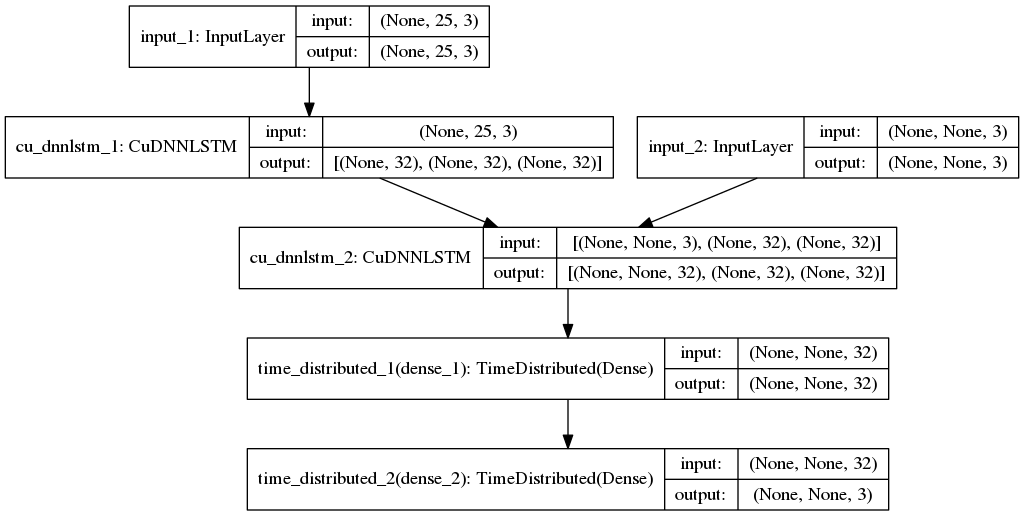

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(inputs=[encoder_inputs], outputs=encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_c1]

decoder_outputs_1, state_h1, state_c1 = decoder_1(decoder_inputs, initial_state=decoder_states_inputs[0:2])
decoder_states = [state_h1, state_c1]

dense_output_1 = dense_1(decoder_outputs_1)
decoder_outputs = dense_2(dense_output_1)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                      outputs=[decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((len(input_seq), 1, 3))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[:, 0, :] = np.sum(input_seq[:, -n_delay:, :], axis=1)

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((len(input_seq), len_delay, 3))
    
    for i in range(len_delay):
        output, h1, c1 = decoder_model.predict([target_seq] + states_value)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((len(input_seq), 1, 3))
        target_seq[:, 0, :] = output[:,0,:]
        decoded_seq[:,i,:] = output[:,0,:]

        # Update states
        states_value = [h1, c1]

    return decoded_seq

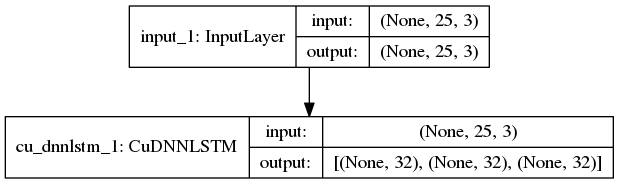

In [7]:
plot_model(encoder_model, to_file=experiment_name+'.png', show_shapes=True)

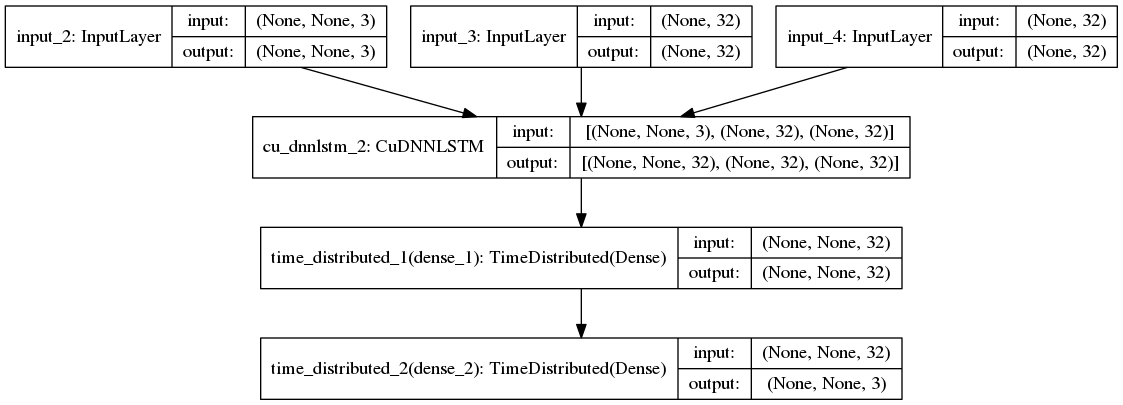

In [8]:
plot_model(decoder_model, to_file=experiment_name+'.png', show_shapes=True)

In [9]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [10]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [11]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

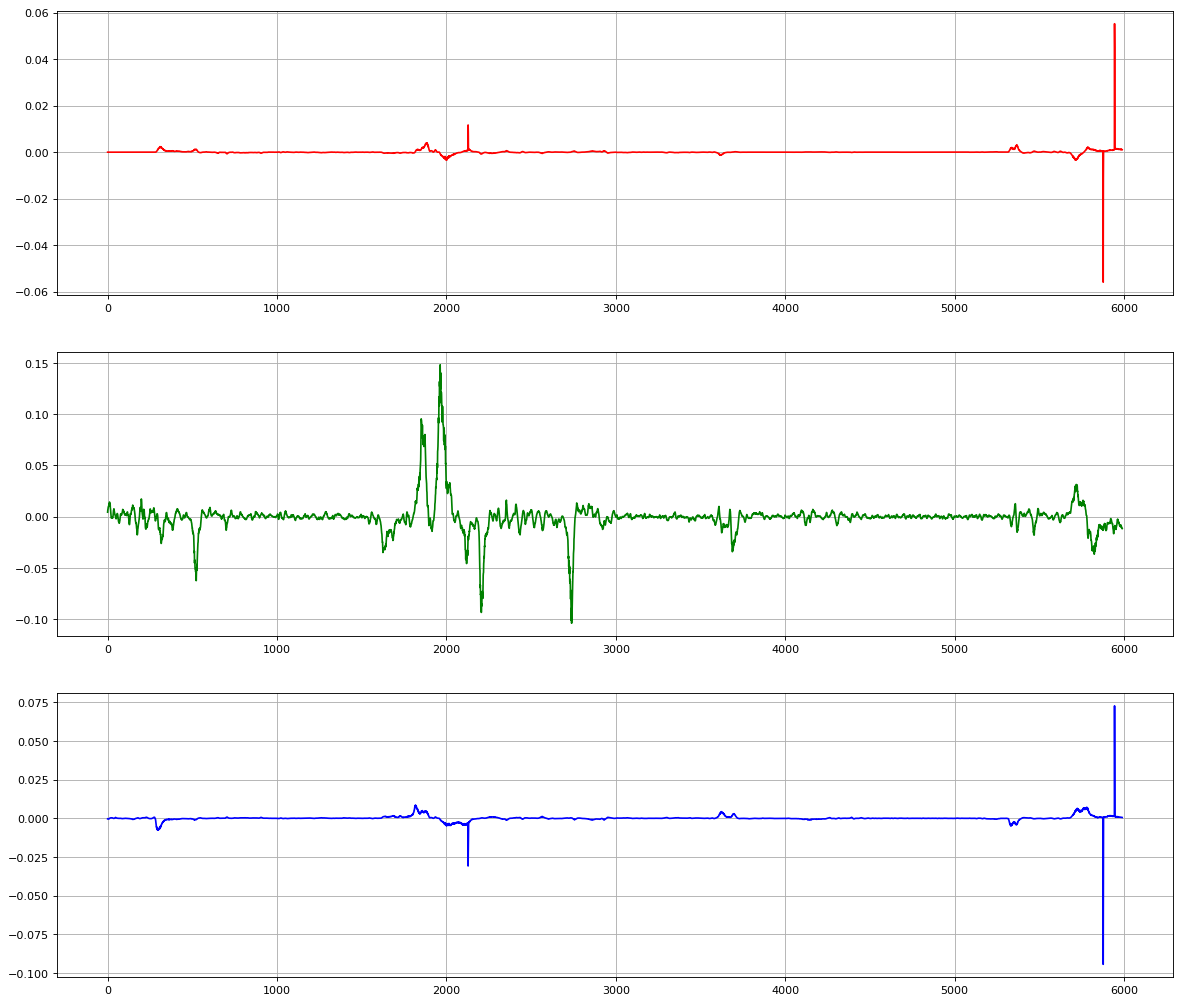

In [12]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [13]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/542 [..............................] - ETA: 8:08 - loss: 0.0555 - rmse: 0.1491

  5/542 [..............................] - ETA: 1:43 - loss: 0.0757 - rmse: 0.2010

  7/542 [..............................] - ETA: 1:21 - loss: 0.0786 - rmse: 0.2027

  8/542 [..............................] - ETA: 1:19 - loss: 0.0767 - rmse: 0.1964

  9/542 [..............................] - ETA: 1:17 - loss: 0.0763 - rmse: 0.1983

 10/542 [..............................] - ETA: 1:14 - loss: 0.0743 - rmse: 0.1961

 11/542 [..............................] - ETA: 1:13 - loss: 0.0714 - rmse: 0.1896

 12/542 [..............................] - ETA: 1:11 - loss: 0.0675 - rmse: 0.1785

 14/542 [..............................] - ETA: 1:04 - loss: 0.0626 - rmse: 0.1703

 16/542 [..............................] - ETA: 58s - loss: 0.0616 - rmse: 0.1657 

 18/542 [..............................] - ETA: 53s - loss: 0.0625 - rmse: 0.1680

 20/542 [>.............................] - ETA: 49s - loss: 0.0659 - rmse: 0.1768

 22/542 [>.............................] - ETA: 46s - loss: 0.0645 - rmse: 0.1740

 24/542 [>.............................] - ETA: 44s - loss: 0.0649 - rmse: 0.1772

 26/542 [>.............................] - ETA: 41s - loss: 0.0623 - rmse: 0.1694

 28/542 [>.............................] - ETA: 40s - loss: 0.0608 - rmse: 0.1673

 30/542 [>.............................] - ETA: 38s - loss: 0.0603 - rmse: 0.1658

 32/542 [>.............................] - ETA: 36s - loss: 0.0607 - rmse: 0.1671

 34/542 [>.............................] - ETA: 35s - loss: 0.0596 - rmse: 0.1630

 36/542 [>.............................] - ETA: 34s - loss: 0.0599 - rmse: 0.1628

 38/542 [=>............................] - ETA: 33s - loss: 0.0586 - rmse: 0.1598

 40/542 [=>............................] - ETA: 32s - loss: 0.0566 - rmse: 0.1543

 42/542 [=>............................] - ETA: 31s - loss: 0.0570 - rmse: 0.1552

 44/542 [=>............................] - ETA: 31s - loss: 0.0563 - rmse: 0.1532

 46/542 [=>............................] - ETA: 30s - loss: 0.0557 - rmse: 0.1507

 48/542 [=>............................] - ETA: 29s - loss: 0.0557 - rmse: 0.1497

 50/542 [=>............................] - ETA: 29s - loss: 0.0552 - rmse: 0.1482

 52/542 [=>............................] - ETA: 28s - loss: 0.0544 - rmse: 0.1466

 54/542 [=>............................] - ETA: 28s - loss: 0.0538 - rmse: 0.1447

 56/542 [==>...........................] - ETA: 27s - loss: 0.0536 - rmse: 0.1437

 58/542 [==>...........................] - ETA: 27s - loss: 0.0537 - rmse: 0.1439

 60/542 [==>...........................] - ETA: 26s - loss: 0.0535 - rmse: 0.1434

 62/542 [==>...........................] - ETA: 26s - loss: 0.0540 - rmse: 0.1450

 64/542 [==>...........................] - ETA: 25s - loss: 0.0538 - rmse: 0.1449

 66/542 [==>...........................] - ETA: 25s - loss: 0.0543 - rmse: 0.1469

 68/542 [==>...........................] - ETA: 25s - loss: 0.0540 - rmse: 0.1454

 70/542 [==>...........................] - ETA: 24s - loss: 0.0539 - rmse: 0.1450

 72/542 [==>...........................] - ETA: 24s - loss: 0.0533 - rmse: 0.1432

 74/542 [===>..........................] - ETA: 24s - loss: 0.0527 - rmse: 0.1417

 76/542 [===>..........................] - ETA: 23s - loss: 0.0526 - rmse: 0.1412

 78/542 [===>..........................] - ETA: 23s - loss: 0.0529 - rmse: 0.1423

 80/542 [===>..........................] - ETA: 23s - loss: 0.0530 - rmse: 0.1425

 82/542 [===>..........................] - ETA: 22s - loss: 0.0524 - rmse: 0.1408

 84/542 [===>..........................] - ETA: 22s - loss: 0.0520 - rmse: 0.1403

 86/542 [===>..........................] - ETA: 22s - loss: 0.0519 - rmse: 0.1399

 88/542 [===>..........................] - ETA: 22s - loss: 0.0517 - rmse: 0.1396

 90/542 [===>..........................] - ETA: 22s - loss: 0.0510 - rmse: 0.1378

 92/542 [====>.........................] - ETA: 21s - loss: 0.0509 - rmse: 0.1380

 94/542 [====>.........................] - ETA: 21s - loss: 0.0509 - rmse: 0.1387

 96/542 [====>.........................] - ETA: 21s - loss: 0.0505 - rmse: 0.1378

 98/542 [====>.........................] - ETA: 21s - loss: 0.0502 - rmse: 0.1372

100/542 [====>.........................] - ETA: 21s - loss: 0.0501 - rmse: 0.1365

102/542 [====>.........................] - ETA: 20s - loss: 0.0502 - rmse: 0.1369

104/542 [====>.........................] - ETA: 20s - loss: 0.0499 - rmse: 0.1364

106/542 [====>.........................] - ETA: 20s - loss: 0.0499 - rmse: 0.1361

108/542 [====>.........................] - ETA: 20s - loss: 0.0504 - rmse: 0.1377

110/542 [=====>........................] - ETA: 20s - loss: 0.0501 - rmse: 0.1370

112/542 [=====>........................] - ETA: 19s - loss: 0.0497 - rmse: 0.1360

114/542 [=====>........................] - ETA: 19s - loss: 0.0492 - rmse: 0.1349

116/542 [=====>........................] - ETA: 19s - loss: 0.0491 - rmse: 0.1342

118/542 [=====>........................] - ETA: 19s - loss: 0.0493 - rmse: 0.1345

120/542 [=====>........................] - ETA: 19s - loss: 0.0494 - rmse: 0.1345

122/542 [=====>........................] - ETA: 19s - loss: 0.0493 - rmse: 0.1342

124/542 [=====>........................] - ETA: 18s - loss: 0.0493 - rmse: 0.1342

126/542 [=====>........................] - ETA: 18s - loss: 0.0495 - rmse: 0.1348

128/542 [======>.......................] - ETA: 18s - loss: 0.0492 - rmse: 0.1338

130/542 [======>.......................] - ETA: 18s - loss: 0.0494 - rmse: 0.1341

132/542 [======>.......................] - ETA: 18s - loss: 0.0492 - rmse: 0.1338

134/542 [======>.......................] - ETA: 18s - loss: 0.0492 - rmse: 0.1336

136/542 [======>.......................] - ETA: 17s - loss: 0.0488 - rmse: 0.1324

138/542 [======>.......................] - ETA: 17s - loss: 0.0490 - rmse: 0.1331

140/542 [======>.......................] - ETA: 17s - loss: 0.0489 - rmse: 0.1330

142/542 [======>.......................] - ETA: 17s - loss: 0.0489 - rmse: 0.1334

144/542 [======>.......................] - ETA: 17s - loss: 0.0488 - rmse: 0.1330

146/542 [=======>......................] - ETA: 17s - loss: 0.0485 - rmse: 0.1321

148/542 [=======>......................] - ETA: 17s - loss: 0.0484 - rmse: 0.1317

150/542 [=======>......................] - ETA: 17s - loss: 0.0485 - rmse: 0.1317

152/542 [=======>......................] - ETA: 16s - loss: 0.0483 - rmse: 0.1313

154/542 [=======>......................] - ETA: 16s - loss: 0.0480 - rmse: 0.1305

156/542 [=======>......................] - ETA: 16s - loss: 0.0480 - rmse: 0.1304

158/542 [=======>......................] - ETA: 16s - loss: 0.0480 - rmse: 0.1301

160/542 [=======>......................] - ETA: 16s - loss: 0.0479 - rmse: 0.1296

162/542 [=======>......................] - ETA: 16s - loss: 0.0477 - rmse: 0.1289

164/542 [========>.....................] - ETA: 16s - loss: 0.0476 - rmse: 0.1285

166/542 [========>.....................] - ETA: 16s - loss: 0.0473 - rmse: 0.1276

168/542 [========>.....................] - ETA: 15s - loss: 0.0472 - rmse: 0.1275

170/542 [========>.....................] - ETA: 15s - loss: 0.0471 - rmse: 0.1272

172/542 [========>.....................] - ETA: 15s - loss: 0.0470 - rmse: 0.1271

174/542 [========>.....................] - ETA: 15s - loss: 0.0469 - rmse: 0.1265

176/542 [========>.....................] - ETA: 15s - loss: 0.0469 - rmse: 0.1264

178/542 [========>.....................] - ETA: 15s - loss: 0.0467 - rmse: 0.1258

180/542 [========>.....................] - ETA: 15s - loss: 0.0466 - rmse: 0.1254

182/542 [=========>....................] - ETA: 15s - loss: 0.0463 - rmse: 0.1246

184/542 [=========>....................] - ETA: 15s - loss: 0.0463 - rmse: 0.1244

186/542 [=========>....................] - ETA: 14s - loss: 0.0463 - rmse: 0.1244

188/542 [=========>....................] - ETA: 14s - loss: 0.0461 - rmse: 0.1239

190/542 [=========>....................] - ETA: 14s - loss: 0.0461 - rmse: 0.1236

192/542 [=========>....................] - ETA: 14s - loss: 0.0462 - rmse: 0.1240

194/542 [=========>....................] - ETA: 14s - loss: 0.0462 - rmse: 0.1239

196/542 [=========>....................] - ETA: 14s - loss: 0.0462 - rmse: 0.1238

198/542 [=========>....................] - ETA: 14s - loss: 0.0461 - rmse: 0.1234

200/542 [==========>...................] - ETA: 14s - loss: 0.0459 - rmse: 0.1229

202/542 [==========>...................] - ETA: 14s - loss: 0.0458 - rmse: 0.1226

204/542 [==========>...................] - ETA: 13s - loss: 0.0459 - rmse: 0.1227

206/542 [==========>...................] - ETA: 13s - loss: 0.0458 - rmse: 0.1221

208/542 [==========>...................] - ETA: 13s - loss: 0.0456 - rmse: 0.1215

210/542 [==========>...................] - ETA: 13s - loss: 0.0456 - rmse: 0.1214

212/542 [==========>...................] - ETA: 13s - loss: 0.0456 - rmse: 0.1215

214/542 [==========>...................] - ETA: 13s - loss: 0.0456 - rmse: 0.1218

216/542 [==========>...................] - ETA: 13s - loss: 0.0456 - rmse: 0.1218

218/542 [===========>..................] - ETA: 13s - loss: 0.0455 - rmse: 0.1213

220/542 [===========>..................] - ETA: 13s - loss: 0.0453 - rmse: 0.1208

222/542 [===========>..................] - ETA: 13s - loss: 0.0453 - rmse: 0.1206

224/542 [===========>..................] - ETA: 13s - loss: 0.0453 - rmse: 0.1207

226/542 [===========>..................] - ETA: 12s - loss: 0.0451 - rmse: 0.1201

228/542 [===========>..................] - ETA: 12s - loss: 0.0450 - rmse: 0.1198

230/542 [===========>..................] - ETA: 12s - loss: 0.0449 - rmse: 0.1195

232/542 [===========>..................] - ETA: 12s - loss: 0.0449 - rmse: 0.1194

234/542 [===========>..................] - ETA: 12s - loss: 0.0447 - rmse: 0.1189

236/542 [============>.................] - ETA: 12s - loss: 0.0446 - rmse: 0.1186

238/542 [============>.................] - ETA: 12s - loss: 0.0444 - rmse: 0.1180

240/542 [============>.................] - ETA: 12s - loss: 0.0443 - rmse: 0.1176

242/542 [============>.................] - ETA: 12s - loss: 0.0442 - rmse: 0.1176

244/542 [============>.................] - ETA: 12s - loss: 0.0441 - rmse: 0.1171

246/542 [============>.................] - ETA: 11s - loss: 0.0439 - rmse: 0.1167

248/542 [============>.................] - ETA: 11s - loss: 0.0439 - rmse: 0.1164

250/542 [============>.................] - ETA: 11s - loss: 0.0438 - rmse: 0.1163

252/542 [============>.................] - ETA: 11s - loss: 0.0438 - rmse: 0.1161

254/542 [=============>................] - ETA: 11s - loss: 0.0436 - rmse: 0.1158

256/542 [=============>................] - ETA: 11s - loss: 0.0434 - rmse: 0.1153

258/542 [=============>................] - ETA: 11s - loss: 0.0433 - rmse: 0.1150

260/542 [=============>................] - ETA: 11s - loss: 0.0432 - rmse: 0.1145

262/542 [=============>................] - ETA: 11s - loss: 0.0431 - rmse: 0.1141

264/542 [=============>................] - ETA: 11s - loss: 0.0431 - rmse: 0.1140

266/542 [=============>................] - ETA: 11s - loss: 0.0431 - rmse: 0.1141

268/542 [=============>................] - ETA: 10s - loss: 0.0429 - rmse: 0.1136

270/542 [=============>................] - ETA: 10s - loss: 0.0429 - rmse: 0.1135

272/542 [==============>...............] - ETA: 10s - loss: 0.0429 - rmse: 0.1136

274/542 [==============>...............] - ETA: 10s - loss: 0.0430 - rmse: 0.1137

276/542 [==============>...............] - ETA: 10s - loss: 0.0428 - rmse: 0.1131

278/542 [==============>...............] - ETA: 10s - loss: 0.0428 - rmse: 0.1130

280/542 [==============>...............] - ETA: 10s - loss: 0.0427 - rmse: 0.1128

282/542 [==============>...............] - ETA: 10s - loss: 0.0427 - rmse: 0.1128

284/542 [==============>...............] - ETA: 10s - loss: 0.0426 - rmse: 0.1125

286/542 [==============>...............] - ETA: 10s - loss: 0.0426 - rmse: 0.1125

288/542 [==============>...............] - ETA: 10s - loss: 0.0426 - rmse: 0.1125

290/542 [===============>..............] - ETA: 10s - loss: 0.0425 - rmse: 0.1124

292/542 [===============>..............] - ETA: 9s - loss: 0.0426 - rmse: 0.1124 

294/542 [===============>..............] - ETA: 9s - loss: 0.0425 - rmse: 0.1122

296/542 [===============>..............] - ETA: 9s - loss: 0.0425 - rmse: 0.1124

298/542 [===============>..............] - ETA: 9s - loss: 0.0425 - rmse: 0.1123

300/542 [===============>..............] - ETA: 9s - loss: 0.0424 - rmse: 0.1119

302/542 [===============>..............] - ETA: 9s - loss: 0.0423 - rmse: 0.1116

304/542 [===============>..............] - ETA: 9s - loss: 0.0424 - rmse: 0.1117

306/542 [===============>..............] - ETA: 9s - loss: 0.0425 - rmse: 0.1118

308/542 [================>.............] - ETA: 9s - loss: 0.0424 - rmse: 0.1116

310/542 [================>.............] - ETA: 9s - loss: 0.0424 - rmse: 0.1114

312/542 [================>.............] - ETA: 9s - loss: 0.0424 - rmse: 0.1114

314/542 [================>.............] - ETA: 8s - loss: 0.0424 - rmse: 0.1114

316/542 [================>.............] - ETA: 8s - loss: 0.0423 - rmse: 0.1112

318/542 [================>.............] - ETA: 8s - loss: 0.0423 - rmse: 0.1109

320/542 [================>.............] - ETA: 8s - loss: 0.0422 - rmse: 0.1108

322/542 [================>.............] - ETA: 8s - loss: 0.0420 - rmse: 0.1106

324/542 [================>.............] - ETA: 8s - loss: 0.0419 - rmse: 0.1102

326/542 [=================>............] - ETA: 8s - loss: 0.0418 - rmse: 0.1099

328/542 [=================>............] - ETA: 8s - loss: 0.0417 - rmse: 0.1096

330/542 [=================>............] - ETA: 8s - loss: 0.0416 - rmse: 0.1095

332/542 [=================>............] - ETA: 8s - loss: 0.0415 - rmse: 0.1091

334/542 [=================>............] - ETA: 8s - loss: 0.0415 - rmse: 0.1091

336/542 [=================>............] - ETA: 8s - loss: 0.0415 - rmse: 0.1089

338/542 [=================>............] - ETA: 7s - loss: 0.0414 - rmse: 0.1088

340/542 [=================>............] - ETA: 7s - loss: 0.0414 - rmse: 0.1087

342/542 [=================>............] - ETA: 7s - loss: 0.0413 - rmse: 0.1086

344/542 [==================>...........] - ETA: 7s - loss: 0.0413 - rmse: 0.1084

346/542 [==================>...........] - ETA: 7s - loss: 0.0412 - rmse: 0.1082

348/542 [==================>...........] - ETA: 7s - loss: 0.0410 - rmse: 0.1078

350/542 [==================>...........] - ETA: 7s - loss: 0.0410 - rmse: 0.1076

352/542 [==================>...........] - ETA: 7s - loss: 0.0410 - rmse: 0.1075

354/542 [==================>...........] - ETA: 7s - loss: 0.0409 - rmse: 0.1073

356/542 [==================>...........] - ETA: 7s - loss: 0.0408 - rmse: 0.1071

358/542 [==================>...........] - ETA: 7s - loss: 0.0408 - rmse: 0.1069

360/542 [==================>...........] - ETA: 7s - loss: 0.0407 - rmse: 0.1068

362/542 [===================>..........] - ETA: 6s - loss: 0.0407 - rmse: 0.1068

364/542 [===================>..........] - ETA: 6s - loss: 0.0407 - rmse: 0.1067

366/542 [===================>..........] - ETA: 6s - loss: 0.0406 - rmse: 0.1066

368/542 [===================>..........] - ETA: 6s - loss: 0.0406 - rmse: 0.1065

370/542 [===================>..........] - ETA: 6s - loss: 0.0406 - rmse: 0.1065

372/542 [===================>..........] - ETA: 6s - loss: 0.0405 - rmse: 0.1065

374/542 [===================>..........] - ETA: 6s - loss: 0.0406 - rmse: 0.1066

376/542 [===================>..........] - ETA: 6s - loss: 0.0407 - rmse: 0.1068

378/542 [===================>..........] - ETA: 6s - loss: 0.0406 - rmse: 0.1066

380/542 [====================>.........] - ETA: 6s - loss: 0.0405 - rmse: 0.1065

382/542 [====================>.........] - ETA: 6s - loss: 0.0405 - rmse: 0.1064

384/542 [====================>.........] - ETA: 6s - loss: 0.0404 - rmse: 0.1062

386/542 [====================>.........] - ETA: 6s - loss: 0.0404 - rmse: 0.1062

388/542 [====================>.........] - ETA: 5s - loss: 0.0403 - rmse: 0.1060

390/542 [====================>.........] - ETA: 5s - loss: 0.0402 - rmse: 0.1058

392/542 [====================>.........] - ETA: 5s - loss: 0.0402 - rmse: 0.1057

394/542 [====================>.........] - ETA: 5s - loss: 0.0401 - rmse: 0.1055

396/542 [====================>.........] - ETA: 5s - loss: 0.0401 - rmse: 0.1054

398/542 [=====================>........] - ETA: 5s - loss: 0.0400 - rmse: 0.1053

400/542 [=====================>........] - ETA: 5s - loss: 0.0400 - rmse: 0.1053

402/542 [=====================>........] - ETA: 5s - loss: 0.0400 - rmse: 0.1052

404/542 [=====================>........] - ETA: 5s - loss: 0.0399 - rmse: 0.1051

406/542 [=====================>........] - ETA: 5s - loss: 0.0399 - rmse: 0.1050

408/542 [=====================>........] - ETA: 5s - loss: 0.0399 - rmse: 0.1050

410/542 [=====================>........] - ETA: 5s - loss: 0.0398 - rmse: 0.1048

412/542 [=====================>........] - ETA: 4s - loss: 0.0397 - rmse: 0.1045

414/542 [=====================>........] - ETA: 4s - loss: 0.0397 - rmse: 0.1045

416/542 [======================>.......] - ETA: 4s - loss: 0.0396 - rmse: 0.1043

418/542 [======================>.......] - ETA: 4s - loss: 0.0396 - rmse: 0.1042

420/542 [======================>.......] - ETA: 4s - loss: 0.0396 - rmse: 0.1041

422/542 [======================>.......] - ETA: 4s - loss: 0.0395 - rmse: 0.1041

424/542 [======================>.......] - ETA: 4s - loss: 0.0395 - rmse: 0.1038

426/542 [======================>.......] - ETA: 4s - loss: 0.0394 - rmse: 0.1037

428/542 [======================>.......] - ETA: 4s - loss: 0.0394 - rmse: 0.1037

430/542 [======================>.......] - ETA: 4s - loss: 0.0394 - rmse: 0.1036

432/542 [======================>.......] - ETA: 4s - loss: 0.0394 - rmse: 0.1035

434/542 [=======================>......] - ETA: 4s - loss: 0.0393 - rmse: 0.1034

436/542 [=======================>......] - ETA: 4s - loss: 0.0393 - rmse: 0.1033

438/542 [=======================>......] - ETA: 3s - loss: 0.0392 - rmse: 0.1031

440/542 [=======================>......] - ETA: 3s - loss: 0.0392 - rmse: 0.1030

442/542 [=======================>......] - ETA: 3s - loss: 0.0392 - rmse: 0.1029

444/542 [=======================>......] - ETA: 3s - loss: 0.0391 - rmse: 0.1027

446/542 [=======================>......] - ETA: 3s - loss: 0.0390 - rmse: 0.1025

448/542 [=======================>......] - ETA: 3s - loss: 0.0389 - rmse: 0.1023

450/542 [=======================>......] - ETA: 3s - loss: 0.0389 - rmse: 0.1023

452/542 [========================>.....] - ETA: 3s - loss: 0.0389 - rmse: 0.1022

454/542 [========================>.....] - ETA: 3s - loss: 0.0390 - rmse: 0.1023

456/542 [========================>.....] - ETA: 3s - loss: 0.0389 - rmse: 0.1023

458/542 [========================>.....] - ETA: 3s - loss: 0.0389 - rmse: 0.1021

460/542 [========================>.....] - ETA: 3s - loss: 0.0388 - rmse: 0.1020

462/542 [========================>.....] - ETA: 3s - loss: 0.0388 - rmse: 0.1018

464/542 [========================>.....] - ETA: 2s - loss: 0.0388 - rmse: 0.1018

466/542 [========================>.....] - ETA: 2s - loss: 0.0388 - rmse: 0.1017

468/542 [========================>.....] - ETA: 2s - loss: 0.0387 - rmse: 0.1016

470/542 [=========================>....] - ETA: 2s - loss: 0.0386 - rmse: 0.1014

472/542 [=========================>....] - ETA: 2s - loss: 0.0387 - rmse: 0.1014

474/542 [=========================>....] - ETA: 2s - loss: 0.0386 - rmse: 0.1013

476/542 [=========================>....] - ETA: 2s - loss: 0.0386 - rmse: 0.1013

478/542 [=========================>....] - ETA: 2s - loss: 0.0386 - rmse: 0.1012

480/542 [=========================>....] - ETA: 2s - loss: 0.0386 - rmse: 0.1012



482/542 [=========================>....] - ETA: 2s - loss: 0.0386 - rmse: 0.1012

484/542 [=========================>....] - ETA: 2s - loss: 0.0385 - rmse: 0.1010

486/542 [=========================>....] - ETA: 2s - loss: 0.0385 - rmse: 0.1009

488/542 [==========================>...] - ETA: 2s - loss: 0.0385 - rmse: 0.1010

490/542 [==========================>...] - ETA: 1s - loss: 0.0385 - rmse: 0.1009

492/542 [==========================>...] - ETA: 1s - loss: 0.0385 - rmse: 0.1009

494/542 [==========================>...] - ETA: 1s - loss: 0.0385 - rmse: 0.1009

496/542 [==========================>...] - ETA: 1s - loss: 0.0385 - rmse: 0.1008

498/542 [==========================>...] - ETA: 1s - loss: 0.0385 - rmse: 0.1007

500/542 [==========================>...] - ETA: 1s - loss: 0.0385 - rmse: 0.1007

502/542 [==========================>...] - ETA: 1s - loss: 0.0384 - rmse: 0.1005

504/542 [==========================>...] - ETA: 1s - loss: 0.0384 - rmse: 0.1004

506/542 [===========================>..] - ETA: 1s - loss: 0.0383 - rmse: 0.1003

508/542 [===========================>..] - ETA: 1s - loss: 0.0382 - rmse: 0.1001

510/542 [===========================>..] - ETA: 1s - loss: 0.0382 - rmse: 0.1000

512/542 [===========================>..] - ETA: 1s - loss: 0.0382 - rmse: 0.1000

514/542 [===========================>..] - ETA: 1s - loss: 0.0383 - rmse: 0.1000

516/542 [===========================>..] - ETA: 0s - loss: 0.0383 - rmse: 0.1000

518/542 [===========================>..] - ETA: 0s - loss: 0.0382 - rmse: 0.0999

520/542 [===========================>..] - ETA: 0s - loss: 0.0382 - rmse: 0.0999

522/542 [===========================>..] - ETA: 0s - loss: 0.0382 - rmse: 0.0999

524/542 [============================>.] - ETA: 0s - loss: 0.0381 - rmse: 0.0998

526/542 [============================>.] - ETA: 0s - loss: 0.0381 - rmse: 0.0997

528/542 [============================>.] - ETA: 0s - loss: 0.0380 - rmse: 0.0995

530/542 [============================>.] - ETA: 0s - loss: 0.0380 - rmse: 0.0994

532/542 [============================>.] - ETA: 0s - loss: 0.0380 - rmse: 0.0993

534/542 [============================>.] - ETA: 0s - loss: 0.0379 - rmse: 0.0991

536/542 [============================>.] - ETA: 0s - loss: 0.0379 - rmse: 0.0992

538/542 [============================>.] - ETA: 0s - loss: 0.0379 - rmse: 0.0991

540/542 [============================>.] - ETA: 0s - loss: 0.0379 - rmse: 0.0990

542/542 [==============================] - 26s 48ms/step - loss: 0.0379 - rmse: 0.0990 - val_loss: 0.0328 - val_rmse: 0.0869


Epoch 2/150
  1/542 [..............................] - ETA: 8s - loss: 0.0577 - rmse: 0.1398

  5/542 [..............................] - ETA: 8s - loss: 0.0317 - rmse: 0.0828

/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


  8/542 [..............................] - ETA: 8s - loss: 0.0323 - rmse: 0.0875

 11/542 [..............................] - ETA: 8s - loss: 0.0310 - rmse: 0.0825

 13/542 [..............................] - ETA: 11s - loss: 0.0309 - rmse: 0.0822

 14/542 [..............................] - ETA: 15s - loss: 0.0317 - rmse: 0.0832

 15/542 [..............................] - ETA: 18s - loss: 0.0326 - rmse: 0.0852

 16/542 [..............................] - ETA: 21s - loss: 0.0331 - rmse: 0.0857

 17/542 [..............................] - ETA: 24s - loss: 0.0324 - rmse: 0.0835

 18/542 [..............................] - ETA: 26s - loss: 0.0333 - rmse: 0.0851

 19/542 [>.............................] - ETA: 28s - loss: 0.0328 - rmse: 0.0836

 20/542 [>.............................] - ETA: 30s - loss: 0.0326 - rmse: 0.0828

 21/542 [>.............................] - ETA: 31s - loss: 0.0328 - rmse: 0.0833

 23/542 [>.............................] - ETA: 30s - loss: 0.0336 - rmse: 0.0848

 25/542 [>.............................] - ETA: 29s - loss: 0.0339 - rmse: 0.0854

 27/542 [>.............................] - ETA: 28s - loss: 0.0335 - rmse: 0.0847

 29/542 [>.............................] - ETA: 27s - loss: 0.0340 - rmse: 0.0858

 31/542 [>.............................] - ETA: 27s - loss: 0.0339 - rmse: 0.0851

 33/542 [>.............................] - ETA: 26s - loss: 0.0336 - rmse: 0.0844

 35/542 [>.............................] - ETA: 25s - loss: 0.0334 - rmse: 0.0844

 37/542 [=>............................] - ETA: 25s - loss: 0.0324 - rmse: 0.0829

 39/542 [=>............................] - ETA: 24s - loss: 0.0330 - rmse: 0.0841

 41/542 [=>............................] - ETA: 24s - loss: 0.0335 - rmse: 0.0855

 43/542 [=>............................] - ETA: 23s - loss: 0.0334 - rmse: 0.0868

 45/542 [=>............................] - ETA: 23s - loss: 0.0334 - rmse: 0.0866

 47/542 [=>............................] - ETA: 23s - loss: 0.0331 - rmse: 0.0856

 49/542 [=>............................] - ETA: 22s - loss: 0.0327 - rmse: 0.0848

 51/542 [=>............................] - ETA: 22s - loss: 0.0329 - rmse: 0.0847

 53/542 [=>............................] - ETA: 22s - loss: 0.0328 - rmse: 0.0842

 55/542 [==>...........................] - ETA: 22s - loss: 0.0331 - rmse: 0.0856

 57/542 [==>...........................] - ETA: 21s - loss: 0.0329 - rmse: 0.0851

 59/542 [==>...........................] - ETA: 21s - loss: 0.0328 - rmse: 0.0847

 61/542 [==>...........................] - ETA: 21s - loss: 0.0331 - rmse: 0.0860

 63/542 [==>...........................] - ETA: 21s - loss: 0.0326 - rmse: 0.0848

 65/542 [==>...........................] - ETA: 20s - loss: 0.0332 - rmse: 0.0861

 67/542 [==>...........................] - ETA: 20s - loss: 0.0327 - rmse: 0.0847

 69/542 [==>...........................] - ETA: 20s - loss: 0.0327 - rmse: 0.0848

 71/542 [==>...........................] - ETA: 20s - loss: 0.0324 - rmse: 0.0839

 73/542 [===>..........................] - ETA: 20s - loss: 0.0323 - rmse: 0.0834

 75/542 [===>..........................] - ETA: 19s - loss: 0.0323 - rmse: 0.0831

 77/542 [===>..........................] - ETA: 19s - loss: 0.0321 - rmse: 0.0824

 79/542 [===>..........................] - ETA: 19s - loss: 0.0320 - rmse: 0.0821

 81/542 [===>..........................] - ETA: 19s - loss: 0.0321 - rmse: 0.0821

 83/542 [===>..........................] - ETA: 19s - loss: 0.0321 - rmse: 0.0820

 85/542 [===>..........................] - ETA: 19s - loss: 0.0322 - rmse: 0.0820

 87/542 [===>..........................] - ETA: 18s - loss: 0.0322 - rmse: 0.0822

 89/542 [===>..........................] - ETA: 18s - loss: 0.0324 - rmse: 0.0824

 91/542 [====>.........................] - ETA: 18s - loss: 0.0324 - rmse: 0.0823

 93/542 [====>.........................] - ETA: 18s - loss: 0.0326 - rmse: 0.0828

 95/542 [====>.........................] - ETA: 18s - loss: 0.0324 - rmse: 0.0822

 97/542 [====>.........................] - ETA: 18s - loss: 0.0324 - rmse: 0.0824

 99/542 [====>.........................] - ETA: 18s - loss: 0.0324 - rmse: 0.0825

101/542 [====>.........................] - ETA: 17s - loss: 0.0323 - rmse: 0.0820

103/542 [====>.........................] - ETA: 17s - loss: 0.0324 - rmse: 0.0821

105/542 [====>.........................] - ETA: 17s - loss: 0.0324 - rmse: 0.0822

107/542 [====>.........................] - ETA: 17s - loss: 0.0322 - rmse: 0.0818

109/542 [=====>........................] - ETA: 17s - loss: 0.0321 - rmse: 0.0816

111/542 [=====>........................] - ETA: 17s - loss: 0.0323 - rmse: 0.0820

113/542 [=====>........................] - ETA: 17s - loss: 0.0322 - rmse: 0.0817

115/542 [=====>........................] - ETA: 17s - loss: 0.0322 - rmse: 0.0815

117/542 [=====>........................] - ETA: 17s - loss: 0.0321 - rmse: 0.0810

119/542 [=====>........................] - ETA: 16s - loss: 0.0324 - rmse: 0.0817

121/542 [=====>........................] - ETA: 16s - loss: 0.0324 - rmse: 0.0819

123/542 [=====>........................] - ETA: 16s - loss: 0.0325 - rmse: 0.0822

125/542 [=====>........................] - ETA: 16s - loss: 0.0324 - rmse: 0.0824

127/542 [======>.......................] - ETA: 16s - loss: 0.0323 - rmse: 0.0823

129/542 [======>.......................] - ETA: 16s - loss: 0.0321 - rmse: 0.0816

131/542 [======>.......................] - ETA: 16s - loss: 0.0320 - rmse: 0.0814

133/542 [======>.......................] - ETA: 16s - loss: 0.0321 - rmse: 0.0816

135/542 [======>.......................] - ETA: 16s - loss: 0.0322 - rmse: 0.0821

137/542 [======>.......................] - ETA: 15s - loss: 0.0321 - rmse: 0.0819

139/542 [======>.......................] - ETA: 15s - loss: 0.0319 - rmse: 0.0815

141/542 [======>.......................] - ETA: 15s - loss: 0.0318 - rmse: 0.0810

143/542 [======>.......................] - ETA: 15s - loss: 0.0319 - rmse: 0.0813

145/542 [=======>......................] - ETA: 15s - loss: 0.0319 - rmse: 0.0812

147/542 [=======>......................] - ETA: 15s - loss: 0.0319 - rmse: 0.0811

149/542 [=======>......................] - ETA: 15s - loss: 0.0319 - rmse: 0.0812

151/542 [=======>......................] - ETA: 15s - loss: 0.0319 - rmse: 0.0811

153/542 [=======>......................] - ETA: 15s - loss: 0.0317 - rmse: 0.0807

155/542 [=======>......................] - ETA: 15s - loss: 0.0317 - rmse: 0.0805

157/542 [=======>......................] - ETA: 14s - loss: 0.0315 - rmse: 0.0804

159/542 [=======>......................] - ETA: 14s - loss: 0.0315 - rmse: 0.0803

161/542 [=======>......................] - ETA: 14s - loss: 0.0314 - rmse: 0.0799

163/542 [========>.....................] - ETA: 14s - loss: 0.0313 - rmse: 0.0797

165/542 [========>.....................] - ETA: 14s - loss: 0.0312 - rmse: 0.0796

167/542 [========>.....................] - ETA: 14s - loss: 0.0312 - rmse: 0.0797

169/542 [========>.....................] - ETA: 14s - loss: 0.0313 - rmse: 0.0798

171/542 [========>.....................] - ETA: 14s - loss: 0.0311 - rmse: 0.0797

173/542 [========>.....................] - ETA: 14s - loss: 0.0312 - rmse: 0.0799

175/542 [========>.....................] - ETA: 14s - loss: 0.0313 - rmse: 0.0802

177/542 [========>.....................] - ETA: 14s - loss: 0.0313 - rmse: 0.0803

179/542 [========>.....................] - ETA: 13s - loss: 0.0314 - rmse: 0.0807

181/542 [=========>....................] - ETA: 13s - loss: 0.0312 - rmse: 0.0803

183/542 [=========>....................] - ETA: 13s - loss: 0.0312 - rmse: 0.0803

185/542 [=========>....................] - ETA: 13s - loss: 0.0312 - rmse: 0.0803

187/542 [=========>....................] - ETA: 13s - loss: 0.0312 - rmse: 0.0801

189/542 [=========>....................] - ETA: 13s - loss: 0.0312 - rmse: 0.0802

191/542 [=========>....................] - ETA: 13s - loss: 0.0312 - rmse: 0.0801

193/542 [=========>....................] - ETA: 13s - loss: 0.0312 - rmse: 0.0801

195/542 [=========>....................] - ETA: 13s - loss: 0.0311 - rmse: 0.0799

197/542 [=========>....................] - ETA: 13s - loss: 0.0312 - rmse: 0.0801

199/542 [==========>...................] - ETA: 13s - loss: 0.0312 - rmse: 0.0803

201/542 [==========>...................] - ETA: 13s - loss: 0.0313 - rmse: 0.0807

203/542 [==========>...................] - ETA: 12s - loss: 0.0314 - rmse: 0.0811

205/542 [==========>...................] - ETA: 12s - loss: 0.0313 - rmse: 0.0809

207/542 [==========>...................] - ETA: 12s - loss: 0.0313 - rmse: 0.0806

209/542 [==========>...................] - ETA: 12s - loss: 0.0312 - rmse: 0.0804

211/542 [==========>...................] - ETA: 12s - loss: 0.0310 - rmse: 0.0801

213/542 [==========>...................] - ETA: 12s - loss: 0.0310 - rmse: 0.0801

215/542 [==========>...................] - ETA: 12s - loss: 0.0309 - rmse: 0.0798

217/542 [===========>..................] - ETA: 12s - loss: 0.0310 - rmse: 0.0800

219/542 [===========>..................] - ETA: 12s - loss: 0.0310 - rmse: 0.0802

221/542 [===========>..................] - ETA: 12s - loss: 0.0310 - rmse: 0.0802

223/542 [===========>..................] - ETA: 12s - loss: 0.0309 - rmse: 0.0798

225/542 [===========>..................] - ETA: 12s - loss: 0.0309 - rmse: 0.0797

227/542 [===========>..................] - ETA: 11s - loss: 0.0309 - rmse: 0.0800

229/542 [===========>..................] - ETA: 11s - loss: 0.0310 - rmse: 0.0802

231/542 [===========>..................] - ETA: 11s - loss: 0.0311 - rmse: 0.0805

233/542 [===========>..................] - ETA: 11s - loss: 0.0311 - rmse: 0.0805

235/542 [============>.................] - ETA: 11s - loss: 0.0310 - rmse: 0.0802

237/542 [============>.................] - ETA: 11s - loss: 0.0309 - rmse: 0.0799

239/542 [============>.................] - ETA: 11s - loss: 0.0308 - rmse: 0.0797

241/542 [============>.................] - ETA: 11s - loss: 0.0307 - rmse: 0.0795

243/542 [============>.................] - ETA: 11s - loss: 0.0308 - rmse: 0.0799

245/542 [============>.................] - ETA: 11s - loss: 0.0308 - rmse: 0.0797

247/542 [============>.................] - ETA: 11s - loss: 0.0308 - rmse: 0.0799

249/542 [============>.................] - ETA: 11s - loss: 0.0308 - rmse: 0.0798

251/542 [============>.................] - ETA: 10s - loss: 0.0308 - rmse: 0.0797

253/542 [=============>................] - ETA: 10s - loss: 0.0308 - rmse: 0.0797

255/542 [=============>................] - ETA: 10s - loss: 0.0307 - rmse: 0.0796

257/542 [=============>................] - ETA: 10s - loss: 0.0308 - rmse: 0.0798

259/542 [=============>................] - ETA: 10s - loss: 0.0308 - rmse: 0.0798

261/542 [=============>................] - ETA: 10s - loss: 0.0308 - rmse: 0.0797

263/542 [=============>................] - ETA: 10s - loss: 0.0308 - rmse: 0.0796

265/542 [=============>................] - ETA: 10s - loss: 0.0308 - rmse: 0.0798

267/542 [=============>................] - ETA: 10s - loss: 0.0308 - rmse: 0.0798

269/542 [=============>................] - ETA: 10s - loss: 0.0307 - rmse: 0.0796

271/542 [==============>...............] - ETA: 10s - loss: 0.0306 - rmse: 0.0793

273/542 [==============>...............] - ETA: 10s - loss: 0.0307 - rmse: 0.0794

275/542 [==============>...............] - ETA: 10s - loss: 0.0307 - rmse: 0.0793

277/542 [==============>...............] - ETA: 9s - loss: 0.0307 - rmse: 0.0793 

279/542 [==============>...............] - ETA: 9s - loss: 0.0307 - rmse: 0.0795

281/542 [==============>...............] - ETA: 9s - loss: 0.0306 - rmse: 0.0793

283/542 [==============>...............] - ETA: 9s - loss: 0.0306 - rmse: 0.0791

285/542 [==============>...............] - ETA: 9s - loss: 0.0306 - rmse: 0.0792

287/542 [==============>...............] - ETA: 9s - loss: 0.0306 - rmse: 0.0793

289/542 [==============>...............] - ETA: 9s - loss: 0.0306 - rmse: 0.0790

291/542 [===============>..............] - ETA: 9s - loss: 0.0306 - rmse: 0.0790

293/542 [===============>..............] - ETA: 9s - loss: 0.0305 - rmse: 0.0789

295/542 [===============>..............] - ETA: 9s - loss: 0.0305 - rmse: 0.0789

297/542 [===============>..............] - ETA: 9s - loss: 0.0304 - rmse: 0.0787

299/542 [===============>..............] - ETA: 9s - loss: 0.0305 - rmse: 0.0788

301/542 [===============>..............] - ETA: 8s - loss: 0.0305 - rmse: 0.0789

303/542 [===============>..............] - ETA: 8s - loss: 0.0306 - rmse: 0.0791

305/542 [===============>..............] - ETA: 8s - loss: 0.0306 - rmse: 0.0791

307/542 [===============>..............] - ETA: 8s - loss: 0.0306 - rmse: 0.0790

309/542 [================>.............] - ETA: 8s - loss: 0.0305 - rmse: 0.0788

311/542 [================>.............] - ETA: 8s - loss: 0.0306 - rmse: 0.0789

313/542 [================>.............] - ETA: 8s - loss: 0.0306 - rmse: 0.0791

315/542 [================>.............] - ETA: 8s - loss: 0.0307 - rmse: 0.0792

317/542 [================>.............] - ETA: 8s - loss: 0.0307 - rmse: 0.0792

319/542 [================>.............] - ETA: 8s - loss: 0.0306 - rmse: 0.0791

321/542 [================>.............] - ETA: 8s - loss: 0.0307 - rmse: 0.0794

323/542 [================>.............] - ETA: 8s - loss: 0.0308 - rmse: 0.0795

325/542 [================>.............] - ETA: 8s - loss: 0.0308 - rmse: 0.0795

327/542 [=================>............] - ETA: 7s - loss: 0.0307 - rmse: 0.0794

329/542 [=================>............] - ETA: 7s - loss: 0.0307 - rmse: 0.0793

331/542 [=================>............] - ETA: 7s - loss: 0.0308 - rmse: 0.0796

333/542 [=================>............] - ETA: 7s - loss: 0.0309 - rmse: 0.0798

335/542 [=================>............] - ETA: 7s - loss: 0.0309 - rmse: 0.0797

337/542 [=================>............] - ETA: 7s - loss: 0.0308 - rmse: 0.0796

339/542 [=================>............] - ETA: 7s - loss: 0.0308 - rmse: 0.0795

341/542 [=================>............] - ETA: 7s - loss: 0.0309 - rmse: 0.0798

343/542 [=================>............] - ETA: 7s - loss: 0.0309 - rmse: 0.0797

345/542 [==================>...........] - ETA: 7s - loss: 0.0308 - rmse: 0.0796

347/542 [==================>...........] - ETA: 7s - loss: 0.0309 - rmse: 0.0798

349/542 [==================>...........] - ETA: 7s - loss: 0.0309 - rmse: 0.0798

351/542 [==================>...........] - ETA: 7s - loss: 0.0309 - rmse: 0.0798

353/542 [==================>...........] - ETA: 6s - loss: 0.0309 - rmse: 0.0796

355/542 [==================>...........] - ETA: 6s - loss: 0.0309 - rmse: 0.0798

357/542 [==================>...........] - ETA: 6s - loss: 0.0309 - rmse: 0.0798

359/542 [==================>...........] - ETA: 6s - loss: 0.0308 - rmse: 0.0797

361/542 [==================>...........] - ETA: 6s - loss: 0.0308 - rmse: 0.0794

363/542 [===================>..........] - ETA: 6s - loss: 0.0308 - rmse: 0.0796

365/542 [===================>..........] - ETA: 6s - loss: 0.0309 - rmse: 0.0796

367/542 [===================>..........] - ETA: 6s - loss: 0.0309 - rmse: 0.0796

369/542 [===================>..........] - ETA: 6s - loss: 0.0309 - rmse: 0.0796

371/542 [===================>..........] - ETA: 6s - loss: 0.0308 - rmse: 0.0794

373/542 [===================>..........] - ETA: 6s - loss: 0.0308 - rmse: 0.0793

375/542 [===================>..........] - ETA: 6s - loss: 0.0307 - rmse: 0.0792

377/542 [===================>..........] - ETA: 6s - loss: 0.0307 - rmse: 0.0791

379/542 [===================>..........] - ETA: 6s - loss: 0.0308 - rmse: 0.0793

381/542 [====================>.........] - ETA: 5s - loss: 0.0308 - rmse: 0.0794

383/542 [====================>.........] - ETA: 5s - loss: 0.0308 - rmse: 0.0794

385/542 [====================>.........] - ETA: 5s - loss: 0.0307 - rmse: 0.0792

387/542 [====================>.........] - ETA: 5s - loss: 0.0307 - rmse: 0.0791

389/542 [====================>.........] - ETA: 5s - loss: 0.0307 - rmse: 0.0791

391/542 [====================>.........] - ETA: 5s - loss: 0.0307 - rmse: 0.0792

393/542 [====================>.........] - ETA: 5s - loss: 0.0307 - rmse: 0.0792

395/542 [====================>.........] - ETA: 5s - loss: 0.0307 - rmse: 0.0791

397/542 [====================>.........] - ETA: 5s - loss: 0.0307 - rmse: 0.0791

399/542 [=====================>........] - ETA: 5s - loss: 0.0307 - rmse: 0.0792

401/542 [=====================>........] - ETA: 5s - loss: 0.0306 - rmse: 0.0791

403/542 [=====================>........] - ETA: 5s - loss: 0.0307 - rmse: 0.0792

405/542 [=====================>........] - ETA: 5s - loss: 0.0306 - rmse: 0.0792

407/542 [=====================>........] - ETA: 4s - loss: 0.0306 - rmse: 0.0792

409/542 [=====================>........] - ETA: 4s - loss: 0.0306 - rmse: 0.0792

411/542 [=====================>........] - ETA: 4s - loss: 0.0306 - rmse: 0.0792

413/542 [=====================>........] - ETA: 4s - loss: 0.0306 - rmse: 0.0792

415/542 [=====================>........] - ETA: 4s - loss: 0.0306 - rmse: 0.0791

417/542 [======================>.......] - ETA: 4s - loss: 0.0306 - rmse: 0.0791

419/542 [======================>.......] - ETA: 4s - loss: 0.0306 - rmse: 0.0791

421/542 [======================>.......] - ETA: 4s - loss: 0.0306 - rmse: 0.0790

423/542 [======================>.......] - ETA: 4s - loss: 0.0306 - rmse: 0.0792

425/542 [======================>.......] - ETA: 4s - loss: 0.0306 - rmse: 0.0791

427/542 [======================>.......] - ETA: 4s - loss: 0.0307 - rmse: 0.0794

429/542 [======================>.......] - ETA: 4s - loss: 0.0307 - rmse: 0.0794

431/542 [======================>.......] - ETA: 4s - loss: 0.0306 - rmse: 0.0793

433/542 [======================>.......] - ETA: 4s - loss: 0.0306 - rmse: 0.0793

435/542 [=======================>......] - ETA: 3s - loss: 0.0307 - rmse: 0.0793

437/542 [=======================>......] - ETA: 3s - loss: 0.0306 - rmse: 0.0792

439/542 [=======================>......] - ETA: 3s - loss: 0.0306 - rmse: 0.0792

441/542 [=======================>......] - ETA: 3s - loss: 0.0306 - rmse: 0.0791

443/542 [=======================>......] - ETA: 3s - loss: 0.0305 - rmse: 0.0790

445/542 [=======================>......] - ETA: 3s - loss: 0.0305 - rmse: 0.0790

447/542 [=======================>......] - ETA: 3s - loss: 0.0305 - rmse: 0.0789

449/542 [=======================>......] - ETA: 3s - loss: 0.0305 - rmse: 0.0790

451/542 [=======================>......] - ETA: 3s - loss: 0.0305 - rmse: 0.0790

453/542 [========================>.....] - ETA: 3s - loss: 0.0306 - rmse: 0.0791

455/542 [========================>.....] - ETA: 3s - loss: 0.0306 - rmse: 0.0793

457/542 [========================>.....] - ETA: 3s - loss: 0.0305 - rmse: 0.0790

459/542 [========================>.....] - ETA: 3s - loss: 0.0304 - rmse: 0.0789

461/542 [========================>.....] - ETA: 2s - loss: 0.0305 - rmse: 0.0791

463/542 [========================>.....] - ETA: 2s - loss: 0.0305 - rmse: 0.0791

465/542 [========================>.....] - ETA: 2s - loss: 0.0304 - rmse: 0.0790

467/542 [========================>.....] - ETA: 2s - loss: 0.0305 - rmse: 0.0792

469/542 [========================>.....] - ETA: 2s - loss: 0.0305 - rmse: 0.0792

471/542 [=========================>....] - ETA: 2s - loss: 0.0305 - rmse: 0.0793

473/542 [=========================>....] - ETA: 2s - loss: 0.0305 - rmse: 0.0795

475/542 [=========================>....] - ETA: 2s - loss: 0.0305 - rmse: 0.0796

477/542 [=========================>....] - ETA: 2s - loss: 0.0306 - rmse: 0.0797

479/542 [=========================>....] - ETA: 2s - loss: 0.0305 - rmse: 0.0796

481/542 [=========================>....] - ETA: 2s - loss: 0.0305 - rmse: 0.0796

483/542 [=========================>....] - ETA: 2s - loss: 0.0305 - rmse: 0.0797

485/542 [=========================>....] - ETA: 2s - loss: 0.0305 - rmse: 0.0796

487/542 [=========================>....] - ETA: 2s - loss: 0.0305 - rmse: 0.0796

489/542 [==========================>...] - ETA: 1s - loss: 0.0305 - rmse: 0.0797

491/542 [==========================>...] - ETA: 1s - loss: 0.0305 - rmse: 0.0798

493/542 [==========================>...] - ETA: 1s - loss: 0.0305 - rmse: 0.0798

495/542 [==========================>...] - ETA: 1s - loss: 0.0305 - rmse: 0.0798

497/542 [==========================>...] - ETA: 1s - loss: 0.0305 - rmse: 0.0797

499/542 [==========================>...] - ETA: 1s - loss: 0.0305 - rmse: 0.0799

501/542 [==========================>...] - ETA: 1s - loss: 0.0306 - rmse: 0.0800

503/542 [==========================>...] - ETA: 1s - loss: 0.0306 - rmse: 0.0800

505/542 [==========================>...] - ETA: 1s - loss: 0.0306 - rmse: 0.0800

507/542 [===========================>..] - ETA: 1s - loss: 0.0307 - rmse: 0.0802

509/542 [===========================>..] - ETA: 1s - loss: 0.0307 - rmse: 0.0803

511/542 [===========================>..] - ETA: 1s - loss: 0.0307 - rmse: 0.0802

513/542 [===========================>..] - ETA: 1s - loss: 0.0307 - rmse: 0.0803

515/542 [===========================>..] - ETA: 0s - loss: 0.0306 - rmse: 0.0801

517/542 [===========================>..] - ETA: 0s - loss: 0.0306 - rmse: 0.0801

519/542 [===========================>..] - ETA: 0s - loss: 0.0305 - rmse: 0.0799

521/542 [===========================>..] - ETA: 0s - loss: 0.0305 - rmse: 0.0799

523/542 [===========================>..] - ETA: 0s - loss: 0.0305 - rmse: 0.0799

525/542 [============================>.] - ETA: 0s - loss: 0.0306 - rmse: 0.0801

527/542 [============================>.] - ETA: 0s - loss: 0.0306 - rmse: 0.0801

529/542 [============================>.] - ETA: 0s - loss: 0.0306 - rmse: 0.0802

531/542 [============================>.] - ETA: 0s - loss: 0.0306 - rmse: 0.0802

533/542 [============================>.] - ETA: 0s - loss: 0.0307 - rmse: 0.0802

535/542 [============================>.] - ETA: 0s - loss: 0.0306 - rmse: 0.0802

537/542 [============================>.] - ETA: 0s - loss: 0.0306 - rmse: 0.0801

539/542 [============================>.] - ETA: 0s - loss: 0.0306 - rmse: 0.0800



541/542 [============================>.] - ETA: 0s - loss: 0.0306 - rmse: 0.0801

542/542 [==============================] - 26s 47ms/step - loss: 0.0306 - rmse: 0.0800 - val_loss: 0.0307 - val_rmse: 0.0856


Epoch 3/150
  1/542 [..............................] - ETA: 7s - loss: 0.0217 - rmse: 0.0677

  5/542 [..............................] - ETA: 8s - loss: 0.0350 - rmse: 0.0888

  9/542 [..............................] - ETA: 8s - loss: 0.0349 - rmse: 0.0892

 12/542 [..............................] - ETA: 8s - loss: 0.0330 - rmse: 0.0841

 13/542 [..............................] - ETA: 12s - loss: 0.0319 - rmse: 0.0815

 14/542 [..............................] - ETA: 17s - loss: 0.0307 - rmse: 0.0782

 15/542 [..............................] - ETA: 21s - loss: 0.0298 - rmse: 0.0764

 16/542 [..............................] - ETA: 24s - loss: 0.0294 - rmse: 0.0754

 17/542 [..............................] - ETA: 26s - loss: 0.0296 - rmse: 0.0758

 18/542 [..............................] - ETA: 28s - loss: 0.0298 - rmse: 0.0760

 19/542 [>.............................] - ETA: 31s - loss: 0.0304 - rmse: 0.0774

 20/542 [>.............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0762

 21/542 [>.............................] - ETA: 34s - loss: 0.0306 - rmse: 0.0786

 22/542 [>.............................] - ETA: 36s - loss: 0.0305 - rmse: 0.0785

 23/542 [>.............................] - ETA: 36s - loss: 0.0299 - rmse: 0.0769

 25/542 [>.............................] - ETA: 34s - loss: 0.0297 - rmse: 0.0762

 27/542 [>.............................] - ETA: 33s - loss: 0.0304 - rmse: 0.0804

 29/542 [>.............................] - ETA: 32s - loss: 0.0306 - rmse: 0.0815

 31/542 [>.............................] - ETA: 31s - loss: 0.0311 - rmse: 0.0822

 33/542 [>.............................] - ETA: 30s - loss: 0.0307 - rmse: 0.0814

 35/542 [>.............................] - ETA: 29s - loss: 0.0307 - rmse: 0.0812

 37/542 [=>............................] - ETA: 28s - loss: 0.0307 - rmse: 0.0810

 39/542 [=>............................] - ETA: 28s - loss: 0.0310 - rmse: 0.0817

 41/542 [=>............................] - ETA: 27s - loss: 0.0303 - rmse: 0.0798

 43/542 [=>............................] - ETA: 27s - loss: 0.0304 - rmse: 0.0798

 45/542 [=>............................] - ETA: 26s - loss: 0.0302 - rmse: 0.0789

 47/542 [=>............................] - ETA: 25s - loss: 0.0302 - rmse: 0.0789

 49/542 [=>............................] - ETA: 25s - loss: 0.0305 - rmse: 0.0797

 51/542 [=>............................] - ETA: 25s - loss: 0.0302 - rmse: 0.0790

 53/542 [=>............................] - ETA: 24s - loss: 0.0304 - rmse: 0.0793

 55/542 [==>...........................] - ETA: 24s - loss: 0.0304 - rmse: 0.0792

 57/542 [==>...........................] - ETA: 24s - loss: 0.0305 - rmse: 0.0793

 59/542 [==>...........................] - ETA: 23s - loss: 0.0309 - rmse: 0.0801

 61/542 [==>...........................] - ETA: 23s - loss: 0.0311 - rmse: 0.0809

 63/542 [==>...........................] - ETA: 23s - loss: 0.0312 - rmse: 0.0810

 65/542 [==>...........................] - ETA: 22s - loss: 0.0314 - rmse: 0.0815

 67/542 [==>...........................] - ETA: 22s - loss: 0.0315 - rmse: 0.0818

 69/542 [==>...........................] - ETA: 22s - loss: 0.0318 - rmse: 0.0831

 71/542 [==>...........................] - ETA: 22s - loss: 0.0315 - rmse: 0.0823

 73/542 [===>..........................] - ETA: 21s - loss: 0.0314 - rmse: 0.0819

 75/542 [===>..........................] - ETA: 21s - loss: 0.0313 - rmse: 0.0816

 77/542 [===>..........................] - ETA: 21s - loss: 0.0311 - rmse: 0.0812

 79/542 [===>..........................] - ETA: 21s - loss: 0.0309 - rmse: 0.0807

 81/542 [===>..........................] - ETA: 20s - loss: 0.0306 - rmse: 0.0799

 83/542 [===>..........................] - ETA: 20s - loss: 0.0306 - rmse: 0.0799

 85/542 [===>..........................] - ETA: 20s - loss: 0.0306 - rmse: 0.0797

 87/542 [===>..........................] - ETA: 20s - loss: 0.0309 - rmse: 0.0807

 89/542 [===>..........................] - ETA: 20s - loss: 0.0310 - rmse: 0.0809

 91/542 [====>.........................] - ETA: 20s - loss: 0.0314 - rmse: 0.0825

 93/542 [====>.........................] - ETA: 19s - loss: 0.0314 - rmse: 0.0829

 95/542 [====>.........................] - ETA: 19s - loss: 0.0312 - rmse: 0.0822

 97/542 [====>.........................] - ETA: 19s - loss: 0.0312 - rmse: 0.0821

 99/542 [====>.........................] - ETA: 19s - loss: 0.0310 - rmse: 0.0817

101/542 [====>.........................] - ETA: 19s - loss: 0.0310 - rmse: 0.0815

103/542 [====>.........................] - ETA: 19s - loss: 0.0311 - rmse: 0.0818

105/542 [====>.........................] - ETA: 18s - loss: 0.0312 - rmse: 0.0821

106/542 [====>.........................] - ETA: 18s - loss: 0.0312 - rmse: 0.0822

107/542 [====>.........................] - ETA: 18s - loss: 0.0311 - rmse: 0.0819

109/542 [=====>........................] - ETA: 18s - loss: 0.0311 - rmse: 0.0820

111/542 [=====>........................] - ETA: 18s - loss: 0.0310 - rmse: 0.0818

113/542 [=====>........................] - ETA: 18s - loss: 0.0308 - rmse: 0.0815

115/542 [=====>........................] - ETA: 18s - loss: 0.0310 - rmse: 0.0818

117/542 [=====>........................] - ETA: 18s - loss: 0.0308 - rmse: 0.0815

119/542 [=====>........................] - ETA: 18s - loss: 0.0311 - rmse: 0.0821

121/542 [=====>........................] - ETA: 18s - loss: 0.0312 - rmse: 0.0823

123/542 [=====>........................] - ETA: 18s - loss: 0.0311 - rmse: 0.0826

125/542 [=====>........................] - ETA: 17s - loss: 0.0309 - rmse: 0.0818

127/542 [======>.......................] - ETA: 17s - loss: 0.0308 - rmse: 0.0816

129/542 [======>.......................] - ETA: 17s - loss: 0.0307 - rmse: 0.0815

131/542 [======>.......................] - ETA: 17s - loss: 0.0308 - rmse: 0.0817

133/542 [======>.......................] - ETA: 17s - loss: 0.0310 - rmse: 0.0824

135/542 [======>.......................] - ETA: 17s - loss: 0.0311 - rmse: 0.0827

137/542 [======>.......................] - ETA: 17s - loss: 0.0314 - rmse: 0.0833

139/542 [======>.......................] - ETA: 17s - loss: 0.0314 - rmse: 0.0836

141/542 [======>.......................] - ETA: 16s - loss: 0.0314 - rmse: 0.0834

143/542 [======>.......................] - ETA: 16s - loss: 0.0313 - rmse: 0.0832

144/542 [======>.......................] - ETA: 16s - loss: 0.0314 - rmse: 0.0833

146/542 [=======>......................] - ETA: 16s - loss: 0.0314 - rmse: 0.0831

148/542 [=======>......................] - ETA: 16s - loss: 0.0315 - rmse: 0.0833

150/542 [=======>......................] - ETA: 16s - loss: 0.0314 - rmse: 0.0831

152/542 [=======>......................] - ETA: 16s - loss: 0.0314 - rmse: 0.0832

154/542 [=======>......................] - ETA: 16s - loss: 0.0314 - rmse: 0.0832

156/542 [=======>......................] - ETA: 16s - loss: 0.0313 - rmse: 0.0828

157/542 [=======>......................] - ETA: 16s - loss: 0.0312 - rmse: 0.0827

159/542 [=======>......................] - ETA: 16s - loss: 0.0313 - rmse: 0.0827

161/542 [=======>......................] - ETA: 15s - loss: 0.0313 - rmse: 0.0825

163/542 [========>.....................] - ETA: 15s - loss: 0.0312 - rmse: 0.0825

165/542 [========>.....................] - ETA: 15s - loss: 0.0312 - rmse: 0.0823

167/542 [========>.....................] - ETA: 15s - loss: 0.0310 - rmse: 0.0817

169/542 [========>.....................] - ETA: 15s - loss: 0.0308 - rmse: 0.0817

171/542 [========>.....................] - ETA: 15s - loss: 0.0307 - rmse: 0.0814

173/542 [========>.....................] - ETA: 15s - loss: 0.0306 - rmse: 0.0810

175/542 [========>.....................] - ETA: 15s - loss: 0.0307 - rmse: 0.0814

177/542 [========>.....................] - ETA: 15s - loss: 0.0305 - rmse: 0.0808

179/542 [========>.....................] - ETA: 15s - loss: 0.0307 - rmse: 0.0811

181/542 [=========>....................] - ETA: 14s - loss: 0.0305 - rmse: 0.0808

183/542 [=========>....................] - ETA: 14s - loss: 0.0306 - rmse: 0.0808

185/542 [=========>....................] - ETA: 14s - loss: 0.0306 - rmse: 0.0807

187/542 [=========>....................] - ETA: 14s - loss: 0.0306 - rmse: 0.0807

189/542 [=========>....................] - ETA: 14s - loss: 0.0305 - rmse: 0.0806

191/542 [=========>....................] - ETA: 14s - loss: 0.0304 - rmse: 0.0803

193/542 [=========>....................] - ETA: 14s - loss: 0.0303 - rmse: 0.0798

195/542 [=========>....................] - ETA: 14s - loss: 0.0302 - rmse: 0.0795

197/542 [=========>....................] - ETA: 14s - loss: 0.0302 - rmse: 0.0796

199/542 [==========>...................] - ETA: 14s - loss: 0.0302 - rmse: 0.0796

201/542 [==========>...................] - ETA: 13s - loss: 0.0302 - rmse: 0.0796

203/542 [==========>...................] - ETA: 13s - loss: 0.0301 - rmse: 0.0797

205/542 [==========>...................] - ETA: 13s - loss: 0.0300 - rmse: 0.0795

207/542 [==========>...................] - ETA: 13s - loss: 0.0302 - rmse: 0.0799

209/542 [==========>...................] - ETA: 13s - loss: 0.0304 - rmse: 0.0805

211/542 [==========>...................] - ETA: 13s - loss: 0.0304 - rmse: 0.0805

213/542 [==========>...................] - ETA: 13s - loss: 0.0304 - rmse: 0.0805

215/542 [==========>...................] - ETA: 13s - loss: 0.0303 - rmse: 0.0805

217/542 [===========>..................] - ETA: 13s - loss: 0.0303 - rmse: 0.0804

219/542 [===========>..................] - ETA: 13s - loss: 0.0303 - rmse: 0.0805

221/542 [===========>..................] - ETA: 13s - loss: 0.0303 - rmse: 0.0804

223/542 [===========>..................] - ETA: 13s - loss: 0.0301 - rmse: 0.0799

225/542 [===========>..................] - ETA: 12s - loss: 0.0301 - rmse: 0.0800

227/542 [===========>..................] - ETA: 12s - loss: 0.0300 - rmse: 0.0799

229/542 [===========>..................] - ETA: 12s - loss: 0.0299 - rmse: 0.0796

231/542 [===========>..................] - ETA: 12s - loss: 0.0298 - rmse: 0.0793

233/542 [===========>..................] - ETA: 12s - loss: 0.0300 - rmse: 0.0798

235/542 [============>.................] - ETA: 12s - loss: 0.0300 - rmse: 0.0797

237/542 [============>.................] - ETA: 12s - loss: 0.0300 - rmse: 0.0798

239/542 [============>.................] - ETA: 12s - loss: 0.0300 - rmse: 0.0796

241/542 [============>.................] - ETA: 12s - loss: 0.0300 - rmse: 0.0799

243/542 [============>.................] - ETA: 12s - loss: 0.0300 - rmse: 0.0798

245/542 [============>.................] - ETA: 12s - loss: 0.0300 - rmse: 0.0798

247/542 [============>.................] - ETA: 11s - loss: 0.0300 - rmse: 0.0797

249/542 [============>.................] - ETA: 11s - loss: 0.0299 - rmse: 0.0796

251/542 [============>.................] - ETA: 11s - loss: 0.0300 - rmse: 0.0796

253/542 [=============>................] - ETA: 11s - loss: 0.0300 - rmse: 0.0797

255/542 [=============>................] - ETA: 11s - loss: 0.0300 - rmse: 0.0797

257/542 [=============>................] - ETA: 11s - loss: 0.0299 - rmse: 0.0796

259/542 [=============>................] - ETA: 11s - loss: 0.0300 - rmse: 0.0797

261/542 [=============>................] - ETA: 11s - loss: 0.0300 - rmse: 0.0799

263/542 [=============>................] - ETA: 11s - loss: 0.0300 - rmse: 0.0798

265/542 [=============>................] - ETA: 11s - loss: 0.0298 - rmse: 0.0795

267/542 [=============>................] - ETA: 11s - loss: 0.0299 - rmse: 0.0797

269/542 [=============>................] - ETA: 10s - loss: 0.0300 - rmse: 0.0797

271/542 [==============>...............] - ETA: 10s - loss: 0.0301 - rmse: 0.0800

273/542 [==============>...............] - ETA: 10s - loss: 0.0301 - rmse: 0.0799

275/542 [==============>...............] - ETA: 10s - loss: 0.0300 - rmse: 0.0799

277/542 [==============>...............] - ETA: 10s - loss: 0.0300 - rmse: 0.0798

279/542 [==============>...............] - ETA: 10s - loss: 0.0300 - rmse: 0.0798

281/542 [==============>...............] - ETA: 10s - loss: 0.0300 - rmse: 0.0797

283/542 [==============>...............] - ETA: 10s - loss: 0.0299 - rmse: 0.0794

285/542 [==============>...............] - ETA: 10s - loss: 0.0299 - rmse: 0.0795

287/542 [==============>...............] - ETA: 10s - loss: 0.0299 - rmse: 0.0796

289/542 [==============>...............] - ETA: 10s - loss: 0.0299 - rmse: 0.0794

291/542 [===============>..............] - ETA: 10s - loss: 0.0299 - rmse: 0.0795

293/542 [===============>..............] - ETA: 9s - loss: 0.0299 - rmse: 0.0794 

295/542 [===============>..............] - ETA: 9s - loss: 0.0299 - rmse: 0.0794

297/542 [===============>..............] - ETA: 9s - loss: 0.0299 - rmse: 0.0794

299/542 [===============>..............] - ETA: 9s - loss: 0.0300 - rmse: 0.0798

301/542 [===============>..............] - ETA: 9s - loss: 0.0300 - rmse: 0.0797

303/542 [===============>..............] - ETA: 9s - loss: 0.0300 - rmse: 0.0798

305/542 [===============>..............] - ETA: 9s - loss: 0.0300 - rmse: 0.0796

307/542 [===============>..............] - ETA: 9s - loss: 0.0299 - rmse: 0.0794

309/542 [================>.............] - ETA: 9s - loss: 0.0299 - rmse: 0.0795

311/542 [================>.............] - ETA: 9s - loss: 0.0300 - rmse: 0.0796

313/542 [================>.............] - ETA: 9s - loss: 0.0299 - rmse: 0.0795

315/542 [================>.............] - ETA: 9s - loss: 0.0299 - rmse: 0.0794

317/542 [================>.............] - ETA: 8s - loss: 0.0299 - rmse: 0.0795

319/542 [================>.............] - ETA: 8s - loss: 0.0298 - rmse: 0.0794

321/542 [================>.............] - ETA: 8s - loss: 0.0298 - rmse: 0.0792

323/542 [================>.............] - ETA: 8s - loss: 0.0299 - rmse: 0.0795

325/542 [================>.............] - ETA: 8s - loss: 0.0299 - rmse: 0.0795

327/542 [=================>............] - ETA: 8s - loss: 0.0298 - rmse: 0.0795

329/542 [=================>............] - ETA: 8s - loss: 0.0298 - rmse: 0.0795

331/542 [=================>............] - ETA: 8s - loss: 0.0298 - rmse: 0.0794

333/542 [=================>............] - ETA: 8s - loss: 0.0298 - rmse: 0.0794

335/542 [=================>............] - ETA: 8s - loss: 0.0298 - rmse: 0.0794

337/542 [=================>............] - ETA: 8s - loss: 0.0297 - rmse: 0.0792

339/542 [=================>............] - ETA: 8s - loss: 0.0298 - rmse: 0.0794

341/542 [=================>............] - ETA: 7s - loss: 0.0298 - rmse: 0.0794

343/542 [=================>............] - ETA: 7s - loss: 0.0298 - rmse: 0.0795

345/542 [==================>...........] - ETA: 7s - loss: 0.0297 - rmse: 0.0794

347/542 [==================>...........] - ETA: 7s - loss: 0.0297 - rmse: 0.0794

349/542 [==================>...........] - ETA: 7s - loss: 0.0297 - rmse: 0.0794

351/542 [==================>...........] - ETA: 7s - loss: 0.0297 - rmse: 0.0793

353/542 [==================>...........] - ETA: 7s - loss: 0.0297 - rmse: 0.0793

355/542 [==================>...........] - ETA: 7s - loss: 0.0296 - rmse: 0.0791

357/542 [==================>...........] - ETA: 7s - loss: 0.0296 - rmse: 0.0791

359/542 [==================>...........] - ETA: 7s - loss: 0.0295 - rmse: 0.0788

361/542 [==================>...........] - ETA: 7s - loss: 0.0296 - rmse: 0.0791

363/542 [===================>..........] - ETA: 7s - loss: 0.0297 - rmse: 0.0793

365/542 [===================>..........] - ETA: 7s - loss: 0.0297 - rmse: 0.0793

367/542 [===================>..........] - ETA: 6s - loss: 0.0297 - rmse: 0.0792

369/542 [===================>..........] - ETA: 6s - loss: 0.0297 - rmse: 0.0793

371/542 [===================>..........] - ETA: 6s - loss: 0.0297 - rmse: 0.0793

373/542 [===================>..........] - ETA: 6s - loss: 0.0297 - rmse: 0.0792

375/542 [===================>..........] - ETA: 6s - loss: 0.0297 - rmse: 0.0794

377/542 [===================>..........] - ETA: 6s - loss: 0.0297 - rmse: 0.0794

379/542 [===================>..........] - ETA: 6s - loss: 0.0297 - rmse: 0.0792

381/542 [====================>.........] - ETA: 6s - loss: 0.0297 - rmse: 0.0792

383/542 [====================>.........] - ETA: 6s - loss: 0.0296 - rmse: 0.0791

385/542 [====================>.........] - ETA: 6s - loss: 0.0296 - rmse: 0.0789

387/542 [====================>.........] - ETA: 6s - loss: 0.0295 - rmse: 0.0788

389/542 [====================>.........] - ETA: 6s - loss: 0.0295 - rmse: 0.0786

391/542 [====================>.........] - ETA: 5s - loss: 0.0295 - rmse: 0.0786

393/542 [====================>.........] - ETA: 5s - loss: 0.0295 - rmse: 0.0786

395/542 [====================>.........] - ETA: 5s - loss: 0.0294 - rmse: 0.0785

397/542 [====================>.........] - ETA: 5s - loss: 0.0294 - rmse: 0.0785

399/542 [=====================>........] - ETA: 5s - loss: 0.0294 - rmse: 0.0784

401/542 [=====================>........] - ETA: 5s - loss: 0.0293 - rmse: 0.0783

403/542 [=====================>........] - ETA: 5s - loss: 0.0293 - rmse: 0.0782

405/542 [=====================>........] - ETA: 5s - loss: 0.0293 - rmse: 0.0783

407/542 [=====================>........] - ETA: 5s - loss: 0.0293 - rmse: 0.0782

409/542 [=====================>........] - ETA: 5s - loss: 0.0293 - rmse: 0.0782

411/542 [=====================>........] - ETA: 5s - loss: 0.0292 - rmse: 0.0781

413/542 [=====================>........] - ETA: 5s - loss: 0.0293 - rmse: 0.0782

415/542 [=====================>........] - ETA: 4s - loss: 0.0292 - rmse: 0.0780

417/542 [======================>.......] - ETA: 4s - loss: 0.0292 - rmse: 0.0780

419/542 [======================>.......] - ETA: 4s - loss: 0.0292 - rmse: 0.0781

421/542 [======================>.......] - ETA: 4s - loss: 0.0293 - rmse: 0.0782

423/542 [======================>.......] - ETA: 4s - loss: 0.0293 - rmse: 0.0782

425/542 [======================>.......] - ETA: 4s - loss: 0.0293 - rmse: 0.0782

427/542 [======================>.......] - ETA: 4s - loss: 0.0292 - rmse: 0.0781

429/542 [======================>.......] - ETA: 4s - loss: 0.0292 - rmse: 0.0781

431/542 [======================>.......] - ETA: 4s - loss: 0.0293 - rmse: 0.0782

433/542 [======================>.......] - ETA: 4s - loss: 0.0293 - rmse: 0.0783

435/542 [=======================>......] - ETA: 4s - loss: 0.0293 - rmse: 0.0783

437/542 [=======================>......] - ETA: 4s - loss: 0.0293 - rmse: 0.0783

439/542 [=======================>......] - ETA: 4s - loss: 0.0293 - rmse: 0.0783

441/542 [=======================>......] - ETA: 3s - loss: 0.0292 - rmse: 0.0782

443/542 [=======================>......] - ETA: 3s - loss: 0.0292 - rmse: 0.0781

445/542 [=======================>......] - ETA: 3s - loss: 0.0292 - rmse: 0.0782

447/542 [=======================>......] - ETA: 3s - loss: 0.0293 - rmse: 0.0783

449/542 [=======================>......] - ETA: 3s - loss: 0.0293 - rmse: 0.0783

451/542 [=======================>......] - ETA: 3s - loss: 0.0293 - rmse: 0.0783

453/542 [========================>.....] - ETA: 3s - loss: 0.0293 - rmse: 0.0782

455/542 [========================>.....] - ETA: 3s - loss: 0.0292 - rmse: 0.0780

457/542 [========================>.....] - ETA: 3s - loss: 0.0292 - rmse: 0.0781

459/542 [========================>.....] - ETA: 3s - loss: 0.0292 - rmse: 0.0780

461/542 [========================>.....] - ETA: 3s - loss: 0.0292 - rmse: 0.0779

463/542 [========================>.....] - ETA: 3s - loss: 0.0292 - rmse: 0.0779

465/542 [========================>.....] - ETA: 3s - loss: 0.0292 - rmse: 0.0779

467/542 [========================>.....] - ETA: 2s - loss: 0.0292 - rmse: 0.0778

469/542 [========================>.....] - ETA: 2s - loss: 0.0292 - rmse: 0.0780

471/542 [=========================>....] - ETA: 2s - loss: 0.0292 - rmse: 0.0780

473/542 [=========================>....] - ETA: 2s - loss: 0.0292 - rmse: 0.0779

475/542 [=========================>....] - ETA: 2s - loss: 0.0293 - rmse: 0.0781

477/542 [=========================>....] - ETA: 2s - loss: 0.0293 - rmse: 0.0782

479/542 [=========================>....] - ETA: 2s - loss: 0.0293 - rmse: 0.0782

481/542 [=========================>....] - ETA: 2s - loss: 0.0293 - rmse: 0.0782

483/542 [=========================>....] - ETA: 2s - loss: 0.0294 - rmse: 0.0783

485/542 [=========================>....] - ETA: 2s - loss: 0.0294 - rmse: 0.0784

487/542 [=========================>....] - ETA: 2s - loss: 0.0295 - rmse: 0.0784

489/542 [==========================>...] - ETA: 2s - loss: 0.0295 - rmse: 0.0786

491/542 [==========================>...] - ETA: 1s - loss: 0.0295 - rmse: 0.0785

493/542 [==========================>...] - ETA: 1s - loss: 0.0295 - rmse: 0.0784

495/542 [==========================>...] - ETA: 1s - loss: 0.0294 - rmse: 0.0785

497/542 [==========================>...] - ETA: 1s - loss: 0.0294 - rmse: 0.0785

499/542 [==========================>...] - ETA: 1s - loss: 0.0295 - rmse: 0.0786

501/542 [==========================>...] - ETA: 1s - loss: 0.0294 - rmse: 0.0785

503/542 [==========================>...] - ETA: 1s - loss: 0.0294 - rmse: 0.0786

505/542 [==========================>...] - ETA: 1s - loss: 0.0295 - rmse: 0.0786

507/542 [===========================>..] - ETA: 1s - loss: 0.0294 - rmse: 0.0786

509/542 [===========================>..] - ETA: 1s - loss: 0.0295 - rmse: 0.0789

511/542 [===========================>..] - ETA: 1s - loss: 0.0295 - rmse: 0.0788

513/542 [===========================>..] - ETA: 1s - loss: 0.0295 - rmse: 0.0788

515/542 [===========================>..] - ETA: 1s - loss: 0.0295 - rmse: 0.0788

517/542 [===========================>..] - ETA: 0s - loss: 0.0295 - rmse: 0.0788

519/542 [===========================>..] - ETA: 0s - loss: 0.0295 - rmse: 0.0787

521/542 [===========================>..] - ETA: 0s - loss: 0.0295 - rmse: 0.0787

523/542 [===========================>..] - ETA: 0s - loss: 0.0295 - rmse: 0.0787

525/542 [============================>.] - ETA: 0s - loss: 0.0295 - rmse: 0.0787

527/542 [============================>.] - ETA: 0s - loss: 0.0295 - rmse: 0.0787

529/542 [============================>.] - ETA: 0s - loss: 0.0295 - rmse: 0.0787

531/542 [============================>.] - ETA: 0s - loss: 0.0294 - rmse: 0.0786

533/542 [============================>.] - ETA: 0s - loss: 0.0294 - rmse: 0.0786

535/542 [============================>.] - ETA: 0s - loss: 0.0294 - rmse: 0.0787

537/542 [============================>.] - ETA: 0s - loss: 0.0295 - rmse: 0.0788

539/542 [============================>.] - ETA: 0s - loss: 0.0295 - rmse: 0.0788

541/542 [============================>.] - ETA: 0s - loss: 0.0295 - rmse: 0.0789

542/542 [==============================] - 27s 49ms/step - loss: 0.0295 - rmse: 0.0788 - val_loss: 0.0310 - val_rmse: 0.0846


Epoch 4/150
  1/542 [..............................] - ETA: 10s - loss: 0.0074 - rmse: 0.0141

  5/542 [..............................] - ETA: 9s - loss: 0.0220 - rmse: 0.0651 

  8/542 [..............................] - ETA: 9s - loss: 0.0277 - rmse: 0.0745

 12/542 [..............................] - ETA: 9s - loss: 0.0263 - rmse: 0.0705

 13/542 [..............................] - ETA: 13s - loss: 0.0283 - rmse: 0.0782

 14/542 [..............................] - ETA: 17s - loss: 0.0271 - rmse: 0.0749

 15/542 [..............................] - ETA: 21s - loss: 0.0272 - rmse: 0.0748

 16/542 [..............................] - ETA: 24s - loss: 0.0279 - rmse: 0.0766

 17/542 [..............................] - ETA: 25s - loss: 0.0290 - rmse: 0.0791

 18/542 [..............................] - ETA: 28s - loss: 0.0292 - rmse: 0.0799

 19/542 [>.............................] - ETA: 30s - loss: 0.0295 - rmse: 0.0810

 20/542 [>.............................] - ETA: 32s - loss: 0.0290 - rmse: 0.0798

 21/542 [>.............................] - ETA: 34s - loss: 0.0290 - rmse: 0.0794

 22/542 [>.............................] - ETA: 35s - loss: 0.0289 - rmse: 0.0792

 24/542 [>.............................] - ETA: 33s - loss: 0.0288 - rmse: 0.0785

 26/542 [>.............................] - ETA: 32s - loss: 0.0284 - rmse: 0.0772

 28/542 [>.............................] - ETA: 31s - loss: 0.0284 - rmse: 0.0771

 30/542 [>.............................] - ETA: 30s - loss: 0.0290 - rmse: 0.0791

 32/542 [>.............................] - ETA: 29s - loss: 0.0287 - rmse: 0.0784

 34/542 [>.............................] - ETA: 29s - loss: 0.0282 - rmse: 0.0770

 36/542 [>.............................] - ETA: 28s - loss: 0.0284 - rmse: 0.0774

 38/542 [=>............................] - ETA: 27s - loss: 0.0281 - rmse: 0.0765

 40/542 [=>............................] - ETA: 27s - loss: 0.0282 - rmse: 0.0764

 42/542 [=>............................] - ETA: 26s - loss: 0.0275 - rmse: 0.0745

 44/542 [=>............................] - ETA: 26s - loss: 0.0277 - rmse: 0.0750

 46/542 [=>............................] - ETA: 25s - loss: 0.0284 - rmse: 0.0773

 48/542 [=>............................] - ETA: 25s - loss: 0.0287 - rmse: 0.0782

 50/542 [=>............................] - ETA: 24s - loss: 0.0287 - rmse: 0.0783

 52/542 [=>............................] - ETA: 24s - loss: 0.0286 - rmse: 0.0781

 54/542 [=>............................] - ETA: 24s - loss: 0.0291 - rmse: 0.0792

 56/542 [==>...........................] - ETA: 23s - loss: 0.0293 - rmse: 0.0793

 58/542 [==>...........................] - ETA: 23s - loss: 0.0287 - rmse: 0.0776

 60/542 [==>...........................] - ETA: 23s - loss: 0.0284 - rmse: 0.0768

 62/542 [==>...........................] - ETA: 23s - loss: 0.0285 - rmse: 0.0774

 64/542 [==>...........................] - ETA: 22s - loss: 0.0283 - rmse: 0.0769

 66/542 [==>...........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0760

 68/542 [==>...........................] - ETA: 22s - loss: 0.0280 - rmse: 0.0769

 70/542 [==>...........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0765

 72/542 [==>...........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0754

 74/542 [===>..........................] - ETA: 21s - loss: 0.0277 - rmse: 0.0758

 76/542 [===>..........................] - ETA: 21s - loss: 0.0282 - rmse: 0.0768

 78/542 [===>..........................] - ETA: 21s - loss: 0.0284 - rmse: 0.0771

 80/542 [===>..........................] - ETA: 21s - loss: 0.0283 - rmse: 0.0770

 82/542 [===>..........................] - ETA: 20s - loss: 0.0281 - rmse: 0.0765

 84/542 [===>..........................] - ETA: 20s - loss: 0.0282 - rmse: 0.0765

 86/542 [===>..........................] - ETA: 20s - loss: 0.0281 - rmse: 0.0761

 88/542 [===>..........................] - ETA: 20s - loss: 0.0278 - rmse: 0.0753

 90/542 [===>..........................] - ETA: 20s - loss: 0.0281 - rmse: 0.0760

 92/542 [====>.........................] - ETA: 20s - loss: 0.0281 - rmse: 0.0764

 94/542 [====>.........................] - ETA: 19s - loss: 0.0281 - rmse: 0.0761

 96/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0764

 98/542 [====>.........................] - ETA: 19s - loss: 0.0281 - rmse: 0.0762

100/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0765

102/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0763

104/542 [====>.........................] - ETA: 19s - loss: 0.0279 - rmse: 0.0757

106/542 [====>.........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0753

108/542 [====>.........................] - ETA: 18s - loss: 0.0280 - rmse: 0.0756

110/542 [=====>........................] - ETA: 18s - loss: 0.0280 - rmse: 0.0757

112/542 [=====>........................] - ETA: 18s - loss: 0.0280 - rmse: 0.0756

114/542 [=====>........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0756

116/542 [=====>........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0756

118/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0752

120/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0751

122/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0751

124/542 [=====>........................] - ETA: 17s - loss: 0.0279 - rmse: 0.0757

126/542 [=====>........................] - ETA: 17s - loss: 0.0280 - rmse: 0.0759

128/542 [======>.......................] - ETA: 17s - loss: 0.0281 - rmse: 0.0764

130/542 [======>.......................] - ETA: 17s - loss: 0.0281 - rmse: 0.0762

132/542 [======>.......................] - ETA: 17s - loss: 0.0280 - rmse: 0.0759

134/542 [======>.......................] - ETA: 17s - loss: 0.0281 - rmse: 0.0762

136/542 [======>.......................] - ETA: 16s - loss: 0.0282 - rmse: 0.0762

138/542 [======>.......................] - ETA: 16s - loss: 0.0282 - rmse: 0.0762

140/542 [======>.......................] - ETA: 16s - loss: 0.0283 - rmse: 0.0763

142/542 [======>.......................] - ETA: 16s - loss: 0.0282 - rmse: 0.0761

144/542 [======>.......................] - ETA: 16s - loss: 0.0281 - rmse: 0.0758

146/542 [=======>......................] - ETA: 16s - loss: 0.0280 - rmse: 0.0753

148/542 [=======>......................] - ETA: 16s - loss: 0.0280 - rmse: 0.0755

150/542 [=======>......................] - ETA: 16s - loss: 0.0282 - rmse: 0.0762

152/542 [=======>......................] - ETA: 16s - loss: 0.0283 - rmse: 0.0763

154/542 [=======>......................] - ETA: 15s - loss: 0.0284 - rmse: 0.0765

156/542 [=======>......................] - ETA: 15s - loss: 0.0281 - rmse: 0.0760

158/542 [=======>......................] - ETA: 15s - loss: 0.0282 - rmse: 0.0760

160/542 [=======>......................] - ETA: 15s - loss: 0.0283 - rmse: 0.0764

162/542 [=======>......................] - ETA: 15s - loss: 0.0284 - rmse: 0.0764

164/542 [========>.....................] - ETA: 15s - loss: 0.0282 - rmse: 0.0759

166/542 [========>.....................] - ETA: 15s - loss: 0.0282 - rmse: 0.0760

168/542 [========>.....................] - ETA: 15s - loss: 0.0281 - rmse: 0.0757

170/542 [========>.....................] - ETA: 15s - loss: 0.0282 - rmse: 0.0761

172/542 [========>.....................] - ETA: 15s - loss: 0.0282 - rmse: 0.0761

174/542 [========>.....................] - ETA: 14s - loss: 0.0282 - rmse: 0.0759

176/542 [========>.....................] - ETA: 14s - loss: 0.0283 - rmse: 0.0762

178/542 [========>.....................] - ETA: 14s - loss: 0.0282 - rmse: 0.0759

180/542 [========>.....................] - ETA: 14s - loss: 0.0283 - rmse: 0.0761

182/542 [=========>....................] - ETA: 14s - loss: 0.0284 - rmse: 0.0764

184/542 [=========>....................] - ETA: 14s - loss: 0.0284 - rmse: 0.0762

186/542 [=========>....................] - ETA: 14s - loss: 0.0283 - rmse: 0.0761

188/542 [=========>....................] - ETA: 14s - loss: 0.0281 - rmse: 0.0756

190/542 [=========>....................] - ETA: 14s - loss: 0.0281 - rmse: 0.0755

192/542 [=========>....................] - ETA: 14s - loss: 0.0282 - rmse: 0.0759

194/542 [=========>....................] - ETA: 14s - loss: 0.0282 - rmse: 0.0760

196/542 [=========>....................] - ETA: 13s - loss: 0.0282 - rmse: 0.0758

198/542 [=========>....................] - ETA: 13s - loss: 0.0281 - rmse: 0.0756

200/542 [==========>...................] - ETA: 13s - loss: 0.0282 - rmse: 0.0760

202/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0761

204/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0761

206/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0764

208/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0763

210/542 [==========>...................] - ETA: 13s - loss: 0.0282 - rmse: 0.0761

212/542 [==========>...................] - ETA: 13s - loss: 0.0284 - rmse: 0.0764

214/542 [==========>...................] - ETA: 13s - loss: 0.0284 - rmse: 0.0764

216/542 [==========>...................] - ETA: 13s - loss: 0.0284 - rmse: 0.0767

218/542 [===========>..................] - ETA: 12s - loss: 0.0283 - rmse: 0.0766

220/542 [===========>..................] - ETA: 12s - loss: 0.0283 - rmse: 0.0765

222/542 [===========>..................] - ETA: 12s - loss: 0.0282 - rmse: 0.0762

224/542 [===========>..................] - ETA: 12s - loss: 0.0282 - rmse: 0.0762

226/542 [===========>..................] - ETA: 12s - loss: 0.0281 - rmse: 0.0762

228/542 [===========>..................] - ETA: 12s - loss: 0.0281 - rmse: 0.0761

230/542 [===========>..................] - ETA: 12s - loss: 0.0281 - rmse: 0.0762

232/542 [===========>..................] - ETA: 12s - loss: 0.0281 - rmse: 0.0760

234/542 [===========>..................] - ETA: 12s - loss: 0.0280 - rmse: 0.0759

236/542 [============>.................] - ETA: 12s - loss: 0.0280 - rmse: 0.0759

238/542 [============>.................] - ETA: 12s - loss: 0.0281 - rmse: 0.0760

240/542 [============>.................] - ETA: 12s - loss: 0.0281 - rmse: 0.0760

242/542 [============>.................] - ETA: 11s - loss: 0.0281 - rmse: 0.0758

244/542 [============>.................] - ETA: 11s - loss: 0.0281 - rmse: 0.0759

246/542 [============>.................] - ETA: 11s - loss: 0.0281 - rmse: 0.0760

248/542 [============>.................] - ETA: 11s - loss: 0.0281 - rmse: 0.0761

250/542 [============>.................] - ETA: 11s - loss: 0.0282 - rmse: 0.0763

252/542 [============>.................] - ETA: 11s - loss: 0.0281 - rmse: 0.0760

254/542 [=============>................] - ETA: 11s - loss: 0.0281 - rmse: 0.0759

256/542 [=============>................] - ETA: 11s - loss: 0.0281 - rmse: 0.0759

258/542 [=============>................] - ETA: 11s - loss: 0.0282 - rmse: 0.0763

260/542 [=============>................] - ETA: 11s - loss: 0.0282 - rmse: 0.0763

262/542 [=============>................] - ETA: 11s - loss: 0.0281 - rmse: 0.0761

264/542 [=============>................] - ETA: 10s - loss: 0.0282 - rmse: 0.0763

266/542 [=============>................] - ETA: 10s - loss: 0.0283 - rmse: 0.0764

268/542 [=============>................] - ETA: 10s - loss: 0.0283 - rmse: 0.0763

270/542 [=============>................] - ETA: 10s - loss: 0.0282 - rmse: 0.0764

272/542 [==============>...............] - ETA: 10s - loss: 0.0283 - rmse: 0.0764

274/542 [==============>...............] - ETA: 10s - loss: 0.0283 - rmse: 0.0764

276/542 [==============>...............] - ETA: 10s - loss: 0.0283 - rmse: 0.0764

278/542 [==============>...............] - ETA: 10s - loss: 0.0283 - rmse: 0.0764

280/542 [==============>...............] - ETA: 10s - loss: 0.0283 - rmse: 0.0763

282/542 [==============>...............] - ETA: 10s - loss: 0.0282 - rmse: 0.0762

284/542 [==============>...............] - ETA: 10s - loss: 0.0282 - rmse: 0.0761

286/542 [==============>...............] - ETA: 10s - loss: 0.0282 - rmse: 0.0760

288/542 [==============>...............] - ETA: 9s - loss: 0.0281 - rmse: 0.0758 

290/542 [===============>..............] - ETA: 9s - loss: 0.0281 - rmse: 0.0759

292/542 [===============>..............] - ETA: 9s - loss: 0.0281 - rmse: 0.0758

294/542 [===============>..............] - ETA: 9s - loss: 0.0282 - rmse: 0.0760

296/542 [===============>..............] - ETA: 9s - loss: 0.0282 - rmse: 0.0760

298/542 [===============>..............] - ETA: 9s - loss: 0.0281 - rmse: 0.0758

300/542 [===============>..............] - ETA: 9s - loss: 0.0280 - rmse: 0.0755

302/542 [===============>..............] - ETA: 9s - loss: 0.0281 - rmse: 0.0757

304/542 [===============>..............] - ETA: 9s - loss: 0.0281 - rmse: 0.0758

306/542 [===============>..............] - ETA: 9s - loss: 0.0281 - rmse: 0.0758

308/542 [================>.............] - ETA: 9s - loss: 0.0282 - rmse: 0.0762

310/542 [================>.............] - ETA: 9s - loss: 0.0283 - rmse: 0.0763

312/542 [================>.............] - ETA: 8s - loss: 0.0283 - rmse: 0.0762

314/542 [================>.............] - ETA: 8s - loss: 0.0283 - rmse: 0.0762

316/542 [================>.............] - ETA: 8s - loss: 0.0283 - rmse: 0.0764

318/542 [================>.............] - ETA: 8s - loss: 0.0283 - rmse: 0.0765

320/542 [================>.............] - ETA: 8s - loss: 0.0283 - rmse: 0.0763

322/542 [================>.............] - ETA: 8s - loss: 0.0283 - rmse: 0.0764

324/542 [================>.............] - ETA: 8s - loss: 0.0283 - rmse: 0.0764

326/542 [=================>............] - ETA: 8s - loss: 0.0283 - rmse: 0.0764

328/542 [=================>............] - ETA: 8s - loss: 0.0283 - rmse: 0.0762

330/542 [=================>............] - ETA: 8s - loss: 0.0283 - rmse: 0.0762

332/542 [=================>............] - ETA: 8s - loss: 0.0284 - rmse: 0.0764

334/542 [=================>............] - ETA: 8s - loss: 0.0284 - rmse: 0.0766

336/542 [=================>............] - ETA: 8s - loss: 0.0284 - rmse: 0.0765

338/542 [=================>............] - ETA: 7s - loss: 0.0283 - rmse: 0.0763

340/542 [=================>............] - ETA: 7s - loss: 0.0284 - rmse: 0.0765

342/542 [=================>............] - ETA: 7s - loss: 0.0284 - rmse: 0.0765

344/542 [==================>...........] - ETA: 7s - loss: 0.0285 - rmse: 0.0766

346/542 [==================>...........] - ETA: 7s - loss: 0.0285 - rmse: 0.0767

348/542 [==================>...........] - ETA: 7s - loss: 0.0285 - rmse: 0.0767

350/542 [==================>...........] - ETA: 7s - loss: 0.0285 - rmse: 0.0767

352/542 [==================>...........] - ETA: 7s - loss: 0.0285 - rmse: 0.0767

354/542 [==================>...........] - ETA: 7s - loss: 0.0286 - rmse: 0.0768

356/542 [==================>...........] - ETA: 7s - loss: 0.0286 - rmse: 0.0769

358/542 [==================>...........] - ETA: 7s - loss: 0.0286 - rmse: 0.0768

360/542 [==================>...........] - ETA: 7s - loss: 0.0286 - rmse: 0.0768

362/542 [===================>..........] - ETA: 6s - loss: 0.0286 - rmse: 0.0770

364/542 [===================>..........] - ETA: 6s - loss: 0.0287 - rmse: 0.0773

366/542 [===================>..........] - ETA: 6s - loss: 0.0287 - rmse: 0.0772

368/542 [===================>..........] - ETA: 6s - loss: 0.0287 - rmse: 0.0772

370/542 [===================>..........] - ETA: 6s - loss: 0.0287 - rmse: 0.0771

372/542 [===================>..........] - ETA: 6s - loss: 0.0287 - rmse: 0.0771

374/542 [===================>..........] - ETA: 6s - loss: 0.0287 - rmse: 0.0771

376/542 [===================>..........] - ETA: 6s - loss: 0.0287 - rmse: 0.0771

378/542 [===================>..........] - ETA: 6s - loss: 0.0287 - rmse: 0.0772

380/542 [====================>.........] - ETA: 6s - loss: 0.0287 - rmse: 0.0772

382/542 [====================>.........] - ETA: 6s - loss: 0.0287 - rmse: 0.0772

384/542 [====================>.........] - ETA: 6s - loss: 0.0287 - rmse: 0.0771

386/542 [====================>.........] - ETA: 6s - loss: 0.0287 - rmse: 0.0773

388/542 [====================>.........] - ETA: 5s - loss: 0.0287 - rmse: 0.0772

390/542 [====================>.........] - ETA: 5s - loss: 0.0287 - rmse: 0.0772

392/542 [====================>.........] - ETA: 5s - loss: 0.0287 - rmse: 0.0772

394/542 [====================>.........] - ETA: 5s - loss: 0.0287 - rmse: 0.0771

396/542 [====================>.........] - ETA: 5s - loss: 0.0286 - rmse: 0.0770

398/542 [=====================>........] - ETA: 5s - loss: 0.0286 - rmse: 0.0768

400/542 [=====================>........] - ETA: 5s - loss: 0.0286 - rmse: 0.0767

402/542 [=====================>........] - ETA: 5s - loss: 0.0286 - rmse: 0.0769

404/542 [=====================>........] - ETA: 5s - loss: 0.0286 - rmse: 0.0768

406/542 [=====================>........] - ETA: 5s - loss: 0.0286 - rmse: 0.0769

408/542 [=====================>........] - ETA: 5s - loss: 0.0286 - rmse: 0.0768

410/542 [=====================>........] - ETA: 5s - loss: 0.0286 - rmse: 0.0767

412/542 [=====================>........] - ETA: 4s - loss: 0.0285 - rmse: 0.0766

414/542 [=====================>........] - ETA: 4s - loss: 0.0286 - rmse: 0.0767

416/542 [======================>.......] - ETA: 4s - loss: 0.0286 - rmse: 0.0767

418/542 [======================>.......] - ETA: 4s - loss: 0.0286 - rmse: 0.0768

420/542 [======================>.......] - ETA: 4s - loss: 0.0286 - rmse: 0.0769

422/542 [======================>.......] - ETA: 4s - loss: 0.0286 - rmse: 0.0769

424/542 [======================>.......] - ETA: 4s - loss: 0.0287 - rmse: 0.0770

426/542 [======================>.......] - ETA: 4s - loss: 0.0286 - rmse: 0.0769

428/542 [======================>.......] - ETA: 4s - loss: 0.0287 - rmse: 0.0772

430/542 [======================>.......] - ETA: 4s - loss: 0.0287 - rmse: 0.0773

432/542 [======================>.......] - ETA: 4s - loss: 0.0287 - rmse: 0.0773

434/542 [=======================>......] - ETA: 4s - loss: 0.0287 - rmse: 0.0772

436/542 [=======================>......] - ETA: 4s - loss: 0.0288 - rmse: 0.0773

438/542 [=======================>......] - ETA: 3s - loss: 0.0288 - rmse: 0.0774

440/542 [=======================>......] - ETA: 3s - loss: 0.0288 - rmse: 0.0774

442/542 [=======================>......] - ETA: 3s - loss: 0.0289 - rmse: 0.0776

444/542 [=======================>......] - ETA: 3s - loss: 0.0289 - rmse: 0.0777

446/542 [=======================>......] - ETA: 3s - loss: 0.0290 - rmse: 0.0777

448/542 [=======================>......] - ETA: 3s - loss: 0.0290 - rmse: 0.0778

450/542 [=======================>......] - ETA: 3s - loss: 0.0290 - rmse: 0.0780

452/542 [========================>.....] - ETA: 3s - loss: 0.0290 - rmse: 0.0780

454/542 [========================>.....] - ETA: 3s - loss: 0.0289 - rmse: 0.0778

456/542 [========================>.....] - ETA: 3s - loss: 0.0289 - rmse: 0.0777

458/542 [========================>.....] - ETA: 3s - loss: 0.0289 - rmse: 0.0779

460/542 [========================>.....] - ETA: 3s - loss: 0.0289 - rmse: 0.0778

462/542 [========================>.....] - ETA: 3s - loss: 0.0289 - rmse: 0.0777

464/542 [========================>.....] - ETA: 2s - loss: 0.0289 - rmse: 0.0778

466/542 [========================>.....] - ETA: 2s - loss: 0.0289 - rmse: 0.0779

468/542 [========================>.....] - ETA: 2s - loss: 0.0290 - rmse: 0.0780

470/542 [=========================>....] - ETA: 2s - loss: 0.0289 - rmse: 0.0779

472/542 [=========================>....] - ETA: 2s - loss: 0.0289 - rmse: 0.0779

474/542 [=========================>....] - ETA: 2s - loss: 0.0289 - rmse: 0.0779

476/542 [=========================>....] - ETA: 2s - loss: 0.0289 - rmse: 0.0779

478/542 [=========================>....] - ETA: 2s - loss: 0.0289 - rmse: 0.0779

480/542 [=========================>....] - ETA: 2s - loss: 0.0289 - rmse: 0.0779

482/542 [=========================>....] - ETA: 2s - loss: 0.0290 - rmse: 0.0780

484/542 [=========================>....] - ETA: 2s - loss: 0.0290 - rmse: 0.0780

486/542 [=========================>....] - ETA: 2s - loss: 0.0290 - rmse: 0.0781

488/542 [==========================>...] - ETA: 2s - loss: 0.0290 - rmse: 0.0781

490/542 [==========================>...] - ETA: 1s - loss: 0.0290 - rmse: 0.0781

492/542 [==========================>...] - ETA: 1s - loss: 0.0289 - rmse: 0.0780

494/542 [==========================>...] - ETA: 1s - loss: 0.0289 - rmse: 0.0780

496/542 [==========================>...] - ETA: 1s - loss: 0.0290 - rmse: 0.0781

498/542 [==========================>...] - ETA: 1s - loss: 0.0290 - rmse: 0.0780

500/542 [==========================>...] - ETA: 1s - loss: 0.0290 - rmse: 0.0780

502/542 [==========================>...] - ETA: 1s - loss: 0.0290 - rmse: 0.0781

504/542 [==========================>...] - ETA: 1s - loss: 0.0290 - rmse: 0.0780

506/542 [===========================>..] - ETA: 1s - loss: 0.0290 - rmse: 0.0780

508/542 [===========================>..] - ETA: 1s - loss: 0.0290 - rmse: 0.0780

510/542 [===========================>..] - ETA: 1s - loss: 0.0290 - rmse: 0.0780

512/542 [===========================>..] - ETA: 1s - loss: 0.0290 - rmse: 0.0780

514/542 [===========================>..] - ETA: 1s - loss: 0.0289 - rmse: 0.0778

516/542 [===========================>..] - ETA: 0s - loss: 0.0289 - rmse: 0.0778

518/542 [===========================>..] - ETA: 0s - loss: 0.0290 - rmse: 0.0779

520/542 [===========================>..] - ETA: 0s - loss: 0.0289 - rmse: 0.0778

522/542 [===========================>..] - ETA: 0s - loss: 0.0290 - rmse: 0.0779

524/542 [============================>.] - ETA: 0s - loss: 0.0290 - rmse: 0.0779

526/542 [============================>.] - ETA: 0s - loss: 0.0290 - rmse: 0.0779

528/542 [============================>.] - ETA: 0s - loss: 0.0290 - rmse: 0.0779

530/542 [============================>.] - ETA: 0s - loss: 0.0289 - rmse: 0.0778

532/542 [============================>.] - ETA: 0s - loss: 0.0290 - rmse: 0.0779

534/542 [============================>.] - ETA: 0s - loss: 0.0289 - rmse: 0.0779

536/542 [============================>.] - ETA: 0s - loss: 0.0290 - rmse: 0.0779

538/542 [============================>.] - ETA: 0s - loss: 0.0290 - rmse: 0.0779

540/542 [============================>.] - ETA: 0s - loss: 0.0290 - rmse: 0.0779

542/542 [==============================] - 26s 48ms/step - loss: 0.0290 - rmse: 0.0780 - val_loss: 0.0297 - val_rmse: 0.0828


Epoch 5/150
  1/542 [..............................] - ETA: 7s - loss: 0.0242 - rmse: 0.0694

  5/542 [..............................] - ETA: 8s - loss: 0.0277 - rmse: 0.0708

  8/542 [..............................] - ETA: 8s - loss: 0.0278 - rmse: 0.0721

 12/542 [..............................] - ETA: 8s - loss: 0.0260 - rmse: 0.0713

 13/542 [..............................] - ETA: 12s - loss: 0.0264 - rmse: 0.0718

 14/542 [..............................] - ETA: 16s - loss: 0.0261 - rmse: 0.0705

 15/542 [..............................] - ETA: 20s - loss: 0.0263 - rmse: 0.0711

 16/542 [..............................] - ETA: 23s - loss: 0.0262 - rmse: 0.0705

 17/542 [..............................] - ETA: 25s - loss: 0.0264 - rmse: 0.0714

 18/542 [..............................] - ETA: 28s - loss: 0.0265 - rmse: 0.0711

 19/542 [>.............................] - ETA: 30s - loss: 0.0260 - rmse: 0.0695

 20/542 [>.............................] - ETA: 32s - loss: 0.0263 - rmse: 0.0710

 21/542 [>.............................] - ETA: 35s - loss: 0.0258 - rmse: 0.0692

 22/542 [>.............................] - ETA: 37s - loss: 0.0267 - rmse: 0.0716

 24/542 [>.............................] - ETA: 35s - loss: 0.0282 - rmse: 0.0757

 26/542 [>.............................] - ETA: 33s - loss: 0.0288 - rmse: 0.0766

 28/542 [>.............................] - ETA: 32s - loss: 0.0291 - rmse: 0.0766

 30/542 [>.............................] - ETA: 31s - loss: 0.0293 - rmse: 0.0784

 32/542 [>.............................] - ETA: 30s - loss: 0.0292 - rmse: 0.0785

 34/542 [>.............................] - ETA: 30s - loss: 0.0292 - rmse: 0.0781

 36/542 [>.............................] - ETA: 29s - loss: 0.0289 - rmse: 0.0780

 38/542 [=>............................] - ETA: 28s - loss: 0.0284 - rmse: 0.0774

 40/542 [=>............................] - ETA: 28s - loss: 0.0282 - rmse: 0.0769

 42/542 [=>............................] - ETA: 27s - loss: 0.0280 - rmse: 0.0767

 44/542 [=>............................] - ETA: 27s - loss: 0.0278 - rmse: 0.0763

 46/542 [=>............................] - ETA: 26s - loss: 0.0275 - rmse: 0.0752

 48/542 [=>............................] - ETA: 26s - loss: 0.0276 - rmse: 0.0751

 50/542 [=>............................] - ETA: 25s - loss: 0.0279 - rmse: 0.0760

 52/542 [=>............................] - ETA: 25s - loss: 0.0284 - rmse: 0.0772

 54/542 [=>............................] - ETA: 25s - loss: 0.0280 - rmse: 0.0764

 56/542 [==>...........................] - ETA: 24s - loss: 0.0279 - rmse: 0.0757

 58/542 [==>...........................] - ETA: 24s - loss: 0.0277 - rmse: 0.0753

 60/542 [==>...........................] - ETA: 24s - loss: 0.0278 - rmse: 0.0755

 62/542 [==>...........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0748

 64/542 [==>...........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0740

 66/542 [==>...........................] - ETA: 23s - loss: 0.0271 - rmse: 0.0735

 68/542 [==>...........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0745

 70/542 [==>...........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0740

 72/542 [==>...........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0736

 74/542 [===>..........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0740

 76/542 [===>..........................] - ETA: 21s - loss: 0.0273 - rmse: 0.0737

 78/542 [===>..........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0743

 80/542 [===>..........................] - ETA: 21s - loss: 0.0277 - rmse: 0.0752

 82/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0752

 84/542 [===>..........................] - ETA: 21s - loss: 0.0277 - rmse: 0.0755

 86/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0753

 88/542 [===>..........................] - ETA: 20s - loss: 0.0275 - rmse: 0.0748

 90/542 [===>..........................] - ETA: 20s - loss: 0.0274 - rmse: 0.0746

 92/542 [====>.........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0752

 94/542 [====>.........................] - ETA: 20s - loss: 0.0279 - rmse: 0.0757

 96/542 [====>.........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0749

 98/542 [====>.........................] - ETA: 19s - loss: 0.0275 - rmse: 0.0746

100/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0752

102/542 [====>.........................] - ETA: 19s - loss: 0.0275 - rmse: 0.0749

104/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0752

106/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0750

108/542 [====>.........................] - ETA: 19s - loss: 0.0279 - rmse: 0.0760

110/542 [=====>........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0760

112/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0754

114/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0752

116/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0748

118/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0745

120/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0746

122/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0747

124/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0747

126/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0746

128/542 [======>.......................] - ETA: 17s - loss: 0.0274 - rmse: 0.0746

130/542 [======>.......................] - ETA: 17s - loss: 0.0274 - rmse: 0.0746

132/542 [======>.......................] - ETA: 17s - loss: 0.0274 - rmse: 0.0746

134/542 [======>.......................] - ETA: 17s - loss: 0.0273 - rmse: 0.0742

136/542 [======>.......................] - ETA: 17s - loss: 0.0273 - rmse: 0.0740

138/542 [======>.......................] - ETA: 17s - loss: 0.0274 - rmse: 0.0742

140/542 [======>.......................] - ETA: 17s - loss: 0.0272 - rmse: 0.0737

142/542 [======>.......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0734

144/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0730

146/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0735

148/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0733

150/542 [=======>......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0731

152/542 [=======>......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0734

154/542 [=======>......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0742

156/542 [=======>......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0741

158/542 [=======>......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0739

160/542 [=======>......................] - ETA: 15s - loss: 0.0270 - rmse: 0.0734

162/542 [=======>......................] - ETA: 15s - loss: 0.0270 - rmse: 0.0735

164/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0736

166/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0735

168/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0737

170/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0737

172/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0733

174/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0734

176/542 [========>.....................] - ETA: 15s - loss: 0.0267 - rmse: 0.0731

178/542 [========>.....................] - ETA: 15s - loss: 0.0267 - rmse: 0.0730

180/542 [========>.....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0730

182/542 [=========>....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0726

184/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0727

186/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0727

188/542 [=========>....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0723

190/542 [=========>....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0722

192/542 [=========>....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0722

194/542 [=========>....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0721

196/542 [=========>....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0728

198/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0729

200/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0727

202/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0727

204/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0728

206/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0734

208/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0732

210/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0733

212/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0732

214/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0732

216/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0734

218/542 [===========>..................] - ETA: 13s - loss: 0.0268 - rmse: 0.0735

220/542 [===========>..................] - ETA: 13s - loss: 0.0269 - rmse: 0.0736

222/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0735

224/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0739

226/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0740

228/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0744

230/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0743

232/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0745

234/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0744

236/542 [============>.................] - ETA: 12s - loss: 0.0272 - rmse: 0.0746

238/542 [============>.................] - ETA: 12s - loss: 0.0272 - rmse: 0.0745

240/542 [============>.................] - ETA: 12s - loss: 0.0272 - rmse: 0.0745

242/542 [============>.................] - ETA: 12s - loss: 0.0273 - rmse: 0.0747

244/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0749

246/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0750

248/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0748

250/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0752

252/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0753

254/542 [=============>................] - ETA: 11s - loss: 0.0276 - rmse: 0.0752

256/542 [=============>................] - ETA: 11s - loss: 0.0275 - rmse: 0.0751

258/542 [=============>................] - ETA: 11s - loss: 0.0275 - rmse: 0.0750

260/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0748

262/542 [=============>................] - ETA: 11s - loss: 0.0275 - rmse: 0.0750

264/542 [=============>................] - ETA: 11s - loss: 0.0275 - rmse: 0.0752

266/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0749

268/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0747

270/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0745

272/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0745

274/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0746

276/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0745

278/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0744

280/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0744

282/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0744

284/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0744

286/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0747

288/542 [==============>...............] - ETA: 10s - loss: 0.0276 - rmse: 0.0751

290/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0751 

292/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0749

294/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0750

296/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0749

298/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0749

300/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0750

302/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0750

304/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0751

306/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0752

308/542 [================>.............] - ETA: 9s - loss: 0.0277 - rmse: 0.0753

310/542 [================>.............] - ETA: 9s - loss: 0.0277 - rmse: 0.0754

312/542 [================>.............] - ETA: 9s - loss: 0.0278 - rmse: 0.0756

314/542 [================>.............] - ETA: 8s - loss: 0.0278 - rmse: 0.0756

316/542 [================>.............] - ETA: 8s - loss: 0.0278 - rmse: 0.0757

318/542 [================>.............] - ETA: 8s - loss: 0.0279 - rmse: 0.0758

320/542 [================>.............] - ETA: 8s - loss: 0.0279 - rmse: 0.0758

322/542 [================>.............] - ETA: 8s - loss: 0.0279 - rmse: 0.0760

324/542 [================>.............] - ETA: 8s - loss: 0.0280 - rmse: 0.0762

326/542 [=================>............] - ETA: 8s - loss: 0.0281 - rmse: 0.0765

328/542 [=================>............] - ETA: 8s - loss: 0.0280 - rmse: 0.0764

330/542 [=================>............] - ETA: 8s - loss: 0.0281 - rmse: 0.0765

332/542 [=================>............] - ETA: 8s - loss: 0.0281 - rmse: 0.0765

334/542 [=================>............] - ETA: 8s - loss: 0.0281 - rmse: 0.0766

336/542 [=================>............] - ETA: 8s - loss: 0.0282 - rmse: 0.0767

338/542 [=================>............] - ETA: 7s - loss: 0.0281 - rmse: 0.0765

340/542 [=================>............] - ETA: 7s - loss: 0.0281 - rmse: 0.0765

342/542 [=================>............] - ETA: 7s - loss: 0.0281 - rmse: 0.0766

344/542 [==================>...........] - ETA: 7s - loss: 0.0282 - rmse: 0.0767

346/542 [==================>...........] - ETA: 7s - loss: 0.0282 - rmse: 0.0768

348/542 [==================>...........] - ETA: 7s - loss: 0.0282 - rmse: 0.0769

350/542 [==================>...........] - ETA: 7s - loss: 0.0283 - rmse: 0.0770

352/542 [==================>...........] - ETA: 7s - loss: 0.0283 - rmse: 0.0769

354/542 [==================>...........] - ETA: 7s - loss: 0.0283 - rmse: 0.0770

356/542 [==================>...........] - ETA: 7s - loss: 0.0283 - rmse: 0.0770

358/542 [==================>...........] - ETA: 7s - loss: 0.0283 - rmse: 0.0771

360/542 [==================>...........] - ETA: 7s - loss: 0.0282 - rmse: 0.0769

362/542 [===================>..........] - ETA: 7s - loss: 0.0282 - rmse: 0.0768

364/542 [===================>..........] - ETA: 6s - loss: 0.0283 - rmse: 0.0769

366/542 [===================>..........] - ETA: 6s - loss: 0.0282 - rmse: 0.0767

368/542 [===================>..........] - ETA: 6s - loss: 0.0282 - rmse: 0.0767

370/542 [===================>..........] - ETA: 6s - loss: 0.0282 - rmse: 0.0767

372/542 [===================>..........] - ETA: 6s - loss: 0.0283 - rmse: 0.0769

374/542 [===================>..........] - ETA: 6s - loss: 0.0283 - rmse: 0.0769

376/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0770

378/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0770

380/542 [====================>.........] - ETA: 6s - loss: 0.0283 - rmse: 0.0769

382/542 [====================>.........] - ETA: 6s - loss: 0.0283 - rmse: 0.0768

384/542 [====================>.........] - ETA: 6s - loss: 0.0284 - rmse: 0.0769

386/542 [====================>.........] - ETA: 6s - loss: 0.0283 - rmse: 0.0768

388/542 [====================>.........] - ETA: 5s - loss: 0.0283 - rmse: 0.0768

390/542 [====================>.........] - ETA: 5s - loss: 0.0283 - rmse: 0.0768

392/542 [====================>.........] - ETA: 5s - loss: 0.0284 - rmse: 0.0770

394/542 [====================>.........] - ETA: 5s - loss: 0.0284 - rmse: 0.0769

396/542 [====================>.........] - ETA: 5s - loss: 0.0283 - rmse: 0.0769

398/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0770

400/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0770

402/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0771

404/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0770

406/542 [=====================>........] - ETA: 5s - loss: 0.0285 - rmse: 0.0772

408/542 [=====================>........] - ETA: 5s - loss: 0.0285 - rmse: 0.0772

410/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0771

412/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0770

414/542 [=====================>........] - ETA: 4s - loss: 0.0285 - rmse: 0.0772

416/542 [======================>.......] - ETA: 4s - loss: 0.0285 - rmse: 0.0773

418/542 [======================>.......] - ETA: 4s - loss: 0.0285 - rmse: 0.0773

420/542 [======================>.......] - ETA: 4s - loss: 0.0285 - rmse: 0.0773

422/542 [======================>.......] - ETA: 4s - loss: 0.0285 - rmse: 0.0773

424/542 [======================>.......] - ETA: 4s - loss: 0.0285 - rmse: 0.0772

426/542 [======================>.......] - ETA: 4s - loss: 0.0285 - rmse: 0.0772

428/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0772

430/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0770

432/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0769

434/542 [=======================>......] - ETA: 4s - loss: 0.0283 - rmse: 0.0769

436/542 [=======================>......] - ETA: 4s - loss: 0.0283 - rmse: 0.0768

438/542 [=======================>......] - ETA: 4s - loss: 0.0283 - rmse: 0.0767

440/542 [=======================>......] - ETA: 3s - loss: 0.0282 - rmse: 0.0766

442/542 [=======================>......] - ETA: 3s - loss: 0.0282 - rmse: 0.0765

444/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0767

445/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0766

447/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0767

449/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0767

451/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0768

453/542 [========================>.....] - ETA: 3s - loss: 0.0284 - rmse: 0.0769

455/542 [========================>.....] - ETA: 3s - loss: 0.0284 - rmse: 0.0771

457/542 [========================>.....] - ETA: 3s - loss: 0.0284 - rmse: 0.0770

459/542 [========================>.....] - ETA: 3s - loss: 0.0284 - rmse: 0.0771

461/542 [========================>.....] - ETA: 3s - loss: 0.0284 - rmse: 0.0771

463/542 [========================>.....] - ETA: 3s - loss: 0.0285 - rmse: 0.0773

465/542 [========================>.....] - ETA: 2s - loss: 0.0285 - rmse: 0.0773

467/542 [========================>.....] - ETA: 2s - loss: 0.0285 - rmse: 0.0773

469/542 [========================>.....] - ETA: 2s - loss: 0.0286 - rmse: 0.0774

471/542 [=========================>....] - ETA: 2s - loss: 0.0285 - rmse: 0.0773

473/542 [=========================>....] - ETA: 2s - loss: 0.0286 - rmse: 0.0774

475/542 [=========================>....] - ETA: 2s - loss: 0.0285 - rmse: 0.0773

477/542 [=========================>....] - ETA: 2s - loss: 0.0286 - rmse: 0.0773

479/542 [=========================>....] - ETA: 2s - loss: 0.0285 - rmse: 0.0773

481/542 [=========================>....] - ETA: 2s - loss: 0.0285 - rmse: 0.0773

483/542 [=========================>....] - ETA: 2s - loss: 0.0285 - rmse: 0.0772

485/542 [=========================>....] - ETA: 2s - loss: 0.0285 - rmse: 0.0772

487/542 [=========================>....] - ETA: 2s - loss: 0.0284 - rmse: 0.0770

489/542 [==========================>...] - ETA: 2s - loss: 0.0284 - rmse: 0.0769

491/542 [==========================>...] - ETA: 1s - loss: 0.0284 - rmse: 0.0769

493/542 [==========================>...] - ETA: 1s - loss: 0.0284 - rmse: 0.0771

495/542 [==========================>...] - ETA: 1s - loss: 0.0285 - rmse: 0.0772

497/542 [==========================>...] - ETA: 1s - loss: 0.0285 - rmse: 0.0772

499/542 [==========================>...] - ETA: 1s - loss: 0.0285 - rmse: 0.0771

501/542 [==========================>...] - ETA: 1s - loss: 0.0284 - rmse: 0.0770

503/542 [==========================>...] - ETA: 1s - loss: 0.0285 - rmse: 0.0771

505/542 [==========================>...] - ETA: 1s - loss: 0.0284 - rmse: 0.0770

507/542 [===========================>..] - ETA: 1s - loss: 0.0285 - rmse: 0.0770

509/542 [===========================>..] - ETA: 1s - loss: 0.0284 - rmse: 0.0771

511/542 [===========================>..] - ETA: 1s - loss: 0.0285 - rmse: 0.0772

513/542 [===========================>..] - ETA: 1s - loss: 0.0285 - rmse: 0.0771

515/542 [===========================>..] - ETA: 1s - loss: 0.0285 - rmse: 0.0772

517/542 [===========================>..] - ETA: 0s - loss: 0.0285 - rmse: 0.0772

519/542 [===========================>..] - ETA: 0s - loss: 0.0284 - rmse: 0.0771

521/542 [===========================>..] - ETA: 0s - loss: 0.0284 - rmse: 0.0770

523/542 [===========================>..] - ETA: 0s - loss: 0.0284 - rmse: 0.0771

525/542 [============================>.] - ETA: 0s - loss: 0.0284 - rmse: 0.0770

527/542 [============================>.] - ETA: 0s - loss: 0.0284 - rmse: 0.0769

529/542 [============================>.] - ETA: 0s - loss: 0.0284 - rmse: 0.0768

531/542 [============================>.] - ETA: 0s - loss: 0.0284 - rmse: 0.0769

533/542 [============================>.] - ETA: 0s - loss: 0.0283 - rmse: 0.0767

535/542 [============================>.] - ETA: 0s - loss: 0.0284 - rmse: 0.0769

537/542 [============================>.] - ETA: 0s - loss: 0.0285 - rmse: 0.0771

539/542 [============================>.] - ETA: 0s - loss: 0.0285 - rmse: 0.0771

541/542 [============================>.] - ETA: 0s - loss: 0.0285 - rmse: 0.0770

542/542 [==============================] - 26s 49ms/step - loss: 0.0284 - rmse: 0.0770 - val_loss: 0.0293 - val_rmse: 0.0824


Epoch 6/150
  1/542 [..............................] - ETA: 8s - loss: 0.0221 - rmse: 0.0597

  4/542 [..............................] - ETA: 9s - loss: 0.0204 - rmse: 0.0527

  7/542 [..............................] - ETA: 9s - loss: 0.0242 - rmse: 0.0656

 10/542 [..............................] - ETA: 9s - loss: 0.0267 - rmse: 0.0720

 13/542 [..............................] - ETA: 13s - loss: 0.0284 - rmse: 0.0766

 14/542 [..............................] - ETA: 17s - loss: 0.0285 - rmse: 0.0766

 15/542 [..............................] - ETA: 19s - loss: 0.0289 - rmse: 0.0765

 16/542 [..............................] - ETA: 23s - loss: 0.0292 - rmse: 0.0777

 17/542 [..............................] - ETA: 26s - loss: 0.0291 - rmse: 0.0772

 18/542 [..............................] - ETA: 28s - loss: 0.0303 - rmse: 0.0811

 19/542 [>.............................] - ETA: 30s - loss: 0.0305 - rmse: 0.0811

 20/542 [>.............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0788

 21/542 [>.............................] - ETA: 34s - loss: 0.0297 - rmse: 0.0786

 22/542 [>.............................] - ETA: 35s - loss: 0.0295 - rmse: 0.0784

 23/542 [>.............................] - ETA: 35s - loss: 0.0296 - rmse: 0.0782

 25/542 [>.............................] - ETA: 33s - loss: 0.0302 - rmse: 0.0815

 27/542 [>.............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0803

 29/542 [>.............................] - ETA: 31s - loss: 0.0306 - rmse: 0.0821

 31/542 [>.............................] - ETA: 30s - loss: 0.0305 - rmse: 0.0820

 33/542 [>.............................] - ETA: 29s - loss: 0.0299 - rmse: 0.0804

 35/542 [>.............................] - ETA: 29s - loss: 0.0305 - rmse: 0.0816

 37/542 [=>............................] - ETA: 28s - loss: 0.0303 - rmse: 0.0811

 39/542 [=>............................] - ETA: 27s - loss: 0.0309 - rmse: 0.0826

 41/542 [=>............................] - ETA: 27s - loss: 0.0307 - rmse: 0.0819

 43/542 [=>............................] - ETA: 26s - loss: 0.0305 - rmse: 0.0811

 45/542 [=>............................] - ETA: 26s - loss: 0.0301 - rmse: 0.0800

 47/542 [=>............................] - ETA: 25s - loss: 0.0297 - rmse: 0.0791

 49/542 [=>............................] - ETA: 25s - loss: 0.0295 - rmse: 0.0785

 51/542 [=>............................] - ETA: 25s - loss: 0.0293 - rmse: 0.0777

 53/542 [=>............................] - ETA: 24s - loss: 0.0293 - rmse: 0.0774

 55/542 [==>...........................] - ETA: 24s - loss: 0.0298 - rmse: 0.0789

 57/542 [==>...........................] - ETA: 24s - loss: 0.0293 - rmse: 0.0779

 59/542 [==>...........................] - ETA: 23s - loss: 0.0293 - rmse: 0.0777

 61/542 [==>...........................] - ETA: 23s - loss: 0.0293 - rmse: 0.0775

 63/542 [==>...........................] - ETA: 23s - loss: 0.0289 - rmse: 0.0764

 65/542 [==>...........................] - ETA: 22s - loss: 0.0290 - rmse: 0.0770

 67/542 [==>...........................] - ETA: 22s - loss: 0.0289 - rmse: 0.0774

 69/542 [==>...........................] - ETA: 22s - loss: 0.0288 - rmse: 0.0769

 71/542 [==>...........................] - ETA: 22s - loss: 0.0291 - rmse: 0.0776

 73/542 [===>..........................] - ETA: 22s - loss: 0.0289 - rmse: 0.0772

 75/542 [===>..........................] - ETA: 21s - loss: 0.0288 - rmse: 0.0769

 77/542 [===>..........................] - ETA: 21s - loss: 0.0288 - rmse: 0.0770

 79/542 [===>..........................] - ETA: 21s - loss: 0.0287 - rmse: 0.0768

 81/542 [===>..........................] - ETA: 21s - loss: 0.0287 - rmse: 0.0767

 83/542 [===>..........................] - ETA: 21s - loss: 0.0287 - rmse: 0.0768

 85/542 [===>..........................] - ETA: 20s - loss: 0.0289 - rmse: 0.0774

 87/542 [===>..........................] - ETA: 20s - loss: 0.0289 - rmse: 0.0773

 89/542 [===>..........................] - ETA: 20s - loss: 0.0291 - rmse: 0.0780

 91/542 [====>.........................] - ETA: 20s - loss: 0.0288 - rmse: 0.0771

 93/542 [====>.........................] - ETA: 20s - loss: 0.0286 - rmse: 0.0764

 95/542 [====>.........................] - ETA: 19s - loss: 0.0285 - rmse: 0.0762

 97/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0752

 99/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0751

101/542 [====>.........................] - ETA: 19s - loss: 0.0281 - rmse: 0.0747

103/542 [====>.........................] - ETA: 19s - loss: 0.0280 - rmse: 0.0744

105/542 [====>.........................] - ETA: 19s - loss: 0.0281 - rmse: 0.0746

107/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0747

109/542 [=====>........................] - ETA: 18s - loss: 0.0282 - rmse: 0.0749

111/542 [=====>........................] - ETA: 18s - loss: 0.0283 - rmse: 0.0753

113/542 [=====>........................] - ETA: 18s - loss: 0.0283 - rmse: 0.0754

115/542 [=====>........................] - ETA: 18s - loss: 0.0283 - rmse: 0.0753

117/542 [=====>........................] - ETA: 18s - loss: 0.0284 - rmse: 0.0755

119/542 [=====>........................] - ETA: 18s - loss: 0.0284 - rmse: 0.0756

121/542 [=====>........................] - ETA: 18s - loss: 0.0282 - rmse: 0.0752

123/542 [=====>........................] - ETA: 17s - loss: 0.0282 - rmse: 0.0752

125/542 [=====>........................] - ETA: 17s - loss: 0.0282 - rmse: 0.0752

127/542 [======>.......................] - ETA: 17s - loss: 0.0280 - rmse: 0.0747

129/542 [======>.......................] - ETA: 17s - loss: 0.0280 - rmse: 0.0749

131/542 [======>.......................] - ETA: 17s - loss: 0.0280 - rmse: 0.0750

133/542 [======>.......................] - ETA: 17s - loss: 0.0279 - rmse: 0.0745

135/542 [======>.......................] - ETA: 17s - loss: 0.0282 - rmse: 0.0751

137/542 [======>.......................] - ETA: 17s - loss: 0.0283 - rmse: 0.0756

139/542 [======>.......................] - ETA: 16s - loss: 0.0284 - rmse: 0.0759

141/542 [======>.......................] - ETA: 16s - loss: 0.0283 - rmse: 0.0757

143/542 [======>.......................] - ETA: 16s - loss: 0.0283 - rmse: 0.0759

145/542 [=======>......................] - ETA: 16s - loss: 0.0282 - rmse: 0.0759

147/542 [=======>......................] - ETA: 16s - loss: 0.0284 - rmse: 0.0764

149/542 [=======>......................] - ETA: 16s - loss: 0.0282 - rmse: 0.0759

151/542 [=======>......................] - ETA: 16s - loss: 0.0283 - rmse: 0.0763

153/542 [=======>......................] - ETA: 16s - loss: 0.0283 - rmse: 0.0762

155/542 [=======>......................] - ETA: 16s - loss: 0.0284 - rmse: 0.0763

157/542 [=======>......................] - ETA: 16s - loss: 0.0286 - rmse: 0.0770

159/542 [=======>......................] - ETA: 15s - loss: 0.0285 - rmse: 0.0769

161/542 [=======>......................] - ETA: 15s - loss: 0.0286 - rmse: 0.0770

163/542 [========>.....................] - ETA: 15s - loss: 0.0285 - rmse: 0.0766

165/542 [========>.....................] - ETA: 15s - loss: 0.0283 - rmse: 0.0763

167/542 [========>.....................] - ETA: 15s - loss: 0.0285 - rmse: 0.0766

169/542 [========>.....................] - ETA: 15s - loss: 0.0285 - rmse: 0.0766

171/542 [========>.....................] - ETA: 15s - loss: 0.0285 - rmse: 0.0767

173/542 [========>.....................] - ETA: 15s - loss: 0.0286 - rmse: 0.0771

175/542 [========>.....................] - ETA: 15s - loss: 0.0288 - rmse: 0.0776

177/542 [========>.....................] - ETA: 14s - loss: 0.0288 - rmse: 0.0776

179/542 [========>.....................] - ETA: 14s - loss: 0.0289 - rmse: 0.0778

181/542 [=========>....................] - ETA: 14s - loss: 0.0289 - rmse: 0.0780

183/542 [=========>....................] - ETA: 14s - loss: 0.0291 - rmse: 0.0783

185/542 [=========>....................] - ETA: 14s - loss: 0.0291 - rmse: 0.0783

187/542 [=========>....................] - ETA: 14s - loss: 0.0289 - rmse: 0.0779

189/542 [=========>....................] - ETA: 14s - loss: 0.0289 - rmse: 0.0781

191/542 [=========>....................] - ETA: 14s - loss: 0.0290 - rmse: 0.0783

193/542 [=========>....................] - ETA: 14s - loss: 0.0289 - rmse: 0.0779

195/542 [=========>....................] - ETA: 14s - loss: 0.0288 - rmse: 0.0778

197/542 [=========>....................] - ETA: 13s - loss: 0.0289 - rmse: 0.0780

199/542 [==========>...................] - ETA: 13s - loss: 0.0290 - rmse: 0.0780

201/542 [==========>...................] - ETA: 13s - loss: 0.0289 - rmse: 0.0778

203/542 [==========>...................] - ETA: 13s - loss: 0.0289 - rmse: 0.0779

205/542 [==========>...................] - ETA: 13s - loss: 0.0289 - rmse: 0.0780

207/542 [==========>...................] - ETA: 13s - loss: 0.0289 - rmse: 0.0778

209/542 [==========>...................] - ETA: 13s - loss: 0.0289 - rmse: 0.0779

211/542 [==========>...................] - ETA: 13s - loss: 0.0288 - rmse: 0.0776

213/542 [==========>...................] - ETA: 13s - loss: 0.0289 - rmse: 0.0778

215/542 [==========>...................] - ETA: 13s - loss: 0.0290 - rmse: 0.0780

217/542 [===========>..................] - ETA: 13s - loss: 0.0290 - rmse: 0.0780

219/542 [===========>..................] - ETA: 13s - loss: 0.0290 - rmse: 0.0779

221/542 [===========>..................] - ETA: 12s - loss: 0.0289 - rmse: 0.0776

223/542 [===========>..................] - ETA: 12s - loss: 0.0289 - rmse: 0.0778

225/542 [===========>..................] - ETA: 12s - loss: 0.0289 - rmse: 0.0776

227/542 [===========>..................] - ETA: 12s - loss: 0.0289 - rmse: 0.0777

229/542 [===========>..................] - ETA: 12s - loss: 0.0290 - rmse: 0.0780

231/542 [===========>..................] - ETA: 12s - loss: 0.0290 - rmse: 0.0781

233/542 [===========>..................] - ETA: 12s - loss: 0.0290 - rmse: 0.0780

235/542 [============>.................] - ETA: 12s - loss: 0.0289 - rmse: 0.0777

237/542 [============>.................] - ETA: 12s - loss: 0.0288 - rmse: 0.0776

239/542 [============>.................] - ETA: 12s - loss: 0.0288 - rmse: 0.0778

241/542 [============>.................] - ETA: 12s - loss: 0.0289 - rmse: 0.0778

243/542 [============>.................] - ETA: 11s - loss: 0.0289 - rmse: 0.0778

245/542 [============>.................] - ETA: 11s - loss: 0.0289 - rmse: 0.0780

247/542 [============>.................] - ETA: 11s - loss: 0.0289 - rmse: 0.0779

249/542 [============>.................] - ETA: 11s - loss: 0.0289 - rmse: 0.0779

251/542 [============>.................] - ETA: 11s - loss: 0.0288 - rmse: 0.0778

253/542 [=============>................] - ETA: 11s - loss: 0.0290 - rmse: 0.0781

255/542 [=============>................] - ETA: 11s - loss: 0.0289 - rmse: 0.0779

257/542 [=============>................] - ETA: 11s - loss: 0.0290 - rmse: 0.0782

259/542 [=============>................] - ETA: 11s - loss: 0.0289 - rmse: 0.0781

261/542 [=============>................] - ETA: 11s - loss: 0.0290 - rmse: 0.0781

263/542 [=============>................] - ETA: 11s - loss: 0.0289 - rmse: 0.0779

265/542 [=============>................] - ETA: 10s - loss: 0.0289 - rmse: 0.0780

267/542 [=============>................] - ETA: 10s - loss: 0.0290 - rmse: 0.0780

269/542 [=============>................] - ETA: 10s - loss: 0.0290 - rmse: 0.0780

271/542 [==============>...............] - ETA: 10s - loss: 0.0289 - rmse: 0.0779

273/542 [==============>...............] - ETA: 10s - loss: 0.0290 - rmse: 0.0779

275/542 [==============>...............] - ETA: 10s - loss: 0.0289 - rmse: 0.0777

277/542 [==============>...............] - ETA: 10s - loss: 0.0289 - rmse: 0.0777

279/542 [==============>...............] - ETA: 10s - loss: 0.0288 - rmse: 0.0775

281/542 [==============>...............] - ETA: 10s - loss: 0.0287 - rmse: 0.0773

283/542 [==============>...............] - ETA: 10s - loss: 0.0286 - rmse: 0.0771

285/542 [==============>...............] - ETA: 10s - loss: 0.0285 - rmse: 0.0769

287/542 [==============>...............] - ETA: 10s - loss: 0.0285 - rmse: 0.0768

289/542 [==============>...............] - ETA: 10s - loss: 0.0285 - rmse: 0.0768

291/542 [===============>..............] - ETA: 9s - loss: 0.0285 - rmse: 0.0766 

293/542 [===============>..............] - ETA: 9s - loss: 0.0285 - rmse: 0.0768

295/542 [===============>..............] - ETA: 9s - loss: 0.0285 - rmse: 0.0768

297/542 [===============>..............] - ETA: 9s - loss: 0.0284 - rmse: 0.0766

299/542 [===============>..............] - ETA: 9s - loss: 0.0284 - rmse: 0.0766

301/542 [===============>..............] - ETA: 9s - loss: 0.0284 - rmse: 0.0766

303/542 [===============>..............] - ETA: 9s - loss: 0.0284 - rmse: 0.0765

305/542 [===============>..............] - ETA: 9s - loss: 0.0285 - rmse: 0.0768

307/542 [===============>..............] - ETA: 9s - loss: 0.0285 - rmse: 0.0767

309/542 [================>.............] - ETA: 9s - loss: 0.0285 - rmse: 0.0767

311/542 [================>.............] - ETA: 9s - loss: 0.0285 - rmse: 0.0767

313/542 [================>.............] - ETA: 9s - loss: 0.0285 - rmse: 0.0767

315/542 [================>.............] - ETA: 8s - loss: 0.0285 - rmse: 0.0767

317/542 [================>.............] - ETA: 8s - loss: 0.0284 - rmse: 0.0764

319/542 [================>.............] - ETA: 8s - loss: 0.0284 - rmse: 0.0764

321/542 [================>.............] - ETA: 8s - loss: 0.0284 - rmse: 0.0763

323/542 [================>.............] - ETA: 8s - loss: 0.0285 - rmse: 0.0765

325/542 [================>.............] - ETA: 8s - loss: 0.0285 - rmse: 0.0766

327/542 [=================>............] - ETA: 8s - loss: 0.0286 - rmse: 0.0767

329/542 [=================>............] - ETA: 8s - loss: 0.0285 - rmse: 0.0767

331/542 [=================>............] - ETA: 8s - loss: 0.0285 - rmse: 0.0767

333/542 [=================>............] - ETA: 8s - loss: 0.0285 - rmse: 0.0767

335/542 [=================>............] - ETA: 8s - loss: 0.0285 - rmse: 0.0765

337/542 [=================>............] - ETA: 8s - loss: 0.0284 - rmse: 0.0764

339/542 [=================>............] - ETA: 7s - loss: 0.0284 - rmse: 0.0762

341/542 [=================>............] - ETA: 7s - loss: 0.0283 - rmse: 0.0762

343/542 [=================>............] - ETA: 7s - loss: 0.0284 - rmse: 0.0766

345/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0765

347/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0766

349/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0765

351/542 [==================>...........] - ETA: 7s - loss: 0.0285 - rmse: 0.0768

353/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0765

355/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0766

357/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0767

359/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0765

361/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0766

363/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0765

365/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0764

367/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0765

369/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0765

371/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0765

373/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0765

375/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0766

377/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0765

379/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0765

381/542 [====================>.........] - ETA: 6s - loss: 0.0284 - rmse: 0.0763

383/542 [====================>.........] - ETA: 6s - loss: 0.0284 - rmse: 0.0764

385/542 [====================>.........] - ETA: 6s - loss: 0.0284 - rmse: 0.0765

387/542 [====================>.........] - ETA: 6s - loss: 0.0284 - rmse: 0.0765

389/542 [====================>.........] - ETA: 5s - loss: 0.0284 - rmse: 0.0765

391/542 [====================>.........] - ETA: 5s - loss: 0.0284 - rmse: 0.0764

393/542 [====================>.........] - ETA: 5s - loss: 0.0284 - rmse: 0.0763

395/542 [====================>.........] - ETA: 5s - loss: 0.0284 - rmse: 0.0763

397/542 [====================>.........] - ETA: 5s - loss: 0.0283 - rmse: 0.0762

399/542 [=====================>........] - ETA: 5s - loss: 0.0283 - rmse: 0.0761

401/542 [=====================>........] - ETA: 5s - loss: 0.0282 - rmse: 0.0760

403/542 [=====================>........] - ETA: 5s - loss: 0.0283 - rmse: 0.0763

405/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0764

407/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0764

409/542 [=====================>........] - ETA: 5s - loss: 0.0283 - rmse: 0.0764

411/542 [=====================>........] - ETA: 5s - loss: 0.0283 - rmse: 0.0764

413/542 [=====================>........] - ETA: 4s - loss: 0.0283 - rmse: 0.0764

415/542 [=====================>........] - ETA: 4s - loss: 0.0283 - rmse: 0.0764

417/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0764

419/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0763

421/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0764

423/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0764

425/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0767

427/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0767

429/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0765

431/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0765

433/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0765

435/542 [=======================>......] - ETA: 4s - loss: 0.0284 - rmse: 0.0766

437/542 [=======================>......] - ETA: 4s - loss: 0.0284 - rmse: 0.0766

439/542 [=======================>......] - ETA: 3s - loss: 0.0284 - rmse: 0.0766

441/542 [=======================>......] - ETA: 3s - loss: 0.0284 - rmse: 0.0766

443/542 [=======================>......] - ETA: 3s - loss: 0.0284 - rmse: 0.0765

445/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0764

447/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0763

449/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0764

451/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0765

453/542 [========================>.....] - ETA: 3s - loss: 0.0283 - rmse: 0.0764

455/542 [========================>.....] - ETA: 3s - loss: 0.0283 - rmse: 0.0765

457/542 [========================>.....] - ETA: 3s - loss: 0.0283 - rmse: 0.0764

459/542 [========================>.....] - ETA: 3s - loss: 0.0283 - rmse: 0.0764

461/542 [========================>.....] - ETA: 3s - loss: 0.0283 - rmse: 0.0763

463/542 [========================>.....] - ETA: 3s - loss: 0.0282 - rmse: 0.0762

465/542 [========================>.....] - ETA: 2s - loss: 0.0282 - rmse: 0.0761

467/542 [========================>.....] - ETA: 2s - loss: 0.0282 - rmse: 0.0760

469/542 [========================>.....] - ETA: 2s - loss: 0.0281 - rmse: 0.0760

471/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0761

473/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0762

475/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0761

477/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0761

479/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0761

481/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0761

483/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0763

485/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0763

487/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0763

489/542 [==========================>...] - ETA: 2s - loss: 0.0282 - rmse: 0.0763

491/542 [==========================>...] - ETA: 1s - loss: 0.0282 - rmse: 0.0761

493/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0761

495/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0761

497/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0760

499/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0760

501/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0759

503/542 [==========================>...] - ETA: 1s - loss: 0.0280 - rmse: 0.0758

505/542 [==========================>...] - ETA: 1s - loss: 0.0280 - rmse: 0.0758

507/542 [===========================>..] - ETA: 1s - loss: 0.0280 - rmse: 0.0758

509/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0758

511/542 [===========================>..] - ETA: 1s - loss: 0.0280 - rmse: 0.0758

513/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0761

515/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0762

517/542 [===========================>..] - ETA: 0s - loss: 0.0282 - rmse: 0.0763

519/542 [===========================>..] - ETA: 0s - loss: 0.0282 - rmse: 0.0763

521/542 [===========================>..] - ETA: 0s - loss: 0.0282 - rmse: 0.0764

523/542 [===========================>..] - ETA: 0s - loss: 0.0282 - rmse: 0.0765

525/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0765

527/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0764

529/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0765

531/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0764

533/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0763

535/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0764

537/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0765

539/542 [============================>.] - ETA: 0s - loss: 0.0283 - rmse: 0.0766

541/542 [============================>.] - ETA: 0s - loss: 0.0283 - rmse: 0.0767

542/542 [==============================] - 26s 48ms/step - loss: 0.0283 - rmse: 0.0767 - val_loss: 0.0292 - val_rmse: 0.0824


Epoch 7/150
  1/542 [..............................] - ETA: 9s - loss: 0.0351 - rmse: 0.0891

  4/542 [..............................] - ETA: 9s - loss: 0.0396 - rmse: 0.1045

  8/542 [..............................] - ETA: 8s - loss: 0.0382 - rmse: 0.0997

 12/542 [..............................] - ETA: 9s - loss: 0.0370 - rmse: 0.1028

 13/542 [..............................] - ETA: 13s - loss: 0.0384 - rmse: 0.1064

 14/542 [..............................] - ETA: 17s - loss: 0.0382 - rmse: 0.1043

 15/542 [..............................] - ETA: 20s - loss: 0.0384 - rmse: 0.1041

 16/542 [..............................] - ETA: 22s - loss: 0.0381 - rmse: 0.1026

 17/542 [..............................] - ETA: 25s - loss: 0.0372 - rmse: 0.1001

 18/542 [..............................] - ETA: 27s - loss: 0.0370 - rmse: 0.1001

 19/542 [>.............................] - ETA: 30s - loss: 0.0366 - rmse: 0.0990

 20/542 [>.............................] - ETA: 31s - loss: 0.0366 - rmse: 0.0988

 21/542 [>.............................] - ETA: 33s - loss: 0.0359 - rmse: 0.0971

 22/542 [>.............................] - ETA: 35s - loss: 0.0349 - rmse: 0.0942

 23/542 [>.............................] - ETA: 35s - loss: 0.0350 - rmse: 0.0945

 25/542 [>.............................] - ETA: 33s - loss: 0.0350 - rmse: 0.0943

 27/542 [>.............................] - ETA: 32s - loss: 0.0336 - rmse: 0.0905

 29/542 [>.............................] - ETA: 31s - loss: 0.0334 - rmse: 0.0897

 31/542 [>.............................] - ETA: 30s - loss: 0.0328 - rmse: 0.0890

 33/542 [>.............................] - ETA: 29s - loss: 0.0326 - rmse: 0.0887

 35/542 [>.............................] - ETA: 29s - loss: 0.0329 - rmse: 0.0900

 37/542 [=>............................] - ETA: 28s - loss: 0.0325 - rmse: 0.0890

 39/542 [=>............................] - ETA: 27s - loss: 0.0321 - rmse: 0.0880

 41/542 [=>............................] - ETA: 27s - loss: 0.0322 - rmse: 0.0881

 43/542 [=>............................] - ETA: 26s - loss: 0.0326 - rmse: 0.0895

 45/542 [=>............................] - ETA: 26s - loss: 0.0318 - rmse: 0.0879

 47/542 [=>............................] - ETA: 25s - loss: 0.0316 - rmse: 0.0875

 49/542 [=>............................] - ETA: 25s - loss: 0.0316 - rmse: 0.0876

 51/542 [=>............................] - ETA: 25s - loss: 0.0313 - rmse: 0.0864

 53/542 [=>............................] - ETA: 24s - loss: 0.0308 - rmse: 0.0853

 55/542 [==>...........................] - ETA: 24s - loss: 0.0302 - rmse: 0.0837

 57/542 [==>...........................] - ETA: 24s - loss: 0.0300 - rmse: 0.0831

 59/542 [==>...........................] - ETA: 23s - loss: 0.0296 - rmse: 0.0819

 61/542 [==>...........................] - ETA: 23s - loss: 0.0296 - rmse: 0.0817

 63/542 [==>...........................] - ETA: 23s - loss: 0.0295 - rmse: 0.0814

 65/542 [==>...........................] - ETA: 22s - loss: 0.0299 - rmse: 0.0820

 67/542 [==>...........................] - ETA: 22s - loss: 0.0297 - rmse: 0.0814

 69/542 [==>...........................] - ETA: 22s - loss: 0.0295 - rmse: 0.0810

 71/542 [==>...........................] - ETA: 22s - loss: 0.0295 - rmse: 0.0809

 73/542 [===>..........................] - ETA: 21s - loss: 0.0293 - rmse: 0.0802

 75/542 [===>..........................] - ETA: 21s - loss: 0.0291 - rmse: 0.0797

 77/542 [===>..........................] - ETA: 21s - loss: 0.0288 - rmse: 0.0790

 79/542 [===>..........................] - ETA: 21s - loss: 0.0286 - rmse: 0.0783

 81/542 [===>..........................] - ETA: 21s - loss: 0.0284 - rmse: 0.0777

 83/542 [===>..........................] - ETA: 20s - loss: 0.0288 - rmse: 0.0783

 85/542 [===>..........................] - ETA: 20s - loss: 0.0288 - rmse: 0.0785

 87/542 [===>..........................] - ETA: 20s - loss: 0.0285 - rmse: 0.0775

 89/542 [===>..........................] - ETA: 20s - loss: 0.0284 - rmse: 0.0773

 91/542 [====>.........................] - ETA: 20s - loss: 0.0285 - rmse: 0.0774

 93/542 [====>.........................] - ETA: 19s - loss: 0.0288 - rmse: 0.0782

 95/542 [====>.........................] - ETA: 19s - loss: 0.0287 - rmse: 0.0777

 97/542 [====>.........................] - ETA: 19s - loss: 0.0286 - rmse: 0.0773

 99/542 [====>.........................] - ETA: 19s - loss: 0.0285 - rmse: 0.0771

101/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0763

103/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0764

105/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0763

107/542 [====>.........................] - ETA: 18s - loss: 0.0284 - rmse: 0.0767

109/542 [=====>........................] - ETA: 18s - loss: 0.0286 - rmse: 0.0773

111/542 [=====>........................] - ETA: 18s - loss: 0.0285 - rmse: 0.0769

113/542 [=====>........................] - ETA: 18s - loss: 0.0282 - rmse: 0.0760

115/542 [=====>........................] - ETA: 18s - loss: 0.0285 - rmse: 0.0768

117/542 [=====>........................] - ETA: 18s - loss: 0.0284 - rmse: 0.0764

119/542 [=====>........................] - ETA: 18s - loss: 0.0285 - rmse: 0.0767

121/542 [=====>........................] - ETA: 17s - loss: 0.0283 - rmse: 0.0761

123/542 [=====>........................] - ETA: 17s - loss: 0.0282 - rmse: 0.0758

125/542 [=====>........................] - ETA: 17s - loss: 0.0284 - rmse: 0.0767

127/542 [======>.......................] - ETA: 17s - loss: 0.0284 - rmse: 0.0767

129/542 [======>.......................] - ETA: 17s - loss: 0.0284 - rmse: 0.0766

131/542 [======>.......................] - ETA: 17s - loss: 0.0285 - rmse: 0.0766

133/542 [======>.......................] - ETA: 17s - loss: 0.0283 - rmse: 0.0763

135/542 [======>.......................] - ETA: 17s - loss: 0.0284 - rmse: 0.0763

137/542 [======>.......................] - ETA: 17s - loss: 0.0285 - rmse: 0.0767

139/542 [======>.......................] - ETA: 16s - loss: 0.0285 - rmse: 0.0769

141/542 [======>.......................] - ETA: 16s - loss: 0.0285 - rmse: 0.0773

143/542 [======>.......................] - ETA: 16s - loss: 0.0287 - rmse: 0.0776

145/542 [=======>......................] - ETA: 16s - loss: 0.0288 - rmse: 0.0781

147/542 [=======>......................] - ETA: 16s - loss: 0.0290 - rmse: 0.0785

149/542 [=======>......................] - ETA: 16s - loss: 0.0289 - rmse: 0.0781

151/542 [=======>......................] - ETA: 16s - loss: 0.0289 - rmse: 0.0784

153/542 [=======>......................] - ETA: 16s - loss: 0.0290 - rmse: 0.0786

155/542 [=======>......................] - ETA: 16s - loss: 0.0290 - rmse: 0.0787

157/542 [=======>......................] - ETA: 16s - loss: 0.0291 - rmse: 0.0789

159/542 [=======>......................] - ETA: 15s - loss: 0.0290 - rmse: 0.0789

161/542 [=======>......................] - ETA: 15s - loss: 0.0290 - rmse: 0.0787

163/542 [========>.....................] - ETA: 15s - loss: 0.0288 - rmse: 0.0783

165/542 [========>.....................] - ETA: 15s - loss: 0.0286 - rmse: 0.0780

167/542 [========>.....................] - ETA: 15s - loss: 0.0286 - rmse: 0.0781

169/542 [========>.....................] - ETA: 15s - loss: 0.0286 - rmse: 0.0780

171/542 [========>.....................] - ETA: 15s - loss: 0.0286 - rmse: 0.0781

173/542 [========>.....................] - ETA: 15s - loss: 0.0286 - rmse: 0.0781

175/542 [========>.....................] - ETA: 15s - loss: 0.0285 - rmse: 0.0778

177/542 [========>.....................] - ETA: 14s - loss: 0.0285 - rmse: 0.0776

179/542 [========>.....................] - ETA: 14s - loss: 0.0284 - rmse: 0.0773

181/542 [=========>....................] - ETA: 14s - loss: 0.0284 - rmse: 0.0773

183/542 [=========>....................] - ETA: 14s - loss: 0.0285 - rmse: 0.0776

185/542 [=========>....................] - ETA: 14s - loss: 0.0284 - rmse: 0.0774

187/542 [=========>....................] - ETA: 14s - loss: 0.0284 - rmse: 0.0775

189/542 [=========>....................] - ETA: 14s - loss: 0.0286 - rmse: 0.0781

191/542 [=========>....................] - ETA: 14s - loss: 0.0285 - rmse: 0.0780

193/542 [=========>....................] - ETA: 14s - loss: 0.0286 - rmse: 0.0781

195/542 [=========>....................] - ETA: 14s - loss: 0.0286 - rmse: 0.0780

197/542 [=========>....................] - ETA: 14s - loss: 0.0285 - rmse: 0.0778

199/542 [==========>...................] - ETA: 13s - loss: 0.0285 - rmse: 0.0777

201/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0774

203/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0773

205/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0771

207/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0774

209/542 [==========>...................] - ETA: 13s - loss: 0.0282 - rmse: 0.0773

211/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0775

213/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0776

215/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0775

217/542 [===========>..................] - ETA: 13s - loss: 0.0283 - rmse: 0.0777

219/542 [===========>..................] - ETA: 13s - loss: 0.0284 - rmse: 0.0778

221/542 [===========>..................] - ETA: 12s - loss: 0.0283 - rmse: 0.0776

223/542 [===========>..................] - ETA: 12s - loss: 0.0284 - rmse: 0.0777

225/542 [===========>..................] - ETA: 12s - loss: 0.0283 - rmse: 0.0775

227/542 [===========>..................] - ETA: 12s - loss: 0.0284 - rmse: 0.0778

229/542 [===========>..................] - ETA: 12s - loss: 0.0283 - rmse: 0.0778

231/542 [===========>..................] - ETA: 12s - loss: 0.0283 - rmse: 0.0777

233/542 [===========>..................] - ETA: 12s - loss: 0.0284 - rmse: 0.0779

235/542 [============>.................] - ETA: 12s - loss: 0.0284 - rmse: 0.0778

237/542 [============>.................] - ETA: 12s - loss: 0.0284 - rmse: 0.0778

239/542 [============>.................] - ETA: 12s - loss: 0.0284 - rmse: 0.0778

241/542 [============>.................] - ETA: 12s - loss: 0.0284 - rmse: 0.0778

243/542 [============>.................] - ETA: 11s - loss: 0.0284 - rmse: 0.0778

245/542 [============>.................] - ETA: 11s - loss: 0.0284 - rmse: 0.0779

247/542 [============>.................] - ETA: 11s - loss: 0.0284 - rmse: 0.0781

249/542 [============>.................] - ETA: 11s - loss: 0.0284 - rmse: 0.0779

251/542 [============>.................] - ETA: 11s - loss: 0.0284 - rmse: 0.0778

253/542 [=============>................] - ETA: 11s - loss: 0.0283 - rmse: 0.0776

255/542 [=============>................] - ETA: 11s - loss: 0.0282 - rmse: 0.0775

257/542 [=============>................] - ETA: 11s - loss: 0.0281 - rmse: 0.0771

259/542 [=============>................] - ETA: 11s - loss: 0.0280 - rmse: 0.0769

261/542 [=============>................] - ETA: 11s - loss: 0.0280 - rmse: 0.0769

263/542 [=============>................] - ETA: 11s - loss: 0.0282 - rmse: 0.0773

265/542 [=============>................] - ETA: 11s - loss: 0.0282 - rmse: 0.0774

267/542 [=============>................] - ETA: 10s - loss: 0.0282 - rmse: 0.0772

269/542 [=============>................] - ETA: 10s - loss: 0.0282 - rmse: 0.0772

271/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0770

273/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0770

275/542 [==============>...............] - ETA: 10s - loss: 0.0282 - rmse: 0.0771

277/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0770

279/542 [==============>...............] - ETA: 10s - loss: 0.0282 - rmse: 0.0770

281/542 [==============>...............] - ETA: 10s - loss: 0.0282 - rmse: 0.0772

283/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0770

285/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0770

287/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0771

289/542 [==============>...............] - ETA: 9s - loss: 0.0282 - rmse: 0.0771 

291/542 [===============>..............] - ETA: 9s - loss: 0.0282 - rmse: 0.0771

293/542 [===============>..............] - ETA: 9s - loss: 0.0282 - rmse: 0.0770

295/542 [===============>..............] - ETA: 9s - loss: 0.0282 - rmse: 0.0770

297/542 [===============>..............] - ETA: 9s - loss: 0.0282 - rmse: 0.0770

299/542 [===============>..............] - ETA: 9s - loss: 0.0281 - rmse: 0.0770

301/542 [===============>..............] - ETA: 9s - loss: 0.0281 - rmse: 0.0769

303/542 [===============>..............] - ETA: 9s - loss: 0.0280 - rmse: 0.0767

305/542 [===============>..............] - ETA: 9s - loss: 0.0280 - rmse: 0.0767

307/542 [===============>..............] - ETA: 9s - loss: 0.0281 - rmse: 0.0770

309/542 [================>.............] - ETA: 9s - loss: 0.0280 - rmse: 0.0768

311/542 [================>.............] - ETA: 9s - loss: 0.0280 - rmse: 0.0768

313/542 [================>.............] - ETA: 9s - loss: 0.0281 - rmse: 0.0769

315/542 [================>.............] - ETA: 8s - loss: 0.0280 - rmse: 0.0769

317/542 [================>.............] - ETA: 8s - loss: 0.0281 - rmse: 0.0771

319/542 [================>.............] - ETA: 8s - loss: 0.0281 - rmse: 0.0771

321/542 [================>.............] - ETA: 8s - loss: 0.0282 - rmse: 0.0773

323/542 [================>.............] - ETA: 8s - loss: 0.0282 - rmse: 0.0772

325/542 [================>.............] - ETA: 8s - loss: 0.0282 - rmse: 0.0772

327/542 [=================>............] - ETA: 8s - loss: 0.0281 - rmse: 0.0769

329/542 [=================>............] - ETA: 8s - loss: 0.0281 - rmse: 0.0769

331/542 [=================>............] - ETA: 8s - loss: 0.0281 - rmse: 0.0770

333/542 [=================>............] - ETA: 8s - loss: 0.0281 - rmse: 0.0769

335/542 [=================>............] - ETA: 8s - loss: 0.0282 - rmse: 0.0772

337/542 [=================>............] - ETA: 8s - loss: 0.0283 - rmse: 0.0775

339/542 [=================>............] - ETA: 7s - loss: 0.0284 - rmse: 0.0776

341/542 [=================>............] - ETA: 7s - loss: 0.0283 - rmse: 0.0775

343/542 [=================>............] - ETA: 7s - loss: 0.0284 - rmse: 0.0777

345/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0776

347/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0778

349/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0778

351/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0778

353/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0777

355/542 [==================>...........] - ETA: 7s - loss: 0.0284 - rmse: 0.0776

357/542 [==================>...........] - ETA: 7s - loss: 0.0283 - rmse: 0.0777

359/542 [==================>...........] - ETA: 7s - loss: 0.0283 - rmse: 0.0776

361/542 [==================>...........] - ETA: 7s - loss: 0.0282 - rmse: 0.0774

363/542 [===================>..........] - ETA: 6s - loss: 0.0282 - rmse: 0.0772

365/542 [===================>..........] - ETA: 6s - loss: 0.0283 - rmse: 0.0774

367/542 [===================>..........] - ETA: 6s - loss: 0.0283 - rmse: 0.0775

369/542 [===================>..........] - ETA: 6s - loss: 0.0283 - rmse: 0.0775

371/542 [===================>..........] - ETA: 6s - loss: 0.0283 - rmse: 0.0774

373/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0776

375/542 [===================>..........] - ETA: 6s - loss: 0.0283 - rmse: 0.0775

377/542 [===================>..........] - ETA: 6s - loss: 0.0283 - rmse: 0.0773

379/542 [===================>..........] - ETA: 6s - loss: 0.0284 - rmse: 0.0775

381/542 [====================>.........] - ETA: 6s - loss: 0.0284 - rmse: 0.0776

383/542 [====================>.........] - ETA: 6s - loss: 0.0283 - rmse: 0.0774

385/542 [====================>.........] - ETA: 6s - loss: 0.0283 - rmse: 0.0772

387/542 [====================>.........] - ETA: 6s - loss: 0.0283 - rmse: 0.0772

389/542 [====================>.........] - ETA: 5s - loss: 0.0283 - rmse: 0.0773

391/542 [====================>.........] - ETA: 5s - loss: 0.0283 - rmse: 0.0773

393/542 [====================>.........] - ETA: 5s - loss: 0.0283 - rmse: 0.0772

395/542 [====================>.........] - ETA: 5s - loss: 0.0283 - rmse: 0.0771

397/542 [====================>.........] - ETA: 5s - loss: 0.0283 - rmse: 0.0771

399/542 [=====================>........] - ETA: 5s - loss: 0.0283 - rmse: 0.0772

401/542 [=====================>........] - ETA: 5s - loss: 0.0283 - rmse: 0.0771

403/542 [=====================>........] - ETA: 5s - loss: 0.0283 - rmse: 0.0772

405/542 [=====================>........] - ETA: 5s - loss: 0.0283 - rmse: 0.0773

407/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0774

409/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0774

411/542 [=====================>........] - ETA: 5s - loss: 0.0284 - rmse: 0.0773

413/542 [=====================>........] - ETA: 4s - loss: 0.0283 - rmse: 0.0772

415/542 [=====================>........] - ETA: 4s - loss: 0.0283 - rmse: 0.0772

417/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0772

419/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0772

421/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0772

423/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0774

425/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0774

427/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0774

429/542 [======================>.......] - ETA: 4s - loss: 0.0284 - rmse: 0.0773

431/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0773

433/542 [======================>.......] - ETA: 4s - loss: 0.0283 - rmse: 0.0773

435/542 [=======================>......] - ETA: 4s - loss: 0.0283 - rmse: 0.0773

437/542 [=======================>......] - ETA: 4s - loss: 0.0283 - rmse: 0.0773

439/542 [=======================>......] - ETA: 3s - loss: 0.0284 - rmse: 0.0773

441/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0772

443/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0771

445/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0772

447/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0772

449/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0773

451/542 [=======================>......] - ETA: 3s - loss: 0.0283 - rmse: 0.0772

453/542 [========================>.....] - ETA: 3s - loss: 0.0283 - rmse: 0.0770

455/542 [========================>.....] - ETA: 3s - loss: 0.0283 - rmse: 0.0771

457/542 [========================>.....] - ETA: 3s - loss: 0.0283 - rmse: 0.0770

459/542 [========================>.....] - ETA: 3s - loss: 0.0282 - rmse: 0.0769

461/542 [========================>.....] - ETA: 3s - loss: 0.0282 - rmse: 0.0768

463/542 [========================>.....] - ETA: 3s - loss: 0.0282 - rmse: 0.0768

465/542 [========================>.....] - ETA: 2s - loss: 0.0282 - rmse: 0.0767

467/542 [========================>.....] - ETA: 2s - loss: 0.0282 - rmse: 0.0767

469/542 [========================>.....] - ETA: 2s - loss: 0.0281 - rmse: 0.0767

471/542 [=========================>....] - ETA: 2s - loss: 0.0281 - rmse: 0.0767

473/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0768

475/542 [=========================>....] - ETA: 2s - loss: 0.0281 - rmse: 0.0767

477/542 [=========================>....] - ETA: 2s - loss: 0.0281 - rmse: 0.0767

479/542 [=========================>....] - ETA: 2s - loss: 0.0281 - rmse: 0.0767

481/542 [=========================>....] - ETA: 2s - loss: 0.0282 - rmse: 0.0768

483/542 [=========================>....] - ETA: 2s - loss: 0.0281 - rmse: 0.0767

485/542 [=========================>....] - ETA: 2s - loss: 0.0281 - rmse: 0.0767

487/542 [=========================>....] - ETA: 2s - loss: 0.0281 - rmse: 0.0767

489/542 [==========================>...] - ETA: 2s - loss: 0.0281 - rmse: 0.0766

491/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0766

493/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0767

495/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0766

497/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0767

499/542 [==========================>...] - ETA: 1s - loss: 0.0280 - rmse: 0.0765

501/542 [==========================>...] - ETA: 1s - loss: 0.0280 - rmse: 0.0765

503/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0766

505/542 [==========================>...] - ETA: 1s - loss: 0.0281 - rmse: 0.0766

507/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0765

509/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0765

511/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0767

513/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0767

515/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0768

517/542 [===========================>..] - ETA: 0s - loss: 0.0281 - rmse: 0.0767

519/542 [===========================>..] - ETA: 0s - loss: 0.0281 - rmse: 0.0766

521/542 [===========================>..] - ETA: 0s - loss: 0.0281 - rmse: 0.0766

523/542 [===========================>..] - ETA: 0s - loss: 0.0281 - rmse: 0.0765

525/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0766

527/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0766

529/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0766

531/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0766

533/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0766

535/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0766

537/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0766

539/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0765

541/542 [============================>.] - ETA: 0s - loss: 0.0280 - rmse: 0.0764

542/542 [==============================] - 26s 48ms/step - loss: 0.0280 - rmse: 0.0764 - val_loss: 0.0288 - val_rmse: 0.0815


Epoch 8/150
  1/542 [..............................] - ETA: 16s - loss: 0.0384 - rmse: 0.1051

  4/542 [..............................] - ETA: 11s - loss: 0.0337 - rmse: 0.0906

  7/542 [..............................] - ETA: 10s - loss: 0.0301 - rmse: 0.0784

 10/542 [..............................] - ETA: 9s - loss: 0.0313 - rmse: 0.0834 

 13/542 [..............................] - ETA: 14s - loss: 0.0320 - rmse: 0.0902

 14/542 [..............................] - ETA: 16s - loss: 0.0314 - rmse: 0.0875

 15/542 [..............................] - ETA: 20s - loss: 0.0320 - rmse: 0.0906

 16/542 [..............................] - ETA: 23s - loss: 0.0305 - rmse: 0.0862

 17/542 [..............................] - ETA: 26s - loss: 0.0300 - rmse: 0.0847

 18/542 [..............................] - ETA: 28s - loss: 0.0299 - rmse: 0.0840

 19/542 [>.............................] - ETA: 30s - loss: 0.0298 - rmse: 0.0835

 20/542 [>.............................] - ETA: 32s - loss: 0.0301 - rmse: 0.0841

 21/542 [>.............................] - ETA: 33s - loss: 0.0295 - rmse: 0.0823

 22/542 [>.............................] - ETA: 35s - loss: 0.0294 - rmse: 0.0820

 23/542 [>.............................] - ETA: 35s - loss: 0.0289 - rmse: 0.0805

 25/542 [>.............................] - ETA: 34s - loss: 0.0289 - rmse: 0.0799

 27/542 [>.............................] - ETA: 33s - loss: 0.0277 - rmse: 0.0763

 29/542 [>.............................] - ETA: 32s - loss: 0.0275 - rmse: 0.0761

 31/542 [>.............................] - ETA: 31s - loss: 0.0273 - rmse: 0.0749

 33/542 [>.............................] - ETA: 30s - loss: 0.0279 - rmse: 0.0767

 35/542 [>.............................] - ETA: 29s - loss: 0.0273 - rmse: 0.0761

 37/542 [=>............................] - ETA: 28s - loss: 0.0281 - rmse: 0.0777

 39/542 [=>............................] - ETA: 28s - loss: 0.0280 - rmse: 0.0776

 41/542 [=>............................] - ETA: 27s - loss: 0.0278 - rmse: 0.0772

 43/542 [=>............................] - ETA: 27s - loss: 0.0278 - rmse: 0.0770

 45/542 [=>............................] - ETA: 26s - loss: 0.0276 - rmse: 0.0761

 47/542 [=>............................] - ETA: 26s - loss: 0.0273 - rmse: 0.0749

 49/542 [=>............................] - ETA: 25s - loss: 0.0269 - rmse: 0.0739

 51/542 [=>............................] - ETA: 25s - loss: 0.0269 - rmse: 0.0739

 53/542 [=>............................] - ETA: 24s - loss: 0.0263 - rmse: 0.0722

 55/542 [==>...........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0739

 57/542 [==>...........................] - ETA: 24s - loss: 0.0265 - rmse: 0.0734

 59/542 [==>...........................] - ETA: 24s - loss: 0.0265 - rmse: 0.0733

 61/542 [==>...........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0729

 63/542 [==>...........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0723

 65/542 [==>...........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0720

 67/542 [==>...........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0717

 69/542 [==>...........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0714

 71/542 [==>...........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0717

 73/542 [===>..........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0713

 75/542 [===>..........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0716

 77/542 [===>..........................] - ETA: 21s - loss: 0.0265 - rmse: 0.0735

 79/542 [===>..........................] - ETA: 21s - loss: 0.0267 - rmse: 0.0739

 81/542 [===>..........................] - ETA: 21s - loss: 0.0266 - rmse: 0.0736

 83/542 [===>..........................] - ETA: 21s - loss: 0.0264 - rmse: 0.0729

 85/542 [===>..........................] - ETA: 21s - loss: 0.0262 - rmse: 0.0725

 87/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0734

 89/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0733

 91/542 [====>.........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0734

 93/542 [====>.........................] - ETA: 20s - loss: 0.0265 - rmse: 0.0730

 95/542 [====>.........................] - ETA: 20s - loss: 0.0267 - rmse: 0.0733

 97/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0732

 99/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0733

101/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0736

103/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0737

105/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0731

107/542 [====>.........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0734

109/542 [=====>........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0731

111/542 [=====>........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0733

113/542 [=====>........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0733

115/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0737

117/542 [=====>........................] - ETA: 18s - loss: 0.0267 - rmse: 0.0732

119/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0735

121/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0734

123/542 [=====>........................] - ETA: 18s - loss: 0.0267 - rmse: 0.0732

125/542 [=====>........................] - ETA: 17s - loss: 0.0265 - rmse: 0.0727

127/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0730

129/542 [======>.......................] - ETA: 17s - loss: 0.0265 - rmse: 0.0726

131/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0733

133/542 [======>.......................] - ETA: 17s - loss: 0.0266 - rmse: 0.0729

135/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0729

137/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0731

139/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0731

141/542 [======>.......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0731

143/542 [======>.......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0732

145/542 [=======>......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0732

147/542 [=======>......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0730

149/542 [=======>......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0734

151/542 [=======>......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0731

153/542 [=======>......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0737

155/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0738

157/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0746

159/542 [=======>......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0744

161/542 [=======>......................] - ETA: 15s - loss: 0.0270 - rmse: 0.0743

163/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0742

165/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0738

167/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0736

169/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0736

171/542 [========>.....................] - ETA: 15s - loss: 0.0271 - rmse: 0.0740

173/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0737

175/542 [========>.....................] - ETA: 15s - loss: 0.0271 - rmse: 0.0738

177/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0737

179/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0736

180/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0735

182/542 [=========>....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0733

184/542 [=========>....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0734

186/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0735

188/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0736

190/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0736

192/542 [=========>....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0735

194/542 [=========>....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0733

196/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0728

198/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0728

200/542 [==========>...................] - ETA: 14s - loss: 0.0265 - rmse: 0.0727

202/542 [==========>...................] - ETA: 13s - loss: 0.0265 - rmse: 0.0728

204/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0724

206/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0722

208/542 [==========>...................] - ETA: 13s - loss: 0.0265 - rmse: 0.0727

210/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0733

212/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0733

214/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0736

216/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0739

218/542 [===========>..................] - ETA: 13s - loss: 0.0268 - rmse: 0.0737

220/542 [===========>..................] - ETA: 13s - loss: 0.0269 - rmse: 0.0737

222/542 [===========>..................] - ETA: 13s - loss: 0.0270 - rmse: 0.0741

224/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0738

226/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0743

228/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0743

230/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0743

232/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0741

234/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0741

236/542 [============>.................] - ETA: 12s - loss: 0.0271 - rmse: 0.0743

238/542 [============>.................] - ETA: 12s - loss: 0.0271 - rmse: 0.0744

240/542 [============>.................] - ETA: 12s - loss: 0.0270 - rmse: 0.0741

242/542 [============>.................] - ETA: 12s - loss: 0.0269 - rmse: 0.0740

244/542 [============>.................] - ETA: 12s - loss: 0.0271 - rmse: 0.0742

246/542 [============>.................] - ETA: 12s - loss: 0.0271 - rmse: 0.0743

248/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0744

250/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0745

252/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0744

254/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0745

256/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0746

258/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0745

260/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0746

262/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0747

264/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0747

266/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0748

268/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0747

270/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0747

272/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0745

274/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0745

276/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0743

278/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0742

280/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0742

282/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0744

284/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0745

286/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0746

288/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0747

290/542 [===============>..............] - ETA: 10s - loss: 0.0274 - rmse: 0.0748

292/542 [===============>..............] - ETA: 10s - loss: 0.0274 - rmse: 0.0749

294/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0751 

296/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0753

298/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0752

300/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0755

302/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0752

304/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0753

306/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0752

308/542 [================>.............] - ETA: 9s - loss: 0.0274 - rmse: 0.0751

310/542 [================>.............] - ETA: 9s - loss: 0.0274 - rmse: 0.0751

312/542 [================>.............] - ETA: 9s - loss: 0.0275 - rmse: 0.0752

314/542 [================>.............] - ETA: 9s - loss: 0.0274 - rmse: 0.0751

316/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0751

318/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0750

320/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0750

322/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0750

324/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0750

326/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0750

328/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0750

330/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0749

332/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0751

334/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0751

336/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0753

338/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0751

340/542 [=================>............] - ETA: 7s - loss: 0.0275 - rmse: 0.0753

342/542 [=================>............] - ETA: 7s - loss: 0.0275 - rmse: 0.0754

344/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0753

346/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0752

348/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0752

350/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0753

352/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0751

354/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0750

356/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0752

358/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0750

360/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0750

362/542 [===================>..........] - ETA: 7s - loss: 0.0273 - rmse: 0.0750

364/542 [===================>..........] - ETA: 7s - loss: 0.0273 - rmse: 0.0750

366/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0750

368/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0751

370/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0752

372/542 [===================>..........] - ETA: 6s - loss: 0.0275 - rmse: 0.0752

374/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0751

376/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0751

378/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0751

380/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0751

382/542 [====================>.........] - ETA: 6s - loss: 0.0275 - rmse: 0.0752

384/542 [====================>.........] - ETA: 6s - loss: 0.0275 - rmse: 0.0754

386/542 [====================>.........] - ETA: 6s - loss: 0.0275 - rmse: 0.0753

388/542 [====================>.........] - ETA: 6s - loss: 0.0275 - rmse: 0.0753

390/542 [====================>.........] - ETA: 5s - loss: 0.0275 - rmse: 0.0752

392/542 [====================>.........] - ETA: 5s - loss: 0.0275 - rmse: 0.0753

394/542 [====================>.........] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

396/542 [====================>.........] - ETA: 5s - loss: 0.0276 - rmse: 0.0754

398/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0754

400/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0754

402/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0756

404/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0755

406/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0755

408/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0755

410/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0755

412/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0755

414/542 [=====================>........] - ETA: 4s - loss: 0.0276 - rmse: 0.0755

416/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0757

418/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0757

420/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0758

422/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0758

424/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0758

426/542 [======================>.......] - ETA: 4s - loss: 0.0278 - rmse: 0.0759

428/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0758

430/542 [======================>.......] - ETA: 4s - loss: 0.0278 - rmse: 0.0759

432/542 [======================>.......] - ETA: 4s - loss: 0.0278 - rmse: 0.0759

434/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0759

436/542 [=======================>......] - ETA: 4s - loss: 0.0277 - rmse: 0.0758

438/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0758

440/542 [=======================>......] - ETA: 3s - loss: 0.0277 - rmse: 0.0757

442/542 [=======================>......] - ETA: 3s - loss: 0.0277 - rmse: 0.0757

444/542 [=======================>......] - ETA: 3s - loss: 0.0278 - rmse: 0.0759

446/542 [=======================>......] - ETA: 3s - loss: 0.0277 - rmse: 0.0758

448/542 [=======================>......] - ETA: 3s - loss: 0.0277 - rmse: 0.0758

450/542 [=======================>......] - ETA: 3s - loss: 0.0277 - rmse: 0.0758

452/542 [========================>.....] - ETA: 3s - loss: 0.0276 - rmse: 0.0756

454/542 [========================>.....] - ETA: 3s - loss: 0.0277 - rmse: 0.0756

456/542 [========================>.....] - ETA: 3s - loss: 0.0276 - rmse: 0.0755

458/542 [========================>.....] - ETA: 3s - loss: 0.0276 - rmse: 0.0755

460/542 [========================>.....] - ETA: 3s - loss: 0.0276 - rmse: 0.0754

462/542 [========================>.....] - ETA: 3s - loss: 0.0276 - rmse: 0.0754

464/542 [========================>.....] - ETA: 3s - loss: 0.0277 - rmse: 0.0756

466/542 [========================>.....] - ETA: 2s - loss: 0.0276 - rmse: 0.0755

468/542 [========================>.....] - ETA: 2s - loss: 0.0276 - rmse: 0.0755

470/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0757

472/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0759

474/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0759

476/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0758

478/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0758

480/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0760

482/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0759

484/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0760

486/542 [=========================>....] - ETA: 2s - loss: 0.0279 - rmse: 0.0761

488/542 [==========================>...] - ETA: 2s - loss: 0.0279 - rmse: 0.0762

490/542 [==========================>...] - ETA: 2s - loss: 0.0279 - rmse: 0.0762

492/542 [==========================>...] - ETA: 1s - loss: 0.0279 - rmse: 0.0762

494/542 [==========================>...] - ETA: 1s - loss: 0.0279 - rmse: 0.0762

496/542 [==========================>...] - ETA: 1s - loss: 0.0279 - rmse: 0.0763

498/542 [==========================>...] - ETA: 1s - loss: 0.0279 - rmse: 0.0762

500/542 [==========================>...] - ETA: 1s - loss: 0.0279 - rmse: 0.0761

502/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0760

504/542 [==========================>...] - ETA: 1s - loss: 0.0279 - rmse: 0.0762

506/542 [===========================>..] - ETA: 1s - loss: 0.0279 - rmse: 0.0762

508/542 [===========================>..] - ETA: 1s - loss: 0.0279 - rmse: 0.0761

510/542 [===========================>..] - ETA: 1s - loss: 0.0279 - rmse: 0.0761

512/542 [===========================>..] - ETA: 1s - loss: 0.0279 - rmse: 0.0760

514/542 [===========================>..] - ETA: 1s - loss: 0.0278 - rmse: 0.0760

516/542 [===========================>..] - ETA: 1s - loss: 0.0278 - rmse: 0.0760

518/542 [===========================>..] - ETA: 0s - loss: 0.0278 - rmse: 0.0760

520/542 [===========================>..] - ETA: 0s - loss: 0.0278 - rmse: 0.0760

522/542 [===========================>..] - ETA: 0s - loss: 0.0278 - rmse: 0.0760

524/542 [============================>.] - ETA: 0s - loss: 0.0278 - rmse: 0.0760

526/542 [============================>.] - ETA: 0s - loss: 0.0278 - rmse: 0.0761

528/542 [============================>.] - ETA: 0s - loss: 0.0278 - rmse: 0.0761

530/542 [============================>.] - ETA: 0s - loss: 0.0278 - rmse: 0.0760

532/542 [============================>.] - ETA: 0s - loss: 0.0278 - rmse: 0.0759

534/542 [============================>.] - ETA: 0s - loss: 0.0278 - rmse: 0.0760

536/542 [============================>.] - ETA: 0s - loss: 0.0278 - rmse: 0.0760

538/542 [============================>.] - ETA: 0s - loss: 0.0278 - rmse: 0.0760

540/542 [============================>.] - ETA: 0s - loss: 0.0278 - rmse: 0.0760

542/542 [==============================] - 26s 49ms/step - loss: 0.0278 - rmse: 0.0760 - val_loss: 0.0289 - val_rmse: 0.0814


Epoch 9/150
  1/542 [..............................] - ETA: 8s - loss: 0.0322 - rmse: 0.0832

  4/542 [..............................] - ETA: 9s - loss: 0.0325 - rmse: 0.0886

  7/542 [..............................] - ETA: 9s - loss: 0.0277 - rmse: 0.0807

 10/542 [..............................] - ETA: 9s - loss: 0.0278 - rmse: 0.0779

 13/542 [..............................] - ETA: 13s - loss: 0.0302 - rmse: 0.0867

 14/542 [..............................] - ETA: 18s - loss: 0.0310 - rmse: 0.0881

 15/542 [..............................] - ETA: 22s - loss: 0.0328 - rmse: 0.0923

 16/542 [..............................] - ETA: 26s - loss: 0.0326 - rmse: 0.0922

 17/542 [..............................] - ETA: 29s - loss: 0.0324 - rmse: 0.0911

 18/542 [..............................] - ETA: 32s - loss: 0.0321 - rmse: 0.0898

 19/542 [>.............................] - ETA: 34s - loss: 0.0309 - rmse: 0.0865

 20/542 [>.............................] - ETA: 36s - loss: 0.0302 - rmse: 0.0846

 21/542 [>.............................] - ETA: 38s - loss: 0.0294 - rmse: 0.0825

 22/542 [>.............................] - ETA: 39s - loss: 0.0292 - rmse: 0.0813

 24/542 [>.............................] - ETA: 37s - loss: 0.0292 - rmse: 0.0813

 26/542 [>.............................] - ETA: 36s - loss: 0.0293 - rmse: 0.0813

 28/542 [>.............................] - ETA: 34s - loss: 0.0292 - rmse: 0.0811

 30/542 [>.............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0792

 32/542 [>.............................] - ETA: 32s - loss: 0.0281 - rmse: 0.0778

 34/542 [>.............................] - ETA: 31s - loss: 0.0287 - rmse: 0.0791

 36/542 [>.............................] - ETA: 30s - loss: 0.0286 - rmse: 0.0785

 38/542 [=>............................] - ETA: 30s - loss: 0.0286 - rmse: 0.0785

 40/542 [=>............................] - ETA: 29s - loss: 0.0284 - rmse: 0.0779

 42/542 [=>............................] - ETA: 28s - loss: 0.0284 - rmse: 0.0782

 44/542 [=>............................] - ETA: 28s - loss: 0.0281 - rmse: 0.0773

 46/542 [=>............................] - ETA: 27s - loss: 0.0283 - rmse: 0.0779

 48/542 [=>............................] - ETA: 27s - loss: 0.0280 - rmse: 0.0774

 50/542 [=>............................] - ETA: 26s - loss: 0.0281 - rmse: 0.0774

 52/542 [=>............................] - ETA: 26s - loss: 0.0280 - rmse: 0.0773

 54/542 [=>............................] - ETA: 25s - loss: 0.0278 - rmse: 0.0768

 56/542 [==>...........................] - ETA: 25s - loss: 0.0281 - rmse: 0.0774

 58/542 [==>...........................] - ETA: 25s - loss: 0.0281 - rmse: 0.0771

 60/542 [==>...........................] - ETA: 24s - loss: 0.0286 - rmse: 0.0790

 62/542 [==>...........................] - ETA: 24s - loss: 0.0286 - rmse: 0.0789

 64/542 [==>...........................] - ETA: 24s - loss: 0.0287 - rmse: 0.0791

 66/542 [==>...........................] - ETA: 23s - loss: 0.0286 - rmse: 0.0786

 68/542 [==>...........................] - ETA: 23s - loss: 0.0283 - rmse: 0.0777

 70/542 [==>...........................] - ETA: 23s - loss: 0.0280 - rmse: 0.0775

 72/542 [==>...........................] - ETA: 23s - loss: 0.0279 - rmse: 0.0770

 74/542 [===>..........................] - ETA: 22s - loss: 0.0281 - rmse: 0.0772

 76/542 [===>..........................] - ETA: 22s - loss: 0.0280 - rmse: 0.0770

 78/542 [===>..........................] - ETA: 22s - loss: 0.0280 - rmse: 0.0768

 80/542 [===>..........................] - ETA: 22s - loss: 0.0280 - rmse: 0.0769

 82/542 [===>..........................] - ETA: 21s - loss: 0.0277 - rmse: 0.0763

 84/542 [===>..........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0754

 86/542 [===>..........................] - ETA: 21s - loss: 0.0273 - rmse: 0.0752

 88/542 [===>..........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0757

 90/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0762

 92/542 [====>.........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0764

 94/542 [====>.........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0766

 96/542 [====>.........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0766

 98/542 [====>.........................] - ETA: 20s - loss: 0.0275 - rmse: 0.0760

100/542 [====>.........................] - ETA: 20s - loss: 0.0273 - rmse: 0.0753

102/542 [====>.........................] - ETA: 20s - loss: 0.0273 - rmse: 0.0750

104/542 [====>.........................] - ETA: 19s - loss: 0.0272 - rmse: 0.0748

106/542 [====>.........................] - ETA: 19s - loss: 0.0272 - rmse: 0.0748

108/542 [====>.........................] - ETA: 19s - loss: 0.0274 - rmse: 0.0757

110/542 [=====>........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0764

112/542 [=====>........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0759

114/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0758

116/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0758

118/542 [=====>........................] - ETA: 18s - loss: 0.0273 - rmse: 0.0752

120/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0754

122/542 [=====>........................] - ETA: 18s - loss: 0.0273 - rmse: 0.0751

124/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0753

126/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0754

128/542 [======>.......................] - ETA: 18s - loss: 0.0276 - rmse: 0.0756

130/542 [======>.......................] - ETA: 17s - loss: 0.0277 - rmse: 0.0756

132/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0753

134/542 [======>.......................] - ETA: 17s - loss: 0.0278 - rmse: 0.0760

136/542 [======>.......................] - ETA: 17s - loss: 0.0278 - rmse: 0.0760

138/542 [======>.......................] - ETA: 17s - loss: 0.0278 - rmse: 0.0759

140/542 [======>.......................] - ETA: 17s - loss: 0.0278 - rmse: 0.0758

142/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0754

144/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0751

146/542 [=======>......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0752

148/542 [=======>......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0749

150/542 [=======>......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0755

152/542 [=======>......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0753

154/542 [=======>......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0755

156/542 [=======>......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0752

158/542 [=======>......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0751

160/542 [=======>......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0751

162/542 [=======>......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0756

164/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0755

166/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0756

168/542 [========>.....................] - ETA: 15s - loss: 0.0276 - rmse: 0.0757

170/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0755

172/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0755

174/542 [========>.....................] - ETA: 15s - loss: 0.0277 - rmse: 0.0760

176/542 [========>.....................] - ETA: 15s - loss: 0.0277 - rmse: 0.0758

178/542 [========>.....................] - ETA: 15s - loss: 0.0278 - rmse: 0.0762

180/542 [========>.....................] - ETA: 15s - loss: 0.0278 - rmse: 0.0761

182/542 [=========>....................] - ETA: 15s - loss: 0.0279 - rmse: 0.0765

184/542 [=========>....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0767

186/542 [=========>....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0768

188/542 [=========>....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0764

190/542 [=========>....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0769

192/542 [=========>....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0768

194/542 [=========>....................] - ETA: 14s - loss: 0.0281 - rmse: 0.0775

196/542 [=========>....................] - ETA: 14s - loss: 0.0282 - rmse: 0.0777

198/542 [=========>....................] - ETA: 14s - loss: 0.0282 - rmse: 0.0779

200/542 [==========>...................] - ETA: 14s - loss: 0.0282 - rmse: 0.0779

202/542 [==========>...................] - ETA: 14s - loss: 0.0282 - rmse: 0.0778

204/542 [==========>...................] - ETA: 13s - loss: 0.0282 - rmse: 0.0778

206/542 [==========>...................] - ETA: 13s - loss: 0.0282 - rmse: 0.0778

208/542 [==========>...................] - ETA: 13s - loss: 0.0282 - rmse: 0.0778

210/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0778

212/542 [==========>...................] - ETA: 13s - loss: 0.0284 - rmse: 0.0782

214/542 [==========>...................] - ETA: 13s - loss: 0.0284 - rmse: 0.0780

216/542 [==========>...................] - ETA: 13s - loss: 0.0283 - rmse: 0.0778

218/542 [===========>..................] - ETA: 13s - loss: 0.0283 - rmse: 0.0777

220/542 [===========>..................] - ETA: 13s - loss: 0.0282 - rmse: 0.0777

222/542 [===========>..................] - ETA: 13s - loss: 0.0283 - rmse: 0.0779

224/542 [===========>..................] - ETA: 13s - loss: 0.0284 - rmse: 0.0780

226/542 [===========>..................] - ETA: 12s - loss: 0.0283 - rmse: 0.0779

228/542 [===========>..................] - ETA: 12s - loss: 0.0284 - rmse: 0.0780

230/542 [===========>..................] - ETA: 12s - loss: 0.0285 - rmse: 0.0781

232/542 [===========>..................] - ETA: 12s - loss: 0.0284 - rmse: 0.0777

234/542 [===========>..................] - ETA: 12s - loss: 0.0284 - rmse: 0.0776

236/542 [============>.................] - ETA: 12s - loss: 0.0283 - rmse: 0.0775

238/542 [============>.................] - ETA: 12s - loss: 0.0284 - rmse: 0.0778

240/542 [============>.................] - ETA: 12s - loss: 0.0285 - rmse: 0.0781

242/542 [============>.................] - ETA: 12s - loss: 0.0285 - rmse: 0.0781

244/542 [============>.................] - ETA: 12s - loss: 0.0285 - rmse: 0.0781

246/542 [============>.................] - ETA: 12s - loss: 0.0285 - rmse: 0.0780

248/542 [============>.................] - ETA: 11s - loss: 0.0284 - rmse: 0.0779

250/542 [============>.................] - ETA: 11s - loss: 0.0283 - rmse: 0.0775

252/542 [============>.................] - ETA: 11s - loss: 0.0282 - rmse: 0.0774

254/542 [=============>................] - ETA: 11s - loss: 0.0282 - rmse: 0.0774

256/542 [=============>................] - ETA: 11s - loss: 0.0282 - rmse: 0.0773

258/542 [=============>................] - ETA: 11s - loss: 0.0283 - rmse: 0.0774

260/542 [=============>................] - ETA: 11s - loss: 0.0283 - rmse: 0.0776

262/542 [=============>................] - ETA: 11s - loss: 0.0284 - rmse: 0.0778

264/542 [=============>................] - ETA: 11s - loss: 0.0284 - rmse: 0.0778

266/542 [=============>................] - ETA: 11s - loss: 0.0284 - rmse: 0.0776

268/542 [=============>................] - ETA: 11s - loss: 0.0285 - rmse: 0.0779

270/542 [=============>................] - ETA: 10s - loss: 0.0285 - rmse: 0.0778

272/542 [==============>...............] - ETA: 10s - loss: 0.0284 - rmse: 0.0777

274/542 [==============>...............] - ETA: 10s - loss: 0.0283 - rmse: 0.0775

276/542 [==============>...............] - ETA: 10s - loss: 0.0283 - rmse: 0.0776

278/542 [==============>...............] - ETA: 10s - loss: 0.0282 - rmse: 0.0774

280/542 [==============>...............] - ETA: 10s - loss: 0.0282 - rmse: 0.0774

282/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0771

284/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0771

286/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0772

288/542 [==============>...............] - ETA: 10s - loss: 0.0281 - rmse: 0.0772

290/542 [===============>..............] - ETA: 10s - loss: 0.0282 - rmse: 0.0775

292/542 [===============>..............] - ETA: 10s - loss: 0.0283 - rmse: 0.0775

294/542 [===============>..............] - ETA: 9s - loss: 0.0283 - rmse: 0.0775 

296/542 [===============>..............] - ETA: 9s - loss: 0.0283 - rmse: 0.0776

298/542 [===============>..............] - ETA: 9s - loss: 0.0283 - rmse: 0.0776

300/542 [===============>..............] - ETA: 9s - loss: 0.0282 - rmse: 0.0773

302/542 [===============>..............] - ETA: 9s - loss: 0.0282 - rmse: 0.0772

304/542 [===============>..............] - ETA: 9s - loss: 0.0283 - rmse: 0.0773

306/542 [===============>..............] - ETA: 9s - loss: 0.0283 - rmse: 0.0773

308/542 [================>.............] - ETA: 9s - loss: 0.0282 - rmse: 0.0772

310/542 [================>.............] - ETA: 9s - loss: 0.0282 - rmse: 0.0772

312/542 [================>.............] - ETA: 9s - loss: 0.0282 - rmse: 0.0770

314/542 [================>.............] - ETA: 9s - loss: 0.0282 - rmse: 0.0771

316/542 [================>.............] - ETA: 9s - loss: 0.0282 - rmse: 0.0772

318/542 [================>.............] - ETA: 8s - loss: 0.0282 - rmse: 0.0772

320/542 [================>.............] - ETA: 8s - loss: 0.0281 - rmse: 0.0769

322/542 [================>.............] - ETA: 8s - loss: 0.0281 - rmse: 0.0769

324/542 [================>.............] - ETA: 8s - loss: 0.0282 - rmse: 0.0772

326/542 [=================>............] - ETA: 8s - loss: 0.0283 - rmse: 0.0773

328/542 [=================>............] - ETA: 8s - loss: 0.0283 - rmse: 0.0773

330/542 [=================>............] - ETA: 8s - loss: 0.0282 - rmse: 0.0772

332/542 [=================>............] - ETA: 8s - loss: 0.0282 - rmse: 0.0772

334/542 [=================>............] - ETA: 8s - loss: 0.0283 - rmse: 0.0775

336/542 [=================>............] - ETA: 8s - loss: 0.0283 - rmse: 0.0774

338/542 [=================>............] - ETA: 8s - loss: 0.0283 - rmse: 0.0774

340/542 [=================>............] - ETA: 7s - loss: 0.0282 - rmse: 0.0773

342/542 [=================>............] - ETA: 7s - loss: 0.0283 - rmse: 0.0774

344/542 [==================>...........] - ETA: 7s - loss: 0.0282 - rmse: 0.0773

346/542 [==================>...........] - ETA: 7s - loss: 0.0282 - rmse: 0.0772

348/542 [==================>...........] - ETA: 7s - loss: 0.0282 - rmse: 0.0772

350/542 [==================>...........] - ETA: 7s - loss: 0.0282 - rmse: 0.0771

352/542 [==================>...........] - ETA: 7s - loss: 0.0281 - rmse: 0.0770

354/542 [==================>...........] - ETA: 7s - loss: 0.0281 - rmse: 0.0770

356/542 [==================>...........] - ETA: 7s - loss: 0.0281 - rmse: 0.0769

358/542 [==================>...........] - ETA: 7s - loss: 0.0281 - rmse: 0.0769

360/542 [==================>...........] - ETA: 7s - loss: 0.0280 - rmse: 0.0768

362/542 [===================>..........] - ETA: 7s - loss: 0.0281 - rmse: 0.0768

364/542 [===================>..........] - ETA: 7s - loss: 0.0281 - rmse: 0.0768

366/542 [===================>..........] - ETA: 6s - loss: 0.0280 - rmse: 0.0766

368/542 [===================>..........] - ETA: 6s - loss: 0.0280 - rmse: 0.0767

370/542 [===================>..........] - ETA: 6s - loss: 0.0280 - rmse: 0.0768

372/542 [===================>..........] - ETA: 6s - loss: 0.0281 - rmse: 0.0768

374/542 [===================>..........] - ETA: 6s - loss: 0.0280 - rmse: 0.0768

376/542 [===================>..........] - ETA: 6s - loss: 0.0280 - rmse: 0.0766

378/542 [===================>..........] - ETA: 6s - loss: 0.0280 - rmse: 0.0768

380/542 [====================>.........] - ETA: 6s - loss: 0.0281 - rmse: 0.0770

382/542 [====================>.........] - ETA: 6s - loss: 0.0281 - rmse: 0.0770

384/542 [====================>.........] - ETA: 6s - loss: 0.0282 - rmse: 0.0772

386/542 [====================>.........] - ETA: 6s - loss: 0.0281 - rmse: 0.0771

388/542 [====================>.........] - ETA: 6s - loss: 0.0281 - rmse: 0.0770

390/542 [====================>.........] - ETA: 5s - loss: 0.0281 - rmse: 0.0771

392/542 [====================>.........] - ETA: 5s - loss: 0.0281 - rmse: 0.0773

394/542 [====================>.........] - ETA: 5s - loss: 0.0282 - rmse: 0.0775

396/542 [====================>.........] - ETA: 5s - loss: 0.0282 - rmse: 0.0774

398/542 [=====================>........] - ETA: 5s - loss: 0.0281 - rmse: 0.0773

400/542 [=====================>........] - ETA: 5s - loss: 0.0281 - rmse: 0.0771

402/542 [=====================>........] - ETA: 5s - loss: 0.0281 - rmse: 0.0772

404/542 [=====================>........] - ETA: 5s - loss: 0.0281 - rmse: 0.0771

406/542 [=====================>........] - ETA: 5s - loss: 0.0281 - rmse: 0.0772

408/542 [=====================>........] - ETA: 5s - loss: 0.0281 - rmse: 0.0772

410/542 [=====================>........] - ETA: 5s - loss: 0.0281 - rmse: 0.0771

412/542 [=====================>........] - ETA: 5s - loss: 0.0280 - rmse: 0.0770

414/542 [=====================>........] - ETA: 4s - loss: 0.0280 - rmse: 0.0769

416/542 [======================>.......] - ETA: 4s - loss: 0.0280 - rmse: 0.0768

418/542 [======================>.......] - ETA: 4s - loss: 0.0280 - rmse: 0.0769

420/542 [======================>.......] - ETA: 4s - loss: 0.0280 - rmse: 0.0768

422/542 [======================>.......] - ETA: 4s - loss: 0.0280 - rmse: 0.0769

424/542 [======================>.......] - ETA: 4s - loss: 0.0280 - rmse: 0.0768

426/542 [======================>.......] - ETA: 4s - loss: 0.0280 - rmse: 0.0767

428/542 [======================>.......] - ETA: 4s - loss: 0.0279 - rmse: 0.0766

430/542 [======================>.......] - ETA: 4s - loss: 0.0279 - rmse: 0.0765

432/542 [======================>.......] - ETA: 4s - loss: 0.0278 - rmse: 0.0763

434/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0763

436/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0764

438/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0763

440/542 [=======================>......] - ETA: 3s - loss: 0.0278 - rmse: 0.0763

442/542 [=======================>......] - ETA: 3s - loss: 0.0279 - rmse: 0.0763

444/542 [=======================>......] - ETA: 3s - loss: 0.0279 - rmse: 0.0763

446/542 [=======================>......] - ETA: 3s - loss: 0.0279 - rmse: 0.0763

448/542 [=======================>......] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

450/542 [=======================>......] - ETA: 3s - loss: 0.0278 - rmse: 0.0763

452/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

454/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0765

456/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

458/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

460/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0762

462/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0761

464/542 [========================>.....] - ETA: 3s - loss: 0.0277 - rmse: 0.0760

466/542 [========================>.....] - ETA: 2s - loss: 0.0278 - rmse: 0.0761

468/542 [========================>.....] - ETA: 2s - loss: 0.0277 - rmse: 0.0760

470/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0760

472/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0761

474/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0761

476/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0761

478/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0759

480/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0762

482/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0761

484/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0761

486/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0762

488/542 [==========================>...] - ETA: 2s - loss: 0.0278 - rmse: 0.0761

490/542 [==========================>...] - ETA: 2s - loss: 0.0277 - rmse: 0.0761

492/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0763

494/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0763

496/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0762

498/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0761

500/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0761

502/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0761

504/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0761

506/542 [===========================>..] - ETA: 1s - loss: 0.0278 - rmse: 0.0761

508/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0760

510/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0759

512/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0759

514/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0759

516/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0760

518/542 [===========================>..] - ETA: 0s - loss: 0.0277 - rmse: 0.0760

520/542 [===========================>..] - ETA: 0s - loss: 0.0277 - rmse: 0.0760

522/542 [===========================>..] - ETA: 0s - loss: 0.0277 - rmse: 0.0761

524/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0760

526/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0760

528/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0760

530/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0760

532/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0760

534/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0758

536/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0759

538/542 [============================>.] - ETA: 0s - loss: 0.0277 - rmse: 0.0759

540/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0758

542/542 [==============================] - 26s 49ms/step - loss: 0.0276 - rmse: 0.0758 - val_loss: 0.0287 - val_rmse: 0.0817


Epoch 10/150
  1/542 [..............................] - ETA: 8s - loss: 0.0243 - rmse: 0.0656

  5/542 [..............................] - ETA: 8s - loss: 0.0238 - rmse: 0.0678

  9/542 [..............................] - ETA: 8s - loss: 0.0276 - rmse: 0.0791

 12/542 [..............................] - ETA: 8s - loss: 0.0288 - rmse: 0.0806

 13/542 [..............................] - ETA: 12s - loss: 0.0276 - rmse: 0.0787

 14/542 [..............................] - ETA: 16s - loss: 0.0281 - rmse: 0.0796

 15/542 [..............................] - ETA: 20s - loss: 0.0276 - rmse: 0.0776

 16/542 [..............................] - ETA: 24s - loss: 0.0271 - rmse: 0.0768

 17/542 [..............................] - ETA: 27s - loss: 0.0273 - rmse: 0.0768

 18/542 [..............................] - ETA: 28s - loss: 0.0264 - rmse: 0.0742

 19/542 [>.............................] - ETA: 30s - loss: 0.0264 - rmse: 0.0750

 20/542 [>.............................] - ETA: 32s - loss: 0.0261 - rmse: 0.0741

 21/542 [>.............................] - ETA: 34s - loss: 0.0266 - rmse: 0.0748

 22/542 [>.............................] - ETA: 35s - loss: 0.0268 - rmse: 0.0749

 24/542 [>.............................] - ETA: 34s - loss: 0.0263 - rmse: 0.0734

 26/542 [>.............................] - ETA: 32s - loss: 0.0260 - rmse: 0.0722

 28/542 [>.............................] - ETA: 31s - loss: 0.0270 - rmse: 0.0746

 30/542 [>.............................] - ETA: 30s - loss: 0.0269 - rmse: 0.0743

 32/542 [>.............................] - ETA: 29s - loss: 0.0266 - rmse: 0.0732

 34/542 [>.............................] - ETA: 29s - loss: 0.0271 - rmse: 0.0745

 36/542 [>.............................] - ETA: 28s - loss: 0.0273 - rmse: 0.0760

 38/542 [=>............................] - ETA: 27s - loss: 0.0275 - rmse: 0.0765

 40/542 [=>............................] - ETA: 27s - loss: 0.0274 - rmse: 0.0761

 42/542 [=>............................] - ETA: 26s - loss: 0.0269 - rmse: 0.0745

 44/542 [=>............................] - ETA: 26s - loss: 0.0269 - rmse: 0.0744

 46/542 [=>............................] - ETA: 25s - loss: 0.0269 - rmse: 0.0743

 48/542 [=>............................] - ETA: 25s - loss: 0.0268 - rmse: 0.0745

 50/542 [=>............................] - ETA: 24s - loss: 0.0272 - rmse: 0.0761

 52/542 [=>............................] - ETA: 24s - loss: 0.0272 - rmse: 0.0759

 54/542 [=>............................] - ETA: 24s - loss: 0.0272 - rmse: 0.0754

 56/542 [==>...........................] - ETA: 23s - loss: 0.0276 - rmse: 0.0761

 58/542 [==>...........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0765

 60/542 [==>...........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0764

 62/542 [==>...........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0757

 64/542 [==>...........................] - ETA: 22s - loss: 0.0271 - rmse: 0.0753

 66/542 [==>...........................] - ETA: 22s - loss: 0.0269 - rmse: 0.0744

 68/542 [==>...........................] - ETA: 22s - loss: 0.0269 - rmse: 0.0743

 70/542 [==>...........................] - ETA: 22s - loss: 0.0271 - rmse: 0.0747

 72/542 [==>...........................] - ETA: 21s - loss: 0.0271 - rmse: 0.0746

 74/542 [===>..........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0753

 76/542 [===>..........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0753

 78/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0755

 80/542 [===>..........................] - ETA: 21s - loss: 0.0279 - rmse: 0.0765

 82/542 [===>..........................] - ETA: 20s - loss: 0.0281 - rmse: 0.0768

 84/542 [===>..........................] - ETA: 20s - loss: 0.0279 - rmse: 0.0761

 86/542 [===>..........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0755

 88/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0755

 90/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0756

 92/542 [====>.........................] - ETA: 20s - loss: 0.0275 - rmse: 0.0760

 94/542 [====>.........................] - ETA: 19s - loss: 0.0275 - rmse: 0.0759

 96/542 [====>.........................] - ETA: 19s - loss: 0.0274 - rmse: 0.0756

 98/542 [====>.........................] - ETA: 19s - loss: 0.0273 - rmse: 0.0757

100/542 [====>.........................] - ETA: 19s - loss: 0.0273 - rmse: 0.0756

102/542 [====>.........................] - ETA: 19s - loss: 0.0275 - rmse: 0.0759

104/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0761

106/542 [====>.........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0759

108/542 [====>.........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0757

110/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0752

112/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0756

114/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0758

116/542 [=====>........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0762

118/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0763

120/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0759

122/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0764

124/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0760

126/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0763

128/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0766

130/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0763

132/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0764

134/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0762

136/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0763

138/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0757

140/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0758

142/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0756

144/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0757

146/542 [=======>......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0759

148/542 [=======>......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0758

150/542 [=======>......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0760

152/542 [=======>......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0756

154/542 [=======>......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0756

156/542 [=======>......................] - ETA: 15s - loss: 0.0275 - rmse: 0.0756

158/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0754

160/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0750

162/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0749

164/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0753

166/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0753

168/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0751

170/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0752

172/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0755

174/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0754

176/542 [========>.....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0754

178/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0749

180/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0750

182/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0748

184/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0748

186/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0749

188/542 [=========>....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0751

190/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0750

192/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0748

194/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0745

196/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0745

198/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0746

200/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0750

202/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0750

204/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0748

206/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0747

208/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0749

210/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0747

212/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0748

214/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0749

216/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0746

218/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0749

220/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0750

222/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0753

224/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0753

226/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0751

228/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0750

230/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0747

232/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0745

234/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0744

236/542 [============>.................] - ETA: 12s - loss: 0.0270 - rmse: 0.0744

238/542 [============>.................] - ETA: 12s - loss: 0.0269 - rmse: 0.0743

240/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0744

242/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0745

244/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0746

246/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0748

248/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0749

250/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0748

252/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0747

254/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0745

256/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0745

258/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0745

260/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0747

262/542 [=============>................] - ETA: 11s - loss: 0.0271 - rmse: 0.0747

264/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0746

266/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0745

268/542 [=============>................] - ETA: 10s - loss: 0.0271 - rmse: 0.0748

270/542 [=============>................] - ETA: 10s - loss: 0.0272 - rmse: 0.0748

272/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0751

274/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0751

276/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0751

278/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0755

280/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0755

282/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0758

284/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0759

286/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0760

288/542 [==============>...............] - ETA: 9s - loss: 0.0276 - rmse: 0.0761 

290/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0763

292/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0763

294/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0761

296/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0762

298/542 [===============>..............] - ETA: 9s - loss: 0.0277 - rmse: 0.0762

300/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0761

302/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0762

304/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0761

306/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0761

308/542 [================>.............] - ETA: 9s - loss: 0.0275 - rmse: 0.0759

310/542 [================>.............] - ETA: 9s - loss: 0.0275 - rmse: 0.0758

312/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0754

314/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0756

316/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0756

318/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0758

320/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0760

322/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0760

324/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0759

326/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0759

328/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0757

330/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0757

332/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0758

334/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0757

336/542 [=================>............] - ETA: 7s - loss: 0.0274 - rmse: 0.0756

338/542 [=================>............] - ETA: 7s - loss: 0.0274 - rmse: 0.0754

340/542 [=================>............] - ETA: 7s - loss: 0.0274 - rmse: 0.0756

342/542 [=================>............] - ETA: 7s - loss: 0.0275 - rmse: 0.0759

344/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0757

346/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0756

348/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0756

350/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0758

352/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0757

354/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0757

356/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0757

358/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0757

360/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0759

362/542 [===================>..........] - ETA: 6s - loss: 0.0275 - rmse: 0.0757

364/542 [===================>..........] - ETA: 6s - loss: 0.0275 - rmse: 0.0757

366/542 [===================>..........] - ETA: 6s - loss: 0.0275 - rmse: 0.0757

368/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0759

370/542 [===================>..........] - ETA: 6s - loss: 0.0275 - rmse: 0.0758

372/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0760

374/542 [===================>..........] - ETA: 6s - loss: 0.0275 - rmse: 0.0760

376/542 [===================>..........] - ETA: 6s - loss: 0.0275 - rmse: 0.0760

378/542 [===================>..........] - ETA: 6s - loss: 0.0277 - rmse: 0.0763

380/542 [====================>.........] - ETA: 6s - loss: 0.0277 - rmse: 0.0764

382/542 [====================>.........] - ETA: 6s - loss: 0.0277 - rmse: 0.0765

384/542 [====================>.........] - ETA: 6s - loss: 0.0277 - rmse: 0.0764

386/542 [====================>.........] - ETA: 5s - loss: 0.0278 - rmse: 0.0766

388/542 [====================>.........] - ETA: 5s - loss: 0.0278 - rmse: 0.0766

390/542 [====================>.........] - ETA: 5s - loss: 0.0278 - rmse: 0.0765

392/542 [====================>.........] - ETA: 5s - loss: 0.0278 - rmse: 0.0765

394/542 [====================>.........] - ETA: 5s - loss: 0.0278 - rmse: 0.0765

396/542 [====================>.........] - ETA: 5s - loss: 0.0278 - rmse: 0.0764

398/542 [=====================>........] - ETA: 5s - loss: 0.0278 - rmse: 0.0764

400/542 [=====================>........] - ETA: 5s - loss: 0.0278 - rmse: 0.0764

402/542 [=====================>........] - ETA: 5s - loss: 0.0278 - rmse: 0.0763

404/542 [=====================>........] - ETA: 5s - loss: 0.0278 - rmse: 0.0763

406/542 [=====================>........] - ETA: 5s - loss: 0.0277 - rmse: 0.0762

408/542 [=====================>........] - ETA: 5s - loss: 0.0277 - rmse: 0.0760

410/542 [=====================>........] - ETA: 5s - loss: 0.0277 - rmse: 0.0763

412/542 [=====================>........] - ETA: 4s - loss: 0.0277 - rmse: 0.0763

414/542 [=====================>........] - ETA: 4s - loss: 0.0277 - rmse: 0.0762

416/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0762

418/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0763

420/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0762

422/542 [======================>.......] - ETA: 4s - loss: 0.0277 - rmse: 0.0760

424/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0760

426/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0760

428/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0759

430/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0759

432/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0759

434/542 [=======================>......] - ETA: 4s - loss: 0.0275 - rmse: 0.0757

436/542 [=======================>......] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

438/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0758

440/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0757

442/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0757

444/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0756

446/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0758

448/542 [=======================>......] - ETA: 3s - loss: 0.0276 - rmse: 0.0758

450/542 [=======================>......] - ETA: 3s - loss: 0.0276 - rmse: 0.0760

452/542 [========================>.....] - ETA: 3s - loss: 0.0277 - rmse: 0.0762

454/542 [========================>.....] - ETA: 3s - loss: 0.0277 - rmse: 0.0762

455/542 [========================>.....] - ETA: 3s - loss: 0.0277 - rmse: 0.0762

457/542 [========================>.....] - ETA: 3s - loss: 0.0277 - rmse: 0.0762

459/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0764

461/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0764

463/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0764

465/542 [========================>.....] - ETA: 2s - loss: 0.0278 - rmse: 0.0765

467/542 [========================>.....] - ETA: 2s - loss: 0.0278 - rmse: 0.0764

469/542 [========================>.....] - ETA: 2s - loss: 0.0278 - rmse: 0.0765

471/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0764

473/542 [=========================>....] - ETA: 2s - loss: 0.0279 - rmse: 0.0766

475/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0765

477/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0765

479/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0765

481/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0765

483/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0765

485/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0765

487/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0763

489/542 [==========================>...] - ETA: 2s - loss: 0.0278 - rmse: 0.0763

491/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0765

493/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0764

495/542 [==========================>...] - ETA: 1s - loss: 0.0279 - rmse: 0.0766

497/542 [==========================>...] - ETA: 1s - loss: 0.0279 - rmse: 0.0765

499/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0765

501/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0765

503/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0764

505/542 [==========================>...] - ETA: 1s - loss: 0.0278 - rmse: 0.0763

507/542 [===========================>..] - ETA: 1s - loss: 0.0278 - rmse: 0.0763

509/542 [===========================>..] - ETA: 1s - loss: 0.0278 - rmse: 0.0762

511/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0762

513/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0760

515/542 [===========================>..] - ETA: 1s - loss: 0.0276 - rmse: 0.0759

517/542 [===========================>..] - ETA: 0s - loss: 0.0277 - rmse: 0.0759

519/542 [===========================>..] - ETA: 0s - loss: 0.0276 - rmse: 0.0758

521/542 [===========================>..] - ETA: 0s - loss: 0.0276 - rmse: 0.0758

523/542 [===========================>..] - ETA: 0s - loss: 0.0276 - rmse: 0.0758

525/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0757

527/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0757

529/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0757

531/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0757

533/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0757

535/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0757

537/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0756

539/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0757

541/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0757

542/542 [==============================] - 26s 48ms/step - loss: 0.0276 - rmse: 0.0756 - val_loss: 0.0289 - val_rmse: 0.0817


Epoch 11/150
  1/542 [..............................] - ETA: 9s - loss: 0.0317 - rmse: 0.0921

  5/542 [..............................] - ETA: 8s - loss: 0.0251 - rmse: 0.0683

  8/542 [..............................] - ETA: 8s - loss: 0.0294 - rmse: 0.0778

 11/542 [..............................] - ETA: 9s - loss: 0.0317 - rmse: 0.0846

 13/542 [..............................] - ETA: 13s - loss: 0.0321 - rmse: 0.0847

 14/542 [..............................] - ETA: 17s - loss: 0.0315 - rmse: 0.0835

 15/542 [..............................] - ETA: 19s - loss: 0.0328 - rmse: 0.0859

 16/542 [..............................] - ETA: 22s - loss: 0.0328 - rmse: 0.0869

 17/542 [..............................] - ETA: 26s - loss: 0.0319 - rmse: 0.0844

 18/542 [..............................] - ETA: 27s - loss: 0.0322 - rmse: 0.0855

 19/542 [>.............................] - ETA: 30s - loss: 0.0320 - rmse: 0.0851

 20/542 [>.............................] - ETA: 32s - loss: 0.0317 - rmse: 0.0843

 21/542 [>.............................] - ETA: 32s - loss: 0.0307 - rmse: 0.0817

 22/542 [>.............................] - ETA: 34s - loss: 0.0318 - rmse: 0.0842

 23/542 [>.............................] - ETA: 35s - loss: 0.0313 - rmse: 0.0830

 25/542 [>.............................] - ETA: 33s - loss: 0.0308 - rmse: 0.0818

 27/542 [>.............................] - ETA: 32s - loss: 0.0301 - rmse: 0.0798

 29/542 [>.............................] - ETA: 31s - loss: 0.0303 - rmse: 0.0822

 31/542 [>.............................] - ETA: 30s - loss: 0.0306 - rmse: 0.0833

 33/542 [>.............................] - ETA: 29s - loss: 0.0297 - rmse: 0.0815

 35/542 [>.............................] - ETA: 29s - loss: 0.0301 - rmse: 0.0821

 37/542 [=>............................] - ETA: 28s - loss: 0.0302 - rmse: 0.0823

 39/542 [=>............................] - ETA: 27s - loss: 0.0299 - rmse: 0.0812

 41/542 [=>............................] - ETA: 27s - loss: 0.0301 - rmse: 0.0819

 43/542 [=>............................] - ETA: 26s - loss: 0.0302 - rmse: 0.0822

 45/542 [=>............................] - ETA: 26s - loss: 0.0302 - rmse: 0.0819

 47/542 [=>............................] - ETA: 25s - loss: 0.0301 - rmse: 0.0825

 49/542 [=>............................] - ETA: 25s - loss: 0.0300 - rmse: 0.0818

 51/542 [=>............................] - ETA: 24s - loss: 0.0298 - rmse: 0.0813

 53/542 [=>............................] - ETA: 24s - loss: 0.0294 - rmse: 0.0801

 55/542 [==>...........................] - ETA: 24s - loss: 0.0292 - rmse: 0.0795

 57/542 [==>...........................] - ETA: 23s - loss: 0.0291 - rmse: 0.0794

 59/542 [==>...........................] - ETA: 23s - loss: 0.0291 - rmse: 0.0792

 61/542 [==>...........................] - ETA: 23s - loss: 0.0292 - rmse: 0.0795

 63/542 [==>...........................] - ETA: 22s - loss: 0.0294 - rmse: 0.0801

 65/542 [==>...........................] - ETA: 22s - loss: 0.0293 - rmse: 0.0799

 67/542 [==>...........................] - ETA: 22s - loss: 0.0292 - rmse: 0.0798

 69/542 [==>...........................] - ETA: 22s - loss: 0.0290 - rmse: 0.0794

 71/542 [==>...........................] - ETA: 21s - loss: 0.0293 - rmse: 0.0802

 73/542 [===>..........................] - ETA: 21s - loss: 0.0292 - rmse: 0.0798

 75/542 [===>..........................] - ETA: 21s - loss: 0.0289 - rmse: 0.0790

 77/542 [===>..........................] - ETA: 21s - loss: 0.0286 - rmse: 0.0782

 79/542 [===>..........................] - ETA: 21s - loss: 0.0285 - rmse: 0.0781

 81/542 [===>..........................] - ETA: 20s - loss: 0.0286 - rmse: 0.0780

 83/542 [===>..........................] - ETA: 20s - loss: 0.0285 - rmse: 0.0777

 85/542 [===>..........................] - ETA: 20s - loss: 0.0283 - rmse: 0.0772

 87/542 [===>..........................] - ETA: 20s - loss: 0.0280 - rmse: 0.0763

 89/542 [===>..........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0755

 91/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0752

 93/542 [====>.........................] - ETA: 19s - loss: 0.0278 - rmse: 0.0758

 95/542 [====>.........................] - ETA: 19s - loss: 0.0278 - rmse: 0.0758

 97/542 [====>.........................] - ETA: 19s - loss: 0.0278 - rmse: 0.0756

 99/542 [====>.........................] - ETA: 19s - loss: 0.0281 - rmse: 0.0764

101/542 [====>.........................] - ETA: 19s - loss: 0.0280 - rmse: 0.0762

103/542 [====>.........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0759

105/542 [====>.........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0754

107/542 [====>.........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0755

109/542 [=====>........................] - ETA: 18s - loss: 0.0280 - rmse: 0.0761

111/542 [=====>........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0758

113/542 [=====>........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0755

115/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0749

117/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0745

119/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0746

121/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0742

123/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0742

125/542 [=====>........................] - ETA: 17s - loss: 0.0275 - rmse: 0.0745

127/542 [======>.......................] - ETA: 17s - loss: 0.0274 - rmse: 0.0742

129/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0743

131/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0743

133/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0744

135/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0742

137/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0739

139/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0740

141/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0741

143/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0737

145/542 [=======>......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0736

147/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0734

149/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0735

151/542 [=======>......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0738

153/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0734

155/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0736

157/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0738

159/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0740

161/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0739

163/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0737

165/542 [========>.....................] - ETA: 15s - loss: 0.0271 - rmse: 0.0734

167/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0736

169/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0732

171/542 [========>.....................] - ETA: 15s - loss: 0.0271 - rmse: 0.0735

173/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0734

175/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0735

177/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0735

179/542 [========>.....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0730

181/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0733

183/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0731

185/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0735

187/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0737

189/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0734

191/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0735

193/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0736

195/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0741

197/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0740

199/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0742

201/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0746

203/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0746

205/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0744

207/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0745

209/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0744

211/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0742

213/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0741

215/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0741

217/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0740

219/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0740

221/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0742

223/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0744

225/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0744

227/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0743

229/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0745

231/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0747

233/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0746

235/542 [============>.................] - ETA: 12s - loss: 0.0273 - rmse: 0.0747

237/542 [============>.................] - ETA: 12s - loss: 0.0272 - rmse: 0.0745

239/542 [============>.................] - ETA: 12s - loss: 0.0274 - rmse: 0.0749

241/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0749

243/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0752

245/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0752

247/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0750

249/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0748

251/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0747

253/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0749

255/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0749

257/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0749

259/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0749

261/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0749

263/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0750

265/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0748

267/542 [=============>................] - ETA: 10s - loss: 0.0272 - rmse: 0.0748

269/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0748

271/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0749

273/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0749

275/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0746

277/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0746

279/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0745

281/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0743

283/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0747

285/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0744

287/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0746 

289/542 [==============>...............] - ETA: 9s - loss: 0.0273 - rmse: 0.0748

291/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0748

293/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0748

295/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0749

297/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0749

299/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0750

301/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0752

303/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0753

305/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0751

307/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0751

309/542 [================>.............] - ETA: 9s - loss: 0.0273 - rmse: 0.0751

311/542 [================>.............] - ETA: 8s - loss: 0.0273 - rmse: 0.0750

313/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0747

315/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0748

317/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0748

319/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0746

321/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0745

323/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0746

325/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0747

327/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0749

329/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0750

331/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0749

333/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0749

335/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0749

337/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

339/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

341/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

343/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0749

345/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

347/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0753

349/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0753

351/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0751

353/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0749

355/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0748

357/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

359/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

361/542 [==================>...........] - ETA: 6s - loss: 0.0271 - rmse: 0.0745

363/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0745

365/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0744

367/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0744

369/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0743

371/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0742

373/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0743

375/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0742

377/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0742

379/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0742

381/542 [====================>.........] - ETA: 6s - loss: 0.0270 - rmse: 0.0743

383/542 [====================>.........] - ETA: 6s - loss: 0.0270 - rmse: 0.0743

385/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0745

387/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0745

389/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0744

391/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0743

393/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0743

395/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0742

397/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0743

399/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0741

401/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0741

403/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0740

405/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0740

407/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0742

409/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0741

411/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0740

413/542 [=====================>........] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

415/542 [=====================>........] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

417/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

419/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

421/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

423/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0741

425/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0741

427/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

429/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

431/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

433/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

435/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0743

437/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0743

439/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0742

441/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0742

443/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0741

445/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0743

447/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0744

449/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0746

451/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0744

453/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0744

455/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0746

457/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0746

459/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0746

461/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0745

463/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0745

465/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0746

467/542 [========================>.....] - ETA: 2s - loss: 0.0273 - rmse: 0.0747

469/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0746

471/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0747

473/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0748

475/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0748

477/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0747

479/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0748

481/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0748

483/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0748

485/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0749

487/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0748

489/542 [==========================>...] - ETA: 2s - loss: 0.0273 - rmse: 0.0748

491/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0747

493/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0747

495/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0750

497/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0752

499/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0752

501/542 [==========================>...] - ETA: 1s - loss: 0.0275 - rmse: 0.0753

503/542 [==========================>...] - ETA: 1s - loss: 0.0275 - rmse: 0.0754

505/542 [==========================>...] - ETA: 1s - loss: 0.0275 - rmse: 0.0754

507/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0754

509/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0755

511/542 [===========================>..] - ETA: 1s - loss: 0.0274 - rmse: 0.0753

513/542 [===========================>..] - ETA: 1s - loss: 0.0274 - rmse: 0.0753

515/542 [===========================>..] - ETA: 1s - loss: 0.0274 - rmse: 0.0753

517/542 [===========================>..] - ETA: 0s - loss: 0.0274 - rmse: 0.0753

519/542 [===========================>..] - ETA: 0s - loss: 0.0274 - rmse: 0.0753

521/542 [===========================>..] - ETA: 0s - loss: 0.0274 - rmse: 0.0753

523/542 [===========================>..] - ETA: 0s - loss: 0.0274 - rmse: 0.0751

525/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0751

527/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0753

529/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0753

531/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0754

533/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0754

535/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0755

537/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0756

539/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0755

541/542 [============================>.] - ETA: 0s - loss: 0.0275 - rmse: 0.0756

542/542 [==============================] - 26s 48ms/step - loss: 0.0275 - rmse: 0.0757 - val_loss: 0.0286 - val_rmse: 0.0808


Epoch 12/150
  1/542 [..............................] - ETA: 8s - loss: 0.0199 - rmse: 0.0562

  4/542 [..............................] - ETA: 8s - loss: 0.0214 - rmse: 0.0546

  7/542 [..............................] - ETA: 9s - loss: 0.0273 - rmse: 0.0722

 10/542 [..............................] - ETA: 9s - loss: 0.0263 - rmse: 0.0694

 13/542 [..............................] - ETA: 13s - loss: 0.0274 - rmse: 0.0751

 14/542 [..............................] - ETA: 17s - loss: 0.0267 - rmse: 0.0725

 15/542 [..............................] - ETA: 21s - loss: 0.0273 - rmse: 0.0740

 16/542 [..............................] - ETA: 25s - loss: 0.0267 - rmse: 0.0719

 17/542 [..............................] - ETA: 28s - loss: 0.0260 - rmse: 0.0702

 18/542 [..............................] - ETA: 31s - loss: 0.0258 - rmse: 0.0698

 19/542 [>.............................] - ETA: 34s - loss: 0.0249 - rmse: 0.0677

 20/542 [>.............................] - ETA: 35s - loss: 0.0248 - rmse: 0.0672

 21/542 [>.............................] - ETA: 37s - loss: 0.0239 - rmse: 0.0650

 22/542 [>.............................] - ETA: 38s - loss: 0.0239 - rmse: 0.0649

 23/542 [>.............................] - ETA: 38s - loss: 0.0243 - rmse: 0.0657

 25/542 [>.............................] - ETA: 36s - loss: 0.0243 - rmse: 0.0657

 27/542 [>.............................] - ETA: 35s - loss: 0.0248 - rmse: 0.0688

 29/542 [>.............................] - ETA: 34s - loss: 0.0249 - rmse: 0.0688

 31/542 [>.............................] - ETA: 32s - loss: 0.0242 - rmse: 0.0667

 33/542 [>.............................] - ETA: 31s - loss: 0.0253 - rmse: 0.0698

 35/542 [>.............................] - ETA: 30s - loss: 0.0248 - rmse: 0.0687

 37/542 [=>............................] - ETA: 29s - loss: 0.0252 - rmse: 0.0700

 39/542 [=>............................] - ETA: 29s - loss: 0.0255 - rmse: 0.0705

 41/542 [=>............................] - ETA: 28s - loss: 0.0259 - rmse: 0.0717

 43/542 [=>............................] - ETA: 27s - loss: 0.0262 - rmse: 0.0722

 45/542 [=>............................] - ETA: 27s - loss: 0.0262 - rmse: 0.0726

 47/542 [=>............................] - ETA: 26s - loss: 0.0264 - rmse: 0.0727

 49/542 [=>............................] - ETA: 26s - loss: 0.0267 - rmse: 0.0730

 51/542 [=>............................] - ETA: 26s - loss: 0.0270 - rmse: 0.0738

 53/542 [=>............................] - ETA: 25s - loss: 0.0268 - rmse: 0.0729

 55/542 [==>...........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0716

 57/542 [==>...........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0716

 59/542 [==>...........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0710

 61/542 [==>...........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0709

 63/542 [==>...........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0712

 65/542 [==>...........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0715

 67/542 [==>...........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0711

 69/542 [==>...........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0718

 71/542 [==>...........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0714

 73/542 [===>..........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0716

 75/542 [===>..........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0716

 77/542 [===>..........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0716

 79/542 [===>..........................] - ETA: 21s - loss: 0.0263 - rmse: 0.0709

 81/542 [===>..........................] - ETA: 21s - loss: 0.0260 - rmse: 0.0705

 83/542 [===>..........................] - ETA: 21s - loss: 0.0260 - rmse: 0.0703

 85/542 [===>..........................] - ETA: 21s - loss: 0.0259 - rmse: 0.0702

 87/542 [===>..........................] - ETA: 20s - loss: 0.0259 - rmse: 0.0703

 89/542 [===>..........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0711

 91/542 [====>.........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0709

 93/542 [====>.........................] - ETA: 20s - loss: 0.0263 - rmse: 0.0711

 95/542 [====>.........................] - ETA: 20s - loss: 0.0263 - rmse: 0.0711

 97/542 [====>.........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0710

 99/542 [====>.........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0715

101/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0721

103/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0725

105/542 [====>.........................] - ETA: 19s - loss: 0.0269 - rmse: 0.0733

107/542 [====>.........................] - ETA: 19s - loss: 0.0268 - rmse: 0.0729

109/542 [=====>........................] - ETA: 19s - loss: 0.0270 - rmse: 0.0733

111/542 [=====>........................] - ETA: 19s - loss: 0.0273 - rmse: 0.0742

113/542 [=====>........................] - ETA: 19s - loss: 0.0273 - rmse: 0.0743

115/542 [=====>........................] - ETA: 18s - loss: 0.0271 - rmse: 0.0736

117/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0733

119/542 [=====>........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0730

121/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0728

123/542 [=====>........................] - ETA: 18s - loss: 0.0267 - rmse: 0.0724

125/542 [=====>........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0716

127/542 [======>.......................] - ETA: 18s - loss: 0.0266 - rmse: 0.0720

129/542 [======>.......................] - ETA: 17s - loss: 0.0265 - rmse: 0.0716

131/542 [======>.......................] - ETA: 17s - loss: 0.0265 - rmse: 0.0716

133/542 [======>.......................] - ETA: 17s - loss: 0.0265 - rmse: 0.0717

135/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0724

137/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0724

139/542 [======>.......................] - ETA: 17s - loss: 0.0268 - rmse: 0.0725

141/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0734

143/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0734

145/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0731

147/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0729

149/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0731

151/542 [=======>......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0736

153/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0732

155/542 [=======>......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0728

157/542 [=======>......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0732

159/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0732

161/542 [=======>......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0731

163/542 [========>.....................] - ETA: 15s - loss: 0.0271 - rmse: 0.0737

165/542 [========>.....................] - ETA: 15s - loss: 0.0271 - rmse: 0.0735

167/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0732

169/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0731

171/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0730

173/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0731

175/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0737

177/542 [========>.....................] - ETA: 15s - loss: 0.0271 - rmse: 0.0740

179/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0741

181/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0741

183/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0738

185/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0739

187/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0740

189/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0735

191/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0734

193/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0736

195/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0739

197/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0741

199/542 [==========>...................] - ETA: 14s - loss: 0.0273 - rmse: 0.0743

201/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0742

203/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0739

205/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0740

207/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0741

209/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0745

211/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0745

213/542 [==========>...................] - ETA: 13s - loss: 0.0275 - rmse: 0.0748

215/542 [==========>...................] - ETA: 13s - loss: 0.0275 - rmse: 0.0749

217/542 [===========>..................] - ETA: 13s - loss: 0.0275 - rmse: 0.0748

219/542 [===========>..................] - ETA: 13s - loss: 0.0274 - rmse: 0.0745

221/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0744

223/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0745

225/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0745

227/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0745

229/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0747

231/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0744

233/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0745

235/542 [============>.................] - ETA: 12s - loss: 0.0274 - rmse: 0.0746

237/542 [============>.................] - ETA: 12s - loss: 0.0273 - rmse: 0.0746

239/542 [============>.................] - ETA: 12s - loss: 0.0273 - rmse: 0.0746

241/542 [============>.................] - ETA: 12s - loss: 0.0274 - rmse: 0.0747

243/542 [============>.................] - ETA: 12s - loss: 0.0274 - rmse: 0.0748

245/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0748

247/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0746

249/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0746

251/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0745

253/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0743

255/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0741

257/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0740

259/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0742

261/542 [=============>................] - ETA: 11s - loss: 0.0271 - rmse: 0.0739

263/542 [=============>................] - ETA: 11s - loss: 0.0271 - rmse: 0.0739

265/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0737

267/542 [=============>................] - ETA: 10s - loss: 0.0272 - rmse: 0.0741

269/542 [=============>................] - ETA: 10s - loss: 0.0272 - rmse: 0.0744

271/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0741

273/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0741

275/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0739

277/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0740

278/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0740

279/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0740

281/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0739

283/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0737

285/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0739

287/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0740

289/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0740

291/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0738 

293/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0741

295/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0742

297/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0743

299/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0742

301/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0741

303/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0740

305/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0740

307/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0739

309/542 [================>.............] - ETA: 9s - loss: 0.0270 - rmse: 0.0738

311/542 [================>.............] - ETA: 9s - loss: 0.0269 - rmse: 0.0735

313/542 [================>.............] - ETA: 9s - loss: 0.0269 - rmse: 0.0734

315/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0734

317/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0734

319/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0735

321/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0736

323/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0736

325/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0735

327/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0737

329/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0739

331/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0739

333/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0739

335/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0738

337/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0738

339/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0739

341/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0738

343/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0737

345/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0735

347/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0735

349/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0735

351/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0737

353/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0737

355/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0738

357/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0739

359/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0738

361/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0738

363/542 [===================>..........] - ETA: 7s - loss: 0.0268 - rmse: 0.0736

365/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0738

367/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0738

369/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0739

371/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0739

373/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0740

375/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0741

377/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0741

379/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0742

381/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0743

383/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0742

385/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0743

387/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0744

389/542 [====================>.........] - ETA: 6s - loss: 0.0272 - rmse: 0.0745

391/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0744

393/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0745

395/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0744

397/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0746

399/542 [=====================>........] - ETA: 5s - loss: 0.0273 - rmse: 0.0748

401/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0747

403/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0746

405/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0747

407/542 [=====================>........] - ETA: 5s - loss: 0.0273 - rmse: 0.0748

409/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0747

411/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0746

413/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0744

415/542 [=====================>........] - ETA: 4s - loss: 0.0271 - rmse: 0.0744

417/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0744

419/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0745

421/542 [======================>.......] - ETA: 4s - loss: 0.0272 - rmse: 0.0746

423/542 [======================>.......] - ETA: 4s - loss: 0.0272 - rmse: 0.0745

425/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0744

427/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0744

429/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0744

431/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0744

433/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0745

435/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0745

437/542 [=======================>......] - ETA: 4s - loss: 0.0272 - rmse: 0.0746

439/542 [=======================>......] - ETA: 4s - loss: 0.0272 - rmse: 0.0745

441/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0746

443/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0748

445/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0747

447/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0748

449/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0748

451/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0747

453/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0747

455/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0747

457/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0747

459/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0745

461/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0744

463/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0743

465/542 [========================>.....] - ETA: 2s - loss: 0.0271 - rmse: 0.0744

467/542 [========================>.....] - ETA: 2s - loss: 0.0271 - rmse: 0.0743

469/542 [========================>.....] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

471/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

473/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0747

475/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

477/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

479/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0745

481/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0745

483/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0747

485/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0747

487/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

489/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0745

491/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

493/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0747

495/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0748

497/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0748

499/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0747

501/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

503/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

505/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0746

507/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0748

509/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0748

511/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0748

513/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0748

515/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0748

517/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0748

519/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0748

521/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0747

523/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0748

525/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0748

527/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0748

529/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0748

531/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0750

533/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0751

535/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

537/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

539/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

541/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0753

542/542 [==============================] - 27s 49ms/step - loss: 0.0274 - rmse: 0.0753 - val_loss: 0.0285 - val_rmse: 0.0809


Epoch 13/150
  1/542 [..............................] - ETA: 8s - loss: 0.0317 - rmse: 0.0830

  5/542 [..............................] - ETA: 8s - loss: 0.0312 - rmse: 0.0793

  9/542 [..............................] - ETA: 8s - loss: 0.0260 - rmse: 0.0699

 12/542 [..............................] - ETA: 8s - loss: 0.0270 - rmse: 0.0733

 13/542 [..............................] - ETA: 13s - loss: 0.0263 - rmse: 0.0709

 14/542 [..............................] - ETA: 16s - loss: 0.0273 - rmse: 0.0731

 15/542 [..............................] - ETA: 19s - loss: 0.0276 - rmse: 0.0734

 16/542 [..............................] - ETA: 22s - loss: 0.0270 - rmse: 0.0719

 17/542 [..............................] - ETA: 24s - loss: 0.0274 - rmse: 0.0721

 18/542 [..............................] - ETA: 26s - loss: 0.0266 - rmse: 0.0712

 19/542 [>.............................] - ETA: 28s - loss: 0.0261 - rmse: 0.0696

 20/542 [>.............................] - ETA: 30s - loss: 0.0258 - rmse: 0.0688

 21/542 [>.............................] - ETA: 32s - loss: 0.0258 - rmse: 0.0689

 22/542 [>.............................] - ETA: 34s - loss: 0.0255 - rmse: 0.0681

 23/542 [>.............................] - ETA: 35s - loss: 0.0251 - rmse: 0.0670

 25/542 [>.............................] - ETA: 34s - loss: 0.0256 - rmse: 0.0688

 27/542 [>.............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0701

 29/542 [>.............................] - ETA: 32s - loss: 0.0256 - rmse: 0.0703

 31/542 [>.............................] - ETA: 31s - loss: 0.0258 - rmse: 0.0702

 33/542 [>.............................] - ETA: 30s - loss: 0.0257 - rmse: 0.0697

 35/542 [>.............................] - ETA: 29s - loss: 0.0247 - rmse: 0.0669

 37/542 [=>............................] - ETA: 28s - loss: 0.0249 - rmse: 0.0674

 39/542 [=>............................] - ETA: 27s - loss: 0.0248 - rmse: 0.0670

 41/542 [=>............................] - ETA: 27s - loss: 0.0249 - rmse: 0.0672

 43/542 [=>............................] - ETA: 26s - loss: 0.0253 - rmse: 0.0683

 45/542 [=>............................] - ETA: 26s - loss: 0.0250 - rmse: 0.0674

 47/542 [=>............................] - ETA: 25s - loss: 0.0258 - rmse: 0.0694

 49/542 [=>............................] - ETA: 25s - loss: 0.0257 - rmse: 0.0689

 51/542 [=>............................] - ETA: 25s - loss: 0.0259 - rmse: 0.0697

 53/542 [=>............................] - ETA: 24s - loss: 0.0260 - rmse: 0.0703

 55/542 [==>...........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0709

 57/542 [==>...........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0705

 59/542 [==>...........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0701

 61/542 [==>...........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0705

 63/542 [==>...........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0704

 65/542 [==>...........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0704

 67/542 [==>...........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0719

 69/542 [==>...........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0716

 71/542 [==>...........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0713

 73/542 [===>..........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0709

 75/542 [===>..........................] - ETA: 21s - loss: 0.0260 - rmse: 0.0707

 77/542 [===>..........................] - ETA: 21s - loss: 0.0262 - rmse: 0.0713

 79/542 [===>..........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0711

 81/542 [===>..........................] - ETA: 21s - loss: 0.0260 - rmse: 0.0708

 83/542 [===>..........................] - ETA: 20s - loss: 0.0259 - rmse: 0.0704

 85/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0699

 87/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0696

 89/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0696

 91/542 [====>.........................] - ETA: 20s - loss: 0.0254 - rmse: 0.0693

 93/542 [====>.........................] - ETA: 19s - loss: 0.0252 - rmse: 0.0686

 95/542 [====>.........................] - ETA: 19s - loss: 0.0252 - rmse: 0.0686

 97/542 [====>.........................] - ETA: 19s - loss: 0.0250 - rmse: 0.0683

 99/542 [====>.........................] - ETA: 19s - loss: 0.0250 - rmse: 0.0685

101/542 [====>.........................] - ETA: 19s - loss: 0.0252 - rmse: 0.0688

103/542 [====>.........................] - ETA: 19s - loss: 0.0255 - rmse: 0.0694

105/542 [====>.........................] - ETA: 19s - loss: 0.0254 - rmse: 0.0692

107/542 [====>.........................] - ETA: 19s - loss: 0.0253 - rmse: 0.0691

109/542 [=====>........................] - ETA: 18s - loss: 0.0253 - rmse: 0.0689

111/542 [=====>........................] - ETA: 18s - loss: 0.0255 - rmse: 0.0694

113/542 [=====>........................] - ETA: 18s - loss: 0.0255 - rmse: 0.0695

115/542 [=====>........................] - ETA: 18s - loss: 0.0253 - rmse: 0.0691

117/542 [=====>........................] - ETA: 18s - loss: 0.0255 - rmse: 0.0698

119/542 [=====>........................] - ETA: 18s - loss: 0.0254 - rmse: 0.0697

121/542 [=====>........................] - ETA: 18s - loss: 0.0256 - rmse: 0.0702

123/542 [=====>........................] - ETA: 17s - loss: 0.0255 - rmse: 0.0700

125/542 [=====>........................] - ETA: 17s - loss: 0.0254 - rmse: 0.0699

127/542 [======>.......................] - ETA: 17s - loss: 0.0255 - rmse: 0.0703

129/542 [======>.......................] - ETA: 17s - loss: 0.0255 - rmse: 0.0703

131/542 [======>.......................] - ETA: 17s - loss: 0.0256 - rmse: 0.0703

133/542 [======>.......................] - ETA: 17s - loss: 0.0256 - rmse: 0.0705

135/542 [======>.......................] - ETA: 17s - loss: 0.0254 - rmse: 0.0700

137/542 [======>.......................] - ETA: 17s - loss: 0.0255 - rmse: 0.0701

139/542 [======>.......................] - ETA: 17s - loss: 0.0255 - rmse: 0.0701

141/542 [======>.......................] - ETA: 17s - loss: 0.0255 - rmse: 0.0703

143/542 [======>.......................] - ETA: 16s - loss: 0.0254 - rmse: 0.0702

145/542 [=======>......................] - ETA: 16s - loss: 0.0254 - rmse: 0.0703

147/542 [=======>......................] - ETA: 16s - loss: 0.0254 - rmse: 0.0703

149/542 [=======>......................] - ETA: 16s - loss: 0.0256 - rmse: 0.0706

151/542 [=======>......................] - ETA: 16s - loss: 0.0256 - rmse: 0.0706

153/542 [=======>......................] - ETA: 16s - loss: 0.0255 - rmse: 0.0703

155/542 [=======>......................] - ETA: 16s - loss: 0.0256 - rmse: 0.0705

157/542 [=======>......................] - ETA: 16s - loss: 0.0257 - rmse: 0.0708

159/542 [=======>......................] - ETA: 15s - loss: 0.0257 - rmse: 0.0710

161/542 [=======>......................] - ETA: 15s - loss: 0.0257 - rmse: 0.0710

163/542 [========>.....................] - ETA: 15s - loss: 0.0258 - rmse: 0.0713

165/542 [========>.....................] - ETA: 15s - loss: 0.0258 - rmse: 0.0713

167/542 [========>.....................] - ETA: 15s - loss: 0.0259 - rmse: 0.0716

169/542 [========>.....................] - ETA: 15s - loss: 0.0260 - rmse: 0.0719

171/542 [========>.....................] - ETA: 15s - loss: 0.0260 - rmse: 0.0717

173/542 [========>.....................] - ETA: 15s - loss: 0.0260 - rmse: 0.0718

175/542 [========>.....................] - ETA: 15s - loss: 0.0261 - rmse: 0.0719

177/542 [========>.....................] - ETA: 15s - loss: 0.0261 - rmse: 0.0721

179/542 [========>.....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0722

181/542 [=========>....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0721

183/542 [=========>....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0722

185/542 [=========>....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0721

187/542 [=========>....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0722

189/542 [=========>....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0721

191/542 [=========>....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0724

193/542 [=========>....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0727

195/542 [=========>....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0728

197/542 [=========>....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0728

199/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0733

201/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0734

203/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

205/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0737

207/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

209/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0734

211/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

213/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0736

215/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0738

217/542 [===========>..................] - ETA: 13s - loss: 0.0267 - rmse: 0.0738

219/542 [===========>..................] - ETA: 13s - loss: 0.0267 - rmse: 0.0737

221/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0735

223/542 [===========>..................] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

225/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0734

227/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0734

229/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0733

231/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0735

233/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0736

235/542 [============>.................] - ETA: 12s - loss: 0.0268 - rmse: 0.0739

237/542 [============>.................] - ETA: 12s - loss: 0.0268 - rmse: 0.0741

239/542 [============>.................] - ETA: 12s - loss: 0.0270 - rmse: 0.0745

241/542 [============>.................] - ETA: 12s - loss: 0.0269 - rmse: 0.0743

243/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

245/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0740

247/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

249/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0740

251/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

253/542 [=============>................] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

255/542 [=============>................] - ETA: 11s - loss: 0.0268 - rmse: 0.0742

257/542 [=============>................] - ETA: 11s - loss: 0.0269 - rmse: 0.0744

259/542 [=============>................] - ETA: 11s - loss: 0.0269 - rmse: 0.0744

261/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0747

263/542 [=============>................] - ETA: 11s - loss: 0.0271 - rmse: 0.0748

265/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0747

267/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

269/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

271/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

273/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

275/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

277/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0742

279/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0745

280/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0746

282/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0746

284/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0743

286/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0742

288/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0741

290/542 [===============>..............] - ETA: 10s - loss: 0.0268 - rmse: 0.0741

292/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0745 

294/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

296/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

298/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

300/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

302/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

304/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

306/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

308/542 [================>.............] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

310/542 [================>.............] - ETA: 9s - loss: 0.0270 - rmse: 0.0746

312/542 [================>.............] - ETA: 9s - loss: 0.0270 - rmse: 0.0746

314/542 [================>.............] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

316/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

318/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

320/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

322/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

324/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

326/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

328/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

330/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

332/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

334/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

336/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

338/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

340/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

342/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0742

344/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0743

346/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

348/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

350/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

352/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

354/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

356/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

358/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

360/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

362/542 [===================>..........] - ETA: 7s - loss: 0.0271 - rmse: 0.0751

364/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0751

366/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0751

368/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0752

370/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0753

372/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0752

374/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0753

376/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

378/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

380/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

382/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

384/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

386/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

388/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

390/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0754

392/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0755

394/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0754

396/542 [====================>.........] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

398/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0755

400/542 [=====================>........] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

402/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0755

404/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0755

406/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0754

408/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0753

410/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0754

412/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0754

414/542 [=====================>........] - ETA: 4s - loss: 0.0274 - rmse: 0.0754

416/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0756

418/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0755

420/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0754

422/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0754

424/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0753

426/542 [======================>.......] - ETA: 4s - loss: 0.0272 - rmse: 0.0751

428/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0752

430/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0753

432/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0754

434/542 [=======================>......] - ETA: 4s - loss: 0.0274 - rmse: 0.0755

436/542 [=======================>......] - ETA: 4s - loss: 0.0273 - rmse: 0.0754

438/542 [=======================>......] - ETA: 4s - loss: 0.0273 - rmse: 0.0753

440/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0752

442/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0751

444/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0752

446/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0751

448/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0751

450/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0752

452/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0753

454/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0751

456/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0752

458/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0752

460/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0751

462/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0751

464/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0751

466/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

468/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0753

470/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

472/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0753

474/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

476/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0753

478/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0753

480/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

482/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

484/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

486/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

488/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0753

490/542 [==========================>...] - ETA: 2s - loss: 0.0273 - rmse: 0.0754

492/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0754

494/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0753

496/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0753

498/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0752

500/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0752

502/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0752

504/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0753

506/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0754

508/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0754

510/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0753

512/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0752

514/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0753

516/542 [===========================>..] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

518/542 [===========================>..] - ETA: 0s - loss: 0.0273 - rmse: 0.0753

520/542 [===========================>..] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

522/542 [===========================>..] - ETA: 0s - loss: 0.0273 - rmse: 0.0753

524/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0753

526/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0754

528/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0755

530/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0755

532/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0754

534/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0753

536/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

538/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

540/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

542/542 [==============================] - 26s 49ms/step - loss: 0.0273 - rmse: 0.0752 - val_loss: 0.0289 - val_rmse: 0.0815


Epoch 14/150
  1/542 [..............................] - ETA: 9s - loss: 0.0392 - rmse: 0.0981

  4/542 [..............................] - ETA: 9s - loss: 0.0415 - rmse: 0.1093

  7/542 [..............................] - ETA: 9s - loss: 0.0370 - rmse: 0.1015

 11/542 [..............................] - ETA: 9s - loss: 0.0331 - rmse: 0.0900

 13/542 [..............................] - ETA: 13s - loss: 0.0327 - rmse: 0.0897

 14/542 [..............................] - ETA: 17s - loss: 0.0320 - rmse: 0.0880

 15/542 [..............................] - ETA: 22s - loss: 0.0318 - rmse: 0.0868

 16/542 [..............................] - ETA: 26s - loss: 0.0307 - rmse: 0.0840

 17/542 [..............................] - ETA: 30s - loss: 0.0311 - rmse: 0.0846

 18/542 [..............................] - ETA: 32s - loss: 0.0313 - rmse: 0.0852

 19/542 [>.............................] - ETA: 35s - loss: 0.0322 - rmse: 0.0872

 20/542 [>.............................] - ETA: 36s - loss: 0.0321 - rmse: 0.0866

 21/542 [>.............................] - ETA: 38s - loss: 0.0311 - rmse: 0.0839

 23/542 [>.............................] - ETA: 36s - loss: 0.0299 - rmse: 0.0804

 25/542 [>.............................] - ETA: 35s - loss: 0.0301 - rmse: 0.0808

 27/542 [>.............................] - ETA: 33s - loss: 0.0295 - rmse: 0.0807

 29/542 [>.............................] - ETA: 32s - loss: 0.0286 - rmse: 0.0783

 31/542 [>.............................] - ETA: 31s - loss: 0.0296 - rmse: 0.0814

 33/542 [>.............................] - ETA: 30s - loss: 0.0290 - rmse: 0.0800

 35/542 [>.............................] - ETA: 29s - loss: 0.0284 - rmse: 0.0782

 37/542 [=>............................] - ETA: 29s - loss: 0.0283 - rmse: 0.0778

 39/542 [=>............................] - ETA: 28s - loss: 0.0283 - rmse: 0.0775

 41/542 [=>............................] - ETA: 27s - loss: 0.0282 - rmse: 0.0773

 43/542 [=>............................] - ETA: 27s - loss: 0.0282 - rmse: 0.0774

 45/542 [=>............................] - ETA: 26s - loss: 0.0276 - rmse: 0.0756

 47/542 [=>............................] - ETA: 26s - loss: 0.0274 - rmse: 0.0745

 49/542 [=>............................] - ETA: 25s - loss: 0.0272 - rmse: 0.0739

 51/542 [=>............................] - ETA: 25s - loss: 0.0271 - rmse: 0.0733

 53/542 [=>............................] - ETA: 25s - loss: 0.0271 - rmse: 0.0731

 55/542 [==>...........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0729

 57/542 [==>...........................] - ETA: 24s - loss: 0.0269 - rmse: 0.0733

 59/542 [==>...........................] - ETA: 24s - loss: 0.0271 - rmse: 0.0735

 61/542 [==>...........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0743

 63/542 [==>...........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0754

 65/542 [==>...........................] - ETA: 23s - loss: 0.0276 - rmse: 0.0752

 67/542 [==>...........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0763

 69/542 [==>...........................] - ETA: 22s - loss: 0.0278 - rmse: 0.0760

 71/542 [==>...........................] - ETA: 22s - loss: 0.0278 - rmse: 0.0757

 73/542 [===>..........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0753

 75/542 [===>..........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0748

 77/542 [===>..........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0747

 79/542 [===>..........................] - ETA: 21s - loss: 0.0271 - rmse: 0.0740

 81/542 [===>..........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0748

 83/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0755

 85/542 [===>..........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0756

 87/542 [===>..........................] - ETA: 20s - loss: 0.0274 - rmse: 0.0749

 89/542 [===>..........................] - ETA: 20s - loss: 0.0274 - rmse: 0.0749

 91/542 [====>.........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0752

 93/542 [====>.........................] - ETA: 20s - loss: 0.0274 - rmse: 0.0747

 95/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0753

 97/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0756

 99/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0755

101/542 [====>.........................] - ETA: 19s - loss: 0.0278 - rmse: 0.0757

103/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0752

105/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0751

107/542 [====>.........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0750

109/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0747

111/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0749

113/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0749

115/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0749

117/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0753

119/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0752

121/542 [=====>........................] - ETA: 17s - loss: 0.0278 - rmse: 0.0755

123/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0753

125/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0752

127/542 [======>.......................] - ETA: 17s - loss: 0.0277 - rmse: 0.0753

129/542 [======>.......................] - ETA: 17s - loss: 0.0279 - rmse: 0.0757

131/542 [======>.......................] - ETA: 17s - loss: 0.0279 - rmse: 0.0758

133/542 [======>.......................] - ETA: 17s - loss: 0.0277 - rmse: 0.0755

135/542 [======>.......................] - ETA: 17s - loss: 0.0278 - rmse: 0.0757

137/542 [======>.......................] - ETA: 16s - loss: 0.0278 - rmse: 0.0756

139/542 [======>.......................] - ETA: 16s - loss: 0.0279 - rmse: 0.0761

141/542 [======>.......................] - ETA: 16s - loss: 0.0279 - rmse: 0.0760

143/542 [======>.......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0753

145/542 [=======>......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0752

147/542 [=======>......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0753

149/542 [=======>......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0753

151/542 [=======>......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0750

153/542 [=======>......................] - ETA: 15s - loss: 0.0275 - rmse: 0.0753

155/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0748

157/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0746

159/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0748

161/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0750

163/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0750

165/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0746

167/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0747

169/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0748

171/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0749

173/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0746

175/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0751

177/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0748

179/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0747

181/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

183/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

185/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0747

187/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0748

189/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0747

191/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0746

193/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0750

194/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

195/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0751

197/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0750

199/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0750

201/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0752

203/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0752

205/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0749

207/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0748

209/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0747

211/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0748

213/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0751

215/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0751

217/542 [===========>..................] - ETA: 13s - loss: 0.0272 - rmse: 0.0751

219/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0751

221/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0751

223/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0752

225/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0750

227/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0751

229/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0754

231/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0752

233/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0754

235/542 [============>.................] - ETA: 12s - loss: 0.0275 - rmse: 0.0756

237/542 [============>.................] - ETA: 12s - loss: 0.0274 - rmse: 0.0755

239/542 [============>.................] - ETA: 12s - loss: 0.0274 - rmse: 0.0753

241/542 [============>.................] - ETA: 12s - loss: 0.0274 - rmse: 0.0755

243/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

245/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0755

247/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

249/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0757

251/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0756

253/542 [=============>................] - ETA: 11s - loss: 0.0276 - rmse: 0.0758

254/542 [=============>................] - ETA: 11s - loss: 0.0275 - rmse: 0.0757

256/542 [=============>................] - ETA: 11s - loss: 0.0276 - rmse: 0.0759

258/542 [=============>................] - ETA: 11s - loss: 0.0275 - rmse: 0.0757

260/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0756

262/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0753

264/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0753

266/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0753

268/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0754

270/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0752

272/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0752

274/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0751

276/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0753

278/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0754

280/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

282/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0756

284/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

286/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0754

288/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0752

290/542 [===============>..............] - ETA: 10s - loss: 0.0272 - rmse: 0.0752

292/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0751 

293/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0753

295/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0751

297/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

299/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

301/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0750

303/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0753

305/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0752

307/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0754

309/542 [================>.............] - ETA: 9s - loss: 0.0272 - rmse: 0.0754

311/542 [================>.............] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

313/542 [================>.............] - ETA: 9s - loss: 0.0272 - rmse: 0.0752

315/542 [================>.............] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

317/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

319/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0748

321/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0748

323/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0748

325/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

327/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0746

329/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

331/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

333/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

335/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

337/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

339/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

341/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

343/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

345/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

347/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

349/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

351/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

353/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

355/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

357/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0753

359/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0754

361/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0752

363/542 [===================>..........] - ETA: 7s - loss: 0.0273 - rmse: 0.0753

365/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0753

367/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

369/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

371/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

373/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0753

375/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0753

377/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

379/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0753

381/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

383/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0753

385/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

387/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0754

389/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

391/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0755

393/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0753

395/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0753

397/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0752

399/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0755

401/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0755

403/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0756

405/542 [=====================>........] - ETA: 5s - loss: 0.0275 - rmse: 0.0756

407/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0755

409/542 [=====================>........] - ETA: 5s - loss: 0.0275 - rmse: 0.0757

411/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0759

413/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0759

415/542 [=====================>........] - ETA: 4s - loss: 0.0276 - rmse: 0.0758

417/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0759

419/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0759

421/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0758

423/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0758

425/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0759

427/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0758

429/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0758

431/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0759

433/542 [======================>.......] - ETA: 4s - loss: 0.0276 - rmse: 0.0759

435/542 [=======================>......] - ETA: 4s - loss: 0.0276 - rmse: 0.0759

437/542 [=======================>......] - ETA: 4s - loss: 0.0276 - rmse: 0.0760

439/542 [=======================>......] - ETA: 4s - loss: 0.0276 - rmse: 0.0760

441/542 [=======================>......] - ETA: 3s - loss: 0.0276 - rmse: 0.0758

443/542 [=======================>......] - ETA: 3s - loss: 0.0276 - rmse: 0.0759

445/542 [=======================>......] - ETA: 3s - loss: 0.0276 - rmse: 0.0759

447/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0757

449/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0757

451/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0756

453/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0756

455/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0756

457/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

459/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0757

461/542 [========================>.....] - ETA: 3s - loss: 0.0276 - rmse: 0.0759

463/542 [========================>.....] - ETA: 3s - loss: 0.0277 - rmse: 0.0760

465/542 [========================>.....] - ETA: 3s - loss: 0.0276 - rmse: 0.0759

467/542 [========================>.....] - ETA: 2s - loss: 0.0276 - rmse: 0.0758

469/542 [========================>.....] - ETA: 2s - loss: 0.0276 - rmse: 0.0758

471/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0760

473/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0760

475/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0760

477/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0759

479/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0759

481/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0759

483/542 [=========================>....] - ETA: 2s - loss: 0.0276 - rmse: 0.0758

485/542 [=========================>....] - ETA: 2s - loss: 0.0276 - rmse: 0.0757

487/542 [=========================>....] - ETA: 2s - loss: 0.0276 - rmse: 0.0757

489/542 [==========================>...] - ETA: 2s - loss: 0.0276 - rmse: 0.0757

491/542 [==========================>...] - ETA: 1s - loss: 0.0276 - rmse: 0.0757

493/542 [==========================>...] - ETA: 1s - loss: 0.0276 - rmse: 0.0758

495/542 [==========================>...] - ETA: 1s - loss: 0.0276 - rmse: 0.0758

497/542 [==========================>...] - ETA: 1s - loss: 0.0276 - rmse: 0.0758

499/542 [==========================>...] - ETA: 1s - loss: 0.0276 - rmse: 0.0759

501/542 [==========================>...] - ETA: 1s - loss: 0.0276 - rmse: 0.0758

503/542 [==========================>...] - ETA: 1s - loss: 0.0275 - rmse: 0.0757

505/542 [==========================>...] - ETA: 1s - loss: 0.0275 - rmse: 0.0756

507/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0756

509/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0756

511/542 [===========================>..] - ETA: 1s - loss: 0.0274 - rmse: 0.0755

513/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0755

515/542 [===========================>..] - ETA: 1s - loss: 0.0275 - rmse: 0.0755

517/542 [===========================>..] - ETA: 0s - loss: 0.0274 - rmse: 0.0755

519/542 [===========================>..] - ETA: 0s - loss: 0.0274 - rmse: 0.0755

521/542 [===========================>..] - ETA: 0s - loss: 0.0274 - rmse: 0.0755

523/542 [===========================>..] - ETA: 0s - loss: 0.0274 - rmse: 0.0754

525/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0754

527/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0755

529/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0755

531/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0754

533/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0753

535/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0753

537/542 [============================>.] - ETA: 0s - loss: 0.0274 - rmse: 0.0753

539/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

541/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

542/542 [==============================] - 26s 49ms/step - loss: 0.0274 - rmse: 0.0752 - val_loss: 0.0284 - val_rmse: 0.0811


Epoch 15/150
  1/542 [..............................] - ETA: 8s - loss: 0.0355 - rmse: 0.0900

  5/542 [..............................] - ETA: 8s - loss: 0.0301 - rmse: 0.0779

  9/542 [..............................] - ETA: 8s - loss: 0.0276 - rmse: 0.0746

 13/542 [..............................] - ETA: 13s - loss: 0.0279 - rmse: 0.0779

 14/542 [..............................] - ETA: 17s - loss: 0.0272 - rmse: 0.0765

 15/542 [..............................] - ETA: 20s - loss: 0.0276 - rmse: 0.0772

 16/542 [..............................] - ETA: 24s - loss: 0.0275 - rmse: 0.0766

 17/542 [..............................] - ETA: 26s - loss: 0.0274 - rmse: 0.0765

 18/542 [..............................] - ETA: 27s - loss: 0.0289 - rmse: 0.0804

 19/542 [>.............................] - ETA: 29s - loss: 0.0285 - rmse: 0.0791

 20/542 [>.............................] - ETA: 31s - loss: 0.0293 - rmse: 0.0816

 21/542 [>.............................] - ETA: 33s - loss: 0.0295 - rmse: 0.0818

 22/542 [>.............................] - ETA: 34s - loss: 0.0293 - rmse: 0.0809

 24/542 [>.............................] - ETA: 32s - loss: 0.0293 - rmse: 0.0808

 26/542 [>.............................] - ETA: 31s - loss: 0.0288 - rmse: 0.0793

 28/542 [>.............................] - ETA: 30s - loss: 0.0290 - rmse: 0.0793

 30/542 [>.............................] - ETA: 29s - loss: 0.0287 - rmse: 0.0785

 32/542 [>.............................] - ETA: 28s - loss: 0.0280 - rmse: 0.0762

 34/542 [>.............................] - ETA: 28s - loss: 0.0277 - rmse: 0.0756

 36/542 [>.............................] - ETA: 27s - loss: 0.0271 - rmse: 0.0742

 38/542 [=>............................] - ETA: 26s - loss: 0.0264 - rmse: 0.0724

 40/542 [=>............................] - ETA: 26s - loss: 0.0259 - rmse: 0.0709

 42/542 [=>............................] - ETA: 25s - loss: 0.0262 - rmse: 0.0718

 44/542 [=>............................] - ETA: 25s - loss: 0.0264 - rmse: 0.0729

 46/542 [=>............................] - ETA: 25s - loss: 0.0259 - rmse: 0.0716

 48/542 [=>............................] - ETA: 24s - loss: 0.0259 - rmse: 0.0717

 50/542 [=>............................] - ETA: 24s - loss: 0.0259 - rmse: 0.0718

 52/542 [=>............................] - ETA: 24s - loss: 0.0257 - rmse: 0.0714

 54/542 [=>............................] - ETA: 23s - loss: 0.0255 - rmse: 0.0710

 56/542 [==>...........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0706

 58/542 [==>...........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0705

 60/542 [==>...........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0708

 62/542 [==>...........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0709

 64/542 [==>...........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0706

 66/542 [==>...........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0712

 68/542 [==>...........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0720

 70/542 [==>...........................] - ETA: 21s - loss: 0.0259 - rmse: 0.0715

 72/542 [==>...........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0719

 74/542 [===>..........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0720

 76/542 [===>..........................] - ETA: 20s - loss: 0.0258 - rmse: 0.0714

 78/542 [===>..........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0723

 80/542 [===>..........................] - ETA: 20s - loss: 0.0263 - rmse: 0.0725

 82/542 [===>..........................] - ETA: 20s - loss: 0.0264 - rmse: 0.0729

 84/542 [===>..........................] - ETA: 20s - loss: 0.0264 - rmse: 0.0726

 86/542 [===>..........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0728

 88/542 [===>..........................] - ETA: 19s - loss: 0.0263 - rmse: 0.0723

 90/542 [===>..........................] - ETA: 19s - loss: 0.0262 - rmse: 0.0720

 92/542 [====>.........................] - ETA: 19s - loss: 0.0263 - rmse: 0.0721

 94/542 [====>.........................] - ETA: 19s - loss: 0.0263 - rmse: 0.0720

 96/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0723

 98/542 [====>.........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0721

100/542 [====>.........................] - ETA: 18s - loss: 0.0263 - rmse: 0.0725

102/542 [====>.........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0727

104/542 [====>.........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0726

106/542 [====>.........................] - ETA: 18s - loss: 0.0262 - rmse: 0.0722

108/542 [====>.........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0718

110/542 [=====>........................] - ETA: 18s - loss: 0.0260 - rmse: 0.0716

112/542 [=====>........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0719

114/542 [=====>........................] - ETA: 17s - loss: 0.0261 - rmse: 0.0719

116/542 [=====>........................] - ETA: 17s - loss: 0.0261 - rmse: 0.0719

118/542 [=====>........................] - ETA: 17s - loss: 0.0263 - rmse: 0.0725

120/542 [=====>........................] - ETA: 17s - loss: 0.0263 - rmse: 0.0726

122/542 [=====>........................] - ETA: 17s - loss: 0.0263 - rmse: 0.0726

124/542 [=====>........................] - ETA: 17s - loss: 0.0264 - rmse: 0.0728

126/542 [=====>........................] - ETA: 17s - loss: 0.0264 - rmse: 0.0728

128/542 [======>.......................] - ETA: 17s - loss: 0.0264 - rmse: 0.0730

130/542 [======>.......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0730

132/542 [======>.......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0732

134/542 [======>.......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0728

136/542 [======>.......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0729

138/542 [======>.......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0731

140/542 [======>.......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0728

142/542 [======>.......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0724

144/542 [======>.......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0725

146/542 [=======>......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0724

148/542 [=======>......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0725

150/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0725

152/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0727

154/542 [=======>......................] - ETA: 15s - loss: 0.0265 - rmse: 0.0727

156/542 [=======>......................] - ETA: 15s - loss: 0.0265 - rmse: 0.0728

158/542 [=======>......................] - ETA: 15s - loss: 0.0263 - rmse: 0.0723

160/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0725

161/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0724

163/542 [========>.....................] - ETA: 15s - loss: 0.0265 - rmse: 0.0726

165/542 [========>.....................] - ETA: 15s - loss: 0.0266 - rmse: 0.0729

167/542 [========>.....................] - ETA: 15s - loss: 0.0266 - rmse: 0.0727

169/542 [========>.....................] - ETA: 15s - loss: 0.0265 - rmse: 0.0726

171/542 [========>.....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0727

173/542 [========>.....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0722

175/542 [========>.....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0723

177/542 [========>.....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0723

179/542 [========>.....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0729

181/542 [=========>....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0731

183/542 [=========>....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0732

185/542 [=========>....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0733

187/542 [=========>....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0732

189/542 [=========>....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0732

191/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0734

193/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0733

195/542 [=========>....................] - ETA: 13s - loss: 0.0268 - rmse: 0.0733

197/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0733

199/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0733

201/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0734

203/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0736

205/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0734

207/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0732

209/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0734

211/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0732

213/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0729

215/542 [==========>...................] - ETA: 12s - loss: 0.0266 - rmse: 0.0728

217/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0726

219/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0726

221/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0726

223/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0728

225/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0726

227/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0728

229/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0732

231/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0733

233/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0735

235/542 [============>.................] - ETA: 12s - loss: 0.0268 - rmse: 0.0735

237/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0736

239/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0736

241/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0736

243/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0737

245/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0736

247/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0736

249/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0741

251/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0740

253/542 [=============>................] - ETA: 11s - loss: 0.0271 - rmse: 0.0742

255/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0743

257/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0744

259/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0746

261/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0746

263/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0750

265/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0749

267/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0749

269/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0749

271/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0751

273/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0750

275/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0749

277/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0749

279/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0749

281/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0748

283/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0749

285/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0746

287/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0746 

289/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0747

291/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0746

293/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0747

295/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0745

297/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0746

299/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0746

301/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0746

303/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0743

305/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0744

307/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0744

309/542 [================>.............] - ETA: 9s - loss: 0.0273 - rmse: 0.0744

311/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0742

313/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0742

315/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0742

317/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0744

319/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0744

321/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0742

323/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0742

325/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0742

327/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0741

329/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0742

331/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0743

333/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0744

335/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0744

337/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0744

339/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0745

341/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0747

343/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0746

345/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0746

347/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0744

349/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0743

351/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0741

353/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0741

355/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0741

357/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0740

359/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0741

361/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0741

363/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0741

365/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0742

367/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0742

369/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0740

371/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0739

373/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0741

375/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0741

377/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0739

379/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0740

381/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0742

383/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0743

385/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0744

387/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0746

389/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0745

391/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0748

393/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0748

395/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0750

397/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0749

399/542 [=====================>........] - ETA: 5s - loss: 0.0273 - rmse: 0.0749

401/542 [=====================>........] - ETA: 5s - loss: 0.0273 - rmse: 0.0749

403/542 [=====================>........] - ETA: 5s - loss: 0.0273 - rmse: 0.0749

405/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0751

407/542 [=====================>........] - ETA: 5s - loss: 0.0273 - rmse: 0.0750

409/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0752

411/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0751

413/542 [=====================>........] - ETA: 4s - loss: 0.0274 - rmse: 0.0753

415/542 [=====================>........] - ETA: 4s - loss: 0.0274 - rmse: 0.0752

417/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0752

419/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0750

421/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0751

423/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0752

425/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0751

427/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0751

429/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0754

431/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0754

433/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0754

435/542 [=======================>......] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

437/542 [=======================>......] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

439/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0756

441/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

443/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0756

445/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

447/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

449/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0754

451/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

453/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0754

455/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

457/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0754

459/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

461/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0756

463/542 [========================>.....] - ETA: 3s - loss: 0.0276 - rmse: 0.0756

465/542 [========================>.....] - ETA: 2s - loss: 0.0276 - rmse: 0.0756

467/542 [========================>.....] - ETA: 2s - loss: 0.0275 - rmse: 0.0755

469/542 [========================>.....] - ETA: 2s - loss: 0.0276 - rmse: 0.0757

471/542 [=========================>....] - ETA: 2s - loss: 0.0275 - rmse: 0.0756

473/542 [=========================>....] - ETA: 2s - loss: 0.0275 - rmse: 0.0755

475/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0754

477/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0753

479/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0754

481/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

483/542 [=========================>....] - ETA: 2s - loss: 0.0275 - rmse: 0.0757

485/542 [=========================>....] - ETA: 2s - loss: 0.0275 - rmse: 0.0756

487/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

489/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0756

491/542 [==========================>...] - ETA: 1s - loss: 0.0275 - rmse: 0.0755

493/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0755

495/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0755

497/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

499/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

501/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

503/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

505/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0753

507/542 [===========================>..] - ETA: 1s - loss: 0.0274 - rmse: 0.0753

509/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0752

511/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0751

513/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0750

515/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0750

517/542 [===========================>..] - ETA: 0s - loss: 0.0273 - rmse: 0.0751

519/542 [===========================>..] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

521/542 [===========================>..] - ETA: 0s - loss: 0.0273 - rmse: 0.0751

523/542 [===========================>..] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

525/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

527/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

529/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

531/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

533/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0752

535/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0751

537/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

539/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

541/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

542/542 [==============================] - 26s 48ms/step - loss: 0.0272 - rmse: 0.0750 - val_loss: 0.0283 - val_rmse: 0.0806


Epoch 16/150
  1/542 [..............................] - ETA: 9s - loss: 0.0400 - rmse: 0.1019

  5/542 [..............................] - ETA: 8s - loss: 0.0335 - rmse: 0.0888

  9/542 [..............................] - ETA: 8s - loss: 0.0350 - rmse: 0.0927

 12/542 [..............................] - ETA: 8s - loss: 0.0337 - rmse: 0.0890

 13/542 [..............................] - ETA: 12s - loss: 0.0323 - rmse: 0.0850

 14/542 [..............................] - ETA: 16s - loss: 0.0324 - rmse: 0.0851

 15/542 [..............................] - ETA: 21s - loss: 0.0322 - rmse: 0.0849

 16/542 [..............................] - ETA: 24s - loss: 0.0322 - rmse: 0.0857

 17/542 [..............................] - ETA: 26s - loss: 0.0323 - rmse: 0.0864

 18/542 [..............................] - ETA: 29s - loss: 0.0318 - rmse: 0.0848

 19/542 [>.............................] - ETA: 30s - loss: 0.0306 - rmse: 0.0817

 20/542 [>.............................] - ETA: 32s - loss: 0.0317 - rmse: 0.0843

 21/542 [>.............................] - ETA: 33s - loss: 0.0318 - rmse: 0.0851

 22/542 [>.............................] - ETA: 35s - loss: 0.0316 - rmse: 0.0852

 23/542 [>.............................] - ETA: 36s - loss: 0.0317 - rmse: 0.0867

 24/542 [>.............................] - ETA: 36s - loss: 0.0321 - rmse: 0.0872

 26/542 [>.............................] - ETA: 34s - loss: 0.0314 - rmse: 0.0859

 28/542 [>.............................] - ETA: 33s - loss: 0.0310 - rmse: 0.0845

 30/542 [>.............................] - ETA: 32s - loss: 0.0307 - rmse: 0.0834

 32/542 [>.............................] - ETA: 31s - loss: 0.0307 - rmse: 0.0834

 34/542 [>.............................] - ETA: 30s - loss: 0.0301 - rmse: 0.0813

 36/542 [>.............................] - ETA: 29s - loss: 0.0308 - rmse: 0.0836

 38/542 [=>............................] - ETA: 28s - loss: 0.0307 - rmse: 0.0833

 40/542 [=>............................] - ETA: 28s - loss: 0.0307 - rmse: 0.0830

 42/542 [=>............................] - ETA: 27s - loss: 0.0312 - rmse: 0.0843

 44/542 [=>............................] - ETA: 27s - loss: 0.0318 - rmse: 0.0854

 46/542 [=>............................] - ETA: 26s - loss: 0.0314 - rmse: 0.0845

 48/542 [=>............................] - ETA: 26s - loss: 0.0319 - rmse: 0.0856

 50/542 [=>............................] - ETA: 25s - loss: 0.0317 - rmse: 0.0853

 52/542 [=>............................] - ETA: 25s - loss: 0.0322 - rmse: 0.0866

 54/542 [=>............................] - ETA: 24s - loss: 0.0323 - rmse: 0.0867

 56/542 [==>...........................] - ETA: 24s - loss: 0.0316 - rmse: 0.0850

 58/542 [==>...........................] - ETA: 24s - loss: 0.0316 - rmse: 0.0849

 60/542 [==>...........................] - ETA: 23s - loss: 0.0313 - rmse: 0.0847

 62/542 [==>...........................] - ETA: 23s - loss: 0.0309 - rmse: 0.0837

 64/542 [==>...........................] - ETA: 23s - loss: 0.0309 - rmse: 0.0835

 66/542 [==>...........................] - ETA: 22s - loss: 0.0310 - rmse: 0.0838

 68/542 [==>...........................] - ETA: 22s - loss: 0.0308 - rmse: 0.0837

 70/542 [==>...........................] - ETA: 22s - loss: 0.0309 - rmse: 0.0841

 72/542 [==>...........................] - ETA: 22s - loss: 0.0307 - rmse: 0.0837

 74/542 [===>..........................] - ETA: 22s - loss: 0.0307 - rmse: 0.0835

 76/542 [===>..........................] - ETA: 21s - loss: 0.0307 - rmse: 0.0835

 78/542 [===>..........................] - ETA: 21s - loss: 0.0311 - rmse: 0.0844

 80/542 [===>..........................] - ETA: 21s - loss: 0.0307 - rmse: 0.0834

 82/542 [===>..........................] - ETA: 21s - loss: 0.0308 - rmse: 0.0838

 84/542 [===>..........................] - ETA: 20s - loss: 0.0306 - rmse: 0.0831

 86/542 [===>..........................] - ETA: 20s - loss: 0.0307 - rmse: 0.0833

 88/542 [===>..........................] - ETA: 20s - loss: 0.0308 - rmse: 0.0833

 90/542 [===>..........................] - ETA: 20s - loss: 0.0303 - rmse: 0.0823

 92/542 [====>.........................] - ETA: 20s - loss: 0.0302 - rmse: 0.0820

 94/542 [====>.........................] - ETA: 19s - loss: 0.0304 - rmse: 0.0824

 96/542 [====>.........................] - ETA: 19s - loss: 0.0306 - rmse: 0.0830

 98/542 [====>.........................] - ETA: 19s - loss: 0.0304 - rmse: 0.0825

100/542 [====>.........................] - ETA: 19s - loss: 0.0303 - rmse: 0.0826

102/542 [====>.........................] - ETA: 19s - loss: 0.0302 - rmse: 0.0826

104/542 [====>.........................] - ETA: 19s - loss: 0.0303 - rmse: 0.0827

106/542 [====>.........................] - ETA: 18s - loss: 0.0302 - rmse: 0.0826

108/542 [====>.........................] - ETA: 18s - loss: 0.0300 - rmse: 0.0822

110/542 [=====>........................] - ETA: 18s - loss: 0.0300 - rmse: 0.0824

112/542 [=====>........................] - ETA: 18s - loss: 0.0297 - rmse: 0.0817

114/542 [=====>........................] - ETA: 18s - loss: 0.0296 - rmse: 0.0813

116/542 [=====>........................] - ETA: 18s - loss: 0.0296 - rmse: 0.0812

118/542 [=====>........................] - ETA: 18s - loss: 0.0296 - rmse: 0.0814

120/542 [=====>........................] - ETA: 18s - loss: 0.0295 - rmse: 0.0812

122/542 [=====>........................] - ETA: 18s - loss: 0.0296 - rmse: 0.0815

124/542 [=====>........................] - ETA: 18s - loss: 0.0295 - rmse: 0.0811

126/542 [=====>........................] - ETA: 17s - loss: 0.0297 - rmse: 0.0817

128/542 [======>.......................] - ETA: 17s - loss: 0.0295 - rmse: 0.0812

130/542 [======>.......................] - ETA: 17s - loss: 0.0293 - rmse: 0.0806

132/542 [======>.......................] - ETA: 17s - loss: 0.0293 - rmse: 0.0808

134/542 [======>.......................] - ETA: 17s - loss: 0.0292 - rmse: 0.0804

136/542 [======>.......................] - ETA: 17s - loss: 0.0292 - rmse: 0.0806

138/542 [======>.......................] - ETA: 17s - loss: 0.0290 - rmse: 0.0802

140/542 [======>.......................] - ETA: 17s - loss: 0.0289 - rmse: 0.0800

142/542 [======>.......................] - ETA: 17s - loss: 0.0289 - rmse: 0.0797

144/542 [======>.......................] - ETA: 17s - loss: 0.0289 - rmse: 0.0799

146/542 [=======>......................] - ETA: 16s - loss: 0.0287 - rmse: 0.0794

148/542 [=======>......................] - ETA: 16s - loss: 0.0287 - rmse: 0.0793

150/542 [=======>......................] - ETA: 16s - loss: 0.0286 - rmse: 0.0790

152/542 [=======>......................] - ETA: 16s - loss: 0.0286 - rmse: 0.0791

154/542 [=======>......................] - ETA: 16s - loss: 0.0285 - rmse: 0.0790

156/542 [=======>......................] - ETA: 16s - loss: 0.0284 - rmse: 0.0787

158/542 [=======>......................] - ETA: 16s - loss: 0.0286 - rmse: 0.0791

160/542 [=======>......................] - ETA: 16s - loss: 0.0284 - rmse: 0.0788

162/542 [=======>......................] - ETA: 16s - loss: 0.0283 - rmse: 0.0785

164/542 [========>.....................] - ETA: 16s - loss: 0.0283 - rmse: 0.0786

166/542 [========>.....................] - ETA: 15s - loss: 0.0284 - rmse: 0.0789

168/542 [========>.....................] - ETA: 15s - loss: 0.0283 - rmse: 0.0787

170/542 [========>.....................] - ETA: 15s - loss: 0.0284 - rmse: 0.0788

172/542 [========>.....................] - ETA: 15s - loss: 0.0283 - rmse: 0.0784

174/542 [========>.....................] - ETA: 15s - loss: 0.0282 - rmse: 0.0783

176/542 [========>.....................] - ETA: 15s - loss: 0.0281 - rmse: 0.0782

178/542 [========>.....................] - ETA: 15s - loss: 0.0280 - rmse: 0.0779

180/542 [========>.....................] - ETA: 15s - loss: 0.0280 - rmse: 0.0778

182/542 [=========>....................] - ETA: 15s - loss: 0.0280 - rmse: 0.0777

184/542 [=========>....................] - ETA: 15s - loss: 0.0280 - rmse: 0.0777

186/542 [=========>....................] - ETA: 14s - loss: 0.0280 - rmse: 0.0777

188/542 [=========>....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0775

190/542 [=========>....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0774

192/542 [=========>....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0776

194/542 [=========>....................] - ETA: 14s - loss: 0.0280 - rmse: 0.0779

196/542 [=========>....................] - ETA: 14s - loss: 0.0280 - rmse: 0.0778

198/542 [=========>....................] - ETA: 14s - loss: 0.0281 - rmse: 0.0779

200/542 [==========>...................] - ETA: 14s - loss: 0.0280 - rmse: 0.0777

202/542 [==========>...................] - ETA: 14s - loss: 0.0281 - rmse: 0.0779

204/542 [==========>...................] - ETA: 14s - loss: 0.0281 - rmse: 0.0779

206/542 [==========>...................] - ETA: 13s - loss: 0.0280 - rmse: 0.0778

208/542 [==========>...................] - ETA: 13s - loss: 0.0281 - rmse: 0.0780

210/542 [==========>...................] - ETA: 13s - loss: 0.0282 - rmse: 0.0780

212/542 [==========>...................] - ETA: 13s - loss: 0.0282 - rmse: 0.0781

214/542 [==========>...................] - ETA: 13s - loss: 0.0281 - rmse: 0.0778

216/542 [==========>...................] - ETA: 13s - loss: 0.0282 - rmse: 0.0778

218/542 [===========>..................] - ETA: 13s - loss: 0.0281 - rmse: 0.0778

220/542 [===========>..................] - ETA: 13s - loss: 0.0281 - rmse: 0.0775

222/542 [===========>..................] - ETA: 13s - loss: 0.0280 - rmse: 0.0774

224/542 [===========>..................] - ETA: 13s - loss: 0.0280 - rmse: 0.0773

226/542 [===========>..................] - ETA: 13s - loss: 0.0280 - rmse: 0.0773

228/542 [===========>..................] - ETA: 12s - loss: 0.0280 - rmse: 0.0774

230/542 [===========>..................] - ETA: 12s - loss: 0.0281 - rmse: 0.0775

232/542 [===========>..................] - ETA: 12s - loss: 0.0281 - rmse: 0.0775

234/542 [===========>..................] - ETA: 12s - loss: 0.0281 - rmse: 0.0776

236/542 [============>.................] - ETA: 12s - loss: 0.0281 - rmse: 0.0778

238/542 [============>.................] - ETA: 12s - loss: 0.0281 - rmse: 0.0775

240/542 [============>.................] - ETA: 12s - loss: 0.0280 - rmse: 0.0775

242/542 [============>.................] - ETA: 12s - loss: 0.0280 - rmse: 0.0774

244/542 [============>.................] - ETA: 12s - loss: 0.0279 - rmse: 0.0772

246/542 [============>.................] - ETA: 12s - loss: 0.0279 - rmse: 0.0772

248/542 [============>.................] - ETA: 12s - loss: 0.0279 - rmse: 0.0771

250/542 [============>.................] - ETA: 11s - loss: 0.0280 - rmse: 0.0771

252/542 [============>.................] - ETA: 11s - loss: 0.0279 - rmse: 0.0770

254/542 [=============>................] - ETA: 11s - loss: 0.0279 - rmse: 0.0773

256/542 [=============>................] - ETA: 11s - loss: 0.0279 - rmse: 0.0773

258/542 [=============>................] - ETA: 11s - loss: 0.0280 - rmse: 0.0774

260/542 [=============>................] - ETA: 11s - loss: 0.0279 - rmse: 0.0773

262/542 [=============>................] - ETA: 11s - loss: 0.0279 - rmse: 0.0772

264/542 [=============>................] - ETA: 11s - loss: 0.0279 - rmse: 0.0773

266/542 [=============>................] - ETA: 11s - loss: 0.0279 - rmse: 0.0771

268/542 [=============>................] - ETA: 11s - loss: 0.0279 - rmse: 0.0772

270/542 [=============>................] - ETA: 11s - loss: 0.0280 - rmse: 0.0774

272/542 [==============>...............] - ETA: 10s - loss: 0.0279 - rmse: 0.0772

274/542 [==============>...............] - ETA: 10s - loss: 0.0278 - rmse: 0.0771

276/542 [==============>...............] - ETA: 10s - loss: 0.0278 - rmse: 0.0770

278/542 [==============>...............] - ETA: 10s - loss: 0.0278 - rmse: 0.0770

280/542 [==============>...............] - ETA: 10s - loss: 0.0277 - rmse: 0.0768

282/542 [==============>...............] - ETA: 10s - loss: 0.0277 - rmse: 0.0767

284/542 [==============>...............] - ETA: 10s - loss: 0.0276 - rmse: 0.0764

286/542 [==============>...............] - ETA: 10s - loss: 0.0276 - rmse: 0.0765

288/542 [==============>...............] - ETA: 10s - loss: 0.0277 - rmse: 0.0766

290/542 [===============>..............] - ETA: 10s - loss: 0.0277 - rmse: 0.0766

292/542 [===============>..............] - ETA: 10s - loss: 0.0277 - rmse: 0.0767

294/542 [===============>..............] - ETA: 10s - loss: 0.0277 - rmse: 0.0767

296/542 [===============>..............] - ETA: 9s - loss: 0.0278 - rmse: 0.0768 

298/542 [===============>..............] - ETA: 9s - loss: 0.0277 - rmse: 0.0765

300/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0763

302/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0763

304/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0763

306/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0761

308/542 [================>.............] - ETA: 9s - loss: 0.0274 - rmse: 0.0758

310/542 [================>.............] - ETA: 9s - loss: 0.0275 - rmse: 0.0760

312/542 [================>.............] - ETA: 9s - loss: 0.0274 - rmse: 0.0759

314/542 [================>.............] - ETA: 9s - loss: 0.0274 - rmse: 0.0759

316/542 [================>.............] - ETA: 9s - loss: 0.0274 - rmse: 0.0759

318/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0760

320/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0760

322/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0760

324/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0761

326/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0760

328/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0760

330/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0759

332/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0758

334/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0758

336/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0759

338/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0759

340/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0761

342/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0762

344/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0762

346/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0764

348/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0764

350/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0763

352/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0763

354/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0762

356/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0762

358/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0763

360/542 [==================>...........] - ETA: 7s - loss: 0.0275 - rmse: 0.0764

362/542 [===================>..........] - ETA: 7s - loss: 0.0274 - rmse: 0.0761

364/542 [===================>..........] - ETA: 7s - loss: 0.0274 - rmse: 0.0760

366/542 [===================>..........] - ETA: 7s - loss: 0.0273 - rmse: 0.0760

368/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0759

370/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0759

372/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0761

374/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0759

376/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0758

378/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0760

380/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0760

382/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0759

384/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0758

386/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0758

388/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0758

390/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0758

392/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0757

394/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0758

396/542 [====================>.........] - ETA: 5s - loss: 0.0275 - rmse: 0.0760

398/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0759

400/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0758

402/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0759

404/542 [=====================>........] - ETA: 5s - loss: 0.0275 - rmse: 0.0760

406/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0759

408/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0759

410/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0760

412/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0759

414/542 [=====================>........] - ETA: 5s - loss: 0.0275 - rmse: 0.0760

416/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0761

418/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0760

420/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0760

422/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0761

424/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0762

426/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0761

428/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0760

430/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0760

432/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0761

434/542 [=======================>......] - ETA: 4s - loss: 0.0275 - rmse: 0.0761

436/542 [=======================>......] - ETA: 4s - loss: 0.0274 - rmse: 0.0759

438/542 [=======================>......] - ETA: 4s - loss: 0.0274 - rmse: 0.0757

440/542 [=======================>......] - ETA: 4s - loss: 0.0274 - rmse: 0.0758

442/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0757

444/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0757

446/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0757

448/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0759

450/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0760

452/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0760

454/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0760

456/542 [========================>.....] - ETA: 3s - loss: 0.0274 - rmse: 0.0759

458/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0760

460/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0759

462/542 [========================>.....] - ETA: 3s - loss: 0.0275 - rmse: 0.0759

464/542 [========================>.....] - ETA: 3s - loss: 0.0274 - rmse: 0.0758

466/542 [========================>.....] - ETA: 2s - loss: 0.0274 - rmse: 0.0759

468/542 [========================>.....] - ETA: 2s - loss: 0.0274 - rmse: 0.0758

470/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0758

472/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0758

474/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0757

476/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0756

478/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0755

480/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0755

482/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0754

484/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0753

486/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

488/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

490/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

492/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0749

494/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0749

496/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

498/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

500/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

502/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

504/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

506/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

508/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

510/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

512/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

514/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

516/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0751

518/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

520/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

522/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

524/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

526/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

528/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

530/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

532/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

534/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0752

536/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0752

538/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

540/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

542/542 [==============================] - 27s 49ms/step - loss: 0.0272 - rmse: 0.0750 - val_loss: 0.0283 - val_rmse: 0.0804


Epoch 17/150
  1/542 [..............................] - ETA: 10s - loss: 0.0323 - rmse: 0.0863

  4/542 [..............................] - ETA: 9s - loss: 0.0299 - rmse: 0.0863 

  8/542 [..............................] - ETA: 9s - loss: 0.0276 - rmse: 0.0774

 11/542 [..............................] - ETA: 9s - loss: 0.0287 - rmse: 0.0797

 13/542 [..............................] - ETA: 14s - loss: 0.0275 - rmse: 0.0772

 14/542 [..............................] - ETA: 18s - loss: 0.0268 - rmse: 0.0752

 15/542 [..............................] - ETA: 21s - loss: 0.0273 - rmse: 0.0758

 16/542 [..............................] - ETA: 24s - loss: 0.0272 - rmse: 0.0755

 17/542 [..............................] - ETA: 28s - loss: 0.0282 - rmse: 0.0778

 18/542 [..............................] - ETA: 30s - loss: 0.0279 - rmse: 0.0764

 19/542 [>.............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0769

 20/542 [>.............................] - ETA: 34s - loss: 0.0269 - rmse: 0.0745

 21/542 [>.............................] - ETA: 36s - loss: 0.0265 - rmse: 0.0739

 22/542 [>.............................] - ETA: 38s - loss: 0.0272 - rmse: 0.0758

 24/542 [>.............................] - ETA: 36s - loss: 0.0276 - rmse: 0.0767

 26/542 [>.............................] - ETA: 35s - loss: 0.0275 - rmse: 0.0763

 28/542 [>.............................] - ETA: 33s - loss: 0.0282 - rmse: 0.0775

 30/542 [>.............................] - ETA: 32s - loss: 0.0291 - rmse: 0.0808

 32/542 [>.............................] - ETA: 31s - loss: 0.0280 - rmse: 0.0780

 34/542 [>.............................] - ETA: 30s - loss: 0.0274 - rmse: 0.0762

 36/542 [>.............................] - ETA: 29s - loss: 0.0273 - rmse: 0.0756

 38/542 [=>............................] - ETA: 29s - loss: 0.0277 - rmse: 0.0762

 40/542 [=>............................] - ETA: 28s - loss: 0.0277 - rmse: 0.0761

 42/542 [=>............................] - ETA: 27s - loss: 0.0274 - rmse: 0.0751

 44/542 [=>............................] - ETA: 27s - loss: 0.0269 - rmse: 0.0736

 46/542 [=>............................] - ETA: 26s - loss: 0.0274 - rmse: 0.0746

 48/542 [=>............................] - ETA: 26s - loss: 0.0279 - rmse: 0.0759

 50/542 [=>............................] - ETA: 25s - loss: 0.0278 - rmse: 0.0755

 52/542 [=>............................] - ETA: 25s - loss: 0.0284 - rmse: 0.0769

 54/542 [=>............................] - ETA: 24s - loss: 0.0281 - rmse: 0.0762

 56/542 [==>...........................] - ETA: 24s - loss: 0.0283 - rmse: 0.0765

 58/542 [==>...........................] - ETA: 24s - loss: 0.0284 - rmse: 0.0768

 60/542 [==>...........................] - ETA: 23s - loss: 0.0281 - rmse: 0.0761

 62/542 [==>...........................] - ETA: 23s - loss: 0.0282 - rmse: 0.0765

 64/542 [==>...........................] - ETA: 23s - loss: 0.0281 - rmse: 0.0765

 66/542 [==>...........................] - ETA: 23s - loss: 0.0280 - rmse: 0.0760

 68/542 [==>...........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0758

 70/542 [==>...........................] - ETA: 22s - loss: 0.0278 - rmse: 0.0757

 72/542 [==>...........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0759

 74/542 [===>..........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0754

 76/542 [===>..........................] - ETA: 21s - loss: 0.0277 - rmse: 0.0755

 78/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0751

 80/542 [===>..........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0745

 82/542 [===>..........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0746

 84/542 [===>..........................] - ETA: 20s - loss: 0.0274 - rmse: 0.0743

 86/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0746

 88/542 [===>..........................] - ETA: 20s - loss: 0.0275 - rmse: 0.0742

 90/542 [===>..........................] - ETA: 20s - loss: 0.0273 - rmse: 0.0737

 92/542 [====>.........................] - ETA: 20s - loss: 0.0272 - rmse: 0.0734

 94/542 [====>.........................] - ETA: 19s - loss: 0.0271 - rmse: 0.0731

 96/542 [====>.........................] - ETA: 19s - loss: 0.0270 - rmse: 0.0729

 98/542 [====>.........................] - ETA: 19s - loss: 0.0270 - rmse: 0.0728

100/542 [====>.........................] - ETA: 19s - loss: 0.0271 - rmse: 0.0731

102/542 [====>.........................] - ETA: 19s - loss: 0.0272 - rmse: 0.0734

104/542 [====>.........................] - ETA: 19s - loss: 0.0272 - rmse: 0.0735

106/542 [====>.........................] - ETA: 18s - loss: 0.0272 - rmse: 0.0737

108/542 [====>.........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0742

110/542 [=====>........................] - ETA: 18s - loss: 0.0271 - rmse: 0.0734

112/542 [=====>........................] - ETA: 18s - loss: 0.0271 - rmse: 0.0735

114/542 [=====>........................] - ETA: 18s - loss: 0.0272 - rmse: 0.0736

116/542 [=====>........................] - ETA: 18s - loss: 0.0272 - rmse: 0.0738

118/542 [=====>........................] - ETA: 18s - loss: 0.0273 - rmse: 0.0739

120/542 [=====>........................] - ETA: 18s - loss: 0.0271 - rmse: 0.0735

122/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0740

124/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0740

126/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0733

128/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0732

130/542 [======>.......................] - ETA: 17s - loss: 0.0268 - rmse: 0.0728

132/542 [======>.......................] - ETA: 17s - loss: 0.0266 - rmse: 0.0723

134/542 [======>.......................] - ETA: 17s - loss: 0.0264 - rmse: 0.0718

136/542 [======>.......................] - ETA: 16s - loss: 0.0262 - rmse: 0.0716

138/542 [======>.......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0719

140/542 [======>.......................] - ETA: 16s - loss: 0.0263 - rmse: 0.0721

142/542 [======>.......................] - ETA: 16s - loss: 0.0261 - rmse: 0.0713

144/542 [======>.......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0712

146/542 [=======>......................] - ETA: 16s - loss: 0.0261 - rmse: 0.0714

148/542 [=======>......................] - ETA: 16s - loss: 0.0262 - rmse: 0.0718

150/542 [=======>......................] - ETA: 16s - loss: 0.0261 - rmse: 0.0715

152/542 [=======>......................] - ETA: 16s - loss: 0.0262 - rmse: 0.0716

154/542 [=======>......................] - ETA: 15s - loss: 0.0263 - rmse: 0.0721

156/542 [=======>......................] - ETA: 15s - loss: 0.0263 - rmse: 0.0722

158/542 [=======>......................] - ETA: 15s - loss: 0.0262 - rmse: 0.0720

160/542 [=======>......................] - ETA: 15s - loss: 0.0263 - rmse: 0.0721

162/542 [=======>......................] - ETA: 15s - loss: 0.0262 - rmse: 0.0718

164/542 [========>.....................] - ETA: 15s - loss: 0.0263 - rmse: 0.0722

166/542 [========>.....................] - ETA: 15s - loss: 0.0264 - rmse: 0.0724

168/542 [========>.....................] - ETA: 15s - loss: 0.0264 - rmse: 0.0726

170/542 [========>.....................] - ETA: 15s - loss: 0.0263 - rmse: 0.0723

172/542 [========>.....................] - ETA: 15s - loss: 0.0264 - rmse: 0.0724

174/542 [========>.....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0724

176/542 [========>.....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0724

178/542 [========>.....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0723

180/542 [========>.....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0720

182/542 [=========>....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0718

184/542 [=========>....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0719

186/542 [=========>....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0719

188/542 [=========>....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0723

190/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0727

192/542 [=========>....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0725

194/542 [=========>....................] - ETA: 13s - loss: 0.0263 - rmse: 0.0724

196/542 [=========>....................] - ETA: 13s - loss: 0.0264 - rmse: 0.0726

198/542 [=========>....................] - ETA: 13s - loss: 0.0264 - rmse: 0.0726

200/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0725

202/542 [==========>...................] - ETA: 13s - loss: 0.0263 - rmse: 0.0724

204/542 [==========>...................] - ETA: 13s - loss: 0.0263 - rmse: 0.0724

206/542 [==========>...................] - ETA: 13s - loss: 0.0263 - rmse: 0.0724

208/542 [==========>...................] - ETA: 13s - loss: 0.0263 - rmse: 0.0725

210/542 [==========>...................] - ETA: 13s - loss: 0.0262 - rmse: 0.0721

212/542 [==========>...................] - ETA: 13s - loss: 0.0263 - rmse: 0.0726

214/542 [==========>...................] - ETA: 13s - loss: 0.0262 - rmse: 0.0726

216/542 [==========>...................] - ETA: 12s - loss: 0.0263 - rmse: 0.0728

218/542 [===========>..................] - ETA: 12s - loss: 0.0263 - rmse: 0.0729

220/542 [===========>..................] - ETA: 12s - loss: 0.0263 - rmse: 0.0727

222/542 [===========>..................] - ETA: 12s - loss: 0.0263 - rmse: 0.0728

224/542 [===========>..................] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

226/542 [===========>..................] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

228/542 [===========>..................] - ETA: 12s - loss: 0.0262 - rmse: 0.0726

230/542 [===========>..................] - ETA: 12s - loss: 0.0263 - rmse: 0.0728

232/542 [===========>..................] - ETA: 12s - loss: 0.0262 - rmse: 0.0726

234/542 [===========>..................] - ETA: 12s - loss: 0.0262 - rmse: 0.0726

236/542 [============>.................] - ETA: 12s - loss: 0.0262 - rmse: 0.0726

238/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

240/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

242/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0723

244/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0722

246/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0723

248/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

250/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

252/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

254/542 [=============>................] - ETA: 11s - loss: 0.0262 - rmse: 0.0726

256/542 [=============>................] - ETA: 11s - loss: 0.0262 - rmse: 0.0726

258/542 [=============>................] - ETA: 11s - loss: 0.0262 - rmse: 0.0727

260/542 [=============>................] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

262/542 [=============>................] - ETA: 10s - loss: 0.0263 - rmse: 0.0729

264/542 [=============>................] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

266/542 [=============>................] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

268/542 [=============>................] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

270/542 [=============>................] - ETA: 10s - loss: 0.0262 - rmse: 0.0726

272/542 [==============>...............] - ETA: 10s - loss: 0.0261 - rmse: 0.0725

274/542 [==============>...............] - ETA: 10s - loss: 0.0262 - rmse: 0.0727

276/542 [==============>...............] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

278/542 [==============>...............] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

280/542 [==============>...............] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

282/542 [==============>...............] - ETA: 10s - loss: 0.0262 - rmse: 0.0727

284/542 [==============>...............] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

286/542 [==============>...............] - ETA: 9s - loss: 0.0263 - rmse: 0.0731 

288/542 [==============>...............] - ETA: 9s - loss: 0.0263 - rmse: 0.0731

290/542 [===============>..............] - ETA: 9s - loss: 0.0264 - rmse: 0.0731

292/542 [===============>..............] - ETA: 9s - loss: 0.0264 - rmse: 0.0732

294/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

296/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0733

298/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

300/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

302/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

304/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

306/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

308/542 [================>.............] - ETA: 9s - loss: 0.0266 - rmse: 0.0735

310/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

312/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

314/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

316/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

318/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0735

320/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

322/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

324/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

326/542 [=================>............] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

328/542 [=================>............] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

330/542 [=================>............] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

332/542 [=================>............] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

334/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

336/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0740

338/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

340/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

342/542 [=================>............] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

344/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

346/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

348/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

350/542 [==================>...........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

352/542 [==================>...........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

354/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

356/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

358/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

360/542 [==================>...........] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

362/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

364/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

366/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

368/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

370/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0746

372/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0747

374/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0747

376/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0747

378/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0747

380/542 [====================>.........] - ETA: 6s - loss: 0.0269 - rmse: 0.0745

382/542 [====================>.........] - ETA: 6s - loss: 0.0269 - rmse: 0.0745

384/542 [====================>.........] - ETA: 6s - loss: 0.0268 - rmse: 0.0745

386/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

388/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0748

390/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0749

392/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0749

394/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

396/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

398/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

400/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

402/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

404/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

406/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

408/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

410/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

412/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0747

414/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0747

416/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

418/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

420/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

422/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0747

424/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

426/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

428/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

430/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0747

432/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0747

434/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745



436/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0745

438/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

440/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

442/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

444/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

446/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

448/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

450/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

452/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

454/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

456/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

458/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

460/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

462/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

464/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

466/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

468/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

470/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

472/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

474/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

476/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

478/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

480/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

482/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

484/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

486/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

488/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

490/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

492/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

494/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

496/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

498/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

500/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

502/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

504/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

506/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

508/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

510/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

512/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

514/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

516/542 [===========================>..] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

518/542 [===========================>..] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

520/542 [===========================>..] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

522/542 [===========================>..] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

524/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

526/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

528/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

530/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

532/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

534/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0747

536/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

538/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

540/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

542/542 [==============================] - 26s 47ms/step - loss: 0.0271 - rmse: 0.0749 - val_loss: 0.0283 - val_rmse: 0.0809


Epoch 18/150
  1/542 [..............................] - ETA: 8s - loss: 0.0241 - rmse: 0.0865

  5/542 [..............................] - ETA: 8s - loss: 0.0237 - rmse: 0.0816

  9/542 [..............................] - ETA: 8s - loss: 0.0242 - rmse: 0.0749

 11/542 [..............................] - ETA: 9s - loss: 0.0248 - rmse: 0.0742

 13/542 [..............................] - ETA: 13s - loss: 0.0232 - rmse: 0.0720

 14/542 [..............................] - ETA: 17s - loss: 0.0248 - rmse: 0.0760

 15/542 [..............................] - ETA: 21s - loss: 0.0266 - rmse: 0.0801

 16/542 [..............................] - ETA: 24s - loss: 0.0266 - rmse: 0.0797

 17/542 [..............................] - ETA: 27s - loss: 0.0269 - rmse: 0.0799

 18/542 [..............................] - ETA: 30s - loss: 0.0274 - rmse: 0.0810

 19/542 [>.............................] - ETA: 31s - loss: 0.0277 - rmse: 0.0828

 20/542 [>.............................] - ETA: 33s - loss: 0.0274 - rmse: 0.0814

 21/542 [>.............................] - ETA: 35s - loss: 0.0271 - rmse: 0.0804

 22/542 [>.............................] - ETA: 35s - loss: 0.0283 - rmse: 0.0835

 24/542 [>.............................] - ETA: 34s - loss: 0.0271 - rmse: 0.0796

 26/542 [>.............................] - ETA: 33s - loss: 0.0269 - rmse: 0.0788

 28/542 [>.............................] - ETA: 31s - loss: 0.0269 - rmse: 0.0785

 30/542 [>.............................] - ETA: 30s - loss: 0.0264 - rmse: 0.0775

 32/542 [>.............................] - ETA: 30s - loss: 0.0261 - rmse: 0.0763

 34/542 [>.............................] - ETA: 29s - loss: 0.0259 - rmse: 0.0761

 36/542 [>.............................] - ETA: 28s - loss: 0.0259 - rmse: 0.0756

 38/542 [=>............................] - ETA: 27s - loss: 0.0260 - rmse: 0.0759

 40/542 [=>............................] - ETA: 27s - loss: 0.0260 - rmse: 0.0754

 42/542 [=>............................] - ETA: 26s - loss: 0.0263 - rmse: 0.0760

 44/542 [=>............................] - ETA: 26s - loss: 0.0262 - rmse: 0.0756

 46/542 [=>............................] - ETA: 25s - loss: 0.0267 - rmse: 0.0763

 48/542 [=>............................] - ETA: 25s - loss: 0.0270 - rmse: 0.0768

 50/542 [=>............................] - ETA: 24s - loss: 0.0271 - rmse: 0.0772

 52/542 [=>............................] - ETA: 24s - loss: 0.0266 - rmse: 0.0757

 54/542 [=>............................] - ETA: 24s - loss: 0.0264 - rmse: 0.0750

 56/542 [==>...........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0758

 58/542 [==>...........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0755

 60/542 [==>...........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0746

 62/542 [==>...........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0751

 64/542 [==>...........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0749

 66/542 [==>...........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0751

 68/542 [==>...........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0749

 70/542 [==>...........................] - ETA: 21s - loss: 0.0263 - rmse: 0.0750

 72/542 [==>...........................] - ETA: 21s - loss: 0.0266 - rmse: 0.0756

 74/542 [===>..........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0760

 76/542 [===>..........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0758

 78/542 [===>..........................] - ETA: 21s - loss: 0.0270 - rmse: 0.0762

 80/542 [===>..........................] - ETA: 20s - loss: 0.0267 - rmse: 0.0752

 82/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0750

 84/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0749

 86/542 [===>..........................] - ETA: 20s - loss: 0.0265 - rmse: 0.0743

 88/542 [===>..........................] - ETA: 20s - loss: 0.0265 - rmse: 0.0742

 90/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0745

 92/542 [====>.........................] - ETA: 19s - loss: 0.0268 - rmse: 0.0747

 94/542 [====>.........................] - ETA: 19s - loss: 0.0268 - rmse: 0.0745

 96/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0741

 98/542 [====>.........................] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

100/542 [====>.........................] - ETA: 19s - loss: 0.0269 - rmse: 0.0747

102/542 [====>.........................] - ETA: 19s - loss: 0.0268 - rmse: 0.0745

104/542 [====>.........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0744

106/542 [====>.........................] - ETA: 18s - loss: 0.0272 - rmse: 0.0752

108/542 [====>.........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

110/542 [=====>........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0746

112/542 [=====>........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0745

114/542 [=====>........................] - ETA: 18s - loss: 0.0271 - rmse: 0.0750

116/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0749

118/542 [=====>........................] - ETA: 17s - loss: 0.0271 - rmse: 0.0749

120/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0747

122/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0748

124/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0753

126/542 [=====>........................] - ETA: 17s - loss: 0.0271 - rmse: 0.0751

128/542 [======>.......................] - ETA: 17s - loss: 0.0271 - rmse: 0.0748

130/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

132/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0754

134/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

136/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0754

138/542 [======>.......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0756

140/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0753

142/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0752

144/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0753

146/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0755

148/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0750

150/542 [=======>......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0747

152/542 [=======>......................] - ETA: 15s - loss: 0.0269 - rmse: 0.0750

154/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0750

156/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0748

158/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0749

160/542 [=======>......................] - ETA: 15s - loss: 0.0267 - rmse: 0.0746

162/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0747

164/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0751

166/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0748

168/542 [========>.....................] - ETA: 15s - loss: 0.0267 - rmse: 0.0748

170/542 [========>.....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0747

172/542 [========>.....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0742

174/542 [========>.....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0742

176/542 [========>.....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

178/542 [========>.....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0741

180/542 [========>.....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0742

182/542 [=========>....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0747

184/542 [=========>....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0744

186/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0741

188/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

190/542 [=========>....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0743

192/542 [=========>....................] - ETA: 13s - loss: 0.0267 - rmse: 0.0744

194/542 [=========>....................] - ETA: 13s - loss: 0.0267 - rmse: 0.0745

196/542 [=========>....................] - ETA: 13s - loss: 0.0267 - rmse: 0.0744

198/542 [=========>....................] - ETA: 13s - loss: 0.0267 - rmse: 0.0746

200/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0746

202/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0744

204/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

206/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0746

208/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0747

210/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0749

212/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0748

214/542 [==========>...................] - ETA: 12s - loss: 0.0268 - rmse: 0.0748

216/542 [==========>...................] - ETA: 12s - loss: 0.0268 - rmse: 0.0749

218/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0749

220/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0750

222/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0748

224/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0751

226/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0751

228/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0749

230/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0751

232/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0749

234/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0753

236/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0752

238/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0752

240/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0753

242/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0754

244/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0755

246/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0755

248/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0755

249/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0757

251/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0759

253/542 [=============>................] - ETA: 11s - loss: 0.0275 - rmse: 0.0760

255/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0759

257/542 [=============>................] - ETA: 11s - loss: 0.0275 - rmse: 0.0760

259/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0758

261/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0760

263/542 [=============>................] - ETA: 10s - loss: 0.0276 - rmse: 0.0762

265/542 [=============>................] - ETA: 10s - loss: 0.0276 - rmse: 0.0763

267/542 [=============>................] - ETA: 10s - loss: 0.0276 - rmse: 0.0761

269/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0760

271/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0759

273/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0760

275/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0758

277/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0759

279/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0759

281/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0758

283/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0757 

285/542 [==============>...............] - ETA: 9s - loss: 0.0275 - rmse: 0.0760

287/542 [==============>...............] - ETA: 9s - loss: 0.0275 - rmse: 0.0760

289/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0757

291/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0757

293/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0758

295/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0757

297/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0757

299/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0759

301/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0761

303/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0761

305/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0761

307/542 [===============>..............] - ETA: 8s - loss: 0.0276 - rmse: 0.0761

309/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0762

311/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0762

313/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0762

315/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0760

317/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0759

319/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0760

321/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0760

323/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0758

325/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0758

327/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0758

329/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0759

331/542 [=================>............] - ETA: 8s - loss: 0.0275 - rmse: 0.0759

333/542 [=================>............] - ETA: 7s - loss: 0.0274 - rmse: 0.0757

335/542 [=================>............] - ETA: 7s - loss: 0.0275 - rmse: 0.0759

337/542 [=================>............] - ETA: 7s - loss: 0.0274 - rmse: 0.0758

339/542 [=================>............] - ETA: 7s - loss: 0.0275 - rmse: 0.0759

341/542 [=================>............] - ETA: 7s - loss: 0.0274 - rmse: 0.0757

343/542 [=================>............] - ETA: 7s - loss: 0.0274 - rmse: 0.0757

345/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0755

347/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0755

349/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0754

351/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0754

353/542 [==================>...........] - ETA: 7s - loss: 0.0274 - rmse: 0.0756

355/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0753

357/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0754

359/542 [==================>...........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

361/542 [==================>...........] - ETA: 6s - loss: 0.0273 - rmse: 0.0755

363/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0755

365/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0756

367/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0755

369/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0755

371/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

373/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

375/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

377/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0757

379/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

381/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0756

383/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

385/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0754

387/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0755

389/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0753

391/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0751

393/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0752

395/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0752

397/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0752

399/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

401/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0752

403/542 [=====================>........] - ETA: 5s - loss: 0.0273 - rmse: 0.0753

405/542 [=====================>........] - ETA: 5s - loss: 0.0273 - rmse: 0.0753

407/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0752

409/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

411/542 [=====================>........] - ETA: 4s - loss: 0.0272 - rmse: 0.0752

413/542 [=====================>........] - ETA: 4s - loss: 0.0272 - rmse: 0.0751

415/542 [=====================>........] - ETA: 4s - loss: 0.0272 - rmse: 0.0751

417/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0752

419/542 [======================>.......] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

421/542 [======================>.......] - ETA: 4s - loss: 0.0272 - rmse: 0.0749

423/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

425/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

427/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

429/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

431/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

433/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

435/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

437/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

439/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

441/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

443/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0749

445/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

447/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

449/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

451/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

453/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

455/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

457/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

459/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0744

461/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

463/542 [========================>.....] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

465/542 [========================>.....] - ETA: 2s - loss: 0.0270 - rmse: 0.0746

467/542 [========================>.....] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

469/542 [========================>.....] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

471/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

473/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

475/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

477/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0746

479/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

481/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

483/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

485/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0744

487/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

489/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

491/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

493/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0744

495/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

497/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0744

499/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0744

501/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0744

503/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

505/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

507/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

509/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

511/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

513/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0750

515/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0750

517/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

519/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

521/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

523/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

525/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

527/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

529/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

531/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

533/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0747

535/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

537/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

539/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

541/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0749

542/542 [==============================] - 26s 47ms/step - loss: 0.0271 - rmse: 0.0749 - val_loss: 0.0282 - val_rmse: 0.0801


Epoch 19/150
  1/542 [..............................] - ETA: 8s - loss: 0.0383 - rmse: 0.1268

  5/542 [..............................] - ETA: 7s - loss: 0.0316 - rmse: 0.0908

  8/542 [..............................] - ETA: 8s - loss: 0.0316 - rmse: 0.0881

 12/542 [..............................] - ETA: 8s - loss: 0.0322 - rmse: 0.0875

 14/542 [..............................] - ETA: 13s - loss: 0.0295 - rmse: 0.0803

 15/542 [..............................] - ETA: 15s - loss: 0.0316 - rmse: 0.0847

 16/542 [..............................] - ETA: 19s - loss: 0.0313 - rmse: 0.0845

 17/542 [..............................] - ETA: 22s - loss: 0.0313 - rmse: 0.0844

 18/542 [..............................] - ETA: 25s - loss: 0.0308 - rmse: 0.0832

 19/542 [>.............................] - ETA: 27s - loss: 0.0311 - rmse: 0.0842

 20/542 [>.............................] - ETA: 30s - loss: 0.0307 - rmse: 0.0828

 21/542 [>.............................] - ETA: 32s - loss: 0.0307 - rmse: 0.0823

 22/542 [>.............................] - ETA: 34s - loss: 0.0306 - rmse: 0.0821

 23/542 [>.............................] - ETA: 36s - loss: 0.0305 - rmse: 0.0816

 25/542 [>.............................] - ETA: 34s - loss: 0.0303 - rmse: 0.0825

 27/542 [>.............................] - ETA: 33s - loss: 0.0307 - rmse: 0.0833

 29/542 [>.............................] - ETA: 32s - loss: 0.0298 - rmse: 0.0818

 31/542 [>.............................] - ETA: 31s - loss: 0.0298 - rmse: 0.0818

 33/542 [>.............................] - ETA: 30s - loss: 0.0296 - rmse: 0.0810

 35/542 [>.............................] - ETA: 29s - loss: 0.0301 - rmse: 0.0822

 37/542 [=>............................] - ETA: 28s - loss: 0.0295 - rmse: 0.0807

 39/542 [=>............................] - ETA: 28s - loss: 0.0291 - rmse: 0.0800

 41/542 [=>............................] - ETA: 27s - loss: 0.0294 - rmse: 0.0807

 43/542 [=>............................] - ETA: 27s - loss: 0.0292 - rmse: 0.0803

 45/542 [=>............................] - ETA: 26s - loss: 0.0297 - rmse: 0.0815

 47/542 [=>............................] - ETA: 26s - loss: 0.0299 - rmse: 0.0827

 49/542 [=>............................] - ETA: 25s - loss: 0.0300 - rmse: 0.0838

 51/542 [=>............................] - ETA: 25s - loss: 0.0297 - rmse: 0.0827

 53/542 [=>............................] - ETA: 24s - loss: 0.0296 - rmse: 0.0819

 55/542 [==>...........................] - ETA: 24s - loss: 0.0293 - rmse: 0.0812

 57/542 [==>...........................] - ETA: 23s - loss: 0.0294 - rmse: 0.0814

 59/542 [==>...........................] - ETA: 23s - loss: 0.0293 - rmse: 0.0810

 61/542 [==>...........................] - ETA: 23s - loss: 0.0292 - rmse: 0.0808

 63/542 [==>...........................] - ETA: 23s - loss: 0.0295 - rmse: 0.0818

 65/542 [==>...........................] - ETA: 22s - loss: 0.0294 - rmse: 0.0816

 67/542 [==>...........................] - ETA: 22s - loss: 0.0292 - rmse: 0.0810

 69/542 [==>...........................] - ETA: 22s - loss: 0.0293 - rmse: 0.0814

 71/542 [==>...........................] - ETA: 22s - loss: 0.0291 - rmse: 0.0811

 73/542 [===>..........................] - ETA: 21s - loss: 0.0288 - rmse: 0.0803

 75/542 [===>..........................] - ETA: 21s - loss: 0.0286 - rmse: 0.0798

 77/542 [===>..........................] - ETA: 21s - loss: 0.0287 - rmse: 0.0800

 79/542 [===>..........................] - ETA: 21s - loss: 0.0286 - rmse: 0.0799

 81/542 [===>..........................] - ETA: 20s - loss: 0.0288 - rmse: 0.0809

 83/542 [===>..........................] - ETA: 20s - loss: 0.0286 - rmse: 0.0801

 85/542 [===>..........................] - ETA: 20s - loss: 0.0288 - rmse: 0.0804

 87/542 [===>..........................] - ETA: 20s - loss: 0.0287 - rmse: 0.0801

 89/542 [===>..........................] - ETA: 20s - loss: 0.0287 - rmse: 0.0799

 91/542 [====>.........................] - ETA: 19s - loss: 0.0286 - rmse: 0.0796

 93/542 [====>.........................] - ETA: 19s - loss: 0.0283 - rmse: 0.0788

 95/542 [====>.........................] - ETA: 19s - loss: 0.0286 - rmse: 0.0797

 97/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0788

 99/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0788

101/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0788

103/542 [====>.........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0778

105/542 [====>.........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0778

107/542 [====>.........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0776

109/542 [=====>........................] - ETA: 18s - loss: 0.0280 - rmse: 0.0780

111/542 [=====>........................] - ETA: 18s - loss: 0.0280 - rmse: 0.0778

113/542 [=====>........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0775

115/542 [=====>........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0771

117/542 [=====>........................] - ETA: 17s - loss: 0.0279 - rmse: 0.0773

119/542 [=====>........................] - ETA: 17s - loss: 0.0278 - rmse: 0.0772

121/542 [=====>........................] - ETA: 17s - loss: 0.0278 - rmse: 0.0771

123/542 [=====>........................] - ETA: 17s - loss: 0.0278 - rmse: 0.0772

125/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0771

127/542 [======>.......................] - ETA: 17s - loss: 0.0277 - rmse: 0.0769

129/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0765

131/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0765

133/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0764

135/542 [======>.......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0768

137/542 [======>.......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0765

139/542 [======>.......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0768

141/542 [======>.......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0767

143/542 [======>.......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0766

145/542 [=======>......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0768

147/542 [=======>......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0768

149/542 [=======>......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0767

151/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0766

153/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0765

155/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0766

157/542 [=======>......................] - ETA: 15s - loss: 0.0275 - rmse: 0.0763

159/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0765

161/542 [=======>......................] - ETA: 15s - loss: 0.0277 - rmse: 0.0768

163/542 [========>.....................] - ETA: 15s - loss: 0.0276 - rmse: 0.0766

165/542 [========>.....................] - ETA: 15s - loss: 0.0277 - rmse: 0.0767

167/542 [========>.....................] - ETA: 15s - loss: 0.0277 - rmse: 0.0767

169/542 [========>.....................] - ETA: 14s - loss: 0.0276 - rmse: 0.0764

171/542 [========>.....................] - ETA: 14s - loss: 0.0277 - rmse: 0.0767

173/542 [========>.....................] - ETA: 14s - loss: 0.0276 - rmse: 0.0765

175/542 [========>.....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0770

177/542 [========>.....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0771

179/542 [========>.....................] - ETA: 14s - loss: 0.0276 - rmse: 0.0766

181/542 [=========>....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0763

183/542 [=========>....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0762

185/542 [=========>....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0761

187/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0759

189/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0757

191/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0757

193/542 [=========>....................] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

195/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0755

197/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0754

199/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0756

201/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0756

203/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0756

205/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0759

207/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0756

209/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0754

211/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0755

213/542 [==========>...................] - ETA: 12s - loss: 0.0273 - rmse: 0.0757

215/542 [==========>...................] - ETA: 12s - loss: 0.0273 - rmse: 0.0756

217/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0755

219/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0752

221/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0755

223/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0757

225/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0757

227/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0757

229/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0754

231/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0755

233/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0752

235/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0754

237/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0755

239/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0755

241/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0756

243/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0759

245/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0758

247/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0758

249/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0757

251/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0758

253/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0758

255/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0754

257/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0752

259/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0752

261/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0754

263/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0756

265/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0754

267/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0757

269/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0759

271/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0761

273/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0761

275/542 [==============>...............] - ETA: 10s - loss: 0.0276 - rmse: 0.0763

277/542 [==============>...............] - ETA: 10s - loss: 0.0276 - rmse: 0.0763

279/542 [==============>...............] - ETA: 10s - loss: 0.0277 - rmse: 0.0764

281/542 [==============>...............] - ETA: 10s - loss: 0.0277 - rmse: 0.0764

283/542 [==============>...............] - ETA: 9s - loss: 0.0276 - rmse: 0.0763 

285/542 [==============>...............] - ETA: 9s - loss: 0.0276 - rmse: 0.0763

287/542 [==============>...............] - ETA: 9s - loss: 0.0277 - rmse: 0.0764

289/542 [==============>...............] - ETA: 9s - loss: 0.0277 - rmse: 0.0763

291/542 [===============>..............] - ETA: 9s - loss: 0.0277 - rmse: 0.0762

293/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0760

295/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0759

297/542 [===============>..............] - ETA: 9s - loss: 0.0276 - rmse: 0.0759

299/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0758

301/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0758

303/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0757

305/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0756

307/542 [===============>..............] - ETA: 8s - loss: 0.0275 - rmse: 0.0755

309/542 [================>.............] - ETA: 8s - loss: 0.0275 - rmse: 0.0755

311/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0758

313/542 [================>.............] - ETA: 8s - loss: 0.0277 - rmse: 0.0759

315/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0757

317/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0758

319/542 [================>.............] - ETA: 8s - loss: 0.0277 - rmse: 0.0758

321/542 [================>.............] - ETA: 8s - loss: 0.0277 - rmse: 0.0759

323/542 [================>.............] - ETA: 8s - loss: 0.0276 - rmse: 0.0757

325/542 [================>.............] - ETA: 8s - loss: 0.0277 - rmse: 0.0758

327/542 [=================>............] - ETA: 8s - loss: 0.0276 - rmse: 0.0757

329/542 [=================>............] - ETA: 8s - loss: 0.0276 - rmse: 0.0758

331/542 [=================>............] - ETA: 7s - loss: 0.0277 - rmse: 0.0759

333/542 [=================>............] - ETA: 7s - loss: 0.0277 - rmse: 0.0759

335/542 [=================>............] - ETA: 7s - loss: 0.0277 - rmse: 0.0760

337/542 [=================>............] - ETA: 7s - loss: 0.0277 - rmse: 0.0761

339/542 [=================>............] - ETA: 7s - loss: 0.0277 - rmse: 0.0760

341/542 [=================>............] - ETA: 7s - loss: 0.0278 - rmse: 0.0762

343/542 [=================>............] - ETA: 7s - loss: 0.0277 - rmse: 0.0762

345/542 [==================>...........] - ETA: 7s - loss: 0.0277 - rmse: 0.0762

347/542 [==================>...........] - ETA: 7s - loss: 0.0277 - rmse: 0.0763

349/542 [==================>...........] - ETA: 7s - loss: 0.0277 - rmse: 0.0761

351/542 [==================>...........] - ETA: 7s - loss: 0.0277 - rmse: 0.0760

353/542 [==================>...........] - ETA: 7s - loss: 0.0276 - rmse: 0.0759

355/542 [==================>...........] - ETA: 7s - loss: 0.0276 - rmse: 0.0758

357/542 [==================>...........] - ETA: 6s - loss: 0.0276 - rmse: 0.0760

359/542 [==================>...........] - ETA: 6s - loss: 0.0276 - rmse: 0.0759

361/542 [==================>...........] - ETA: 6s - loss: 0.0276 - rmse: 0.0759

363/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0761

365/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0760

367/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0759

369/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0759

371/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0759

373/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0760

375/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0761

377/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0760

379/542 [===================>..........] - ETA: 6s - loss: 0.0276 - rmse: 0.0760

381/542 [====================>.........] - ETA: 6s - loss: 0.0276 - rmse: 0.0762

383/542 [====================>.........] - ETA: 5s - loss: 0.0276 - rmse: 0.0761

385/542 [====================>.........] - ETA: 5s - loss: 0.0276 - rmse: 0.0761

387/542 [====================>.........] - ETA: 5s - loss: 0.0275 - rmse: 0.0760

389/542 [====================>.........] - ETA: 5s - loss: 0.0275 - rmse: 0.0760

391/542 [====================>.........] - ETA: 5s - loss: 0.0276 - rmse: 0.0760

393/542 [====================>.........] - ETA: 5s - loss: 0.0276 - rmse: 0.0760

395/542 [====================>.........] - ETA: 5s - loss: 0.0275 - rmse: 0.0758

397/542 [====================>.........] - ETA: 5s - loss: 0.0275 - rmse: 0.0759

399/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0761

401/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0761

403/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0761



405/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0762

407/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0761

409/542 [=====================>........] - ETA: 4s - loss: 0.0276 - rmse: 0.0760

411/542 [=====================>........] - ETA: 4s - loss: 0.0275 - rmse: 0.0759

413/542 [=====================>........] - ETA: 4s - loss: 0.0275 - rmse: 0.0758

415/542 [=====================>........] - ETA: 4s - loss: 0.0275 - rmse: 0.0758

417/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0757

419/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0756

421/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0757

423/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

425/542 [======================>.......] - ETA: 4s - loss: 0.0275 - rmse: 0.0756

427/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0756

429/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0754

431/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0752

433/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0753

435/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0753

437/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0754

439/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0755

441/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0755

443/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0754

445/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0755

447/542 [=======================>......] - ETA: 3s - loss: 0.0275 - rmse: 0.0755

449/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0755

451/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0754

453/542 [========================>.....] - ETA: 3s - loss: 0.0274 - rmse: 0.0754

455/542 [========================>.....] - ETA: 3s - loss: 0.0274 - rmse: 0.0754

457/542 [========================>.....] - ETA: 3s - loss: 0.0274 - rmse: 0.0754

459/542 [========================>.....] - ETA: 3s - loss: 0.0274 - rmse: 0.0756

461/542 [========================>.....] - ETA: 3s - loss: 0.0274 - rmse: 0.0755

463/542 [========================>.....] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

465/542 [========================>.....] - ETA: 2s - loss: 0.0274 - rmse: 0.0754

467/542 [========================>.....] - ETA: 2s - loss: 0.0273 - rmse: 0.0753

469/542 [========================>.....] - ETA: 2s - loss: 0.0274 - rmse: 0.0754

471/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0754

473/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0754

475/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0756

477/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0757

479/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

481/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0756

483/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0756

485/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

487/542 [=========================>....] - ETA: 2s - loss: 0.0274 - rmse: 0.0755

489/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0754

491/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0753

493/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0753

495/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0752

497/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0753

499/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0753

501/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0752

503/542 [==========================>...] - ETA: 1s - loss: 0.0273 - rmse: 0.0752

505/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0750

507/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

509/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

511/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0749

513/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

515/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

517/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

519/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

521/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

523/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

525/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

527/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

529/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

531/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

533/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

535/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

537/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

539/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

541/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

542/542 [==============================] - 25s 47ms/step - loss: 0.0271 - rmse: 0.0749 - val_loss: 0.0283 - val_rmse: 0.0807


Epoch 20/150
  1/542 [..............................] - ETA: 8s - loss: 0.0274 - rmse: 0.0720

  5/542 [..............................] - ETA: 8s - loss: 0.0217 - rmse: 0.0633

  8/542 [..............................] - ETA: 9s - loss: 0.0269 - rmse: 0.0748

 12/542 [..............................] - ETA: 8s - loss: 0.0233 - rmse: 0.0649

 13/542 [..............................] - ETA: 10s - loss: 0.0245 - rmse: 0.0675

 14/542 [..............................] - ETA: 14s - loss: 0.0249 - rmse: 0.0687

 15/542 [..............................] - ETA: 17s - loss: 0.0260 - rmse: 0.0709

 16/542 [..............................] - ETA: 19s - loss: 0.0257 - rmse: 0.0705

 17/542 [..............................] - ETA: 22s - loss: 0.0251 - rmse: 0.0689

 18/542 [..............................] - ETA: 25s - loss: 0.0243 - rmse: 0.0668

 19/542 [>.............................] - ETA: 27s - loss: 0.0245 - rmse: 0.0677

 20/542 [>.............................] - ETA: 29s - loss: 0.0249 - rmse: 0.0691

 21/542 [>.............................] - ETA: 31s - loss: 0.0249 - rmse: 0.0691

 22/542 [>.............................] - ETA: 32s - loss: 0.0246 - rmse: 0.0681

 23/542 [>.............................] - ETA: 33s - loss: 0.0247 - rmse: 0.0680

 25/542 [>.............................] - ETA: 32s - loss: 0.0245 - rmse: 0.0670

 27/542 [>.............................] - ETA: 31s - loss: 0.0250 - rmse: 0.0694

 29/542 [>.............................] - ETA: 30s - loss: 0.0243 - rmse: 0.0678

 31/542 [>.............................] - ETA: 29s - loss: 0.0252 - rmse: 0.0699

 33/542 [>.............................] - ETA: 28s - loss: 0.0256 - rmse: 0.0715

 35/542 [>.............................] - ETA: 28s - loss: 0.0258 - rmse: 0.0716

 37/542 [=>............................] - ETA: 27s - loss: 0.0259 - rmse: 0.0722

 39/542 [=>............................] - ETA: 27s - loss: 0.0255 - rmse: 0.0710

 41/542 [=>............................] - ETA: 26s - loss: 0.0262 - rmse: 0.0727

 43/542 [=>............................] - ETA: 25s - loss: 0.0260 - rmse: 0.0721

 45/542 [=>............................] - ETA: 25s - loss: 0.0256 - rmse: 0.0709

 47/542 [=>............................] - ETA: 24s - loss: 0.0257 - rmse: 0.0712

 49/542 [=>............................] - ETA: 24s - loss: 0.0261 - rmse: 0.0721

 51/542 [=>............................] - ETA: 24s - loss: 0.0264 - rmse: 0.0731

 53/542 [=>............................] - ETA: 23s - loss: 0.0267 - rmse: 0.0744

 55/542 [==>...........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0740

 57/542 [==>...........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0739

 59/542 [==>...........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0732

 61/542 [==>...........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0741

 63/542 [==>...........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0738

 65/542 [==>...........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0729

 67/542 [==>...........................] - ETA: 21s - loss: 0.0264 - rmse: 0.0734

 69/542 [==>...........................] - ETA: 21s - loss: 0.0260 - rmse: 0.0725

 71/542 [==>...........................] - ETA: 21s - loss: 0.0262 - rmse: 0.0730

 73/542 [===>..........................] - ETA: 21s - loss: 0.0265 - rmse: 0.0738

 75/542 [===>..........................] - ETA: 20s - loss: 0.0263 - rmse: 0.0738

 77/542 [===>..........................] - ETA: 20s - loss: 0.0263 - rmse: 0.0736

 79/542 [===>..........................] - ETA: 20s - loss: 0.0265 - rmse: 0.0740

 81/542 [===>..........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0730

 83/542 [===>..........................] - ETA: 20s - loss: 0.0260 - rmse: 0.0722

 85/542 [===>..........................] - ETA: 20s - loss: 0.0259 - rmse: 0.0720

 87/542 [===>..........................] - ETA: 19s - loss: 0.0260 - rmse: 0.0723

 89/542 [===>..........................] - ETA: 19s - loss: 0.0262 - rmse: 0.0729

 91/542 [====>.........................] - ETA: 19s - loss: 0.0262 - rmse: 0.0731

 93/542 [====>.........................] - ETA: 19s - loss: 0.0261 - rmse: 0.0729

 95/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0739

 97/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0742

 99/542 [====>.........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0743

101/542 [====>.........................] - ETA: 18s - loss: 0.0271 - rmse: 0.0753

103/542 [====>.........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0746

105/542 [====>.........................] - ETA: 18s - loss: 0.0267 - rmse: 0.0746

107/542 [====>.........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0752

109/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0752

111/542 [=====>........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0751

113/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0751

115/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0747

117/542 [=====>........................] - ETA: 17s - loss: 0.0267 - rmse: 0.0745

119/542 [=====>........................] - ETA: 17s - loss: 0.0267 - rmse: 0.0747

121/542 [=====>........................] - ETA: 17s - loss: 0.0266 - rmse: 0.0744

123/542 [=====>........................] - ETA: 17s - loss: 0.0267 - rmse: 0.0745

125/542 [=====>........................] - ETA: 17s - loss: 0.0268 - rmse: 0.0747

127/542 [======>.......................] - ETA: 17s - loss: 0.0269 - rmse: 0.0751

129/542 [======>.......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0750

131/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0752

133/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0752

135/542 [======>.......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0754

137/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0751

139/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0749

141/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0749

143/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0751

145/542 [=======>......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0751

147/542 [=======>......................] - ETA: 15s - loss: 0.0269 - rmse: 0.0748

149/542 [=======>......................] - ETA: 15s - loss: 0.0270 - rmse: 0.0750

151/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0752

153/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0753

155/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0756

157/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0759

159/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0758

161/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0755

163/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0753

165/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0754

166/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0753

168/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0752

170/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0757

172/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0753

174/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0754

176/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

178/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0754

180/542 [========>.....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0750

182/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0750

184/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

186/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

188/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0745

190/542 [=========>....................] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

192/542 [=========>....................] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

194/542 [=========>....................] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

196/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0747

198/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0746

200/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

202/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0741

204/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

206/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

208/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0745

210/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0745

212/542 [==========>...................] - ETA: 12s - loss: 0.0269 - rmse: 0.0743

214/542 [==========>...................] - ETA: 12s - loss: 0.0270 - rmse: 0.0746

216/542 [==========>...................] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

218/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0744

220/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

222/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

224/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

226/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

228/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

230/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

232/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

234/542 [===========>..................] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

236/542 [============>.................] - ETA: 11s - loss: 0.0265 - rmse: 0.0735

238/542 [============>.................] - ETA: 11s - loss: 0.0265 - rmse: 0.0735

240/542 [============>.................] - ETA: 11s - loss: 0.0265 - rmse: 0.0734

242/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0735

244/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

246/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

248/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0736

250/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0735

252/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

254/542 [=============>................] - ETA: 11s - loss: 0.0266 - rmse: 0.0734

256/542 [=============>................] - ETA: 11s - loss: 0.0266 - rmse: 0.0734

258/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0732

260/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0731

262/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0730

264/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0733

266/542 [=============>................] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

268/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0733

270/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0734

272/542 [==============>...............] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

274/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0733

276/542 [==============>...............] - ETA: 10s - loss: 0.0264 - rmse: 0.0732

278/542 [==============>...............] - ETA: 10s - loss: 0.0264 - rmse: 0.0732

280/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0733

282/542 [==============>...............] - ETA: 9s - loss: 0.0264 - rmse: 0.0731 

284/542 [==============>...............] - ETA: 9s - loss: 0.0264 - rmse: 0.0731

286/542 [==============>...............] - ETA: 9s - loss: 0.0264 - rmse: 0.0732

288/542 [==============>...............] - ETA: 9s - loss: 0.0264 - rmse: 0.0732

290/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0735

292/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0735

294/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

296/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0734

298/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0734

300/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0732

302/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0732

304/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0733

306/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0732

308/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0733

310/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

312/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0735

314/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

316/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

318/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

320/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

322/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

324/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

326/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

328/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

330/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

332/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0740

334/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0738

336/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0737

338/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0736

340/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

342/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0738

344/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0737

346/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0738

348/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0738

350/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0737

352/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0738

354/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0738

356/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0737

358/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0740

360/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0740

362/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0740

364/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

366/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

368/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

370/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

372/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

374/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

376/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

378/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

380/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0746

382/542 [====================>.........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

384/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

386/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

388/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

390/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

392/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

394/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0746

396/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

398/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

400/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

402/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0746

404/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0746

406/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

408/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

410/542 [=====================>........] - ETA: 4s - loss: 0.0271 - rmse: 0.0746

412/542 [=====================>........] - ETA: 4s - loss: 0.0271 - rmse: 0.0746

414/542 [=====================>........] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

416/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0744

418/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

420/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

422/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

424/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

426/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

428/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

430/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0742

432/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

434/542 [=======================>......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

436/542 [=======================>......] - ETA: 4s - loss: 0.0270 - rmse: 0.0744

438/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

440/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

442/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

444/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

446/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

448/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

450/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

452/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

454/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0748

456/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0748

458/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0749

460/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0749

462/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

464/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0749

466/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0748

468/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0748

470/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0747

472/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0749

474/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0748

476/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0749

478/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

480/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

482/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

484/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

486/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

488/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

490/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

492/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

493/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

495/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

497/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

499/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

501/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

503/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

505/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

507/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

509/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

511/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

513/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

515/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0748

517/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

519/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

521/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

523/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

525/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

527/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

529/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

531/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

533/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

535/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

537/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

539/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

541/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

542/542 [==============================] - 26s 47ms/step - loss: 0.0270 - rmse: 0.0747 - val_loss: 0.0282 - val_rmse: 0.0804


Epoch 21/150
  1/542 [..............................] - ETA: 8s - loss: 0.0169 - rmse: 0.0434

  5/542 [..............................] - ETA: 8s - loss: 0.0192 - rmse: 0.0529

  9/542 [..............................] - ETA: 8s - loss: 0.0230 - rmse: 0.0642

 12/542 [..............................] - ETA: 8s - loss: 0.0232 - rmse: 0.0639

 13/542 [..............................] - ETA: 13s - loss: 0.0237 - rmse: 0.0647

 14/542 [..............................] - ETA: 18s - loss: 0.0254 - rmse: 0.0685

 15/542 [..............................] - ETA: 20s - loss: 0.0255 - rmse: 0.0684

 16/542 [..............................] - ETA: 23s - loss: 0.0264 - rmse: 0.0722

 17/542 [..............................] - ETA: 25s - loss: 0.0265 - rmse: 0.0740

 18/542 [..............................] - ETA: 27s - loss: 0.0265 - rmse: 0.0744

 19/542 [>.............................] - ETA: 29s - loss: 0.0256 - rmse: 0.0728

 20/542 [>.............................] - ETA: 31s - loss: 0.0249 - rmse: 0.0719

 21/542 [>.............................] - ETA: 33s - loss: 0.0244 - rmse: 0.0704

 22/542 [>.............................] - ETA: 34s - loss: 0.0247 - rmse: 0.0713

 23/542 [>.............................] - ETA: 36s - loss: 0.0257 - rmse: 0.0743

 25/542 [>.............................] - ETA: 34s - loss: 0.0262 - rmse: 0.0752

 27/542 [>.............................] - ETA: 33s - loss: 0.0275 - rmse: 0.0781

 29/542 [>.............................] - ETA: 32s - loss: 0.0269 - rmse: 0.0769

 31/542 [>.............................] - ETA: 31s - loss: 0.0274 - rmse: 0.0778

 33/542 [>.............................] - ETA: 30s - loss: 0.0272 - rmse: 0.0769

 35/542 [>.............................] - ETA: 29s - loss: 0.0274 - rmse: 0.0769

 37/542 [=>............................] - ETA: 29s - loss: 0.0283 - rmse: 0.0788

 39/542 [=>............................] - ETA: 28s - loss: 0.0284 - rmse: 0.0802

 41/542 [=>............................] - ETA: 27s - loss: 0.0283 - rmse: 0.0796

 43/542 [=>............................] - ETA: 27s - loss: 0.0281 - rmse: 0.0792

 45/542 [=>............................] - ETA: 26s - loss: 0.0283 - rmse: 0.0799

 47/542 [=>............................] - ETA: 26s - loss: 0.0283 - rmse: 0.0794

 49/542 [=>............................] - ETA: 25s - loss: 0.0281 - rmse: 0.0794

 51/542 [=>............................] - ETA: 25s - loss: 0.0281 - rmse: 0.0794

 53/542 [=>............................] - ETA: 24s - loss: 0.0280 - rmse: 0.0791

 55/542 [==>...........................] - ETA: 24s - loss: 0.0275 - rmse: 0.0776

 57/542 [==>...........................] - ETA: 24s - loss: 0.0273 - rmse: 0.0774

 59/542 [==>...........................] - ETA: 23s - loss: 0.0271 - rmse: 0.0766

 61/542 [==>...........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0773

 63/542 [==>...........................] - ETA: 23s - loss: 0.0274 - rmse: 0.0767

 65/542 [==>...........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0768

 67/542 [==>...........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0767

 69/542 [==>...........................] - ETA: 22s - loss: 0.0271 - rmse: 0.0759

 71/542 [==>...........................] - ETA: 22s - loss: 0.0271 - rmse: 0.0759

 73/542 [===>..........................] - ETA: 21s - loss: 0.0273 - rmse: 0.0766

 75/542 [===>..........................] - ETA: 21s - loss: 0.0272 - rmse: 0.0762

 77/542 [===>..........................] - ETA: 21s - loss: 0.0272 - rmse: 0.0764

 79/542 [===>..........................] - ETA: 21s - loss: 0.0272 - rmse: 0.0765

 81/542 [===>..........................] - ETA: 21s - loss: 0.0270 - rmse: 0.0761

 83/542 [===>..........................] - ETA: 20s - loss: 0.0270 - rmse: 0.0759

 85/542 [===>..........................] - ETA: 20s - loss: 0.0268 - rmse: 0.0753

 87/542 [===>..........................] - ETA: 20s - loss: 0.0268 - rmse: 0.0752

 89/542 [===>..........................] - ETA: 20s - loss: 0.0271 - rmse: 0.0758

 91/542 [====>.........................] - ETA: 20s - loss: 0.0267 - rmse: 0.0748

 93/542 [====>.........................] - ETA: 19s - loss: 0.0268 - rmse: 0.0750

 95/542 [====>.........................] - ETA: 19s - loss: 0.0270 - rmse: 0.0755

 97/542 [====>.........................] - ETA: 19s - loss: 0.0270 - rmse: 0.0753

 99/542 [====>.........................] - ETA: 19s - loss: 0.0270 - rmse: 0.0758

101/542 [====>.........................] - ETA: 19s - loss: 0.0268 - rmse: 0.0753

103/542 [====>.........................] - ETA: 19s - loss: 0.0272 - rmse: 0.0762

105/542 [====>.........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0756

107/542 [====>.........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0754

109/542 [=====>........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0760

111/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0761

113/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0763

115/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0764

117/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0762

119/542 [=====>........................] - ETA: 17s - loss: 0.0271 - rmse: 0.0763

121/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0767

123/542 [=====>........................] - ETA: 17s - loss: 0.0271 - rmse: 0.0765

125/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0765

127/542 [======>.......................] - ETA: 17s - loss: 0.0272 - rmse: 0.0767

129/542 [======>.......................] - ETA: 17s - loss: 0.0273 - rmse: 0.0770

131/542 [======>.......................] - ETA: 17s - loss: 0.0274 - rmse: 0.0772

133/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0777

135/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0776

137/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0774

139/542 [======>.......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0777

141/542 [======>.......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0776

143/542 [======>.......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0776

145/542 [=======>......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0779

147/542 [=======>......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0779

149/542 [=======>......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0779

151/542 [=======>......................] - ETA: 16s - loss: 0.0278 - rmse: 0.0784

153/542 [=======>......................] - ETA: 15s - loss: 0.0278 - rmse: 0.0783

155/542 [=======>......................] - ETA: 15s - loss: 0.0279 - rmse: 0.0784

157/542 [=======>......................] - ETA: 15s - loss: 0.0280 - rmse: 0.0786

159/542 [=======>......................] - ETA: 15s - loss: 0.0280 - rmse: 0.0788

161/542 [=======>......................] - ETA: 15s - loss: 0.0278 - rmse: 0.0781

163/542 [========>.....................] - ETA: 15s - loss: 0.0277 - rmse: 0.0779

165/542 [========>.....................] - ETA: 15s - loss: 0.0277 - rmse: 0.0781

167/542 [========>.....................] - ETA: 15s - loss: 0.0276 - rmse: 0.0780

169/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0777

171/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0774

173/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0773

175/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0770

177/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0765

179/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0767

181/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0770

183/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0770

185/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0770

187/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0769

189/542 [=========>....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0771

191/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0771

193/542 [=========>....................] - ETA: 13s - loss: 0.0273 - rmse: 0.0769

195/542 [=========>....................] - ETA: 13s - loss: 0.0273 - rmse: 0.0768

197/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0766

199/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0768

201/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0767

203/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0770

205/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0769

207/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0769

209/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0768

211/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0768

213/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0764

215/542 [==========>...................] - ETA: 12s - loss: 0.0273 - rmse: 0.0765

217/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0764

219/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0762

221/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0765

223/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0765

225/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0763

227/542 [===========>..................] - ETA: 12s - loss: 0.0275 - rmse: 0.0769

229/542 [===========>..................] - ETA: 12s - loss: 0.0275 - rmse: 0.0768

231/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0767

233/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0767

235/542 [============>.................] - ETA: 12s - loss: 0.0273 - rmse: 0.0765

237/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0768

239/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0767

241/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0768

243/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0768

245/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0768

247/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0769

249/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0768

251/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0769

253/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0768

255/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0769

257/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0768

259/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0768

261/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0767

263/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0769

265/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0769

267/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0768

269/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0768

271/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0767

273/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0769

275/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0768

277/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0769

279/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0770

281/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0768

283/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0768

285/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0767 

287/542 [==============>...............] - ETA: 9s - loss: 0.0275 - rmse: 0.0767

289/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0765

291/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0765

293/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0766

295/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0764

297/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0763

299/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0763

301/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0763

303/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0763

305/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0763

307/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0763

309/542 [================>.............] - ETA: 8s - loss: 0.0273 - rmse: 0.0762

311/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0763

313/542 [================>.............] - ETA: 8s - loss: 0.0273 - rmse: 0.0761

315/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0763

317/542 [================>.............] - ETA: 8s - loss: 0.0273 - rmse: 0.0761

319/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0764

321/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0764

323/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0763

325/542 [================>.............] - ETA: 8s - loss: 0.0274 - rmse: 0.0763

327/542 [=================>............] - ETA: 8s - loss: 0.0274 - rmse: 0.0763

329/542 [=================>............] - ETA: 8s - loss: 0.0273 - rmse: 0.0761

331/542 [=================>............] - ETA: 8s - loss: 0.0273 - rmse: 0.0760

333/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0760

335/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0761

337/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0760

339/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0760

341/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0759

343/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0761

345/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0760

347/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0760

349/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0761

351/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0760

353/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0760

355/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0761

357/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0762

359/542 [==================>...........] - ETA: 6s - loss: 0.0272 - rmse: 0.0760

361/542 [==================>...........] - ETA: 6s - loss: 0.0272 - rmse: 0.0758

363/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0758

365/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0760

367/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0760

369/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0761

371/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0761

373/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0761

375/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0761

377/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0762

379/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0764

381/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0763

383/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0762

385/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0763

387/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0763

389/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0763

391/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0763

393/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0764

395/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0763

397/542 [====================>.........] - ETA: 5s - loss: 0.0274 - rmse: 0.0762

399/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0762

401/542 [=====================>........] - ETA: 5s - loss: 0.0274 - rmse: 0.0764

403/542 [=====================>........] - ETA: 5s - loss: 0.0275 - rmse: 0.0766

405/542 [=====================>........] - ETA: 5s - loss: 0.0276 - rmse: 0.0767

407/542 [=====================>........] - ETA: 5s - loss: 0.0275 - rmse: 0.0766

409/542 [=====================>........] - ETA: 5s - loss: 0.0275 - rmse: 0.0765

411/542 [=====================>........] - ETA: 4s - loss: 0.0276 - rmse: 0.0767

413/542 [=====================>........] - ETA: 4s - loss: 0.0275 - rmse: 0.0766

415/542 [=====================>........] - ETA: 4s - loss: 0.0274 - rmse: 0.0764

417/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0763

419/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0763

421/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0764

423/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0763

425/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0763

427/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0763

429/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0763

431/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0762

433/542 [======================>.......] - ETA: 4s - loss: 0.0274 - rmse: 0.0762

435/542 [=======================>......] - ETA: 4s - loss: 0.0274 - rmse: 0.0762

437/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0761

439/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0761

441/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0762

443/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0761

445/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0759

447/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0760

449/542 [=======================>......] - ETA: 3s - loss: 0.0274 - rmse: 0.0761

451/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0760

453/542 [========================>.....] - ETA: 3s - loss: 0.0273 - rmse: 0.0759

455/542 [========================>.....] - ETA: 3s - loss: 0.0273 - rmse: 0.0760

457/542 [========================>.....] - ETA: 3s - loss: 0.0273 - rmse: 0.0761

459/542 [========================>.....] - ETA: 3s - loss: 0.0273 - rmse: 0.0760

461/542 [========================>.....] - ETA: 3s - loss: 0.0274 - rmse: 0.0761

463/542 [========================>.....] - ETA: 2s - loss: 0.0274 - rmse: 0.0761

465/542 [========================>.....] - ETA: 2s - loss: 0.0274 - rmse: 0.0761

467/542 [========================>.....] - ETA: 2s - loss: 0.0273 - rmse: 0.0760

469/542 [========================>.....] - ETA: 2s - loss: 0.0273 - rmse: 0.0758

471/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0757

473/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0757

475/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0757

477/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0755

479/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0754

481/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0754

483/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0755

485/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0755

487/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0756

489/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0754

491/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0755

493/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0754

495/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0754

497/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0753

499/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0753

501/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0753

503/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0752

505/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0751

507/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0751

509/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0751

511/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0751

513/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0753

515/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0752

517/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0752

519/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0752

521/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

523/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

525/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

527/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

529/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

531/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

533/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

535/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

537/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

539/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

541/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0748

542/542 [==============================] - 26s 47ms/step - loss: 0.0270 - rmse: 0.0747 - val_loss: 0.0284 - val_rmse: 0.0806


Epoch 22/150
  1/542 [..............................] - ETA: 6s - loss: 0.0339 - rmse: 0.0797

  5/542 [..............................] - ETA: 8s - loss: 0.0312 - rmse: 0.0791

  9/542 [..............................] - ETA: 8s - loss: 0.0297 - rmse: 0.0780

 12/542 [..............................] - ETA: 8s - loss: 0.0301 - rmse: 0.0784

 13/542 [..............................] - ETA: 12s - loss: 0.0294 - rmse: 0.0763

 14/542 [..............................] - ETA: 16s - loss: 0.0295 - rmse: 0.0773

 15/542 [..............................] - ETA: 19s - loss: 0.0300 - rmse: 0.0787

 16/542 [..............................] - ETA: 22s - loss: 0.0308 - rmse: 0.0817

 17/542 [..............................] - ETA: 24s - loss: 0.0299 - rmse: 0.0791

 18/542 [..............................] - ETA: 26s - loss: 0.0302 - rmse: 0.0798

 19/542 [>.............................] - ETA: 29s - loss: 0.0303 - rmse: 0.0808

 20/542 [>.............................] - ETA: 31s - loss: 0.0297 - rmse: 0.0791

 21/542 [>.............................] - ETA: 33s - loss: 0.0292 - rmse: 0.0777

 22/542 [>.............................] - ETA: 35s - loss: 0.0291 - rmse: 0.0783

 23/542 [>.............................] - ETA: 37s - loss: 0.0290 - rmse: 0.0779

 25/542 [>.............................] - ETA: 35s - loss: 0.0290 - rmse: 0.0780

 27/542 [>.............................] - ETA: 34s - loss: 0.0279 - rmse: 0.0750

 29/542 [>.............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0750

 31/542 [>.............................] - ETA: 31s - loss: 0.0275 - rmse: 0.0741

 33/542 [>.............................] - ETA: 30s - loss: 0.0277 - rmse: 0.0752

 35/542 [>.............................] - ETA: 30s - loss: 0.0271 - rmse: 0.0735

 37/542 [=>............................] - ETA: 29s - loss: 0.0277 - rmse: 0.0747

 39/542 [=>............................] - ETA: 28s - loss: 0.0272 - rmse: 0.0741

 41/542 [=>............................] - ETA: 27s - loss: 0.0271 - rmse: 0.0736

 43/542 [=>............................] - ETA: 27s - loss: 0.0274 - rmse: 0.0742

 45/542 [=>............................] - ETA: 26s - loss: 0.0278 - rmse: 0.0755

 47/542 [=>............................] - ETA: 26s - loss: 0.0272 - rmse: 0.0737

 49/542 [=>............................] - ETA: 25s - loss: 0.0274 - rmse: 0.0742

 51/542 [=>............................] - ETA: 25s - loss: 0.0275 - rmse: 0.0751

 53/542 [=>............................] - ETA: 25s - loss: 0.0272 - rmse: 0.0746

 55/542 [==>...........................] - ETA: 24s - loss: 0.0269 - rmse: 0.0737

 57/542 [==>...........................] - ETA: 24s - loss: 0.0274 - rmse: 0.0755

 59/542 [==>...........................] - ETA: 24s - loss: 0.0273 - rmse: 0.0762

 61/542 [==>...........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0761

 63/542 [==>...........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0759

 65/542 [==>...........................] - ETA: 23s - loss: 0.0274 - rmse: 0.0762

 67/542 [==>...........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0761

 69/542 [==>...........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0759

 71/542 [==>...........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0765

 73/542 [===>..........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0769

 75/542 [===>..........................] - ETA: 21s - loss: 0.0279 - rmse: 0.0774

 77/542 [===>..........................] - ETA: 21s - loss: 0.0280 - rmse: 0.0773

 79/542 [===>..........................] - ETA: 21s - loss: 0.0282 - rmse: 0.0779

 81/542 [===>..........................] - ETA: 21s - loss: 0.0281 - rmse: 0.0776

 83/542 [===>..........................] - ETA: 21s - loss: 0.0279 - rmse: 0.0771

 85/542 [===>..........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0766

 87/542 [===>..........................] - ETA: 20s - loss: 0.0279 - rmse: 0.0771

 89/542 [===>..........................] - ETA: 20s - loss: 0.0279 - rmse: 0.0772

 91/542 [====>.........................] - ETA: 20s - loss: 0.0278 - rmse: 0.0771

 93/542 [====>.........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0765

 95/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0768

 97/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0770

 99/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0769

101/542 [====>.........................] - ETA: 19s - loss: 0.0279 - rmse: 0.0772

103/542 [====>.........................] - ETA: 19s - loss: 0.0280 - rmse: 0.0778

105/542 [====>.........................] - ETA: 19s - loss: 0.0280 - rmse: 0.0776

107/542 [====>.........................] - ETA: 19s - loss: 0.0279 - rmse: 0.0774

109/542 [=====>........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0771

111/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0763

113/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0762

115/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0762

117/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0763

119/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0766

121/542 [=====>........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0769

123/542 [=====>........................] - ETA: 17s - loss: 0.0278 - rmse: 0.0769

125/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0767

127/542 [======>.......................] - ETA: 17s - loss: 0.0277 - rmse: 0.0766

129/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0763

131/542 [======>.......................] - ETA: 17s - loss: 0.0277 - rmse: 0.0763

133/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0760

135/542 [======>.......................] - ETA: 17s - loss: 0.0274 - rmse: 0.0758

137/542 [======>.......................] - ETA: 17s - loss: 0.0272 - rmse: 0.0754

139/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0756

141/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0753

143/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0750

145/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0751

147/542 [=======>......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0754

149/542 [=======>......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0759

151/542 [=======>......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

153/542 [=======>......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0759

155/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0760

157/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0759

159/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0760

161/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0765

163/542 [========>.....................] - ETA: 15s - loss: 0.0277 - rmse: 0.0766

165/542 [========>.....................] - ETA: 15s - loss: 0.0279 - rmse: 0.0771

167/542 [========>.....................] - ETA: 15s - loss: 0.0279 - rmse: 0.0774

169/542 [========>.....................] - ETA: 15s - loss: 0.0281 - rmse: 0.0779

171/542 [========>.....................] - ETA: 15s - loss: 0.0279 - rmse: 0.0775

173/542 [========>.....................] - ETA: 15s - loss: 0.0279 - rmse: 0.0774

175/542 [========>.....................] - ETA: 14s - loss: 0.0280 - rmse: 0.0776

177/542 [========>.....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0774

179/542 [========>.....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0774

181/542 [=========>....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0776

183/542 [=========>....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0774

185/542 [=========>....................] - ETA: 14s - loss: 0.0277 - rmse: 0.0771

187/542 [=========>....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0772

189/542 [=========>....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0769

191/542 [=========>....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0771

193/542 [=========>....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0773

195/542 [=========>....................] - ETA: 13s - loss: 0.0280 - rmse: 0.0777

197/542 [=========>....................] - ETA: 13s - loss: 0.0281 - rmse: 0.0778

199/542 [==========>...................] - ETA: 13s - loss: 0.0281 - rmse: 0.0778

201/542 [==========>...................] - ETA: 13s - loss: 0.0280 - rmse: 0.0777

203/542 [==========>...................] - ETA: 13s - loss: 0.0280 - rmse: 0.0775

205/542 [==========>...................] - ETA: 13s - loss: 0.0280 - rmse: 0.0776

207/542 [==========>...................] - ETA: 13s - loss: 0.0279 - rmse: 0.0773

209/542 [==========>...................] - ETA: 13s - loss: 0.0280 - rmse: 0.0775

211/542 [==========>...................] - ETA: 13s - loss: 0.0279 - rmse: 0.0773

213/542 [==========>...................] - ETA: 13s - loss: 0.0279 - rmse: 0.0774

215/542 [==========>...................] - ETA: 13s - loss: 0.0278 - rmse: 0.0771

217/542 [===========>..................] - ETA: 12s - loss: 0.0279 - rmse: 0.0771

219/542 [===========>..................] - ETA: 12s - loss: 0.0278 - rmse: 0.0770

221/542 [===========>..................] - ETA: 12s - loss: 0.0278 - rmse: 0.0768

223/542 [===========>..................] - ETA: 12s - loss: 0.0278 - rmse: 0.0769

225/542 [===========>..................] - ETA: 12s - loss: 0.0278 - rmse: 0.0770

227/542 [===========>..................] - ETA: 12s - loss: 0.0278 - rmse: 0.0770

229/542 [===========>..................] - ETA: 12s - loss: 0.0278 - rmse: 0.0768

231/542 [===========>..................] - ETA: 12s - loss: 0.0278 - rmse: 0.0769

233/542 [===========>..................] - ETA: 12s - loss: 0.0279 - rmse: 0.0771

235/542 [============>.................] - ETA: 12s - loss: 0.0278 - rmse: 0.0770

237/542 [============>.................] - ETA: 12s - loss: 0.0278 - rmse: 0.0771

239/542 [============>.................] - ETA: 11s - loss: 0.0278 - rmse: 0.0768

241/542 [============>.................] - ETA: 11s - loss: 0.0277 - rmse: 0.0767

243/542 [============>.................] - ETA: 11s - loss: 0.0277 - rmse: 0.0767

245/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0765

247/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0765

249/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0766

251/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0765

253/542 [=============>................] - ETA: 11s - loss: 0.0276 - rmse: 0.0764

255/542 [=============>................] - ETA: 11s - loss: 0.0276 - rmse: 0.0764

257/542 [=============>................] - ETA: 11s - loss: 0.0276 - rmse: 0.0765

259/542 [=============>................] - ETA: 11s - loss: 0.0276 - rmse: 0.0764

261/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0764

263/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0762

265/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0762

267/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0760

269/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0759

271/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0758

273/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0757

275/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0754

277/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

279/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0755

281/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0756

283/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0756

285/542 [==============>...............] - ETA: 9s - loss: 0.0273 - rmse: 0.0755 

287/542 [==============>...............] - ETA: 9s - loss: 0.0272 - rmse: 0.0753

289/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

291/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

293/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

295/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

297/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

299/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

301/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0751

303/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0754

305/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0751

307/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0752

309/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

311/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

313/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

315/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0753

317/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

319/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

321/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0750

323/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0751

325/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

327/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0753

329/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

331/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

333/542 [=================>............] - ETA: 8s - loss: 0.0273 - rmse: 0.0753

335/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0755

337/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0755

339/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0754

341/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0754

343/542 [=================>............] - ETA: 7s - loss: 0.0273 - rmse: 0.0752

345/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

347/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

349/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0753

351/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0752

353/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

355/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

357/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0754

359/542 [==================>...........] - ETA: 6s - loss: 0.0272 - rmse: 0.0753

361/542 [==================>...........] - ETA: 6s - loss: 0.0272 - rmse: 0.0753

363/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0755

365/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0757

367/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0756

369/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0755

371/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0756

373/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0755

375/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0755

377/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

379/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

381/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0755

383/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0754

385/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0755

387/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0755

389/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0755

391/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0754

393/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

395/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0750

397/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0752

399/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

401/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0750

403/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

405/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0751

407/542 [=====================>........] - ETA: 5s - loss: 0.0272 - rmse: 0.0750

409/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

411/542 [=====================>........] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

413/542 [=====================>........] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

415/542 [=====================>........] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

417/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

419/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0746

421/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

423/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

425/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

427/542 [======================>.......] - ETA: 4s - loss: 0.0272 - rmse: 0.0749

429/542 [======================>.......] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

431/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0751

433/542 [======================>.......] - ETA: 4s - loss: 0.0273 - rmse: 0.0751

435/542 [=======================>......] - ETA: 4s - loss: 0.0273 - rmse: 0.0753

437/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0751

439/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0752

441/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0752

443/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0751

445/542 [=======================>......] - ETA: 3s - loss: 0.0273 - rmse: 0.0751

447/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

449/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0749

451/542 [=======================>......] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

453/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0749

455/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

457/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0751

459/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0751

461/542 [========================>.....] - ETA: 3s - loss: 0.0272 - rmse: 0.0750

463/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

465/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0750

467/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

469/542 [========================>.....] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

471/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0752

473/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

475/542 [=========================>....] - ETA: 2s - loss: 0.0273 - rmse: 0.0752

477/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

479/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

481/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0750

483/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0750

485/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0750

487/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0751

489/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

491/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

493/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0750

495/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0750

497/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0749

499/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0750

501/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

503/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

505/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

507/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0750

509/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0749

511/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

513/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

515/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

517/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

519/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

521/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0751

523/542 [===========================>..] - ETA: 0s - loss: 0.0272 - rmse: 0.0750

525/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

527/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

529/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

531/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

533/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

535/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

537/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

539/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

541/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

542/542 [==============================] - 26s 47ms/step - loss: 0.0270 - rmse: 0.0747 - val_loss: 0.0281 - val_rmse: 0.0800


Epoch 23/150
  1/542 [..............................] - ETA: 8s - loss: 0.0139 - rmse: 0.0414

  5/542 [..............................] - ETA: 8s - loss: 0.0291 - rmse: 0.0811

  9/542 [..............................] - ETA: 8s - loss: 0.0264 - rmse: 0.0769

 12/542 [..............................] - ETA: 8s - loss: 0.0278 - rmse: 0.0783

 13/542 [..............................] - ETA: 12s - loss: 0.0279 - rmse: 0.0785

 14/542 [..............................] - ETA: 17s - loss: 0.0272 - rmse: 0.0762

 15/542 [..............................] - ETA: 21s - loss: 0.0270 - rmse: 0.0750

 16/542 [..............................] - ETA: 24s - loss: 0.0268 - rmse: 0.0743

 17/542 [..............................] - ETA: 27s - loss: 0.0260 - rmse: 0.0720

 18/542 [..............................] - ETA: 29s - loss: 0.0265 - rmse: 0.0736

 19/542 [>.............................] - ETA: 30s - loss: 0.0268 - rmse: 0.0749

 20/542 [>.............................] - ETA: 32s - loss: 0.0270 - rmse: 0.0750

 21/542 [>.............................] - ETA: 33s - loss: 0.0267 - rmse: 0.0748

 22/542 [>.............................] - ETA: 34s - loss: 0.0269 - rmse: 0.0751

 23/542 [>.............................] - ETA: 36s - loss: 0.0271 - rmse: 0.0754

 25/542 [>.............................] - ETA: 34s - loss: 0.0268 - rmse: 0.0741

 27/542 [>.............................] - ETA: 33s - loss: 0.0272 - rmse: 0.0744

 29/542 [>.............................] - ETA: 32s - loss: 0.0271 - rmse: 0.0747

 31/542 [>.............................] - ETA: 31s - loss: 0.0273 - rmse: 0.0753

 33/542 [>.............................] - ETA: 30s - loss: 0.0279 - rmse: 0.0768

 35/542 [>.............................] - ETA: 29s - loss: 0.0280 - rmse: 0.0769

 37/542 [=>............................] - ETA: 28s - loss: 0.0279 - rmse: 0.0764

 39/542 [=>............................] - ETA: 28s - loss: 0.0277 - rmse: 0.0759

 41/542 [=>............................] - ETA: 27s - loss: 0.0277 - rmse: 0.0754

 43/542 [=>............................] - ETA: 27s - loss: 0.0271 - rmse: 0.0744

 45/542 [=>............................] - ETA: 26s - loss: 0.0273 - rmse: 0.0747

 47/542 [=>............................] - ETA: 26s - loss: 0.0275 - rmse: 0.0755

 49/542 [=>............................] - ETA: 25s - loss: 0.0271 - rmse: 0.0749

 51/542 [=>............................] - ETA: 25s - loss: 0.0274 - rmse: 0.0754

 53/542 [=>............................] - ETA: 24s - loss: 0.0271 - rmse: 0.0743

 55/542 [==>...........................] - ETA: 24s - loss: 0.0272 - rmse: 0.0743

 57/542 [==>...........................] - ETA: 24s - loss: 0.0272 - rmse: 0.0743

 59/542 [==>...........................] - ETA: 23s - loss: 0.0274 - rmse: 0.0747

 61/542 [==>...........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0747

 63/542 [==>...........................] - ETA: 23s - loss: 0.0280 - rmse: 0.0761

 65/542 [==>...........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0746

 67/542 [==>...........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0743

 69/542 [==>...........................] - ETA: 22s - loss: 0.0278 - rmse: 0.0754

 71/542 [==>...........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0743

 73/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0750

 75/542 [===>..........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0748

 77/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0750

 79/542 [===>..........................] - ETA: 21s - loss: 0.0279 - rmse: 0.0756

 81/542 [===>..........................] - ETA: 20s - loss: 0.0278 - rmse: 0.0756

 83/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0751

 85/542 [===>..........................] - ETA: 20s - loss: 0.0278 - rmse: 0.0757

 87/542 [===>..........................] - ETA: 20s - loss: 0.0279 - rmse: 0.0760

 89/542 [===>..........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0756

 91/542 [====>.........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0755

 93/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0755

 95/542 [====>.........................] - ETA: 19s - loss: 0.0274 - rmse: 0.0747

 97/542 [====>.........................] - ETA: 19s - loss: 0.0275 - rmse: 0.0751

 99/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0753

101/542 [====>.........................] - ETA: 19s - loss: 0.0278 - rmse: 0.0759

103/542 [====>.........................] - ETA: 19s - loss: 0.0280 - rmse: 0.0762

105/542 [====>.........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0758

107/542 [====>.........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0759

109/542 [=====>........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0754

111/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0752

113/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0752

115/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0748

117/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0751

119/542 [=====>........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0749

121/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0746

123/542 [=====>........................] - ETA: 17s - loss: 0.0275 - rmse: 0.0747

125/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0746

127/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0750

129/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0750

131/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0750

133/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0752

135/542 [======>.......................] - ETA: 17s - loss: 0.0275 - rmse: 0.0749

137/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0749

139/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0749

141/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0748

143/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0747

145/542 [=======>......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0746

147/542 [=======>......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0743

149/542 [=======>......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0742

151/542 [=======>......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0741

153/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0742

155/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0738

157/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0739

159/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0746

161/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0747

163/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0748

165/542 [========>.....................] - ETA: 15s - loss: 0.0275 - rmse: 0.0750

167/542 [========>.....................] - ETA: 15s - loss: 0.0276 - rmse: 0.0754

169/542 [========>.....................] - ETA: 15s - loss: 0.0276 - rmse: 0.0752

171/542 [========>.....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0750

173/542 [========>.....................] - ETA: 14s - loss: 0.0276 - rmse: 0.0753

175/542 [========>.....................] - ETA: 14s - loss: 0.0276 - rmse: 0.0753

177/542 [========>.....................] - ETA: 14s - loss: 0.0277 - rmse: 0.0755

179/542 [========>.....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0750

181/542 [=========>....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0750

183/542 [=========>....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0749

185/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0747

187/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0744

189/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0745

191/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0744

193/542 [=========>....................] - ETA: 13s - loss: 0.0274 - rmse: 0.0749

195/542 [=========>....................] - ETA: 13s - loss: 0.0274 - rmse: 0.0751

197/542 [=========>....................] - ETA: 13s - loss: 0.0275 - rmse: 0.0753

199/542 [==========>...................] - ETA: 13s - loss: 0.0277 - rmse: 0.0761

201/542 [==========>...................] - ETA: 13s - loss: 0.0279 - rmse: 0.0765

203/542 [==========>...................] - ETA: 13s - loss: 0.0278 - rmse: 0.0764

205/542 [==========>...................] - ETA: 13s - loss: 0.0278 - rmse: 0.0766

207/542 [==========>...................] - ETA: 13s - loss: 0.0277 - rmse: 0.0762

209/542 [==========>...................] - ETA: 13s - loss: 0.0277 - rmse: 0.0763

211/542 [==========>...................] - ETA: 13s - loss: 0.0278 - rmse: 0.0764

213/542 [==========>...................] - ETA: 13s - loss: 0.0277 - rmse: 0.0762

215/542 [==========>...................] - ETA: 12s - loss: 0.0277 - rmse: 0.0762

217/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0761

219/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0760

221/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0760

223/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0759

225/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0761

227/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0760

229/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0760

231/542 [===========>..................] - ETA: 12s - loss: 0.0275 - rmse: 0.0758

233/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0758

235/542 [============>.................] - ETA: 12s - loss: 0.0276 - rmse: 0.0759

237/542 [============>.................] - ETA: 11s - loss: 0.0277 - rmse: 0.0760

239/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0757

241/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0757

243/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0761

245/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0758

247/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0756

249/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

251/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

253/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

255/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0753

257/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

259/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

261/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0754

263/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0752

265/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0753

267/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0753

269/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0752

271/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0753

273/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0752

275/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0752

277/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0756

279/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0755

281/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0754

283/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0753

285/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0753 

287/542 [==============>...............] - ETA: 9s - loss: 0.0273 - rmse: 0.0752

289/542 [==============>...............] - ETA: 9s - loss: 0.0273 - rmse: 0.0752

291/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0749

293/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0748

295/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0748

297/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0748

299/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0749

301/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0747

303/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0750

305/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0747

307/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0745

309/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

311/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

313/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

315/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

317/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

319/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

321/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

323/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0746

325/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0747

327/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

329/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

331/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

333/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

335/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0745

337/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

339/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0745

341/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0745

343/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

345/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0746

347/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0746

349/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0746

351/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0745

353/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0745

355/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

357/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

359/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

361/542 [==================>...........] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

363/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

365/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

367/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

369/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0740

371/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0740

373/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

375/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

377/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

379/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

381/542 [====================>.........] - ETA: 6s - loss: 0.0269 - rmse: 0.0744

383/542 [====================>.........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

385/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

387/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

389/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

391/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

393/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

395/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

397/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

399/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0742

401/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

403/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0742

405/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0742

407/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

409/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

411/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

413/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

415/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

417/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

419/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

421/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

423/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

425/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

427/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

429/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

431/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

433/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

435/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

437/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0740

439/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

441/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

443/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

445/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

447/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

449/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

451/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

453/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0744

455/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

457/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

459/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

461/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

463/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

465/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

467/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

469/542 [========================>.....] - ETA: 2s - loss: 0.0270 - rmse: 0.0744

471/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

473/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

475/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

477/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

479/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

481/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

483/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

485/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0746

487/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

489/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

491/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

493/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

495/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

497/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

499/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

501/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

503/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

505/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

507/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

509/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

511/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

513/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

515/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

517/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

519/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0743

521/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

523/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

525/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

527/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

529/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

531/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

533/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

535/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

537/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

539/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

541/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

542/542 [==============================] - 26s 47ms/step - loss: 0.0269 - rmse: 0.0746 - val_loss: 0.0282 - val_rmse: 0.0798


Epoch 24/150
  1/542 [..............................] - ETA: 8s - loss: 0.0126 - rmse: 0.0342

  4/542 [..............................] - ETA: 9s - loss: 0.0233 - rmse: 0.0622

  8/542 [..............................] - ETA: 8s - loss: 0.0237 - rmse: 0.0616

 11/542 [..............................] - ETA: 8s - loss: 0.0258 - rmse: 0.0691

 13/542 [..............................] - ETA: 14s - loss: 0.0253 - rmse: 0.0722

 14/542 [..............................] - ETA: 17s - loss: 0.0249 - rmse: 0.0711

 15/542 [..............................] - ETA: 21s - loss: 0.0245 - rmse: 0.0706

 16/542 [..............................] - ETA: 25s - loss: 0.0243 - rmse: 0.0708

 17/542 [..............................] - ETA: 28s - loss: 0.0245 - rmse: 0.0703

 18/542 [..............................] - ETA: 30s - loss: 0.0242 - rmse: 0.0695

 19/542 [>.............................] - ETA: 32s - loss: 0.0244 - rmse: 0.0695

 20/542 [>.............................] - ETA: 34s - loss: 0.0243 - rmse: 0.0687

 21/542 [>.............................] - ETA: 36s - loss: 0.0254 - rmse: 0.0721

 22/542 [>.............................] - ETA: 36s - loss: 0.0253 - rmse: 0.0717

 24/542 [>.............................] - ETA: 34s - loss: 0.0244 - rmse: 0.0691

 26/542 [>.............................] - ETA: 33s - loss: 0.0247 - rmse: 0.0702

 28/542 [>.............................] - ETA: 32s - loss: 0.0253 - rmse: 0.0710

 30/542 [>.............................] - ETA: 31s - loss: 0.0258 - rmse: 0.0729

 32/542 [>.............................] - ETA: 30s - loss: 0.0255 - rmse: 0.0714

 34/542 [>.............................] - ETA: 29s - loss: 0.0260 - rmse: 0.0723

 36/542 [>.............................] - ETA: 28s - loss: 0.0263 - rmse: 0.0729

 38/542 [=>............................] - ETA: 27s - loss: 0.0265 - rmse: 0.0734

 40/542 [=>............................] - ETA: 27s - loss: 0.0265 - rmse: 0.0729

 42/542 [=>............................] - ETA: 26s - loss: 0.0260 - rmse: 0.0720

 44/542 [=>............................] - ETA: 26s - loss: 0.0259 - rmse: 0.0719

 46/542 [=>............................] - ETA: 25s - loss: 0.0256 - rmse: 0.0710

 48/542 [=>............................] - ETA: 25s - loss: 0.0260 - rmse: 0.0717

 50/542 [=>............................] - ETA: 24s - loss: 0.0256 - rmse: 0.0710

 52/542 [=>............................] - ETA: 24s - loss: 0.0258 - rmse: 0.0720

 54/542 [=>............................] - ETA: 23s - loss: 0.0262 - rmse: 0.0729

 56/542 [==>...........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0732

 58/542 [==>...........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0730

 60/542 [==>...........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0727

 62/542 [==>...........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0724

 64/542 [==>...........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0735

 66/542 [==>...........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0738

 68/542 [==>...........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0740

 70/542 [==>...........................] - ETA: 21s - loss: 0.0267 - rmse: 0.0741

 72/542 [==>...........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0743

 74/542 [===>..........................] - ETA: 21s - loss: 0.0269 - rmse: 0.0745

 76/542 [===>..........................] - ETA: 21s - loss: 0.0269 - rmse: 0.0744

 78/542 [===>..........................] - ETA: 20s - loss: 0.0267 - rmse: 0.0738

 80/542 [===>..........................] - ETA: 20s - loss: 0.0269 - rmse: 0.0742

 82/542 [===>..........................] - ETA: 20s - loss: 0.0271 - rmse: 0.0745

 84/542 [===>..........................] - ETA: 20s - loss: 0.0269 - rmse: 0.0743

 86/542 [===>..........................] - ETA: 20s - loss: 0.0267 - rmse: 0.0739

 88/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0734

 90/542 [===>..........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

 92/542 [====>.........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0730

 94/542 [====>.........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0729

 96/542 [====>.........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0734

 98/542 [====>.........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0734

100/542 [====>.........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0730

102/542 [====>.........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0732

104/542 [====>.........................] - ETA: 18s - loss: 0.0263 - rmse: 0.0726

106/542 [====>.........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0729

108/542 [====>.........................] - ETA: 18s - loss: 0.0263 - rmse: 0.0730

110/542 [=====>........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0734

112/542 [=====>........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0733

114/542 [=====>........................] - ETA: 17s - loss: 0.0267 - rmse: 0.0739

116/542 [=====>........................] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

118/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0745

120/542 [=====>........................] - ETA: 17s - loss: 0.0268 - rmse: 0.0740

122/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0744

124/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0744

126/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0743

128/542 [======>.......................] - ETA: 17s - loss: 0.0271 - rmse: 0.0745

130/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0751

132/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0752

134/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0750

136/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0751

138/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0752

140/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0750

142/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0748

144/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0751

146/542 [=======>......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0754

148/542 [=======>......................] - ETA: 15s - loss: 0.0275 - rmse: 0.0756

150/542 [=======>......................] - ETA: 15s - loss: 0.0275 - rmse: 0.0755

152/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0751

154/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0753

156/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0758

158/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0756

160/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0756

162/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0761

164/542 [========>.....................] - ETA: 15s - loss: 0.0278 - rmse: 0.0767

166/542 [========>.....................] - ETA: 15s - loss: 0.0277 - rmse: 0.0766

168/542 [========>.....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0767

170/542 [========>.....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0766

172/542 [========>.....................] - ETA: 14s - loss: 0.0277 - rmse: 0.0763

174/542 [========>.....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0767

176/542 [========>.....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0768

178/542 [========>.....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0768

180/542 [========>.....................] - ETA: 14s - loss: 0.0279 - rmse: 0.0770

182/542 [=========>....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0767

184/542 [=========>....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0768

186/542 [=========>....................] - ETA: 14s - loss: 0.0277 - rmse: 0.0764

188/542 [=========>....................] - ETA: 13s - loss: 0.0276 - rmse: 0.0761

190/542 [=========>....................] - ETA: 13s - loss: 0.0276 - rmse: 0.0762

192/542 [=========>....................] - ETA: 13s - loss: 0.0276 - rmse: 0.0762

194/542 [=========>....................] - ETA: 13s - loss: 0.0275 - rmse: 0.0760

196/542 [=========>....................] - ETA: 13s - loss: 0.0274 - rmse: 0.0758

198/542 [=========>....................] - ETA: 13s - loss: 0.0275 - rmse: 0.0758

200/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0757

202/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0756

204/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0754

206/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0753

208/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0752

210/542 [==========>...................] - ETA: 12s - loss: 0.0273 - rmse: 0.0752

212/542 [==========>...................] - ETA: 12s - loss: 0.0272 - rmse: 0.0749

214/542 [==========>...................] - ETA: 12s - loss: 0.0272 - rmse: 0.0751

216/542 [==========>...................] - ETA: 12s - loss: 0.0272 - rmse: 0.0749

218/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0750

220/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0753

222/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0758

224/542 [===========>..................] - ETA: 12s - loss: 0.0274 - rmse: 0.0759

226/542 [===========>..................] - ETA: 12s - loss: 0.0275 - rmse: 0.0764

228/542 [===========>..................] - ETA: 12s - loss: 0.0275 - rmse: 0.0762

230/542 [===========>..................] - ETA: 12s - loss: 0.0275 - rmse: 0.0762

232/542 [===========>..................] - ETA: 11s - loss: 0.0275 - rmse: 0.0763

234/542 [===========>..................] - ETA: 11s - loss: 0.0275 - rmse: 0.0766

236/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0764

238/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0768

240/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0766

242/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0767

244/542 [============>.................] - ETA: 11s - loss: 0.0277 - rmse: 0.0770

246/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0769

248/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0769

250/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0768

252/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0769

254/542 [=============>................] - ETA: 11s - loss: 0.0275 - rmse: 0.0765

256/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0766

258/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0764

260/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0764

262/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0765

264/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0767

266/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0766

268/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0765

270/542 [=============>................] - ETA: 10s - loss: 0.0272 - rmse: 0.0762

272/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0761

274/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0760

276/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0760

278/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0759

280/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0756

282/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0756 

284/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0756

286/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0756

288/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0756

290/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0757

292/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0757

294/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0757

296/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0758

298/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0758

300/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0756

302/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0756

304/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0757

306/542 [===============>..............] - ETA: 8s - loss: 0.0272 - rmse: 0.0758

308/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0757

310/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0757

312/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0755

314/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0756

316/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0756

318/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0755

320/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0755

322/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0754

324/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0751

326/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0753

328/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0756

330/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0757

332/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0759

334/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0757

336/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0756

338/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0757

340/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0755

342/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0754

344/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

346/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0752

348/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0751

350/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0752

352/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0753

354/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0753

356/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0754

358/542 [==================>...........] - ETA: 6s - loss: 0.0270 - rmse: 0.0754

360/542 [==================>...........] - ETA: 6s - loss: 0.0271 - rmse: 0.0755

362/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0755

364/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0756

366/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0758

368/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0758

370/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0757

372/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0758

374/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0761

376/542 [===================>..........] - ETA: 6s - loss: 0.0272 - rmse: 0.0760

378/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0761

380/542 [====================>.........] - ETA: 6s - loss: 0.0274 - rmse: 0.0762

382/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0761

384/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0759

386/542 [====================>.........] - ETA: 5s - loss: 0.0273 - rmse: 0.0758

388/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0757

390/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0755

392/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0754

394/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0754

396/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0752

398/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0752

400/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0752

402/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0752

404/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0752

406/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0751

408/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0750

410/542 [=====================>........] - ETA: 4s - loss: 0.0270 - rmse: 0.0750

412/542 [=====================>........] - ETA: 4s - loss: 0.0271 - rmse: 0.0751

414/542 [=====================>........] - ETA: 4s - loss: 0.0270 - rmse: 0.0750

416/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0750

418/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0749

420/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0749

422/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

424/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

426/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

428/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

430/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

432/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

434/542 [=======================>......] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

436/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

438/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

440/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

442/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

444/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

446/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

448/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

450/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

452/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

454/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

456/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

458/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

460/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

462/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

464/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

466/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

468/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

470/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

472/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

474/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

476/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

478/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

480/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

482/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

484/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

486/542 [=========================>....] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

488/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

490/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

492/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

494/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

496/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

498/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

500/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

502/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

504/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

506/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

508/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

510/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

512/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

514/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

516/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0740

518/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

520/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

522/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0742

524/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

526/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

528/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

530/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

532/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

534/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

536/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

538/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

540/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

542/542 [==============================] - 25s 47ms/step - loss: 0.0269 - rmse: 0.0744 - val_loss: 0.0281 - val_rmse: 0.0798


Epoch 25/150
  1/542 [..............................] - ETA: 7s - loss: 0.0060 - rmse: 0.0174

  5/542 [..............................] - ETA: 8s - loss: 0.0238 - rmse: 0.0647

  9/542 [..............................] - ETA: 8s - loss: 0.0277 - rmse: 0.0769

 12/542 [..............................] - ETA: 8s - loss: 0.0261 - rmse: 0.0735

 13/542 [..............................] - ETA: 13s - loss: 0.0249 - rmse: 0.0699

 14/542 [..............................] - ETA: 17s - loss: 0.0253 - rmse: 0.0706

 15/542 [..............................] - ETA: 20s - loss: 0.0262 - rmse: 0.0728

 16/542 [..............................] - ETA: 24s - loss: 0.0262 - rmse: 0.0727

 17/542 [..............................] - ETA: 26s - loss: 0.0262 - rmse: 0.0722

 18/542 [..............................] - ETA: 28s - loss: 0.0255 - rmse: 0.0702

 19/542 [>.............................] - ETA: 30s - loss: 0.0250 - rmse: 0.0686

 20/542 [>.............................] - ETA: 32s - loss: 0.0261 - rmse: 0.0714

 21/542 [>.............................] - ETA: 34s - loss: 0.0262 - rmse: 0.0721

 22/542 [>.............................] - ETA: 35s - loss: 0.0264 - rmse: 0.0724

 24/542 [>.............................] - ETA: 34s - loss: 0.0262 - rmse: 0.0738

 26/542 [>.............................] - ETA: 33s - loss: 0.0257 - rmse: 0.0727

 28/542 [>.............................] - ETA: 31s - loss: 0.0260 - rmse: 0.0727

 30/542 [>.............................] - ETA: 30s - loss: 0.0263 - rmse: 0.0737

 32/542 [>.............................] - ETA: 29s - loss: 0.0258 - rmse: 0.0728

 34/542 [>.............................] - ETA: 29s - loss: 0.0260 - rmse: 0.0727

 36/542 [>.............................] - ETA: 28s - loss: 0.0257 - rmse: 0.0725

 38/542 [=>............................] - ETA: 27s - loss: 0.0249 - rmse: 0.0707

 40/542 [=>............................] - ETA: 27s - loss: 0.0255 - rmse: 0.0721

 42/542 [=>............................] - ETA: 26s - loss: 0.0257 - rmse: 0.0727

 44/542 [=>............................] - ETA: 26s - loss: 0.0258 - rmse: 0.0728

 46/542 [=>............................] - ETA: 25s - loss: 0.0262 - rmse: 0.0736

 48/542 [=>............................] - ETA: 25s - loss: 0.0259 - rmse: 0.0731

 50/542 [=>............................] - ETA: 24s - loss: 0.0259 - rmse: 0.0729

 52/542 [=>............................] - ETA: 24s - loss: 0.0264 - rmse: 0.0742

 54/542 [=>............................] - ETA: 24s - loss: 0.0264 - rmse: 0.0742

 56/542 [==>...........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0736

 58/542 [==>...........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0734

 60/542 [==>...........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0737

 62/542 [==>...........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0742

 64/542 [==>...........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0746

 66/542 [==>...........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0755

 68/542 [==>...........................] - ETA: 22s - loss: 0.0273 - rmse: 0.0762

 70/542 [==>...........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0768

 72/542 [==>...........................] - ETA: 21s - loss: 0.0273 - rmse: 0.0763

 74/542 [===>..........................] - ETA: 21s - loss: 0.0273 - rmse: 0.0762

 76/542 [===>..........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0768

 78/542 [===>..........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0768

 80/542 [===>..........................] - ETA: 20s - loss: 0.0272 - rmse: 0.0761

 82/542 [===>..........................] - ETA: 20s - loss: 0.0272 - rmse: 0.0758

 84/542 [===>..........................] - ETA: 20s - loss: 0.0270 - rmse: 0.0756

 86/542 [===>..........................] - ETA: 20s - loss: 0.0269 - rmse: 0.0752

 88/542 [===>..........................] - ETA: 20s - loss: 0.0272 - rmse: 0.0756

 90/542 [===>..........................] - ETA: 19s - loss: 0.0273 - rmse: 0.0760

 92/542 [====>.........................] - ETA: 19s - loss: 0.0273 - rmse: 0.0761

 94/542 [====>.........................] - ETA: 19s - loss: 0.0273 - rmse: 0.0764

 96/542 [====>.........................] - ETA: 19s - loss: 0.0272 - rmse: 0.0759

 98/542 [====>.........................] - ETA: 19s - loss: 0.0273 - rmse: 0.0763

100/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0770

102/542 [====>.........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0765

104/542 [====>.........................] - ETA: 18s - loss: 0.0273 - rmse: 0.0765

106/542 [====>.........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0768

108/542 [====>.........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0770

110/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0770

112/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0766

114/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0770

116/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0772

118/542 [=====>........................] - ETA: 17s - loss: 0.0275 - rmse: 0.0769

120/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0765

122/542 [=====>........................] - ETA: 17s - loss: 0.0273 - rmse: 0.0761

124/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0758

126/542 [=====>........................] - ETA: 17s - loss: 0.0271 - rmse: 0.0755

128/542 [======>.......................] - ETA: 17s - loss: 0.0272 - rmse: 0.0760

130/542 [======>.......................] - ETA: 17s - loss: 0.0271 - rmse: 0.0757

132/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0754

134/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0754

136/542 [======>.......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0749

138/542 [======>.......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0748

140/542 [======>.......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0744

142/542 [======>.......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0739

144/542 [======>.......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0741

146/542 [=======>......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0742

148/542 [=======>......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

150/542 [=======>......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0746

152/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0749

154/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0748

156/542 [=======>......................] - ETA: 15s - loss: 0.0269 - rmse: 0.0749

158/542 [=======>......................] - ETA: 15s - loss: 0.0269 - rmse: 0.0749

160/542 [=======>......................] - ETA: 15s - loss: 0.0269 - rmse: 0.0749

162/542 [=======>......................] - ETA: 15s - loss: 0.0270 - rmse: 0.0750

164/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0750

166/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0752

168/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0751

170/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0753

172/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0756

174/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0753

176/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0753

178/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0753

180/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0751

182/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

184/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0746

186/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0747

188/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

190/542 [=========>....................] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

192/542 [=========>....................] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

194/542 [=========>....................] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

196/542 [=========>....................] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

198/542 [=========>....................] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

200/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0742

202/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

204/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

206/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0740

208/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

210/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0740

212/542 [==========>...................] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

214/542 [==========>...................] - ETA: 12s - loss: 0.0267 - rmse: 0.0737

216/542 [==========>...................] - ETA: 12s - loss: 0.0267 - rmse: 0.0736

218/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0734

220/542 [===========>..................] - ETA: 12s - loss: 0.0265 - rmse: 0.0733

222/542 [===========>..................] - ETA: 12s - loss: 0.0265 - rmse: 0.0732

224/542 [===========>..................] - ETA: 12s - loss: 0.0265 - rmse: 0.0731

226/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0735

228/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0736

230/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0736

232/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0735

234/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0735

236/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0734

238/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0733

240/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0732

242/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0734

244/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0733

246/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0732

248/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0732

250/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0732

252/542 [============>.................] - ETA: 11s - loss: 0.0265 - rmse: 0.0730

254/542 [=============>................] - ETA: 11s - loss: 0.0265 - rmse: 0.0728

256/542 [=============>................] - ETA: 11s - loss: 0.0265 - rmse: 0.0731

258/542 [=============>................] - ETA: 11s - loss: 0.0265 - rmse: 0.0731

260/542 [=============>................] - ETA: 10s - loss: 0.0266 - rmse: 0.0733

262/542 [=============>................] - ETA: 10s - loss: 0.0266 - rmse: 0.0733

264/542 [=============>................] - ETA: 10s - loss: 0.0267 - rmse: 0.0734

266/542 [=============>................] - ETA: 10s - loss: 0.0266 - rmse: 0.0733

268/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0730

270/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0730

272/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0730

274/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0733

276/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0734

278/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0736

280/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0737

282/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0736

284/542 [==============>...............] - ETA: 9s - loss: 0.0266 - rmse: 0.0732 

286/542 [==============>...............] - ETA: 9s - loss: 0.0267 - rmse: 0.0733

288/542 [==============>...............] - ETA: 9s - loss: 0.0266 - rmse: 0.0733

290/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0733

292/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0732

294/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0733

296/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0736

298/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0736

300/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0736

302/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0734

304/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0733

306/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0733

308/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0734

310/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0736

312/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0737

314/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0738

316/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0739

318/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0740

320/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0740

322/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0743

324/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0742

326/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0742

328/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

330/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0742

332/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0740

334/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0741

336/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0741

338/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0741

340/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

342/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0741

344/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0741

346/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0740

348/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

350/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0740

352/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

354/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0740

356/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0741

358/542 [==================>...........] - ETA: 6s - loss: 0.0269 - rmse: 0.0740

360/542 [==================>...........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

362/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

364/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

366/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

368/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

370/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

372/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

374/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

376/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

378/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

380/542 [====================>.........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

382/542 [====================>.........] - ETA: 6s - loss: 0.0268 - rmse: 0.0740

384/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0742

386/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0741

388/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0742

390/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

392/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

394/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0744

396/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

398/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0744

400/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0744

402/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0744

404/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

406/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0744

408/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0743

410/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

412/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

414/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

416/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

418/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

420/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

422/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

424/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0744

426/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

428/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

430/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

432/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

434/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

436/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

438/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

440/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

442/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

444/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

446/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

448/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

450/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

452/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

454/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

456/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

458/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0750

460/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0749

462/542 [========================>.....] - ETA: 2s - loss: 0.0271 - rmse: 0.0751

464/542 [========================>.....] - ETA: 2s - loss: 0.0271 - rmse: 0.0751

466/542 [========================>.....] - ETA: 2s - loss: 0.0270 - rmse: 0.0751

468/542 [========================>.....] - ETA: 2s - loss: 0.0270 - rmse: 0.0750

470/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0750

472/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0751

474/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0750

476/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0749

478/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0748

480/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

482/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

484/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

486/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0747

488/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0748

490/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

492/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0747

494/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

496/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

498/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0748

500/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

502/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0749

504/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0749

506/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

508/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

510/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

512/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

514/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

516/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

518/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

520/542 [===========================>..] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

522/542 [===========================>..] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

524/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

526/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

528/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

530/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

532/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

534/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

536/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

538/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

540/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

542/542 [==============================] - 26s 47ms/step - loss: 0.0269 - rmse: 0.0745 - val_loss: 0.0280 - val_rmse: 0.0797


Epoch 26/150
  1/542 [..............................] - ETA: 8s - loss: 0.0123 - rmse: 0.0457

  5/542 [..............................] - ETA: 8s - loss: 0.0277 - rmse: 0.0806

  9/542 [..............................] - ETA: 8s - loss: 0.0232 - rmse: 0.0681

 13/542 [..............................] - ETA: 12s - loss: 0.0246 - rmse: 0.0685

 14/542 [..............................] - ETA: 17s - loss: 0.0243 - rmse: 0.0672

 15/542 [..............................] - ETA: 21s - loss: 0.0235 - rmse: 0.0652

 16/542 [..............................] - ETA: 24s - loss: 0.0231 - rmse: 0.0650

 17/542 [..............................] - ETA: 27s - loss: 0.0232 - rmse: 0.0655

 18/542 [..............................] - ETA: 30s - loss: 0.0231 - rmse: 0.0651

 19/542 [>.............................] - ETA: 32s - loss: 0.0232 - rmse: 0.0654

 20/542 [>.............................] - ETA: 34s - loss: 0.0242 - rmse: 0.0690

 21/542 [>.............................] - ETA: 36s - loss: 0.0252 - rmse: 0.0714

 22/542 [>.............................] - ETA: 37s - loss: 0.0249 - rmse: 0.0708

 24/542 [>.............................] - ETA: 35s - loss: 0.0253 - rmse: 0.0715

 26/542 [>.............................] - ETA: 34s - loss: 0.0254 - rmse: 0.0718

 28/542 [>.............................] - ETA: 33s - loss: 0.0253 - rmse: 0.0711

 30/542 [>.............................] - ETA: 31s - loss: 0.0259 - rmse: 0.0723

 32/542 [>.............................] - ETA: 30s - loss: 0.0258 - rmse: 0.0717

 34/542 [>.............................] - ETA: 30s - loss: 0.0257 - rmse: 0.0714

 36/542 [>.............................] - ETA: 29s - loss: 0.0259 - rmse: 0.0723

 38/542 [=>............................] - ETA: 28s - loss: 0.0253 - rmse: 0.0708

 40/542 [=>............................] - ETA: 27s - loss: 0.0256 - rmse: 0.0715

 42/542 [=>............................] - ETA: 27s - loss: 0.0256 - rmse: 0.0716

 44/542 [=>............................] - ETA: 26s - loss: 0.0257 - rmse: 0.0717

 46/542 [=>............................] - ETA: 26s - loss: 0.0255 - rmse: 0.0709

 48/542 [=>............................] - ETA: 25s - loss: 0.0256 - rmse: 0.0712

 50/542 [=>............................] - ETA: 25s - loss: 0.0249 - rmse: 0.0696

 52/542 [=>............................] - ETA: 24s - loss: 0.0252 - rmse: 0.0700

 54/542 [=>............................] - ETA: 24s - loss: 0.0252 - rmse: 0.0704

 56/542 [==>...........................] - ETA: 24s - loss: 0.0250 - rmse: 0.0697

 58/542 [==>...........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0703

 60/542 [==>...........................] - ETA: 23s - loss: 0.0249 - rmse: 0.0693

 62/542 [==>...........................] - ETA: 23s - loss: 0.0250 - rmse: 0.0690

 64/542 [==>...........................] - ETA: 22s - loss: 0.0249 - rmse: 0.0687

 66/542 [==>...........................] - ETA: 22s - loss: 0.0248 - rmse: 0.0683

 68/542 [==>...........................] - ETA: 22s - loss: 0.0251 - rmse: 0.0688

 70/542 [==>...........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0696

 72/542 [==>...........................] - ETA: 21s - loss: 0.0257 - rmse: 0.0704

 74/542 [===>..........................] - ETA: 21s - loss: 0.0258 - rmse: 0.0706

 76/542 [===>..........................] - ETA: 21s - loss: 0.0260 - rmse: 0.0715

 78/542 [===>..........................] - ETA: 21s - loss: 0.0258 - rmse: 0.0707

 80/542 [===>..........................] - ETA: 20s - loss: 0.0257 - rmse: 0.0703

 82/542 [===>..........................] - ETA: 20s - loss: 0.0257 - rmse: 0.0704

 84/542 [===>..........................] - ETA: 20s - loss: 0.0257 - rmse: 0.0704

 86/542 [===>..........................] - ETA: 20s - loss: 0.0254 - rmse: 0.0698

 88/542 [===>..........................] - ETA: 20s - loss: 0.0254 - rmse: 0.0698

 90/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0704

 92/542 [====>.........................] - ETA: 19s - loss: 0.0253 - rmse: 0.0695

 94/542 [====>.........................] - ETA: 19s - loss: 0.0254 - rmse: 0.0698

 96/542 [====>.........................] - ETA: 19s - loss: 0.0255 - rmse: 0.0704

 98/542 [====>.........................] - ETA: 19s - loss: 0.0256 - rmse: 0.0705

100/542 [====>.........................] - ETA: 19s - loss: 0.0256 - rmse: 0.0707

102/542 [====>.........................] - ETA: 19s - loss: 0.0255 - rmse: 0.0707

104/542 [====>.........................] - ETA: 18s - loss: 0.0254 - rmse: 0.0703

106/542 [====>.........................] - ETA: 18s - loss: 0.0254 - rmse: 0.0703

108/542 [====>.........................] - ETA: 18s - loss: 0.0253 - rmse: 0.0701

110/542 [=====>........................] - ETA: 18s - loss: 0.0253 - rmse: 0.0698

112/542 [=====>........................] - ETA: 18s - loss: 0.0252 - rmse: 0.0697

114/542 [=====>........................] - ETA: 18s - loss: 0.0253 - rmse: 0.0697

116/542 [=====>........................] - ETA: 18s - loss: 0.0252 - rmse: 0.0696

118/542 [=====>........................] - ETA: 17s - loss: 0.0251 - rmse: 0.0696

120/542 [=====>........................] - ETA: 17s - loss: 0.0254 - rmse: 0.0703

122/542 [=====>........................] - ETA: 17s - loss: 0.0253 - rmse: 0.0700

124/542 [=====>........................] - ETA: 17s - loss: 0.0253 - rmse: 0.0702

126/542 [=====>........................] - ETA: 17s - loss: 0.0254 - rmse: 0.0705

128/542 [======>.......................] - ETA: 17s - loss: 0.0253 - rmse: 0.0701

130/542 [======>.......................] - ETA: 17s - loss: 0.0253 - rmse: 0.0701

132/542 [======>.......................] - ETA: 17s - loss: 0.0253 - rmse: 0.0702

134/542 [======>.......................] - ETA: 16s - loss: 0.0252 - rmse: 0.0700

136/542 [======>.......................] - ETA: 16s - loss: 0.0251 - rmse: 0.0697

138/542 [======>.......................] - ETA: 16s - loss: 0.0251 - rmse: 0.0696

140/542 [======>.......................] - ETA: 16s - loss: 0.0249 - rmse: 0.0691

142/542 [======>.......................] - ETA: 16s - loss: 0.0249 - rmse: 0.0693

144/542 [======>.......................] - ETA: 16s - loss: 0.0250 - rmse: 0.0697

146/542 [=======>......................] - ETA: 16s - loss: 0.0250 - rmse: 0.0697

148/542 [=======>......................] - ETA: 16s - loss: 0.0249 - rmse: 0.0696

150/542 [=======>......................] - ETA: 16s - loss: 0.0250 - rmse: 0.0698

152/542 [=======>......................] - ETA: 15s - loss: 0.0251 - rmse: 0.0700

154/542 [=======>......................] - ETA: 15s - loss: 0.0250 - rmse: 0.0698

156/542 [=======>......................] - ETA: 15s - loss: 0.0249 - rmse: 0.0695

158/542 [=======>......................] - ETA: 15s - loss: 0.0249 - rmse: 0.0695

160/542 [=======>......................] - ETA: 15s - loss: 0.0249 - rmse: 0.0694

162/542 [=======>......................] - ETA: 15s - loss: 0.0249 - rmse: 0.0694

164/542 [========>.....................] - ETA: 15s - loss: 0.0247 - rmse: 0.0691

166/542 [========>.....................] - ETA: 15s - loss: 0.0248 - rmse: 0.0692

168/542 [========>.....................] - ETA: 15s - loss: 0.0248 - rmse: 0.0691

170/542 [========>.....................] - ETA: 15s - loss: 0.0248 - rmse: 0.0691

172/542 [========>.....................] - ETA: 14s - loss: 0.0248 - rmse: 0.0689

174/542 [========>.....................] - ETA: 14s - loss: 0.0249 - rmse: 0.0692

176/542 [========>.....................] - ETA: 14s - loss: 0.0249 - rmse: 0.0694

178/542 [========>.....................] - ETA: 14s - loss: 0.0251 - rmse: 0.0696

180/542 [========>.....................] - ETA: 14s - loss: 0.0251 - rmse: 0.0697

182/542 [=========>....................] - ETA: 14s - loss: 0.0252 - rmse: 0.0699

184/542 [=========>....................] - ETA: 14s - loss: 0.0253 - rmse: 0.0700

186/542 [=========>....................] - ETA: 14s - loss: 0.0252 - rmse: 0.0699

188/542 [=========>....................] - ETA: 14s - loss: 0.0253 - rmse: 0.0701

190/542 [=========>....................] - ETA: 14s - loss: 0.0253 - rmse: 0.0701

192/542 [=========>....................] - ETA: 13s - loss: 0.0255 - rmse: 0.0706

194/542 [=========>....................] - ETA: 13s - loss: 0.0254 - rmse: 0.0703

196/542 [=========>....................] - ETA: 13s - loss: 0.0254 - rmse: 0.0704

198/542 [=========>....................] - ETA: 13s - loss: 0.0256 - rmse: 0.0707

200/542 [==========>...................] - ETA: 13s - loss: 0.0256 - rmse: 0.0709

202/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0710

204/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0710

206/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0712

208/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0713

210/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0713

212/542 [==========>...................] - ETA: 13s - loss: 0.0259 - rmse: 0.0716

214/542 [==========>...................] - ETA: 12s - loss: 0.0258 - rmse: 0.0715

216/542 [==========>...................] - ETA: 12s - loss: 0.0259 - rmse: 0.0717

218/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0717

220/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0715

222/542 [===========>..................] - ETA: 12s - loss: 0.0257 - rmse: 0.0714

224/542 [===========>..................] - ETA: 12s - loss: 0.0257 - rmse: 0.0713

226/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0715

228/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0717

230/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0717

232/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0716

234/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0717

236/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0720

238/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0723

240/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0722

242/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0722

244/542 [============>.................] - ETA: 11s - loss: 0.0263 - rmse: 0.0726

246/542 [============>.................] - ETA: 11s - loss: 0.0263 - rmse: 0.0728

248/542 [============>.................] - ETA: 11s - loss: 0.0263 - rmse: 0.0727

250/542 [============>.................] - ETA: 11s - loss: 0.0262 - rmse: 0.0725

252/542 [============>.................] - ETA: 11s - loss: 0.0263 - rmse: 0.0726

254/542 [=============>................] - ETA: 11s - loss: 0.0263 - rmse: 0.0727

256/542 [=============>................] - ETA: 11s - loss: 0.0264 - rmse: 0.0730

258/542 [=============>................] - ETA: 11s - loss: 0.0264 - rmse: 0.0731

260/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0731

262/542 [=============>................] - ETA: 10s - loss: 0.0263 - rmse: 0.0729

264/542 [=============>................] - ETA: 10s - loss: 0.0263 - rmse: 0.0729

266/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0733

268/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0732

270/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0733

272/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0734

274/542 [==============>...............] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

276/542 [==============>...............] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

278/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

280/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

282/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0733

284/542 [==============>...............] - ETA: 9s - loss: 0.0265 - rmse: 0.0735 

286/542 [==============>...............] - ETA: 9s - loss: 0.0265 - rmse: 0.0735

288/542 [==============>...............] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

290/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0735

292/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

294/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0739

296/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

298/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

300/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

302/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

304/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

306/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0743

308/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0746

310/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

312/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0746

314/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

316/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

318/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

320/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

322/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

324/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

326/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

328/542 [=================>............] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

330/542 [=================>............] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

332/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

334/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

336/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0740

338/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

340/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

342/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

344/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0743

346/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

348/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0742

350/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0743

352/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

354/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

356/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0745

358/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0745

360/542 [==================>...........] - ETA: 6s - loss: 0.0269 - rmse: 0.0746

362/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0745

364/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0745

366/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

368/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0746

370/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0745

372/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0745

374/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0745

376/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

378/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0751

380/542 [====================>.........] - ETA: 6s - loss: 0.0270 - rmse: 0.0752

382/542 [====================>.........] - ETA: 6s - loss: 0.0270 - rmse: 0.0752

384/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0750

386/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0749

388/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0750

390/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0750

392/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0751

394/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0749

396/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0751

398/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0751

400/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0751

402/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0749

404/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0750

406/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0750

408/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0750

410/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0751

412/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0750

414/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0749

416/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0750

418/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0749

420/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0749

422/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0749

424/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0749

426/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0750

428/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0750

430/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0749

432/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0748

434/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0748

436/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0747

438/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0747

440/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

442/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

444/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0746

446/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0745

448/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0745

450/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0745

452/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

454/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

456/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

458/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

460/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

462/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

464/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

466/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

468/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

470/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

472/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

474/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

476/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

478/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

480/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

482/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

484/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

486/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0745

488/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

490/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

492/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

494/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

496/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

498/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

500/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0745

502/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0745

504/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

506/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0745

508/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

510/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

512/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

514/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

516/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

518/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

520/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

522/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

524/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

526/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

528/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

530/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

532/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

534/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

536/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

538/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

540/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

542/542 [==============================] - 26s 47ms/step - loss: 0.0269 - rmse: 0.0744 - val_loss: 0.0281 - val_rmse: 0.0797


Epoch 27/150
  1/542 [..............................] - ETA: 8s - loss: 0.0121 - rmse: 0.0367

  5/542 [..............................] - ETA: 8s - loss: 0.0222 - rmse: 0.0592

  9/542 [..............................] - ETA: 8s - loss: 0.0208 - rmse: 0.0586

 12/542 [..............................] - ETA: 8s - loss: 0.0219 - rmse: 0.0628

 13/542 [..............................] - ETA: 12s - loss: 0.0232 - rmse: 0.0655

 14/542 [..............................] - ETA: 16s - loss: 0.0221 - rmse: 0.0623

 15/542 [..............................] - ETA: 20s - loss: 0.0218 - rmse: 0.0612

 16/542 [..............................] - ETA: 23s - loss: 0.0222 - rmse: 0.0621

 17/542 [..............................] - ETA: 25s - loss: 0.0215 - rmse: 0.0600

 18/542 [..............................] - ETA: 27s - loss: 0.0221 - rmse: 0.0612

 19/542 [>.............................] - ETA: 30s - loss: 0.0231 - rmse: 0.0652

 20/542 [>.............................] - ETA: 31s - loss: 0.0233 - rmse: 0.0664

 21/542 [>.............................] - ETA: 33s - loss: 0.0229 - rmse: 0.0654

 22/542 [>.............................] - ETA: 34s - loss: 0.0227 - rmse: 0.0651

 24/542 [>.............................] - ETA: 33s - loss: 0.0227 - rmse: 0.0652

 26/542 [>.............................] - ETA: 32s - loss: 0.0229 - rmse: 0.0664

 28/542 [>.............................] - ETA: 31s - loss: 0.0226 - rmse: 0.0651

 30/542 [>.............................] - ETA: 30s - loss: 0.0238 - rmse: 0.0685

 32/542 [>.............................] - ETA: 29s - loss: 0.0239 - rmse: 0.0681

 34/542 [>.............................] - ETA: 28s - loss: 0.0245 - rmse: 0.0691

 36/542 [>.............................] - ETA: 27s - loss: 0.0251 - rmse: 0.0718

 38/542 [=>............................] - ETA: 27s - loss: 0.0246 - rmse: 0.0704

 40/542 [=>............................] - ETA: 26s - loss: 0.0246 - rmse: 0.0704

 42/542 [=>............................] - ETA: 26s - loss: 0.0254 - rmse: 0.0720

 44/542 [=>............................] - ETA: 25s - loss: 0.0255 - rmse: 0.0721



 46/542 [=>............................] - ETA: 25s - loss: 0.0259 - rmse: 0.0728

 48/542 [=>............................] - ETA: 24s - loss: 0.0261 - rmse: 0.0734

 50/542 [=>............................] - ETA: 24s - loss: 0.0261 - rmse: 0.0732

 52/542 [=>............................] - ETA: 23s - loss: 0.0262 - rmse: 0.0739

 54/542 [=>............................] - ETA: 23s - loss: 0.0264 - rmse: 0.0751

 56/542 [==>...........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0760

 58/542 [==>...........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0762

 60/542 [==>...........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0760

 62/542 [==>...........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0749

 64/542 [==>...........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0736

 66/542 [==>...........................] - ETA: 21s - loss: 0.0258 - rmse: 0.0734

 68/542 [==>...........................] - ETA: 21s - loss: 0.0258 - rmse: 0.0732

 70/542 [==>...........................] - ETA: 21s - loss: 0.0262 - rmse: 0.0741

 72/542 [==>...........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0742

 74/542 [===>..........................] - ETA: 21s - loss: 0.0265 - rmse: 0.0748

 76/542 [===>..........................] - ETA: 20s - loss: 0.0264 - rmse: 0.0743

 78/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0749

 80/542 [===>..........................] - ETA: 20s - loss: 0.0264 - rmse: 0.0743

 82/542 [===>..........................] - ETA: 20s - loss: 0.0264 - rmse: 0.0741

 84/542 [===>..........................] - ETA: 20s - loss: 0.0265 - rmse: 0.0743

 86/542 [===>..........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0743

 88/542 [===>..........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0744

 90/542 [===>..........................] - ETA: 19s - loss: 0.0267 - rmse: 0.0747

 92/542 [====>.........................] - ETA: 19s - loss: 0.0269 - rmse: 0.0753

 94/542 [====>.........................] - ETA: 19s - loss: 0.0267 - rmse: 0.0748

 96/542 [====>.........................] - ETA: 19s - loss: 0.0269 - rmse: 0.0753

 98/542 [====>.........................] - ETA: 18s - loss: 0.0272 - rmse: 0.0760

100/542 [====>.........................] - ETA: 18s - loss: 0.0273 - rmse: 0.0761

102/542 [====>.........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0752

104/542 [====>.........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0750

106/542 [====>.........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0754

108/542 [====>.........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0749

110/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0746

112/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0751

114/542 [=====>........................] - ETA: 17s - loss: 0.0268 - rmse: 0.0747

116/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0752

118/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0748

120/542 [=====>........................] - ETA: 17s - loss: 0.0267 - rmse: 0.0745

122/542 [=====>........................] - ETA: 17s - loss: 0.0267 - rmse: 0.0746

124/542 [=====>........................] - ETA: 17s - loss: 0.0266 - rmse: 0.0743

126/542 [=====>........................] - ETA: 17s - loss: 0.0266 - rmse: 0.0743

128/542 [======>.......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0745

130/542 [======>.......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

132/542 [======>.......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0745

134/542 [======>.......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0746

137/542 [======>.......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0741

139/542 [======>.......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

141/542 [======>.......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

143/542 [======>.......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

145/542 [=======>......................] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

147/542 [=======>......................] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

149/542 [=======>......................] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

151/542 [=======>......................] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

153/542 [=======>......................] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

155/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

157/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

159/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

161/542 [=======>......................] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

163/542 [========>.....................] - ETA: 15s - loss: 0.0263 - rmse: 0.0731

165/542 [========>.....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0734

167/542 [========>.....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0734

169/542 [========>.....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0733

171/542 [========>.....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0734

173/542 [========>.....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0736

175/542 [========>.....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0733

177/542 [========>.....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

179/542 [========>.....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

181/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

183/542 [=========>....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0742

185/542 [=========>....................] - ETA: 13s - loss: 0.0267 - rmse: 0.0744

187/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0740

189/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0738

191/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0738

193/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

195/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0738

197/542 [=========>....................] - ETA: 13s - loss: 0.0267 - rmse: 0.0743

199/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

201/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

203/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

205/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0734

207/542 [==========>...................] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

209/542 [==========>...................] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

211/542 [==========>...................] - ETA: 12s - loss: 0.0267 - rmse: 0.0741

213/542 [==========>...................] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

215/542 [==========>...................] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

217/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

219/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

221/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

223/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

225/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0742

227/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

229/542 [===========>..................] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

231/542 [===========>..................] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

233/542 [===========>..................] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

235/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

237/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

239/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

241/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

243/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0741

245/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

247/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0743

249/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

251/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0746

253/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0746

255/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

257/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

259/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0749

261/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0751

263/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

265/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

267/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

269/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

271/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

273/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

275/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

277/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

279/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0748 

281/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

283/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

285/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

287/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0747

289/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0748

291/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0747

293/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

295/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

297/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

299/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

301/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0745

303/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

305/542 [===============>..............] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

307/542 [===============>..............] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

309/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

311/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

313/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

315/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

317/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

319/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

321/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

323/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

325/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

327/542 [=================>............] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

329/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0743

331/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

333/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

335/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

337/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

339/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

341/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

343/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

345/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

347/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

349/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

351/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

353/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

355/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

357/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

359/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

361/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

363/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

365/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

367/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

369/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

371/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

373/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

375/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

377/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

379/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

381/542 [====================>.........] - ETA: 6s - loss: 0.0267 - rmse: 0.0742

383/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

385/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

387/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

389/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

391/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

393/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

395/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

397/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

399/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

401/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

403/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

405/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

407/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

409/542 [=====================>........] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

411/542 [=====================>........] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

413/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

415/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

417/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

419/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

421/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

423/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

425/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

427/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

429/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

431/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

433/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0744

435/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

437/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

439/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

441/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

443/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

445/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

447/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

449/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

451/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

453/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

455/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

457/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

459/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

461/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

463/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

465/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

467/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

469/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

471/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

473/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

475/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

477/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

479/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

481/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

483/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

485/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0744

487/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

489/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

491/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

493/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

495/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

497/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

499/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

501/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

503/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

505/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

507/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

509/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

511/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

513/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

515/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

517/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

519/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

521/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

523/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

525/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

527/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

529/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

531/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

533/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

535/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

537/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

539/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

541/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

542/542 [==============================] - 25s 47ms/step - loss: 0.0269 - rmse: 0.0744 - val_loss: 0.0281 - val_rmse: 0.0794


Epoch 28/150
  1/542 [..............................] - ETA: 8s - loss: 0.0329 - rmse: 0.0912

  5/542 [..............................] - ETA: 8s - loss: 0.0273 - rmse: 0.0744

  9/542 [..............................] - ETA: 8s - loss: 0.0246 - rmse: 0.0712

 13/542 [..............................] - ETA: 11s - loss: 0.0237 - rmse: 0.0680

 14/542 [..............................] - ETA: 16s - loss: 0.0251 - rmse: 0.0713

 15/542 [..............................] - ETA: 20s - loss: 0.0247 - rmse: 0.0704

 16/542 [..............................] - ETA: 22s - loss: 0.0251 - rmse: 0.0710

 17/542 [..............................] - ETA: 25s - loss: 0.0249 - rmse: 0.0702

 18/542 [..............................] - ETA: 28s - loss: 0.0243 - rmse: 0.0682

 19/542 [>.............................] - ETA: 30s - loss: 0.0240 - rmse: 0.0682

 20/542 [>.............................] - ETA: 32s - loss: 0.0243 - rmse: 0.0710

 21/542 [>.............................] - ETA: 33s - loss: 0.0248 - rmse: 0.0722

 22/542 [>.............................] - ETA: 34s - loss: 0.0249 - rmse: 0.0724

 24/542 [>.............................] - ETA: 32s - loss: 0.0249 - rmse: 0.0720

 26/542 [>.............................] - ETA: 31s - loss: 0.0253 - rmse: 0.0731

 28/542 [>.............................] - ETA: 30s - loss: 0.0253 - rmse: 0.0728

 30/542 [>.............................] - ETA: 29s - loss: 0.0257 - rmse: 0.0737

 32/542 [>.............................] - ETA: 29s - loss: 0.0269 - rmse: 0.0769

 34/542 [>.............................] - ETA: 28s - loss: 0.0270 - rmse: 0.0776

 36/542 [>.............................] - ETA: 27s - loss: 0.0272 - rmse: 0.0776

 38/542 [=>............................] - ETA: 26s - loss: 0.0276 - rmse: 0.0785

 40/542 [=>............................] - ETA: 26s - loss: 0.0277 - rmse: 0.0783

 42/542 [=>............................] - ETA: 25s - loss: 0.0276 - rmse: 0.0783

 44/542 [=>............................] - ETA: 25s - loss: 0.0277 - rmse: 0.0781

 46/542 [=>............................] - ETA: 25s - loss: 0.0275 - rmse: 0.0773

 48/542 [=>............................] - ETA: 24s - loss: 0.0275 - rmse: 0.0773

 50/542 [=>............................] - ETA: 24s - loss: 0.0276 - rmse: 0.0773

 52/542 [=>............................] - ETA: 23s - loss: 0.0280 - rmse: 0.0779

 54/542 [=>............................] - ETA: 23s - loss: 0.0275 - rmse: 0.0766

 56/542 [==>...........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0762

 58/542 [==>...........................] - ETA: 23s - loss: 0.0272 - rmse: 0.0756

 60/542 [==>...........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0763

 62/542 [==>...........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0760

 64/542 [==>...........................] - ETA: 22s - loss: 0.0273 - rmse: 0.0755

 66/542 [==>...........................] - ETA: 21s - loss: 0.0271 - rmse: 0.0749

 68/542 [==>...........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0755

 70/542 [==>...........................] - ETA: 21s - loss: 0.0279 - rmse: 0.0766

 72/542 [==>...........................] - ETA: 21s - loss: 0.0278 - rmse: 0.0764

 74/542 [===>..........................] - ETA: 21s - loss: 0.0277 - rmse: 0.0759

 76/542 [===>..........................] - ETA: 20s - loss: 0.0275 - rmse: 0.0756

 78/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0756

 80/542 [===>..........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0761

 82/542 [===>..........................] - ETA: 20s - loss: 0.0278 - rmse: 0.0762

 84/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0758

 86/542 [===>..........................] - ETA: 19s - loss: 0.0279 - rmse: 0.0771

 88/542 [===>..........................] - ETA: 19s - loss: 0.0280 - rmse: 0.0772

 90/542 [===>..........................] - ETA: 19s - loss: 0.0281 - rmse: 0.0774

 92/542 [====>.........................] - ETA: 19s - loss: 0.0282 - rmse: 0.0778

 94/542 [====>.........................] - ETA: 19s - loss: 0.0281 - rmse: 0.0775

 96/542 [====>.........................] - ETA: 19s - loss: 0.0280 - rmse: 0.0774

 98/542 [====>.........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0769

100/542 [====>.........................] - ETA: 18s - loss: 0.0277 - rmse: 0.0765

102/542 [====>.........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0761

104/542 [====>.........................] - ETA: 18s - loss: 0.0276 - rmse: 0.0763

106/542 [====>.........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0760

108/542 [====>.........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0762

110/542 [=====>........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0761

112/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0760

114/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0769

116/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0766

118/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0767

120/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0765

122/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0761

124/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0764

126/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0763

128/542 [======>.......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0762

130/542 [======>.......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0764

132/542 [======>.......................] - ETA: 16s - loss: 0.0277 - rmse: 0.0762

134/542 [======>.......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0759

136/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0754

138/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0755



140/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0757

142/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0753

144/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0750

146/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0753

148/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0751

150/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0754

152/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0755

154/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0756

156/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0760

158/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0760

160/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0761

162/542 [=======>......................] - ETA: 15s - loss: 0.0276 - rmse: 0.0761

164/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0754

166/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0755

168/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0753

170/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0755

172/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0751

174/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0749

176/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0753

178/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0753

180/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0751

182/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0751

184/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0747

186/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0748

188/542 [=========>....................] - ETA: 13s - loss: 0.0271 - rmse: 0.0748

190/542 [=========>....................] - ETA: 13s - loss: 0.0271 - rmse: 0.0749

192/542 [=========>....................] - ETA: 13s - loss: 0.0271 - rmse: 0.0750

194/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0747

196/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0742

198/542 [=========>....................] - ETA: 13s - loss: 0.0268 - rmse: 0.0740

200/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0745

202/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0744

204/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0750

206/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0749

208/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0747

210/542 [==========>...................] - ETA: 12s - loss: 0.0271 - rmse: 0.0747

212/542 [==========>...................] - ETA: 12s - loss: 0.0271 - rmse: 0.0747

214/542 [==========>...................] - ETA: 12s - loss: 0.0270 - rmse: 0.0745

216/542 [==========>...................] - ETA: 12s - loss: 0.0270 - rmse: 0.0745

218/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0745

220/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0743

222/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0746

224/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0746

226/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0744

228/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0743

230/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0743

232/542 [===========>..................] - ETA: 11s - loss: 0.0271 - rmse: 0.0745

234/542 [===========>..................] - ETA: 11s - loss: 0.0271 - rmse: 0.0745

236/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0743

238/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0743

240/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0744

242/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0744

244/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0743

246/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0744

248/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0745

250/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0743

252/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0743

254/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0742

256/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0744

258/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0743

260/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0743

262/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0743

264/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0740

266/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0741

268/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0739

270/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0738

272/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0740

274/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0741

276/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0741

278/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0739

280/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0739 

282/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0740

284/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0739

286/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0741

288/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0738

290/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0738

292/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0736

294/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0735

296/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0737

298/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0738

300/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0738

302/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0739

304/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0740

306/542 [===============>..............] - ETA: 8s - loss: 0.0270 - rmse: 0.0739

308/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0740

310/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0742

312/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0741

314/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0740

316/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0740

318/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0739

320/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0740

322/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0738

324/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0737

326/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0736

328/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0736

330/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0735

332/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0736

334/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0734

336/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0734

338/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0735

340/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0738

342/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0739

344/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0738

346/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0737

348/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0739

350/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0738

352/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0738

354/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0738

356/542 [==================>...........] - ETA: 6s - loss: 0.0269 - rmse: 0.0739

358/542 [==================>...........] - ETA: 6s - loss: 0.0269 - rmse: 0.0740

360/542 [==================>...........] - ETA: 6s - loss: 0.0269 - rmse: 0.0739

362/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0739

364/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0740

366/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0738

368/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0738

370/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0740

372/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0738

374/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0739

376/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0739

378/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0738

380/542 [====================>.........] - ETA: 6s - loss: 0.0267 - rmse: 0.0737

382/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

384/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0735

386/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0735

388/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0735

390/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0734

392/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0735

394/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

396/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

398/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

400/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0738

402/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0736

404/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

406/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0738

408/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0740

410/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

412/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0739

414/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

416/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

418/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

420/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

422/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

424/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

426/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

428/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

430/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

432/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

434/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

436/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

438/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

440/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

442/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

444/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

446/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

448/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

450/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

452/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

454/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

456/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0743

458/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0743

460/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0743

462/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

464/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

466/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

468/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

470/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

472/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

474/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

476/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

478/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

480/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

482/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

484/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

486/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

488/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

490/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

492/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

494/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

496/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

498/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

500/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

502/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

504/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

506/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

508/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

510/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

512/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

514/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

516/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

518/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

520/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

522/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

524/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

526/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

528/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

530/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0747

532/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0746

534/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

536/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

538/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

540/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

542/542 [==============================] - 25s 47ms/step - loss: 0.0268 - rmse: 0.0742 - val_loss: 0.0280 - val_rmse: 0.0795


Epoch 29/150
  1/542 [..............................] - ETA: 8s - loss: 0.0352 - rmse: 0.0942

  5/542 [..............................] - ETA: 8s - loss: 0.0263 - rmse: 0.0724

  9/542 [..............................] - ETA: 8s - loss: 0.0241 - rmse: 0.0643

 13/542 [..............................] - ETA: 12s - loss: 0.0232 - rmse: 0.0665

 14/542 [..............................] - ETA: 16s - loss: 0.0232 - rmse: 0.0675

 15/542 [..............................] - ETA: 20s - loss: 0.0237 - rmse: 0.0687

 16/542 [..............................] - ETA: 24s - loss: 0.0233 - rmse: 0.0684

 17/542 [..............................] - ETA: 27s - loss: 0.0245 - rmse: 0.0712

 18/542 [..............................] - ETA: 28s - loss: 0.0249 - rmse: 0.0728

 19/542 [>.............................] - ETA: 30s - loss: 0.0252 - rmse: 0.0730

 20/542 [>.............................] - ETA: 32s - loss: 0.0254 - rmse: 0.0735

 21/542 [>.............................] - ETA: 34s - loss: 0.0251 - rmse: 0.0726

 22/542 [>.............................] - ETA: 35s - loss: 0.0253 - rmse: 0.0726

 24/542 [>.............................] - ETA: 33s - loss: 0.0244 - rmse: 0.0723

 26/542 [>.............................] - ETA: 32s - loss: 0.0242 - rmse: 0.0712

 28/542 [>.............................] - ETA: 31s - loss: 0.0242 - rmse: 0.0708

 30/542 [>.............................] - ETA: 30s - loss: 0.0238 - rmse: 0.0697

 32/542 [>.............................] - ETA: 29s - loss: 0.0242 - rmse: 0.0705

 34/542 [>.............................] - ETA: 28s - loss: 0.0237 - rmse: 0.0691

 36/542 [>.............................] - ETA: 28s - loss: 0.0237 - rmse: 0.0682

 38/542 [=>............................] - ETA: 27s - loss: 0.0233 - rmse: 0.0677

 40/542 [=>............................] - ETA: 27s - loss: 0.0235 - rmse: 0.0677

 42/542 [=>............................] - ETA: 26s - loss: 0.0234 - rmse: 0.0672

 44/542 [=>............................] - ETA: 26s - loss: 0.0231 - rmse: 0.0663

 46/542 [=>............................] - ETA: 25s - loss: 0.0232 - rmse: 0.0662

 48/542 [=>............................] - ETA: 25s - loss: 0.0234 - rmse: 0.0668

 50/542 [=>............................] - ETA: 24s - loss: 0.0235 - rmse: 0.0667

 52/542 [=>............................] - ETA: 24s - loss: 0.0238 - rmse: 0.0674



 54/542 [=>............................] - ETA: 23s - loss: 0.0239 - rmse: 0.0672

 56/542 [==>...........................] - ETA: 23s - loss: 0.0239 - rmse: 0.0673

 58/542 [==>...........................] - ETA: 23s - loss: 0.0239 - rmse: 0.0671

 60/542 [==>...........................] - ETA: 23s - loss: 0.0236 - rmse: 0.0664

 62/542 [==>...........................] - ETA: 22s - loss: 0.0237 - rmse: 0.0664

 64/542 [==>...........................] - ETA: 22s - loss: 0.0239 - rmse: 0.0667

 66/542 [==>...........................] - ETA: 22s - loss: 0.0237 - rmse: 0.0659

 68/542 [==>...........................] - ETA: 22s - loss: 0.0238 - rmse: 0.0660

 70/542 [==>...........................] - ETA: 21s - loss: 0.0240 - rmse: 0.0665

 72/542 [==>...........................] - ETA: 21s - loss: 0.0244 - rmse: 0.0673

 74/542 [===>..........................] - ETA: 21s - loss: 0.0242 - rmse: 0.0671

 76/542 [===>..........................] - ETA: 21s - loss: 0.0243 - rmse: 0.0671

 78/542 [===>..........................] - ETA: 20s - loss: 0.0246 - rmse: 0.0680

 80/542 [===>..........................] - ETA: 20s - loss: 0.0247 - rmse: 0.0683

 82/542 [===>..........................] - ETA: 20s - loss: 0.0248 - rmse: 0.0686

 84/542 [===>..........................] - ETA: 20s - loss: 0.0250 - rmse: 0.0690

 86/542 [===>..........................] - ETA: 20s - loss: 0.0251 - rmse: 0.0695

 88/542 [===>..........................] - ETA: 19s - loss: 0.0251 - rmse: 0.0694

 90/542 [===>..........................] - ETA: 19s - loss: 0.0253 - rmse: 0.0698

 92/542 [====>.........................] - ETA: 19s - loss: 0.0251 - rmse: 0.0694

 94/542 [====>.........................] - ETA: 19s - loss: 0.0252 - rmse: 0.0696

 96/542 [====>.........................] - ETA: 19s - loss: 0.0255 - rmse: 0.0705

 98/542 [====>.........................] - ETA: 19s - loss: 0.0254 - rmse: 0.0703

100/542 [====>.........................] - ETA: 18s - loss: 0.0255 - rmse: 0.0707

102/542 [====>.........................] - ETA: 18s - loss: 0.0258 - rmse: 0.0713

104/542 [====>.........................] - ETA: 18s - loss: 0.0257 - rmse: 0.0710

106/542 [====>.........................] - ETA: 18s - loss: 0.0259 - rmse: 0.0714

108/542 [====>.........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0720

110/542 [=====>........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0721

112/542 [=====>........................] - ETA: 18s - loss: 0.0260 - rmse: 0.0721

114/542 [=====>........................] - ETA: 18s - loss: 0.0260 - rmse: 0.0720

116/542 [=====>........................] - ETA: 17s - loss: 0.0261 - rmse: 0.0725

118/542 [=====>........................] - ETA: 17s - loss: 0.0260 - rmse: 0.0723

120/542 [=====>........................] - ETA: 17s - loss: 0.0259 - rmse: 0.0721

122/542 [=====>........................] - ETA: 17s - loss: 0.0259 - rmse: 0.0721

124/542 [=====>........................] - ETA: 17s - loss: 0.0259 - rmse: 0.0720

126/542 [=====>........................] - ETA: 17s - loss: 0.0259 - rmse: 0.0720

128/542 [======>.......................] - ETA: 17s - loss: 0.0257 - rmse: 0.0714

130/542 [======>.......................] - ETA: 17s - loss: 0.0255 - rmse: 0.0709

132/542 [======>.......................] - ETA: 16s - loss: 0.0255 - rmse: 0.0709

134/542 [======>.......................] - ETA: 16s - loss: 0.0258 - rmse: 0.0716

136/542 [======>.......................] - ETA: 16s - loss: 0.0257 - rmse: 0.0713

138/542 [======>.......................] - ETA: 16s - loss: 0.0256 - rmse: 0.0713

140/542 [======>.......................] - ETA: 16s - loss: 0.0257 - rmse: 0.0715

142/542 [======>.......................] - ETA: 16s - loss: 0.0258 - rmse: 0.0718

144/542 [======>.......................] - ETA: 16s - loss: 0.0257 - rmse: 0.0714

146/542 [=======>......................] - ETA: 16s - loss: 0.0258 - rmse: 0.0717

148/542 [=======>......................] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

150/542 [=======>......................] - ETA: 15s - loss: 0.0258 - rmse: 0.0717

152/542 [=======>......................] - ETA: 15s - loss: 0.0258 - rmse: 0.0717

154/542 [=======>......................] - ETA: 15s - loss: 0.0258 - rmse: 0.0716

156/542 [=======>......................] - ETA: 15s - loss: 0.0258 - rmse: 0.0717

158/542 [=======>......................] - ETA: 15s - loss: 0.0258 - rmse: 0.0716

160/542 [=======>......................] - ETA: 15s - loss: 0.0259 - rmse: 0.0719

162/542 [=======>......................] - ETA: 15s - loss: 0.0258 - rmse: 0.0715

164/542 [========>.....................] - ETA: 15s - loss: 0.0257 - rmse: 0.0713

166/542 [========>.....................] - ETA: 15s - loss: 0.0257 - rmse: 0.0713

168/542 [========>.....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0717

170/542 [========>.....................] - ETA: 14s - loss: 0.0260 - rmse: 0.0722

172/542 [========>.....................] - ETA: 14s - loss: 0.0260 - rmse: 0.0722

174/542 [========>.....................] - ETA: 14s - loss: 0.0258 - rmse: 0.0720

176/542 [========>.....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0721

178/542 [========>.....................] - ETA: 14s - loss: 0.0258 - rmse: 0.0720

180/542 [========>.....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0722

182/542 [=========>....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0723

184/542 [=========>....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0723

186/542 [=========>....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0722

188/542 [=========>....................] - ETA: 14s - loss: 0.0260 - rmse: 0.0723

190/542 [=========>....................] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

192/542 [=========>....................] - ETA: 13s - loss: 0.0259 - rmse: 0.0720

194/542 [=========>....................] - ETA: 13s - loss: 0.0258 - rmse: 0.0716

196/542 [=========>....................] - ETA: 13s - loss: 0.0260 - rmse: 0.0720

198/542 [=========>....................] - ETA: 13s - loss: 0.0260 - rmse: 0.0720

200/542 [==========>...................] - ETA: 13s - loss: 0.0260 - rmse: 0.0721

202/542 [==========>...................] - ETA: 13s - loss: 0.0260 - rmse: 0.0719

204/542 [==========>...................] - ETA: 13s - loss: 0.0261 - rmse: 0.0722

206/542 [==========>...................] - ETA: 13s - loss: 0.0261 - rmse: 0.0722

208/542 [==========>...................] - ETA: 13s - loss: 0.0260 - rmse: 0.0719

210/542 [==========>...................] - ETA: 13s - loss: 0.0258 - rmse: 0.0715

212/542 [==========>...................] - ETA: 12s - loss: 0.0259 - rmse: 0.0716

214/542 [==========>...................] - ETA: 12s - loss: 0.0259 - rmse: 0.0716

216/542 [==========>...................] - ETA: 12s - loss: 0.0259 - rmse: 0.0717

218/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0718

220/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0716

222/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0716

224/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0716

226/542 [===========>..................] - ETA: 12s - loss: 0.0260 - rmse: 0.0721

228/542 [===========>..................] - ETA: 12s - loss: 0.0261 - rmse: 0.0722

230/542 [===========>..................] - ETA: 12s - loss: 0.0261 - rmse: 0.0721

232/542 [===========>..................] - ETA: 12s - loss: 0.0260 - rmse: 0.0719

234/542 [===========>..................] - ETA: 11s - loss: 0.0260 - rmse: 0.0718

236/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0720

238/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0722

240/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

242/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

244/542 [============>.................] - ETA: 11s - loss: 0.0262 - rmse: 0.0725

246/542 [============>.................] - ETA: 11s - loss: 0.0262 - rmse: 0.0725

248/542 [============>.................] - ETA: 11s - loss: 0.0262 - rmse: 0.0725

250/542 [============>.................] - ETA: 11s - loss: 0.0263 - rmse: 0.0727

252/542 [============>.................] - ETA: 11s - loss: 0.0263 - rmse: 0.0728

254/542 [=============>................] - ETA: 11s - loss: 0.0264 - rmse: 0.0730

256/542 [=============>................] - ETA: 11s - loss: 0.0265 - rmse: 0.0732

258/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0732

260/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0730

262/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0731

264/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0732

266/542 [=============>................] - ETA: 10s - loss: 0.0266 - rmse: 0.0733

268/542 [=============>................] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

270/542 [=============>................] - ETA: 10s - loss: 0.0267 - rmse: 0.0736

272/542 [==============>...............] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

274/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0735

276/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

278/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

280/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0739

282/542 [==============>...............] - ETA: 9s - loss: 0.0268 - rmse: 0.0741 

284/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

286/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0741

288/542 [==============>...............] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

290/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

292/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0743

294/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0744

296/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0743

298/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

300/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0741

302/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

304/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0741

306/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

308/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0740

310/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

312/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

314/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0739

316/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

318/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

320/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0739

322/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

324/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

326/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0738

328/542 [=================>............] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

330/542 [=================>............] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

332/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

334/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0739

336/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

338/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

340/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0740

342/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

344/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

346/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

348/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

350/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

352/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0737

354/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0740

356/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0739

358/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0738

360/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0737

362/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0736

364/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0737

366/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

368/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

370/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0736

372/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

374/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0739

376/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

378/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

380/542 [====================>.........] - ETA: 6s - loss: 0.0267 - rmse: 0.0738

382/542 [====================>.........] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

384/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0738

386/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

388/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

390/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

392/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

394/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

396/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

398/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

400/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

402/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0742

404/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

406/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

408/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

410/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

412/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

414/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

416/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

418/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

420/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

422/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

424/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

426/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

428/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

430/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

432/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

434/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

436/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0737

438/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0737

440/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

442/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

444/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

446/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0740

448/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0740

450/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

452/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

454/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

456/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

458/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

460/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

462/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

464/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

466/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

468/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

470/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

472/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

474/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

476/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

478/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

480/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

482/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

484/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

486/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

488/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

490/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

492/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

494/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

496/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

498/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

500/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

502/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

504/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

506/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

508/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

510/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

512/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

514/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

516/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

518/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

520/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

522/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

524/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

526/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

528/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

530/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0743

532/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0743

534/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0743

536/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

538/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

540/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

542/542 [==============================] - 25s 47ms/step - loss: 0.0269 - rmse: 0.0744 - val_loss: 0.0281 - val_rmse: 0.0796


Epoch 30/150
  1/542 [..............................] - ETA: 9s - loss: 0.0235 - rmse: 0.0537

  5/542 [..............................] - ETA: 8s - loss: 0.0241 - rmse: 0.0624

  9/542 [..............................] - ETA: 8s - loss: 0.0243 - rmse: 0.0659

 12/542 [..............................] - ETA: 8s - loss: 0.0222 - rmse: 0.0628

 13/542 [..............................] - ETA: 13s - loss: 0.0234 - rmse: 0.0653

 14/542 [..............................] - ETA: 17s - loss: 0.0235 - rmse: 0.0656

 15/542 [..............................] - ETA: 21s - loss: 0.0235 - rmse: 0.0654

 16/542 [..............................] - ETA: 25s - loss: 0.0242 - rmse: 0.0678

 17/542 [..............................] - ETA: 27s - loss: 0.0247 - rmse: 0.0683

 18/542 [..............................] - ETA: 29s - loss: 0.0249 - rmse: 0.0683

 19/542 [>.............................] - ETA: 31s - loss: 0.0240 - rmse: 0.0663

 20/542 [>.............................] - ETA: 31s - loss: 0.0242 - rmse: 0.0671

 21/542 [>.............................] - ETA: 33s - loss: 0.0238 - rmse: 0.0657

 22/542 [>.............................] - ETA: 34s - loss: 0.0242 - rmse: 0.0675

 23/542 [>.............................] - ETA: 36s - loss: 0.0244 - rmse: 0.0676

 25/542 [>.............................] - ETA: 34s - loss: 0.0259 - rmse: 0.0723

 27/542 [>.............................] - ETA: 33s - loss: 0.0255 - rmse: 0.0717

 29/542 [>.............................] - ETA: 32s - loss: 0.0255 - rmse: 0.0712

 31/542 [>.............................] - ETA: 31s - loss: 0.0252 - rmse: 0.0702

 33/542 [>.............................] - ETA: 30s - loss: 0.0251 - rmse: 0.0702

 35/542 [>.............................] - ETA: 29s - loss: 0.0255 - rmse: 0.0718

 37/542 [=>............................] - ETA: 28s - loss: 0.0252 - rmse: 0.0710

 39/542 [=>............................] - ETA: 28s - loss: 0.0253 - rmse: 0.0709

 41/542 [=>............................] - ETA: 27s - loss: 0.0257 - rmse: 0.0719

 43/542 [=>............................] - ETA: 27s - loss: 0.0259 - rmse: 0.0723

 45/542 [=>............................] - ETA: 26s - loss: 0.0263 - rmse: 0.0739

 47/542 [=>............................] - ETA: 26s - loss: 0.0259 - rmse: 0.0728

 49/542 [=>............................] - ETA: 25s - loss: 0.0256 - rmse: 0.0720

 51/542 [=>............................] - ETA: 25s - loss: 0.0257 - rmse: 0.0719

 53/542 [=>............................] - ETA: 24s - loss: 0.0256 - rmse: 0.0715

 55/542 [==>...........................] - ETA: 24s - loss: 0.0260 - rmse: 0.0724

 57/542 [==>...........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0730

 59/542 [==>...........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0735

 61/542 [==>...........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0727

 63/542 [==>...........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0721

 65/542 [==>...........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0722

 67/542 [==>...........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0723

 69/542 [==>...........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0720

 71/542 [==>...........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0730

 73/542 [===>..........................] - ETA: 21s - loss: 0.0263 - rmse: 0.0719

 75/542 [===>..........................] - ETA: 21s - loss: 0.0263 - rmse: 0.0720

 77/542 [===>..........................] - ETA: 21s - loss: 0.0263 - rmse: 0.0721

 79/542 [===>..........................] - ETA: 21s - loss: 0.0264 - rmse: 0.0725

 81/542 [===>..........................] - ETA: 21s - loss: 0.0264 - rmse: 0.0726

 83/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0729

 85/542 [===>..........................] - ETA: 20s - loss: 0.0268 - rmse: 0.0737

 87/542 [===>..........................] - ETA: 20s - loss: 0.0267 - rmse: 0.0732

 89/542 [===>..........................] - ETA: 20s - loss: 0.0265 - rmse: 0.0728

 91/542 [====>.........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0736

 93/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0731

 95/542 [====>.........................] - ETA: 19s - loss: 0.0263 - rmse: 0.0728

 97/542 [====>.........................] - ETA: 19s - loss: 0.0267 - rmse: 0.0739

 99/542 [====>.........................] - ETA: 19s - loss: 0.0268 - rmse: 0.0740

101/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0736

103/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0735

105/542 [====>.........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0733

107/542 [====>.........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0736

109/542 [=====>........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0735

111/542 [=====>........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0731

113/542 [=====>........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0730

115/542 [=====>........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0731

117/542 [=====>........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0730

119/542 [=====>........................] - ETA: 17s - loss: 0.0264 - rmse: 0.0730

121/542 [=====>........................] - ETA: 17s - loss: 0.0263 - rmse: 0.0728

123/542 [=====>........................] - ETA: 17s - loss: 0.0265 - rmse: 0.0732

125/542 [=====>........................] - ETA: 17s - loss: 0.0263 - rmse: 0.0726

127/542 [======>.......................] - ETA: 17s - loss: 0.0261 - rmse: 0.0722

129/542 [======>.......................] - ETA: 17s - loss: 0.0264 - rmse: 0.0730

131/542 [======>.......................] - ETA: 17s - loss: 0.0264 - rmse: 0.0730

133/542 [======>.......................] - ETA: 17s - loss: 0.0264 - rmse: 0.0731

135/542 [======>.......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0734

137/542 [======>.......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0735

139/542 [======>.......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

141/542 [======>.......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0741

143/542 [======>.......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0741

145/542 [=======>......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

147/542 [=======>......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0734

149/542 [=======>......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0733

151/542 [=======>......................] - ETA: 16s - loss: 0.0263 - rmse: 0.0731

153/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0732

155/542 [=======>......................] - ETA: 15s - loss: 0.0263 - rmse: 0.0731

157/542 [=======>......................] - ETA: 15s - loss: 0.0262 - rmse: 0.0730

159/542 [=======>......................] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

161/542 [=======>......................] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

163/542 [========>.....................] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

165/542 [========>.....................] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

167/542 [========>.....................] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

169/542 [========>.....................] - ETA: 15s - loss: 0.0267 - rmse: 0.0743

171/542 [========>.....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0747

173/542 [========>.....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0743

175/542 [========>.....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0748

177/542 [========>.....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0751

179/542 [========>.....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0749

181/542 [=========>....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0748

183/542 [=========>....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0747

185/542 [=========>....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0746

187/542 [=========>....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0750

189/542 [=========>....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0750

191/542 [=========>....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0748

193/542 [=========>....................] - ETA: 13s - loss: 0.0267 - rmse: 0.0749

195/542 [=========>....................] - ETA: 13s - loss: 0.0268 - rmse: 0.0752

197/542 [=========>....................] - ETA: 13s - loss: 0.0266 - rmse: 0.0749

199/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0750

201/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0751

203/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0751

205/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0751

207/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0751

209/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0749

211/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0746

213/542 [==========>...................] - ETA: 12s - loss: 0.0267 - rmse: 0.0747

215/542 [==========>...................] - ETA: 12s - loss: 0.0268 - rmse: 0.0749

217/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0750

219/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0750

221/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0751

223/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0748

225/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0747

227/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0746

229/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0745

231/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0746

233/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0744

235/542 [============>.................] - ETA: 12s - loss: 0.0267 - rmse: 0.0745

237/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0743

239/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0747

241/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0745

243/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0745

245/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0746

247/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0745

249/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0742

251/542 [============>.................] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

253/542 [=============>................] - ETA: 11s - loss: 0.0266 - rmse: 0.0742

255/542 [=============>................] - ETA: 11s - loss: 0.0266 - rmse: 0.0741

257/542 [=============>................] - ETA: 11s - loss: 0.0266 - rmse: 0.0740

259/542 [=============>................] - ETA: 11s - loss: 0.0267 - rmse: 0.0743

261/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0745

263/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0745

265/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0745

267/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0744

269/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

271/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

273/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

275/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

277/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

279/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0740

281/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

283/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

285/542 [==============>...............] - ETA: 9s - loss: 0.0267 - rmse: 0.0741 

287/542 [==============>...............] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

289/542 [==============>...............] - ETA: 9s - loss: 0.0266 - rmse: 0.0741

291/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

293/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

295/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

297/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

299/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0741

301/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

303/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

305/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

307/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0738

309/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

311/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

313/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

315/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

317/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

319/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

321/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0742

323/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

325/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

327/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0747

329/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0749

331/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0746

333/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0748

335/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0748

337/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0748

339/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0747

341/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0749

343/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

345/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0748

347/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0748

349/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

351/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

353/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

355/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0746

357/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0746

359/542 [==================>...........] - ETA: 6s - loss: 0.0270 - rmse: 0.0747

361/542 [==================>...........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

363/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0748

365/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

367/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0744

369/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

371/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

373/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

375/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

377/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

379/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

381/542 [====================>.........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

383/542 [====================>.........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

385/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0743

387/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

389/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

391/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

393/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0742

395/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0740

397/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

399/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0739

401/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

403/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0740

405/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

407/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0740

409/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0739

411/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

413/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

415/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

417/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

419/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

421/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

423/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

425/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

427/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

429/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

431/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

433/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

435/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

437/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

439/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

441/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

443/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

445/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

447/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

449/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

451/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

453/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

455/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

457/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

459/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

461/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

463/542 [========================>.....] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

465/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

467/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

469/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

471/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

473/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

475/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

477/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0742

479/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

481/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

483/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0740

485/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0739

487/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

489/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0740

491/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0739

493/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

495/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0740

497/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

499/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

501/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0740

503/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

505/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

507/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0740

509/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

511/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

513/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

515/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

517/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

519/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

521/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

523/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

525/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

527/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

529/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

531/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742



533/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

535/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

537/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

539/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

541/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

542/542 [==============================] - 26s 47ms/step - loss: 0.0268 - rmse: 0.0741 - val_loss: 0.0282 - val_rmse: 0.0804


Epoch 31/150
  1/542 [..............................] - ETA: 8s - loss: 0.0144 - rmse: 0.0449

  5/542 [..............................] - ETA: 7s - loss: 0.0277 - rmse: 0.0751

  9/542 [..............................] - ETA: 7s - loss: 0.0265 - rmse: 0.0710

 12/542 [..............................] - ETA: 8s - loss: 0.0253 - rmse: 0.0683

 13/542 [..............................] - ETA: 12s - loss: 0.0252 - rmse: 0.0686

 14/542 [..............................] - ETA: 17s - loss: 0.0248 - rmse: 0.0676

 15/542 [..............................] - ETA: 20s - loss: 0.0250 - rmse: 0.0687

 16/542 [..............................] - ETA: 23s - loss: 0.0244 - rmse: 0.0666

 17/542 [..............................] - ETA: 25s - loss: 0.0249 - rmse: 0.0673

 18/542 [..............................] - ETA: 26s - loss: 0.0241 - rmse: 0.0653

 19/542 [>.............................] - ETA: 28s - loss: 0.0258 - rmse: 0.0694

 20/542 [>.............................] - ETA: 29s - loss: 0.0258 - rmse: 0.0692

 21/542 [>.............................] - ETA: 31s - loss: 0.0254 - rmse: 0.0687

 22/542 [>.............................] - ETA: 33s - loss: 0.0262 - rmse: 0.0704

 23/542 [>.............................] - ETA: 34s - loss: 0.0264 - rmse: 0.0705

 25/542 [>.............................] - ETA: 32s - loss: 0.0265 - rmse: 0.0706

 27/542 [>.............................] - ETA: 31s - loss: 0.0266 - rmse: 0.0705

 29/542 [>.............................] - ETA: 30s - loss: 0.0259 - rmse: 0.0693

 31/542 [>.............................] - ETA: 29s - loss: 0.0262 - rmse: 0.0706

 33/542 [>.............................] - ETA: 29s - loss: 0.0259 - rmse: 0.0703

 35/542 [>.............................] - ETA: 28s - loss: 0.0261 - rmse: 0.0712

 37/542 [=>............................] - ETA: 27s - loss: 0.0261 - rmse: 0.0714

 39/542 [=>............................] - ETA: 27s - loss: 0.0261 - rmse: 0.0718

 41/542 [=>............................] - ETA: 26s - loss: 0.0265 - rmse: 0.0730

 43/542 [=>............................] - ETA: 25s - loss: 0.0263 - rmse: 0.0730

 45/542 [=>............................] - ETA: 25s - loss: 0.0262 - rmse: 0.0725

 47/542 [=>............................] - ETA: 25s - loss: 0.0259 - rmse: 0.0714

 49/542 [=>............................] - ETA: 24s - loss: 0.0262 - rmse: 0.0720

 51/542 [=>............................] - ETA: 24s - loss: 0.0265 - rmse: 0.0725

 53/542 [=>............................] - ETA: 23s - loss: 0.0265 - rmse: 0.0726

 55/542 [==>...........................] - ETA: 23s - loss: 0.0267 - rmse: 0.0730

 57/542 [==>...........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0733

 59/542 [==>...........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0732

 61/542 [==>...........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0723

 63/542 [==>...........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0731

 65/542 [==>...........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0727

 67/542 [==>...........................] - ETA: 21s - loss: 0.0263 - rmse: 0.0722

 69/542 [==>...........................] - ETA: 21s - loss: 0.0262 - rmse: 0.0721

 71/542 [==>...........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0717

 73/542 [===>..........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0718

 75/542 [===>..........................] - ETA: 20s - loss: 0.0263 - rmse: 0.0725

 77/542 [===>..........................] - ETA: 20s - loss: 0.0260 - rmse: 0.0720

 79/542 [===>..........................] - ETA: 20s - loss: 0.0264 - rmse: 0.0727

 81/542 [===>..........................] - ETA: 20s - loss: 0.0263 - rmse: 0.0727

 83/542 [===>..........................] - ETA: 20s - loss: 0.0261 - rmse: 0.0720

 85/542 [===>..........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0728

 87/542 [===>..........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0736

 89/542 [===>..........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0738

 91/542 [====>.........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0736

 93/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

 95/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

 97/542 [====>.........................] - ETA: 19s - loss: 0.0267 - rmse: 0.0736

 99/542 [====>.........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0735

101/542 [====>.........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0743

103/542 [====>.........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0740

105/542 [====>.........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0745

107/542 [====>.........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0743

109/542 [=====>........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0747

111/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0749

113/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0747

115/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

117/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0754

119/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0758

121/542 [=====>........................] - ETA: 17s - loss: 0.0273 - rmse: 0.0757

123/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0761

125/542 [=====>........................] - ETA: 17s - loss: 0.0273 - rmse: 0.0757

127/542 [======>.......................] - ETA: 17s - loss: 0.0272 - rmse: 0.0754

129/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0749

131/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0744

133/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0751

135/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0748

137/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0748

139/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0748

141/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0745

143/542 [======>.......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0744

145/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0746

147/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0746

149/542 [=======>......................] - ETA: 15s - loss: 0.0269 - rmse: 0.0745

151/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0744

153/542 [=======>......................] - ETA: 15s - loss: 0.0269 - rmse: 0.0745

155/542 [=======>......................] - ETA: 15s - loss: 0.0269 - rmse: 0.0745

157/542 [=======>......................] - ETA: 15s - loss: 0.0267 - rmse: 0.0742

159/542 [=======>......................] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

161/542 [=======>......................] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

163/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0744

165/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0744

167/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0742

169/542 [========>.....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0744

171/542 [========>.....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0745

173/542 [========>.....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0745

175/542 [========>.....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0744

177/542 [========>.....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0746

179/542 [========>.....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0746

181/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0745

183/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0743

185/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0744

187/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0743

189/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0744

191/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0744

193/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0746

195/542 [=========>....................] - ETA: 13s - loss: 0.0271 - rmse: 0.0749

197/542 [=========>....................] - ETA: 13s - loss: 0.0271 - rmse: 0.0747

199/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0750

201/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0748

203/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0747

205/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0747

207/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0745

209/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0745

211/542 [==========>...................] - ETA: 12s - loss: 0.0269 - rmse: 0.0740

213/542 [==========>...................] - ETA: 12s - loss: 0.0269 - rmse: 0.0740

215/542 [==========>...................] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

217/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0740

219/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0735

221/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0737

223/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0737

225/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0734

227/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0735

229/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0736

231/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0735

233/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0736

235/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0737

237/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0740

239/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

241/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0739

243/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0743

245/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0744

247/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

249/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0740

251/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

253/542 [=============>................] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

255/542 [=============>................] - ETA: 11s - loss: 0.0268 - rmse: 0.0741

257/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0745

259/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0744

261/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0745

263/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

265/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

267/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0742

269/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

271/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

273/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

275/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0743

277/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

279/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0744

281/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0745

283/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0742 

285/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

287/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

289/542 [==============>...............] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

291/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

293/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

295/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

297/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0742

299/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

301/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

303/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0742

305/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

307/542 [===============>..............] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

309/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

311/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

313/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

315/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

317/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

319/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

321/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

323/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

325/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0743

327/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0743

329/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

331/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

333/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

335/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

337/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0746

339/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

341/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0747

343/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

345/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

347/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

349/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

351/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0746

353/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

355/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

357/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

359/542 [==================>...........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

361/542 [==================>...........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

363/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

365/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

367/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

369/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

371/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

373/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

375/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

377/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0743

379/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

381/542 [====================>.........] - ETA: 6s - loss: 0.0270 - rmse: 0.0743

383/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0742

385/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0742

387/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0742

389/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0741

391/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0740

393/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0740

395/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0740

397/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0740

399/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0741

401/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0741

403/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0742

405/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0743

407/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0743

409/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0741

411/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0740

413/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

415/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0740

417/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0741

419/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

421/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

423/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

425/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

427/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

429/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

431/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

433/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

435/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

437/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

439/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

441/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

443/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

445/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

447/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

449/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

451/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

453/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

455/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

457/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

459/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

461/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0741

463/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0741

465/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0740

467/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0739

469/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0740

471/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0740

473/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0740

475/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0742

477/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

479/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0743

481/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0743

483/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0744

485/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

487/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

489/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

491/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

493/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

495/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

497/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

499/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

501/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

503/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0744

505/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

507/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

509/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

511/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

513/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

515/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

517/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

519/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0743

521/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0743

523/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

525/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

527/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

529/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

531/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

533/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

535/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

537/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

539/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

541/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0743

542/542 [==============================] - 26s 47ms/step - loss: 0.0269 - rmse: 0.0744 - val_loss: 0.0281 - val_rmse: 0.0795


Epoch 32/150
  1/542 [..............................] - ETA: 9s - loss: 0.0182 - rmse: 0.0586

  5/542 [..............................] - ETA: 8s - loss: 0.0271 - rmse: 0.0733

  9/542 [..............................] - ETA: 8s - loss: 0.0227 - rmse: 0.0615

 12/542 [..............................] - ETA: 8s - loss: 0.0240 - rmse: 0.0674

 13/542 [..............................] - ETA: 13s - loss: 0.0240 - rmse: 0.0678

 14/542 [..............................] - ETA: 17s - loss: 0.0252 - rmse: 0.0706

 15/542 [..............................] - ETA: 22s - loss: 0.0249 - rmse: 0.0700

 16/542 [..............................] - ETA: 24s - loss: 0.0250 - rmse: 0.0700

 17/542 [..............................] - ETA: 27s - loss: 0.0252 - rmse: 0.0719

 18/542 [..............................] - ETA: 29s - loss: 0.0250 - rmse: 0.0710

 19/542 [>.............................] - ETA: 30s - loss: 0.0264 - rmse: 0.0739

 20/542 [>.............................] - ETA: 32s - loss: 0.0258 - rmse: 0.0732

 21/542 [>.............................] - ETA: 33s - loss: 0.0260 - rmse: 0.0731

 22/542 [>.............................] - ETA: 34s - loss: 0.0264 - rmse: 0.0734

 23/542 [>.............................] - ETA: 36s - loss: 0.0263 - rmse: 0.0730

 25/542 [>.............................] - ETA: 34s - loss: 0.0272 - rmse: 0.0755

 27/542 [>.............................] - ETA: 33s - loss: 0.0274 - rmse: 0.0753

 29/542 [>.............................] - ETA: 32s - loss: 0.0265 - rmse: 0.0727

 31/542 [>.............................] - ETA: 31s - loss: 0.0265 - rmse: 0.0729

 33/542 [>.............................] - ETA: 30s - loss: 0.0268 - rmse: 0.0733

 35/542 [>.............................] - ETA: 29s - loss: 0.0266 - rmse: 0.0724

 37/542 [=>............................] - ETA: 28s - loss: 0.0273 - rmse: 0.0742

 39/542 [=>............................] - ETA: 27s - loss: 0.0275 - rmse: 0.0747

 41/542 [=>............................] - ETA: 27s - loss: 0.0276 - rmse: 0.0746

 43/542 [=>............................] - ETA: 26s - loss: 0.0273 - rmse: 0.0745

 45/542 [=>............................] - ETA: 26s - loss: 0.0274 - rmse: 0.0744

 47/542 [=>............................] - ETA: 25s - loss: 0.0277 - rmse: 0.0753

 49/542 [=>............................] - ETA: 25s - loss: 0.0281 - rmse: 0.0761

 51/542 [=>............................] - ETA: 25s - loss: 0.0282 - rmse: 0.0766

 53/542 [=>............................] - ETA: 24s - loss: 0.0278 - rmse: 0.0757

 55/542 [==>...........................] - ETA: 24s - loss: 0.0275 - rmse: 0.0758

 57/542 [==>...........................] - ETA: 23s - loss: 0.0280 - rmse: 0.0768

 59/542 [==>...........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0763

 61/542 [==>...........................] - ETA: 23s - loss: 0.0276 - rmse: 0.0759

 63/542 [==>...........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0765

 65/542 [==>...........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0757

 67/542 [==>...........................] - ETA: 22s - loss: 0.0272 - rmse: 0.0749

 69/542 [==>...........................] - ETA: 22s - loss: 0.0272 - rmse: 0.0753

 71/542 [==>...........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0745

 73/542 [===>..........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0743

 75/542 [===>..........................] - ETA: 21s - loss: 0.0270 - rmse: 0.0746

 77/542 [===>..........................] - ETA: 21s - loss: 0.0267 - rmse: 0.0738

 79/542 [===>..........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0744

 81/542 [===>..........................] - ETA: 20s - loss: 0.0271 - rmse: 0.0753

 83/542 [===>..........................] - ETA: 20s - loss: 0.0268 - rmse: 0.0748

 85/542 [===>..........................] - ETA: 20s - loss: 0.0269 - rmse: 0.0748

 87/542 [===>..........................] - ETA: 20s - loss: 0.0269 - rmse: 0.0748

 89/542 [===>..........................] - ETA: 20s - loss: 0.0267 - rmse: 0.0743

 91/542 [====>.........................] - ETA: 20s - loss: 0.0269 - rmse: 0.0749

 93/542 [====>.........................] - ETA: 19s - loss: 0.0270 - rmse: 0.0750

 95/542 [====>.........................] - ETA: 19s - loss: 0.0269 - rmse: 0.0747

 97/542 [====>.........................] - ETA: 19s - loss: 0.0268 - rmse: 0.0743

 99/542 [====>.........................] - ETA: 19s - loss: 0.0271 - rmse: 0.0751

101/542 [====>.........................] - ETA: 19s - loss: 0.0271 - rmse: 0.0754

103/542 [====>.........................] - ETA: 19s - loss: 0.0271 - rmse: 0.0756

105/542 [====>.........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0752

107/542 [====>.........................] - ETA: 18s - loss: 0.0271 - rmse: 0.0754

109/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

111/542 [=====>........................] - ETA: 18s - loss: 0.0272 - rmse: 0.0754

113/542 [=====>........................] - ETA: 18s - loss: 0.0271 - rmse: 0.0752

115/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0749

117/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0750

119/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0748

121/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0748

123/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0745

125/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0752

127/542 [======>.......................] - ETA: 17s - loss: 0.0273 - rmse: 0.0756

129/542 [======>.......................] - ETA: 17s - loss: 0.0272 - rmse: 0.0753

131/542 [======>.......................] - ETA: 17s - loss: 0.0273 - rmse: 0.0754

133/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0751

135/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0752

137/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0750

139/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0753

141/542 [======>.......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0749

143/542 [======>.......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0751

145/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0751

147/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0750

149/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0750

151/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0753

153/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0755

155/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0752

157/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0750

159/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0751

161/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0751

163/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

165/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0748

167/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0754

169/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0755

171/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0757

173/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0757

175/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0754

177/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0759

179/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0758

181/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0756

183/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0754

185/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0756

187/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0757

189/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

191/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0753

193/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0751

195/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0748

197/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0749

199/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0749

201/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0747

203/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0746

205/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0745

207/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0747

209/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0746

211/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0746

213/542 [==========>...................] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

215/542 [==========>...................] - ETA: 12s - loss: 0.0270 - rmse: 0.0749

217/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

219/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0750

221/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0750

223/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0749

225/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

227/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0750

229/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0746

231/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

233/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0748

235/542 [============>.................] - ETA: 12s - loss: 0.0269 - rmse: 0.0748

237/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0747

239/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

241/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0746

243/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

245/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

247/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0745

249/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

251/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0745

253/542 [=============>................] - ETA: 11s - loss: 0.0268 - rmse: 0.0746

255/542 [=============>................] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

257/542 [=============>................] - ETA: 11s - loss: 0.0269 - rmse: 0.0748

259/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

261/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0749

263/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

265/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

267/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

269/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0751

271/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0751

273/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

275/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

277/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

279/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

281/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0749

283/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0749 

285/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0751

287/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0750

289/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0752

291/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0752

293/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0750

295/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0748

297/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0747

299/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0749

301/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0749

303/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0747

305/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0745

307/542 [===============>..............] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

309/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

311/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0745

313/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0745

315/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

317/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0746

319/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0748

321/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0749

323/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0745

325/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

327/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

329/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

331/542 [=================>............] - ETA: 8s - loss: 0.0267 - rmse: 0.0743

333/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

335/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0742

337/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0743

339/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0743

341/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0744

343/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0743

345/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0746

347/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0744

349/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0746

351/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0746

353/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0745

355/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0745

357/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

359/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

361/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

363/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

365/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

367/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

369/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

371/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

373/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

375/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

377/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

379/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

381/542 [====================>.........] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

383/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0736

385/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

387/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

389/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

391/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

393/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

395/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

397/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

399/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

401/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

403/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

405/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

407/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0738

409/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

411/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0737

413/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

415/542 [=====================>........] - ETA: 4s - loss: 0.0266 - rmse: 0.0736

417/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

419/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

421/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0737

423/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0736

425/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0735

427/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0735

429/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

431/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

433/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

435/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

437/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

439/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

441/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

443/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

445/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

447/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

449/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

451/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

453/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0736

455/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

457/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

459/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0734

461/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

463/542 [========================>.....] - ETA: 2s - loss: 0.0264 - rmse: 0.0732

465/542 [========================>.....] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

467/542 [========================>.....] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

469/542 [========================>.....] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

471/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

473/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

475/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

477/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

479/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

481/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

483/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

485/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

487/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

489/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

491/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

493/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

495/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

497/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

499/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

501/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

503/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

505/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

507/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

509/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

511/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

513/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

515/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

517/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

519/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

521/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

523/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

525/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

527/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0738

529/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

531/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

533/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

535/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

537/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

539/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

542/542 [==============================] - 26s 47ms/step - loss: 0.0267 - rmse: 0.0741 - val_loss: 0.0280 - val_rmse: 0.0792


Epoch 33/150
  1/542 [..............................] - ETA: 9s - loss: 0.0261 - rmse: 0.0709

  5/542 [..............................] - ETA: 8s - loss: 0.0232 - rmse: 0.0705

  8/542 [..............................] - ETA: 8s - loss: 0.0236 - rmse: 0.0707

 12/542 [..............................] - ETA: 8s - loss: 0.0251 - rmse: 0.0730

 13/542 [..............................] - ETA: 13s - loss: 0.0246 - rmse: 0.0709

 14/542 [..............................] - ETA: 17s - loss: 0.0246 - rmse: 0.0705

 15/542 [..............................] - ETA: 20s - loss: 0.0248 - rmse: 0.0713

 16/542 [..............................] - ETA: 24s - loss: 0.0255 - rmse: 0.0731

 17/542 [..............................] - ETA: 26s - loss: 0.0249 - rmse: 0.0734

 18/542 [..............................] - ETA: 28s - loss: 0.0254 - rmse: 0.0745

 19/542 [>.............................] - ETA: 30s - loss: 0.0250 - rmse: 0.0730

 20/542 [>.............................] - ETA: 32s - loss: 0.0244 - rmse: 0.0714

 21/542 [>.............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0728

 22/542 [>.............................] - ETA: 35s - loss: 0.0243 - rmse: 0.0708

 23/542 [>.............................] - ETA: 35s - loss: 0.0243 - rmse: 0.0714

 25/542 [>.............................] - ETA: 33s - loss: 0.0242 - rmse: 0.0709

 27/542 [>.............................] - ETA: 32s - loss: 0.0246 - rmse: 0.0714

 29/542 [>.............................] - ETA: 31s - loss: 0.0253 - rmse: 0.0726

 31/542 [>.............................] - ETA: 30s - loss: 0.0254 - rmse: 0.0727

 33/542 [>.............................] - ETA: 29s - loss: 0.0255 - rmse: 0.0722

 35/542 [>.............................] - ETA: 28s - loss: 0.0258 - rmse: 0.0725

 37/542 [=>............................] - ETA: 28s - loss: 0.0259 - rmse: 0.0725

 39/542 [=>............................] - ETA: 27s - loss: 0.0260 - rmse: 0.0729

 41/542 [=>............................] - ETA: 26s - loss: 0.0265 - rmse: 0.0753

 43/542 [=>............................] - ETA: 26s - loss: 0.0267 - rmse: 0.0758

 45/542 [=>............................] - ETA: 25s - loss: 0.0268 - rmse: 0.0758

 47/542 [=>............................] - ETA: 25s - loss: 0.0270 - rmse: 0.0764

 49/542 [=>............................] - ETA: 25s - loss: 0.0272 - rmse: 0.0767

 51/542 [=>............................] - ETA: 24s - loss: 0.0269 - rmse: 0.0760

 53/542 [=>............................] - ETA: 24s - loss: 0.0270 - rmse: 0.0758

 55/542 [==>...........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0757

 57/542 [==>...........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0759

 59/542 [==>...........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0740

 61/542 [==>...........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0735

 63/542 [==>...........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0740

 65/542 [==>...........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0742

 67/542 [==>...........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0744

 69/542 [==>...........................] - ETA: 21s - loss: 0.0265 - rmse: 0.0740

 71/542 [==>...........................] - ETA: 21s - loss: 0.0270 - rmse: 0.0754

 73/542 [===>..........................] - ETA: 21s - loss: 0.0269 - rmse: 0.0752

 75/542 [===>..........................] - ETA: 21s - loss: 0.0273 - rmse: 0.0763

 77/542 [===>..........................] - ETA: 21s - loss: 0.0272 - rmse: 0.0763

 79/542 [===>..........................] - ETA: 20s - loss: 0.0274 - rmse: 0.0765

 81/542 [===>..........................] - ETA: 20s - loss: 0.0272 - rmse: 0.0761

 83/542 [===>..........................] - ETA: 20s - loss: 0.0270 - rmse: 0.0756

 85/542 [===>..........................] - ETA: 20s - loss: 0.0272 - rmse: 0.0760

 87/542 [===>..........................] - ETA: 20s - loss: 0.0271 - rmse: 0.0758

 89/542 [===>..........................] - ETA: 19s - loss: 0.0271 - rmse: 0.0757

 91/542 [====>.........................] - ETA: 19s - loss: 0.0269 - rmse: 0.0753

 93/542 [====>.........................] - ETA: 19s - loss: 0.0269 - rmse: 0.0754

 95/542 [====>.........................] - ETA: 19s - loss: 0.0269 - rmse: 0.0754

 97/542 [====>.........................] - ETA: 19s - loss: 0.0267 - rmse: 0.0746

 99/542 [====>.........................] - ETA: 19s - loss: 0.0267 - rmse: 0.0745

101/542 [====>.........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0748

103/542 [====>.........................] - ETA: 18s - loss: 0.0267 - rmse: 0.0746

105/542 [====>.........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0744

107/542 [====>.........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0746

109/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0747

111/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0749

113/542 [=====>........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

115/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0747

117/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0749

119/542 [=====>........................] - ETA: 17s - loss: 0.0268 - rmse: 0.0747

121/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0747

123/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0749

125/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0751

127/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0750

129/542 [======>.......................] - ETA: 17s - loss: 0.0271 - rmse: 0.0753

131/542 [======>.......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0754

133/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0758

135/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0763

137/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0766

139/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0766

141/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0767

143/542 [======>.......................] - ETA: 16s - loss: 0.0276 - rmse: 0.0767

145/542 [=======>......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0764

147/542 [=======>......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0763

149/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0758

151/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0755

153/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0756

155/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0760

157/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0760

159/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0760

161/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0758

163/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0762

165/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0761

167/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0759

169/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0761

171/542 [========>.....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0765

173/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0762

175/542 [========>.....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0765

177/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0763

179/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0761

181/542 [=========>....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0762

183/542 [=========>....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0764

185/542 [=========>....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0760

187/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0760

189/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0759

191/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0759

193/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0759

195/542 [=========>....................] - ETA: 13s - loss: 0.0273 - rmse: 0.0761

197/542 [=========>....................] - ETA: 13s - loss: 0.0274 - rmse: 0.0764

199/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0762

201/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0759

203/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0761

205/542 [==========>...................] - ETA: 13s - loss: 0.0274 - rmse: 0.0762

207/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0757

209/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0758

211/542 [==========>...................] - ETA: 12s - loss: 0.0273 - rmse: 0.0759

213/542 [==========>...................] - ETA: 12s - loss: 0.0274 - rmse: 0.0760

215/542 [==========>...................] - ETA: 12s - loss: 0.0273 - rmse: 0.0759

217/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0758

219/542 [===========>..................] - ETA: 12s - loss: 0.0273 - rmse: 0.0756

221/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0755

223/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0757

225/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0756

227/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0754

229/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0753

231/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0751

233/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0752

235/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0753

237/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0750

239/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0753

241/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

243/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0755

245/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

247/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

249/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0752

251/542 [============>.................] - ETA: 11s - loss: 0.0271 - rmse: 0.0756

253/542 [=============>................] - ETA: 11s - loss: 0.0271 - rmse: 0.0755

255/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

257/542 [=============>................] - ETA: 11s - loss: 0.0271 - rmse: 0.0755

259/542 [=============>................] - ETA: 10s - loss: 0.0272 - rmse: 0.0759

261/542 [=============>................] - ETA: 10s - loss: 0.0271 - rmse: 0.0759

263/542 [=============>................] - ETA: 10s - loss: 0.0271 - rmse: 0.0758

265/542 [=============>................] - ETA: 10s - loss: 0.0271 - rmse: 0.0758

267/542 [=============>................] - ETA: 10s - loss: 0.0272 - rmse: 0.0759

269/542 [=============>................] - ETA: 10s - loss: 0.0271 - rmse: 0.0758

271/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0759

273/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0758

275/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0759

277/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0761

279/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0761

281/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0760

283/542 [==============>...............] - ETA: 9s - loss: 0.0273 - rmse: 0.0759 

285/542 [==============>...............] - ETA: 9s - loss: 0.0272 - rmse: 0.0757

287/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0756

289/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0755

291/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0754

293/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0753

295/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0751

297/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0750

299/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0749

301/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0750

303/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0749

305/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0749

307/542 [===============>..............] - ETA: 8s - loss: 0.0269 - rmse: 0.0749

309/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0748

311/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0749

313/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0747

315/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0748

317/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0747

319/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

321/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0748

323/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0747

325/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0747

327/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0747

329/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0747

331/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0748

333/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0748

335/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0751

337/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0753

339/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0753

341/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0753

343/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0753

345/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

347/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

349/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

351/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0753

353/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

355/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

357/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0753

359/542 [==================>...........] - ETA: 6s - loss: 0.0271 - rmse: 0.0754

361/542 [==================>...........] - ETA: 6s - loss: 0.0271 - rmse: 0.0755

363/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0754

365/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0752

367/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0753

369/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0754

371/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0753

373/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0753

375/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0752

377/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0751

379/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0752

381/542 [====================>.........] - ETA: 6s - loss: 0.0269 - rmse: 0.0750

383/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0749

385/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0748

387/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0749

389/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0749

391/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0748

393/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

395/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0744

397/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0745

399/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0746

401/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0745

403/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

405/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0745

407/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0745

409/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0745

411/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

413/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

415/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0743

417/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

419/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

421/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0743

423/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0743

425/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

427/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

429/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0743

431/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

433/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0744

435/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0744

437/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0743

439/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0743

441/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

443/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

445/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

447/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

449/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0743

451/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

453/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

455/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

457/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

459/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

461/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

463/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

465/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

467/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

469/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

471/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

473/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0745

475/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

477/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

479/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

481/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

483/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

485/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

487/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

489/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

491/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

493/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

495/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

497/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

499/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

501/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

503/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

505/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

507/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

509/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

511/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

513/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

515/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

517/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0743

519/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0743

521/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

523/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

525/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

527/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

529/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

531/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

533/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

535/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

537/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

539/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

542/542 [==============================] - 25s 47ms/step - loss: 0.0267 - rmse: 0.0741 - val_loss: 0.0279 - val_rmse: 0.0793


Epoch 34/150
  1/542 [..............................] - ETA: 8s - loss: 0.0274 - rmse: 0.0763

  5/542 [..............................] - ETA: 8s - loss: 0.0265 - rmse: 0.0693

  9/542 [..............................] - ETA: 8s - loss: 0.0261 - rmse: 0.0722

 12/542 [..............................] - ETA: 8s - loss: 0.0264 - rmse: 0.0724

 13/542 [..............................] - ETA: 13s - loss: 0.0262 - rmse: 0.0714

 14/542 [..............................] - ETA: 17s - loss: 0.0251 - rmse: 0.0682

 15/542 [..............................] - ETA: 21s - loss: 0.0246 - rmse: 0.0666

 16/542 [..............................] - ETA: 24s - loss: 0.0239 - rmse: 0.0649

 17/542 [..............................] - ETA: 27s - loss: 0.0238 - rmse: 0.0643

 18/542 [..............................] - ETA: 28s - loss: 0.0243 - rmse: 0.0654

 19/542 [>.............................] - ETA: 30s - loss: 0.0243 - rmse: 0.0656

 20/542 [>.............................] - ETA: 32s - loss: 0.0247 - rmse: 0.0663

 21/542 [>.............................] - ETA: 33s - loss: 0.0246 - rmse: 0.0661

 22/542 [>.............................] - ETA: 34s - loss: 0.0245 - rmse: 0.0655

 23/542 [>.............................] - ETA: 36s - loss: 0.0247 - rmse: 0.0657

 25/542 [>.............................] - ETA: 34s - loss: 0.0242 - rmse: 0.0640

 27/542 [>.............................] - ETA: 33s - loss: 0.0236 - rmse: 0.0630

 29/542 [>.............................] - ETA: 32s - loss: 0.0241 - rmse: 0.0642

 31/542 [>.............................] - ETA: 31s - loss: 0.0248 - rmse: 0.0661

 33/542 [>.............................] - ETA: 30s - loss: 0.0242 - rmse: 0.0652

 35/542 [>.............................] - ETA: 29s - loss: 0.0245 - rmse: 0.0659

 37/542 [=>............................] - ETA: 29s - loss: 0.0252 - rmse: 0.0690

 39/542 [=>............................] - ETA: 28s - loss: 0.0255 - rmse: 0.0694

 41/542 [=>............................] - ETA: 27s - loss: 0.0252 - rmse: 0.0686

 43/542 [=>............................] - ETA: 27s - loss: 0.0250 - rmse: 0.0682

 45/542 [=>............................] - ETA: 26s - loss: 0.0250 - rmse: 0.0683

 47/542 [=>............................] - ETA: 26s - loss: 0.0252 - rmse: 0.0688

 49/542 [=>............................] - ETA: 25s - loss: 0.0254 - rmse: 0.0693

 51/542 [=>............................] - ETA: 25s - loss: 0.0257 - rmse: 0.0702

 53/542 [=>............................] - ETA: 24s - loss: 0.0257 - rmse: 0.0706

 55/542 [==>...........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0703

 57/542 [==>...........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0689

 59/542 [==>...........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0694

 61/542 [==>...........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0708

 63/542 [==>...........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0703

 65/542 [==>...........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0708

 67/542 [==>...........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0705

 69/542 [==>...........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0706

 71/542 [==>...........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0708

 73/542 [===>..........................] - ETA: 21s - loss: 0.0255 - rmse: 0.0709

 75/542 [===>..........................] - ETA: 21s - loss: 0.0257 - rmse: 0.0712

 77/542 [===>..........................] - ETA: 21s - loss: 0.0258 - rmse: 0.0713

 79/542 [===>..........................] - ETA: 21s - loss: 0.0257 - rmse: 0.0709

 81/542 [===>..........................] - ETA: 21s - loss: 0.0256 - rmse: 0.0709

 83/542 [===>..........................] - ETA: 20s - loss: 0.0258 - rmse: 0.0711

 85/542 [===>..........................] - ETA: 20s - loss: 0.0259 - rmse: 0.0713

 87/542 [===>..........................] - ETA: 20s - loss: 0.0259 - rmse: 0.0716

 89/542 [===>..........................] - ETA: 20s - loss: 0.0259 - rmse: 0.0713

 91/542 [====>.........................] - ETA: 20s - loss: 0.0258 - rmse: 0.0708

 93/542 [====>.........................] - ETA: 19s - loss: 0.0258 - rmse: 0.0710

 95/542 [====>.........................] - ETA: 19s - loss: 0.0258 - rmse: 0.0712

 97/542 [====>.........................] - ETA: 19s - loss: 0.0261 - rmse: 0.0721

 99/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0726

101/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0724

103/542 [====>.........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0726

105/542 [====>.........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0725

107/542 [====>.........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0730

109/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0736

111/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0735

113/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0740

115/542 [=====>........................] - ETA: 18s - loss: 0.0272 - rmse: 0.0747

117/542 [=====>........................] - ETA: 18s - loss: 0.0273 - rmse: 0.0751

119/542 [=====>........................] - ETA: 17s - loss: 0.0272 - rmse: 0.0750

121/542 [=====>........................] - ETA: 17s - loss: 0.0271 - rmse: 0.0745

123/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0741

125/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0741

127/542 [======>.......................] - ETA: 17s - loss: 0.0268 - rmse: 0.0739

129/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0735

131/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

133/542 [======>.......................] - ETA: 17s - loss: 0.0266 - rmse: 0.0734

135/542 [======>.......................] - ETA: 17s - loss: 0.0268 - rmse: 0.0738

137/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0741

139/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0743

141/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0742

143/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0741

145/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0743

147/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0741

149/542 [=======>......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0743

151/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0740

153/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0744

155/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0744

157/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0745

159/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0746

161/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0746

163/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0741

165/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0739

167/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0738

169/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0740

171/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0738

173/542 [========>.....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0736

175/542 [========>.....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0738

177/542 [========>.....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0738

179/542 [========>.....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0734

181/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0737

183/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0737

185/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0739

187/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0741

189/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0743

191/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0742

193/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0744

195/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0745

197/542 [=========>....................] - ETA: 13s - loss: 0.0273 - rmse: 0.0747

199/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0745

201/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0746

203/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0744

205/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0743

207/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0743

209/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0741

211/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0740

213/542 [==========>...................] - ETA: 12s - loss: 0.0270 - rmse: 0.0740

215/542 [==========>...................] - ETA: 12s - loss: 0.0270 - rmse: 0.0741

217/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0741

219/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0738

221/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0740

223/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0742

225/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0747

227/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0747

229/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0746

231/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0745

233/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0744

235/542 [============>.................] - ETA: 12s - loss: 0.0270 - rmse: 0.0744

237/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0744

239/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

241/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

243/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

245/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

247/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

249/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

251/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0743

253/542 [=============>................] - ETA: 11s - loss: 0.0269 - rmse: 0.0742

255/542 [=============>................] - ETA: 11s - loss: 0.0268 - rmse: 0.0741

257/542 [=============>................] - ETA: 11s - loss: 0.0268 - rmse: 0.0741

259/542 [=============>................] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

261/542 [=============>................] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

263/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

265/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

267/542 [=============>................] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

269/542 [=============>................] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

271/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

273/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

275/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

277/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0736

279/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

281/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

283/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

285/542 [==============>...............] - ETA: 9s - loss: 0.0268 - rmse: 0.0740 

287/542 [==============>...............] - ETA: 9s - loss: 0.0267 - rmse: 0.0741

289/542 [==============>...............] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

291/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

293/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

295/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

297/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

299/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

301/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

303/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0735

305/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0735

307/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

309/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

311/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

313/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

315/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

317/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0738

319/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

321/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

323/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

325/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

327/542 [=================>............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

329/542 [=================>............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

331/542 [=================>............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

333/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0737

335/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

337/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

339/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

341/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0734

343/542 [=================>............] - ETA: 7s - loss: 0.0265 - rmse: 0.0731

345/542 [==================>...........] - ETA: 7s - loss: 0.0264 - rmse: 0.0730

347/542 [==================>...........] - ETA: 7s - loss: 0.0265 - rmse: 0.0730

349/542 [==================>...........] - ETA: 7s - loss: 0.0264 - rmse: 0.0729

351/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0731

353/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0733

355/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0734



357/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0734

359/542 [==================>...........] - ETA: 6s - loss: 0.0266 - rmse: 0.0733

361/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0735

363/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0734

365/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0733

367/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0734

369/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0733

371/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0732

373/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0732

375/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0732

377/542 [===================>..........] - ETA: 6s - loss: 0.0265 - rmse: 0.0731

379/542 [===================>..........] - ETA: 6s - loss: 0.0265 - rmse: 0.0731

381/542 [====================>.........] - ETA: 6s - loss: 0.0265 - rmse: 0.0731

383/542 [====================>.........] - ETA: 6s - loss: 0.0265 - rmse: 0.0731

385/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0733

387/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0731

389/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0732

391/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0731

393/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0734

395/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0735

397/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0735

399/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0735

401/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0737

403/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0739

405/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0738

407/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0739

409/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0740

411/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0739

413/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0739

415/542 [=====================>........] - ETA: 4s - loss: 0.0268 - rmse: 0.0739

417/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

419/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

421/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

423/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0741

425/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0741

427/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

429/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0744

431/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0743

433/542 [======================>.......] - ETA: 4s - loss: 0.0270 - rmse: 0.0745

435/542 [=======================>......] - ETA: 4s - loss: 0.0270 - rmse: 0.0746

437/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

439/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

441/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0746

443/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

445/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

447/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0746

449/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0746

451/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

453/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

455/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

457/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

459/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

461/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

463/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

465/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

467/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

469/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

471/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

473/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

475/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

477/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

479/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

481/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

483/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

485/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

487/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

489/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

491/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

493/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

495/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

497/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

499/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

501/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

503/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

505/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

507/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

509/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

511/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

513/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

515/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

517/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0743

519/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

521/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

523/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

525/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

527/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

529/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

531/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

533/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

535/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

537/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

539/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

542/542 [==============================] - 26s 47ms/step - loss: 0.0267 - rmse: 0.0740 - val_loss: 0.0279 - val_rmse: 0.0796


Epoch 35/150
  1/542 [..............................] - ETA: 7s - loss: 0.0477 - rmse: 0.1389

  5/542 [..............................] - ETA: 8s - loss: 0.0294 - rmse: 0.0865

  9/542 [..............................] - ETA: 8s - loss: 0.0302 - rmse: 0.0852

 12/542 [..............................] - ETA: 8s - loss: 0.0271 - rmse: 0.0781

 13/542 [..............................] - ETA: 13s - loss: 0.0269 - rmse: 0.0774

 14/542 [..............................] - ETA: 16s - loss: 0.0271 - rmse: 0.0773

 15/542 [..............................] - ETA: 20s - loss: 0.0269 - rmse: 0.0792

 16/542 [..............................] - ETA: 24s - loss: 0.0267 - rmse: 0.0780

 17/542 [..............................] - ETA: 27s - loss: 0.0266 - rmse: 0.0772

 18/542 [..............................] - ETA: 29s - loss: 0.0270 - rmse: 0.0777

 19/542 [>.............................] - ETA: 31s - loss: 0.0262 - rmse: 0.0754

 20/542 [>.............................] - ETA: 33s - loss: 0.0256 - rmse: 0.0733

 21/542 [>.............................] - ETA: 34s - loss: 0.0253 - rmse: 0.0727

 22/542 [>.............................] - ETA: 36s - loss: 0.0252 - rmse: 0.0725

 23/542 [>.............................] - ETA: 35s - loss: 0.0248 - rmse: 0.0714

 25/542 [>.............................] - ETA: 34s - loss: 0.0258 - rmse: 0.0741

 27/542 [>.............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0736

 29/542 [>.............................] - ETA: 31s - loss: 0.0265 - rmse: 0.0743

 31/542 [>.............................] - ETA: 30s - loss: 0.0259 - rmse: 0.0726

 33/542 [>.............................] - ETA: 30s - loss: 0.0258 - rmse: 0.0715

 35/542 [>.............................] - ETA: 29s - loss: 0.0253 - rmse: 0.0709

 37/542 [=>............................] - ETA: 28s - loss: 0.0250 - rmse: 0.0705

 39/542 [=>............................] - ETA: 28s - loss: 0.0250 - rmse: 0.0702

 41/542 [=>............................] - ETA: 27s - loss: 0.0255 - rmse: 0.0714

 43/542 [=>............................] - ETA: 26s - loss: 0.0254 - rmse: 0.0718

 45/542 [=>............................] - ETA: 26s - loss: 0.0258 - rmse: 0.0728

 47/542 [=>............................] - ETA: 25s - loss: 0.0271 - rmse: 0.0759

 49/542 [=>............................] - ETA: 25s - loss: 0.0268 - rmse: 0.0750

 51/542 [=>............................] - ETA: 25s - loss: 0.0271 - rmse: 0.0758

 53/542 [=>............................] - ETA: 24s - loss: 0.0277 - rmse: 0.0770

 55/542 [==>...........................] - ETA: 24s - loss: 0.0281 - rmse: 0.0776

 57/542 [==>...........................] - ETA: 23s - loss: 0.0282 - rmse: 0.0783

 59/542 [==>...........................] - ETA: 23s - loss: 0.0282 - rmse: 0.0783

 61/542 [==>...........................] - ETA: 23s - loss: 0.0279 - rmse: 0.0775

 63/542 [==>...........................] - ETA: 23s - loss: 0.0278 - rmse: 0.0776

 65/542 [==>...........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0770

 67/542 [==>...........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0767

 69/542 [==>...........................] - ETA: 22s - loss: 0.0273 - rmse: 0.0763

 71/542 [==>...........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0766

 73/542 [===>..........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0764

 75/542 [===>..........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0765

 77/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0768

 79/542 [===>..........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0762

 81/542 [===>..........................] - ETA: 20s - loss: 0.0274 - rmse: 0.0758

 83/542 [===>..........................] - ETA: 20s - loss: 0.0277 - rmse: 0.0766

 85/542 [===>..........................] - ETA: 20s - loss: 0.0281 - rmse: 0.0775

 87/542 [===>..........................] - ETA: 20s - loss: 0.0279 - rmse: 0.0772

 89/542 [===>..........................] - ETA: 20s - loss: 0.0278 - rmse: 0.0772

 91/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0768

 93/542 [====>.........................] - ETA: 19s - loss: 0.0278 - rmse: 0.0771

 95/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0767

 97/542 [====>.........................] - ETA: 19s - loss: 0.0278 - rmse: 0.0771

 99/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0768

101/542 [====>.........................] - ETA: 19s - loss: 0.0278 - rmse: 0.0772

103/542 [====>.........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0773

105/542 [====>.........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0775

107/542 [====>.........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0777

109/542 [=====>........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0774

111/542 [=====>........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0774

113/542 [=====>........................] - ETA: 18s - loss: 0.0279 - rmse: 0.0779

115/542 [=====>........................] - ETA: 18s - loss: 0.0278 - rmse: 0.0777

117/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0775

119/542 [=====>........................] - ETA: 17s - loss: 0.0279 - rmse: 0.0777

121/542 [=====>........................] - ETA: 17s - loss: 0.0278 - rmse: 0.0776

123/542 [=====>........................] - ETA: 17s - loss: 0.0277 - rmse: 0.0771

125/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0769

127/542 [======>.......................] - ETA: 17s - loss: 0.0277 - rmse: 0.0774

129/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0772

131/542 [======>.......................] - ETA: 17s - loss: 0.0277 - rmse: 0.0772

133/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0770

135/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0767

137/542 [======>.......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0761

139/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0763

141/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0763

143/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0764

145/542 [=======>......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0762

147/542 [=======>......................] - ETA: 16s - loss: 0.0272 - rmse: 0.0759

149/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0755

151/542 [=======>......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0756

153/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0759

155/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0761

157/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0760

159/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0761

161/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0762

163/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0765

165/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0762

167/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0760

169/542 [========>.....................] - ETA: 15s - loss: 0.0270 - rmse: 0.0756

171/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0760

173/542 [========>.....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0758

175/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0759

177/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0760

179/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0760

181/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0760

183/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0758

185/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0758

187/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0759

189/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0758

191/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0758

193/542 [=========>....................] - ETA: 13s - loss: 0.0273 - rmse: 0.0761

195/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0759

197/542 [=========>....................] - ETA: 13s - loss: 0.0272 - rmse: 0.0760

199/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0758

201/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0759

203/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0760

205/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0761

207/542 [==========>...................] - ETA: 13s - loss: 0.0273 - rmse: 0.0762

209/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0760

211/542 [==========>...................] - ETA: 13s - loss: 0.0272 - rmse: 0.0761

213/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0758

215/542 [==========>...................] - ETA: 12s - loss: 0.0271 - rmse: 0.0757

217/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0756

219/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0754

221/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0752

223/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0753

225/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0752

227/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0752

229/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0749

231/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0749

233/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0749

235/542 [============>.................] - ETA: 12s - loss: 0.0268 - rmse: 0.0748

237/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0747

239/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0745

241/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0745

243/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0744

245/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0746

247/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0746

249/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0749

251/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0750

253/542 [=============>................] - ETA: 11s - loss: 0.0269 - rmse: 0.0748

255/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0749

257/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0749

259/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0749

261/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0746

263/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

265/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

267/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

269/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0749

271/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0751

273/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0749

275/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

277/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

279/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0749

281/542 [==============>...............] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

283/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0748 

285/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0749

287/542 [==============>...............] - ETA: 9s - loss: 0.0270 - rmse: 0.0747

289/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0747

291/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

293/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0745

295/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0743

297/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0744

299/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0745

301/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0746

303/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0747

305/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0747

307/542 [===============>..............] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

309/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

311/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

313/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

315/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

317/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0742

319/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

321/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

323/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

325/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

327/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0740

329/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

331/542 [=================>............] - ETA: 8s - loss: 0.0268 - rmse: 0.0743

333/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0745

335/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0743

337/542 [=================>............] - ETA: 7s - loss: 0.0268 - rmse: 0.0742

339/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

341/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

343/542 [=================>............] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

345/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

347/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0739

349/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

351/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0741

353/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

355/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

357/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

359/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

361/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0742

363/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

365/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

367/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

369/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

371/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0743

373/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

375/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

377/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0746

379/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

381/542 [====================>.........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

383/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0745

385/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0745

387/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0745

389/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0745

391/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

393/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

395/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0748

397/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

399/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

401/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

403/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0745

405/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0744

407/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

409/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

411/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

413/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

415/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

417/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

419/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

421/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

423/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

425/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

427/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

429/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

431/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

433/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

435/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

437/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

439/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

441/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

443/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

445/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

447/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

449/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

451/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

453/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

455/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

457/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

459/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

461/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

463/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

465/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

467/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

469/542 [========================>.....] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

471/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

473/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

475/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

477/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

479/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

481/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

483/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

485/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

487/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

489/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

491/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

493/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

495/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

497/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

499/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

501/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

503/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

505/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

507/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

513/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

515/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

517/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

519/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

521/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

523/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

525/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

531/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

533/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

535/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

537/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

539/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

542/542 [==============================] - 26s 47ms/step - loss: 0.0267 - rmse: 0.0740 - val_loss: 0.0279 - val_rmse: 0.0796


Epoch 36/150
  1/542 [..............................] - ETA: 8s - loss: 0.0214 - rmse: 0.0633

  5/542 [..............................] - ETA: 8s - loss: 0.0265 - rmse: 0.0703

  9/542 [..............................] - ETA: 8s - loss: 0.0226 - rmse: 0.0663



 12/542 [..............................] - ETA: 8s - loss: 0.0247 - rmse: 0.0712

 13/542 [..............................] - ETA: 12s - loss: 0.0233 - rmse: 0.0687

 14/542 [..............................] - ETA: 16s - loss: 0.0225 - rmse: 0.0657

 15/542 [..............................] - ETA: 19s - loss: 0.0241 - rmse: 0.0694

 16/542 [..............................] - ETA: 22s - loss: 0.0240 - rmse: 0.0700

 17/542 [..............................] - ETA: 24s - loss: 0.0237 - rmse: 0.0686

 18/542 [..............................] - ETA: 26s - loss: 0.0229 - rmse: 0.0662

 19/542 [>.............................] - ETA: 28s - loss: 0.0232 - rmse: 0.0664

 20/542 [>.............................] - ETA: 29s - loss: 0.0231 - rmse: 0.0656

 21/542 [>.............................] - ETA: 31s - loss: 0.0225 - rmse: 0.0640

 22/542 [>.............................] - ETA: 32s - loss: 0.0225 - rmse: 0.0637

 23/542 [>.............................] - ETA: 34s - loss: 0.0227 - rmse: 0.0641

 24/542 [>.............................] - ETA: 35s - loss: 0.0228 - rmse: 0.0648

 26/542 [>.............................] - ETA: 34s - loss: 0.0234 - rmse: 0.0658

 28/542 [>.............................] - ETA: 32s - loss: 0.0237 - rmse: 0.0660

 30/542 [>.............................] - ETA: 31s - loss: 0.0236 - rmse: 0.0663

 32/542 [>.............................] - ETA: 30s - loss: 0.0236 - rmse: 0.0663

 34/542 [>.............................] - ETA: 30s - loss: 0.0236 - rmse: 0.0667

 36/542 [>.............................] - ETA: 29s - loss: 0.0233 - rmse: 0.0661

 38/542 [=>............................] - ETA: 28s - loss: 0.0230 - rmse: 0.0652

 40/542 [=>............................] - ETA: 27s - loss: 0.0240 - rmse: 0.0678

 42/542 [=>............................] - ETA: 27s - loss: 0.0244 - rmse: 0.0695

 44/542 [=>............................] - ETA: 26s - loss: 0.0243 - rmse: 0.0693

 46/542 [=>............................] - ETA: 26s - loss: 0.0245 - rmse: 0.0696

 48/542 [=>............................] - ETA: 25s - loss: 0.0243 - rmse: 0.0690

 50/542 [=>............................] - ETA: 25s - loss: 0.0240 - rmse: 0.0682

 52/542 [=>............................] - ETA: 24s - loss: 0.0245 - rmse: 0.0692

 54/542 [=>............................] - ETA: 24s - loss: 0.0241 - rmse: 0.0682

 56/542 [==>...........................] - ETA: 24s - loss: 0.0240 - rmse: 0.0678

 58/542 [==>...........................] - ETA: 23s - loss: 0.0242 - rmse: 0.0681

 60/542 [==>...........................] - ETA: 23s - loss: 0.0238 - rmse: 0.0670

 62/542 [==>...........................] - ETA: 23s - loss: 0.0240 - rmse: 0.0675

 64/542 [==>...........................] - ETA: 22s - loss: 0.0239 - rmse: 0.0669

 66/542 [==>...........................] - ETA: 22s - loss: 0.0244 - rmse: 0.0681

 68/542 [==>...........................] - ETA: 22s - loss: 0.0245 - rmse: 0.0681

 70/542 [==>...........................] - ETA: 22s - loss: 0.0243 - rmse: 0.0675

 72/542 [==>...........................] - ETA: 21s - loss: 0.0241 - rmse: 0.0671

 74/542 [===>..........................] - ETA: 21s - loss: 0.0243 - rmse: 0.0674

 76/542 [===>..........................] - ETA: 21s - loss: 0.0242 - rmse: 0.0670

 78/542 [===>..........................] - ETA: 21s - loss: 0.0240 - rmse: 0.0664

 80/542 [===>..........................] - ETA: 20s - loss: 0.0242 - rmse: 0.0669

 82/542 [===>..........................] - ETA: 20s - loss: 0.0242 - rmse: 0.0667

 84/542 [===>..........................] - ETA: 20s - loss: 0.0240 - rmse: 0.0662

 86/542 [===>..........................] - ETA: 20s - loss: 0.0240 - rmse: 0.0663

 88/542 [===>..........................] - ETA: 20s - loss: 0.0244 - rmse: 0.0674

 90/542 [===>..........................] - ETA: 20s - loss: 0.0247 - rmse: 0.0681

 92/542 [====>.........................] - ETA: 19s - loss: 0.0248 - rmse: 0.0686

 94/542 [====>.........................] - ETA: 19s - loss: 0.0247 - rmse: 0.0683

 96/542 [====>.........................] - ETA: 19s - loss: 0.0248 - rmse: 0.0685

 98/542 [====>.........................] - ETA: 19s - loss: 0.0247 - rmse: 0.0682

100/542 [====>.........................] - ETA: 19s - loss: 0.0247 - rmse: 0.0683

102/542 [====>.........................] - ETA: 19s - loss: 0.0245 - rmse: 0.0679

104/542 [====>.........................] - ETA: 18s - loss: 0.0243 - rmse: 0.0673

106/542 [====>.........................] - ETA: 18s - loss: 0.0241 - rmse: 0.0667

108/542 [====>.........................] - ETA: 18s - loss: 0.0243 - rmse: 0.0671

110/542 [=====>........................] - ETA: 18s - loss: 0.0247 - rmse: 0.0682

112/542 [=====>........................] - ETA: 18s - loss: 0.0249 - rmse: 0.0686

114/542 [=====>........................] - ETA: 18s - loss: 0.0249 - rmse: 0.0685

116/542 [=====>........................] - ETA: 18s - loss: 0.0250 - rmse: 0.0688

118/542 [=====>........................] - ETA: 18s - loss: 0.0251 - rmse: 0.0690

120/542 [=====>........................] - ETA: 17s - loss: 0.0250 - rmse: 0.0687

122/542 [=====>........................] - ETA: 17s - loss: 0.0250 - rmse: 0.0689

124/542 [=====>........................] - ETA: 17s - loss: 0.0252 - rmse: 0.0695

126/542 [=====>........................] - ETA: 17s - loss: 0.0254 - rmse: 0.0700

128/542 [======>.......................] - ETA: 17s - loss: 0.0254 - rmse: 0.0701

130/542 [======>.......................] - ETA: 17s - loss: 0.0253 - rmse: 0.0698

132/542 [======>.......................] - ETA: 17s - loss: 0.0254 - rmse: 0.0699

134/542 [======>.......................] - ETA: 17s - loss: 0.0254 - rmse: 0.0699

136/542 [======>.......................] - ETA: 16s - loss: 0.0255 - rmse: 0.0702

138/542 [======>.......................] - ETA: 16s - loss: 0.0256 - rmse: 0.0704

140/542 [======>.......................] - ETA: 16s - loss: 0.0256 - rmse: 0.0706

142/542 [======>.......................] - ETA: 16s - loss: 0.0255 - rmse: 0.0703

144/542 [======>.......................] - ETA: 16s - loss: 0.0256 - rmse: 0.0703

146/542 [=======>......................] - ETA: 16s - loss: 0.0255 - rmse: 0.0703

148/542 [=======>......................] - ETA: 16s - loss: 0.0255 - rmse: 0.0707

150/542 [=======>......................] - ETA: 16s - loss: 0.0254 - rmse: 0.0704

152/542 [=======>......................] - ETA: 15s - loss: 0.0255 - rmse: 0.0708

154/542 [=======>......................] - ETA: 15s - loss: 0.0256 - rmse: 0.0710

156/542 [=======>......................] - ETA: 15s - loss: 0.0255 - rmse: 0.0709

158/542 [=======>......................] - ETA: 15s - loss: 0.0256 - rmse: 0.0711

160/542 [=======>......................] - ETA: 15s - loss: 0.0257 - rmse: 0.0711

162/542 [=======>......................] - ETA: 15s - loss: 0.0257 - rmse: 0.0712

164/542 [========>.....................] - ETA: 15s - loss: 0.0257 - rmse: 0.0713

166/542 [========>.....................] - ETA: 15s - loss: 0.0258 - rmse: 0.0716

168/542 [========>.....................] - ETA: 15s - loss: 0.0260 - rmse: 0.0719

170/542 [========>.....................] - ETA: 15s - loss: 0.0259 - rmse: 0.0719

172/542 [========>.....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0718

174/542 [========>.....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0720

176/542 [========>.....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0719

178/542 [========>.....................] - ETA: 14s - loss: 0.0258 - rmse: 0.0716

180/542 [========>.....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0719

182/542 [=========>....................] - ETA: 14s - loss: 0.0258 - rmse: 0.0717

184/542 [=========>....................] - ETA: 14s - loss: 0.0258 - rmse: 0.0718

186/542 [=========>....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0719

188/542 [=========>....................] - ETA: 14s - loss: 0.0258 - rmse: 0.0718

190/542 [=========>....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0721

192/542 [=========>....................] - ETA: 14s - loss: 0.0258 - rmse: 0.0719

194/542 [=========>....................] - ETA: 13s - loss: 0.0258 - rmse: 0.0717

196/542 [=========>....................] - ETA: 13s - loss: 0.0258 - rmse: 0.0716

198/542 [=========>....................] - ETA: 13s - loss: 0.0257 - rmse: 0.0714

200/542 [==========>...................] - ETA: 13s - loss: 0.0256 - rmse: 0.0712

202/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0714

204/542 [==========>...................] - ETA: 13s - loss: 0.0258 - rmse: 0.0715

206/542 [==========>...................] - ETA: 13s - loss: 0.0258 - rmse: 0.0717

208/542 [==========>...................] - ETA: 13s - loss: 0.0258 - rmse: 0.0717

210/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0714

212/542 [==========>...................] - ETA: 13s - loss: 0.0256 - rmse: 0.0711

214/542 [==========>...................] - ETA: 12s - loss: 0.0257 - rmse: 0.0713

216/542 [==========>...................] - ETA: 12s - loss: 0.0257 - rmse: 0.0714

218/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0717

220/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0717

222/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0718

224/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0718

226/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0717

228/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0718

230/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0716

232/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0718

234/542 [===========>..................] - ETA: 12s - loss: 0.0260 - rmse: 0.0721

236/542 [============>.................] - ETA: 12s - loss: 0.0260 - rmse: 0.0720

238/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0721

240/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0719

242/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0721

244/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0722

246/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0720

248/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0721

250/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0723

252/542 [============>.................] - ETA: 11s - loss: 0.0261 - rmse: 0.0723

254/542 [=============>................] - ETA: 11s - loss: 0.0262 - rmse: 0.0724

256/542 [=============>................] - ETA: 11s - loss: 0.0262 - rmse: 0.0726

258/542 [=============>................] - ETA: 11s - loss: 0.0262 - rmse: 0.0724

260/542 [=============>................] - ETA: 10s - loss: 0.0262 - rmse: 0.0725

262/542 [=============>................] - ETA: 10s - loss: 0.0263 - rmse: 0.0728

264/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0729

266/542 [=============>................] - ETA: 10s - loss: 0.0263 - rmse: 0.0728

268/542 [=============>................] - ETA: 10s - loss: 0.0263 - rmse: 0.0727

270/542 [=============>................] - ETA: 10s - loss: 0.0263 - rmse: 0.0726

272/542 [==============>...............] - ETA: 10s - loss: 0.0263 - rmse: 0.0726

274/542 [==============>...............] - ETA: 10s - loss: 0.0263 - rmse: 0.0727

276/542 [==============>...............] - ETA: 10s - loss: 0.0262 - rmse: 0.0725

278/542 [==============>...............] - ETA: 10s - loss: 0.0263 - rmse: 0.0725

280/542 [==============>...............] - ETA: 10s - loss: 0.0263 - rmse: 0.0726

282/542 [==============>...............] - ETA: 10s - loss: 0.0263 - rmse: 0.0726

284/542 [==============>...............] - ETA: 9s - loss: 0.0263 - rmse: 0.0726 

286/542 [==============>...............] - ETA: 9s - loss: 0.0263 - rmse: 0.0726

288/542 [==============>...............] - ETA: 9s - loss: 0.0263 - rmse: 0.0726

290/542 [===============>..............] - ETA: 9s - loss: 0.0263 - rmse: 0.0726

292/542 [===============>..............] - ETA: 9s - loss: 0.0264 - rmse: 0.0730

294/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0732

296/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0730

298/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0733

300/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0736

302/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0737

304/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

306/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

308/542 [================>.............] - ETA: 9s - loss: 0.0266 - rmse: 0.0735

310/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

312/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

314/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

316/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

318/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

320/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

322/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

324/542 [================>.............] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

326/542 [=================>............] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

328/542 [=================>............] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

330/542 [=================>............] - ETA: 8s - loss: 0.0266 - rmse: 0.0737

332/542 [=================>............] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

334/542 [=================>............] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

336/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

338/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

340/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

342/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

344/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

346/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

348/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0743

350/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0741

352/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

354/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

356/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0740

358/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0739

360/542 [==================>...........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

362/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

364/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

366/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

368/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

370/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

372/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

374/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

376/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

378/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

380/542 [====================>.........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

382/542 [====================>.........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

384/542 [====================>.........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

386/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

388/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

390/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

392/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

394/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

396/542 [====================>.........] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

398/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

400/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

402/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

404/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

406/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

408/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

410/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0738

412/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

414/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

416/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

418/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

420/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

422/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

424/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

426/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

428/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

430/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

432/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

434/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

436/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

438/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

440/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0745

442/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

444/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0747

446/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

448/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0747

450/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0745

452/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

454/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

456/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

458/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

460/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

462/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

464/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

466/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

468/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

470/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

472/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

474/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740



476/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

478/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

480/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

482/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

484/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

486/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

488/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

490/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

492/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

494/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

496/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

498/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

500/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

502/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

504/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

506/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

508/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

510/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

512/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

514/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

516/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

518/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

520/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

522/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

524/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

526/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

528/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

530/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

532/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

534/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

536/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

538/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

540/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

542/542 [==============================] - 26s 48ms/step - loss: 0.0267 - rmse: 0.0740 - val_loss: 0.0279 - val_rmse: 0.0793


Epoch 37/150
  1/542 [..............................] - ETA: 9s - loss: 0.0313 - rmse: 0.0988

  5/542 [..............................] - ETA: 8s - loss: 0.0232 - rmse: 0.0682

  9/542 [..............................] - ETA: 8s - loss: 0.0247 - rmse: 0.0733

 12/542 [..............................] - ETA: 8s - loss: 0.0244 - rmse: 0.0722

 13/542 [..............................] - ETA: 12s - loss: 0.0246 - rmse: 0.0719

 14/542 [..............................] - ETA: 16s - loss: 0.0251 - rmse: 0.0736

 15/542 [..............................] - ETA: 20s - loss: 0.0252 - rmse: 0.0735

 16/542 [..............................] - ETA: 23s - loss: 0.0264 - rmse: 0.0767

 17/542 [..............................] - ETA: 27s - loss: 0.0258 - rmse: 0.0746

 18/542 [..............................] - ETA: 29s - loss: 0.0259 - rmse: 0.0747

 19/542 [>.............................] - ETA: 31s - loss: 0.0267 - rmse: 0.0764

 20/542 [>.............................] - ETA: 34s - loss: 0.0264 - rmse: 0.0753

 21/542 [>.............................] - ETA: 36s - loss: 0.0261 - rmse: 0.0747

 22/542 [>.............................] - ETA: 37s - loss: 0.0269 - rmse: 0.0764

 24/542 [>.............................] - ETA: 35s - loss: 0.0265 - rmse: 0.0759

 26/542 [>.............................] - ETA: 34s - loss: 0.0255 - rmse: 0.0732

 28/542 [>.............................] - ETA: 33s - loss: 0.0255 - rmse: 0.0725

 30/542 [>.............................] - ETA: 31s - loss: 0.0258 - rmse: 0.0726

 32/542 [>.............................] - ETA: 30s - loss: 0.0250 - rmse: 0.0707

 34/542 [>.............................] - ETA: 30s - loss: 0.0255 - rmse: 0.0712

 36/542 [>.............................] - ETA: 29s - loss: 0.0252 - rmse: 0.0708

 38/542 [=>............................] - ETA: 28s - loss: 0.0259 - rmse: 0.0728

 40/542 [=>............................] - ETA: 27s - loss: 0.0260 - rmse: 0.0737

 42/542 [=>............................] - ETA: 27s - loss: 0.0261 - rmse: 0.0738

 44/542 [=>............................] - ETA: 26s - loss: 0.0264 - rmse: 0.0743

 46/542 [=>............................] - ETA: 26s - loss: 0.0267 - rmse: 0.0748

 48/542 [=>............................] - ETA: 25s - loss: 0.0266 - rmse: 0.0745

 50/542 [=>............................] - ETA: 25s - loss: 0.0266 - rmse: 0.0745

 52/542 [=>............................] - ETA: 25s - loss: 0.0266 - rmse: 0.0750

 54/542 [=>............................] - ETA: 24s - loss: 0.0265 - rmse: 0.0748

 56/542 [==>...........................] - ETA: 24s - loss: 0.0265 - rmse: 0.0747

 58/542 [==>...........................] - ETA: 24s - loss: 0.0265 - rmse: 0.0745

 60/542 [==>...........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0744

 62/542 [==>...........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0738

 64/542 [==>...........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0736

 66/542 [==>...........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0737

 68/542 [==>...........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0738

 70/542 [==>...........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0730

 72/542 [==>...........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0735

 74/542 [===>..........................] - ETA: 21s - loss: 0.0262 - rmse: 0.0734

 76/542 [===>..........................] - ETA: 21s - loss: 0.0259 - rmse: 0.0727

 78/542 [===>..........................] - ETA: 21s - loss: 0.0258 - rmse: 0.0724

 80/542 [===>..........................] - ETA: 21s - loss: 0.0259 - rmse: 0.0727

 82/542 [===>..........................] - ETA: 21s - loss: 0.0259 - rmse: 0.0726

 84/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0720

 86/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0716

 88/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0717

 90/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0720

 92/542 [====>.........................] - ETA: 20s - loss: 0.0257 - rmse: 0.0724

 94/542 [====>.........................] - ETA: 19s - loss: 0.0259 - rmse: 0.0729

 96/542 [====>.........................] - ETA: 19s - loss: 0.0260 - rmse: 0.0730

 98/542 [====>.........................] - ETA: 19s - loss: 0.0260 - rmse: 0.0729

100/542 [====>.........................] - ETA: 19s - loss: 0.0262 - rmse: 0.0735

102/542 [====>.........................] - ETA: 19s - loss: 0.0263 - rmse: 0.0737

104/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0739

106/542 [====>.........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0742

108/542 [====>.........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0740

110/542 [=====>........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0738

112/542 [=====>........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0738

114/542 [=====>........................] - ETA: 18s - loss: 0.0262 - rmse: 0.0731

116/542 [=====>........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0738

118/542 [=====>........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0739

120/542 [=====>........................] - ETA: 17s - loss: 0.0267 - rmse: 0.0745

122/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0749

124/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0749

126/542 [=====>........................] - ETA: 17s - loss: 0.0267 - rmse: 0.0746

128/542 [======>.......................] - ETA: 17s - loss: 0.0267 - rmse: 0.0749

130/542 [======>.......................] - ETA: 17s - loss: 0.0268 - rmse: 0.0749

132/542 [======>.......................] - ETA: 17s - loss: 0.0268 - rmse: 0.0751

134/542 [======>.......................] - ETA: 17s - loss: 0.0269 - rmse: 0.0753

136/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0755

138/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0753

140/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0751

142/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0750

144/542 [======>.......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0743

146/542 [=======>......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0738

148/542 [=======>......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0739

150/542 [=======>......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0740

152/542 [=======>......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

154/542 [=======>......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0743

156/542 [=======>......................] - ETA: 15s - loss: 0.0266 - rmse: 0.0741

158/542 [=======>......................] - ETA: 15s - loss: 0.0266 - rmse: 0.0742

160/542 [=======>......................] - ETA: 15s - loss: 0.0266 - rmse: 0.0744

162/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0750

164/542 [========>.....................] - ETA: 15s - loss: 0.0267 - rmse: 0.0747

166/542 [========>.....................] - ETA: 15s - loss: 0.0266 - rmse: 0.0746

168/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0751

170/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0753

172/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0753

174/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0754

176/542 [========>.....................] - ETA: 14s - loss: 0.0268 - rmse: 0.0751

178/542 [========>.....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0754

180/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0756

182/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0753

184/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0756

186/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0755

188/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0754

190/542 [=========>....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0757

192/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0755

194/542 [=========>....................] - ETA: 14s - loss: 0.0269 - rmse: 0.0751

196/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0750

198/542 [=========>....................] - ETA: 13s - loss: 0.0268 - rmse: 0.0747

200/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0746

202/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0747

204/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0749

206/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0746

208/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0748

210/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0750

212/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0750

214/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0750

216/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

218/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0752

220/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0753

222/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0753

224/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0755

226/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0755

228/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0754

230/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0755

232/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0756

234/542 [===========>..................] - ETA: 12s - loss: 0.0272 - rmse: 0.0758

236/542 [============>.................] - ETA: 12s - loss: 0.0271 - rmse: 0.0755

238/542 [============>.................] - ETA: 12s - loss: 0.0272 - rmse: 0.0756

240/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0757

242/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0757

244/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0758

246/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0757

248/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0755

250/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0756

252/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0757

254/542 [=============>................] - ETA: 11s - loss: 0.0272 - rmse: 0.0756

256/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0757

258/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0757

260/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0760

262/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0761

264/542 [=============>................] - ETA: 10s - loss: 0.0276 - rmse: 0.0763

266/542 [=============>................] - ETA: 10s - loss: 0.0276 - rmse: 0.0764

268/542 [=============>................] - ETA: 10s - loss: 0.0275 - rmse: 0.0763

270/542 [=============>................] - ETA: 10s - loss: 0.0276 - rmse: 0.0765

272/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0763

274/542 [==============>...............] - ETA: 10s - loss: 0.0275 - rmse: 0.0762

276/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0760

278/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0758

280/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0757

282/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0758

284/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0757

286/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0757 

288/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0757

290/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0759

292/542 [===============>..............] - ETA: 9s - loss: 0.0275 - rmse: 0.0758

294/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0757

296/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0757

298/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0758

300/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0755

302/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0753

304/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0753

306/542 [===============>..............] - ETA: 9s - loss: 0.0274 - rmse: 0.0755

308/542 [================>.............] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

310/542 [================>.............] - ETA: 8s - loss: 0.0273 - rmse: 0.0753

312/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

314/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

316/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

318/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0750

320/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

322/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

324/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

326/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

328/542 [=================>............] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

330/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0749

332/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0750

334/542 [=================>............] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

336/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

338/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

340/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

342/542 [=================>............] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

344/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0752

346/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0752

348/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0752

350/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0752

352/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

354/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

356/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

358/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

360/542 [==================>...........] - ETA: 6s - loss: 0.0272 - rmse: 0.0749

362/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

364/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

366/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

368/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

370/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

372/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

374/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

376/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0746

378/542 [===================>..........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

380/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

382/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

384/542 [====================>.........] - ETA: 6s - loss: 0.0271 - rmse: 0.0746

386/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

388/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

390/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

392/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

394/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

396/542 [====================>.........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

398/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

400/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

402/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

404/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

406/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

408/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

410/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

412/542 [=====================>........] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

414/542 [=====================>........] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

416/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

418/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0750

420/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0750

422/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

424/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

426/542 [======================>.......] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

428/542 [======================>.......] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

430/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

432/542 [======================>.......] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

434/542 [=======================>......] - ETA: 4s - loss: 0.0272 - rmse: 0.0751

436/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

438/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0751

440/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

442/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

444/542 [=======================>......] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

446/542 [=======================>......] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

448/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

450/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0746

452/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

454/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

456/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

458/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

460/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

462/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

464/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

466/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

468/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

470/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

472/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

474/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

476/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

478/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

480/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

482/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

484/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

486/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

488/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

490/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

492/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

494/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

496/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0741

498/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

500/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

502/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

504/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

506/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

508/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

510/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

512/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

514/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

516/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

518/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0741

520/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

522/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0740

524/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0740

526/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

528/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0738

530/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

532/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

534/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

536/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

538/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

540/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

542/542 [==============================] - 26s 47ms/step - loss: 0.0267 - rmse: 0.0739 - val_loss: 0.0278 - val_rmse: 0.0793


Epoch 38/150
  1/542 [..............................] - ETA: 8s - loss: 0.0072 - rmse: 0.0194

  5/542 [..............................] - ETA: 7s - loss: 0.0311 - rmse: 0.0767

  9/542 [..............................] - ETA: 7s - loss: 0.0258 - rmse: 0.0665

 12/542 [..............................] - ETA: 8s - loss: 0.0250 - rmse: 0.0655

 13/542 [..............................] - ETA: 12s - loss: 0.0264 - rmse: 0.0693

 14/542 [..............................] - ETA: 17s - loss: 0.0267 - rmse: 0.0708

 15/542 [..............................] - ETA: 21s - loss: 0.0271 - rmse: 0.0729

 16/542 [..............................] - ETA: 24s - loss: 0.0282 - rmse: 0.0758

 17/542 [..............................] - ETA: 27s - loss: 0.0272 - rmse: 0.0729

 18/542 [..............................] - ETA: 29s - loss: 0.0269 - rmse: 0.0722

 19/542 [>.............................] - ETA: 31s - loss: 0.0278 - rmse: 0.0745

 20/542 [>.............................] - ETA: 32s - loss: 0.0276 - rmse: 0.0741

 21/542 [>.............................] - ETA: 34s - loss: 0.0274 - rmse: 0.0733

 22/542 [>.............................] - ETA: 35s - loss: 0.0267 - rmse: 0.0718

 23/542 [>.............................] - ETA: 36s - loss: 0.0272 - rmse: 0.0727

 25/542 [>.............................] - ETA: 34s - loss: 0.0270 - rmse: 0.0720

 27/542 [>.............................] - ETA: 33s - loss: 0.0276 - rmse: 0.0733

 29/542 [>.............................] - ETA: 32s - loss: 0.0268 - rmse: 0.0713

 31/542 [>.............................] - ETA: 31s - loss: 0.0259 - rmse: 0.0691

 33/542 [>.............................] - ETA: 30s - loss: 0.0257 - rmse: 0.0691

 35/542 [>.............................] - ETA: 29s - loss: 0.0259 - rmse: 0.0693

 37/542 [=>............................] - ETA: 28s - loss: 0.0256 - rmse: 0.0692

 39/542 [=>............................] - ETA: 28s - loss: 0.0261 - rmse: 0.0711

 41/542 [=>............................] - ETA: 27s - loss: 0.0256 - rmse: 0.0693

 43/542 [=>............................] - ETA: 26s - loss: 0.0257 - rmse: 0.0694

 45/542 [=>............................] - ETA: 26s - loss: 0.0256 - rmse: 0.0693

 47/542 [=>............................] - ETA: 25s - loss: 0.0253 - rmse: 0.0688

 49/542 [=>............................] - ETA: 25s - loss: 0.0252 - rmse: 0.0683

 51/542 [=>............................] - ETA: 25s - loss: 0.0253 - rmse: 0.0685

 53/542 [=>............................] - ETA: 24s - loss: 0.0251 - rmse: 0.0679

 55/542 [==>...........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0698

 57/542 [==>...........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0690

 59/542 [==>...........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0692

 61/542 [==>...........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0699

 63/542 [==>...........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0689

 65/542 [==>...........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0689

 67/542 [==>...........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0684

 69/542 [==>...........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0686

 71/542 [==>...........................] - ETA: 22s - loss: 0.0253 - rmse: 0.0682

 73/542 [===>..........................] - ETA: 21s - loss: 0.0253 - rmse: 0.0681

 75/542 [===>..........................] - ETA: 21s - loss: 0.0255 - rmse: 0.0687

 77/542 [===>..........................] - ETA: 21s - loss: 0.0257 - rmse: 0.0692

 79/542 [===>..........................] - ETA: 21s - loss: 0.0256 - rmse: 0.0690

 81/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0688

 83/542 [===>..........................] - ETA: 20s - loss: 0.0257 - rmse: 0.0692

 85/542 [===>..........................] - ETA: 20s - loss: 0.0255 - rmse: 0.0687

 87/542 [===>..........................] - ETA: 20s - loss: 0.0256 - rmse: 0.0690

 89/542 [===>..........................] - ETA: 20s - loss: 0.0260 - rmse: 0.0698

 91/542 [====>.........................] - ETA: 19s - loss: 0.0258 - rmse: 0.0692

 93/542 [====>.........................] - ETA: 19s - loss: 0.0259 - rmse: 0.0697

 95/542 [====>.........................] - ETA: 19s - loss: 0.0259 - rmse: 0.0699

 97/542 [====>.........................] - ETA: 19s - loss: 0.0263 - rmse: 0.0707

 99/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0711

101/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0710

103/542 [====>.........................] - ETA: 18s - loss: 0.0262 - rmse: 0.0708

105/542 [====>.........................] - ETA: 18s - loss: 0.0262 - rmse: 0.0708

107/542 [====>.........................] - ETA: 18s - loss: 0.0264 - rmse: 0.0713

109/542 [=====>........................] - ETA: 18s - loss: 0.0263 - rmse: 0.0715

111/542 [=====>........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0709

113/542 [=====>........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0708

115/542 [=====>........................] - ETA: 18s - loss: 0.0262 - rmse: 0.0711

117/542 [=====>........................] - ETA: 18s - loss: 0.0260 - rmse: 0.0704

119/542 [=====>........................] - ETA: 17s - loss: 0.0261 - rmse: 0.0709

121/542 [=====>........................] - ETA: 17s - loss: 0.0262 - rmse: 0.0710

123/542 [=====>........................] - ETA: 17s - loss: 0.0261 - rmse: 0.0707

125/542 [=====>........................] - ETA: 17s - loss: 0.0261 - rmse: 0.0708

127/542 [======>.......................] - ETA: 17s - loss: 0.0261 - rmse: 0.0706

129/542 [======>.......................] - ETA: 17s - loss: 0.0260 - rmse: 0.0706

131/542 [======>.......................] - ETA: 17s - loss: 0.0261 - rmse: 0.0709

133/542 [======>.......................] - ETA: 17s - loss: 0.0260 - rmse: 0.0706

135/542 [======>.......................] - ETA: 16s - loss: 0.0261 - rmse: 0.0709

137/542 [======>.......................] - ETA: 16s - loss: 0.0259 - rmse: 0.0705

139/542 [======>.......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0705

141/542 [======>.......................] - ETA: 16s - loss: 0.0259 - rmse: 0.0704

143/542 [======>.......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0705

145/542 [=======>......................] - ETA: 16s - loss: 0.0259 - rmse: 0.0704

147/542 [=======>......................] - ETA: 16s - loss: 0.0259 - rmse: 0.0706

149/542 [=======>......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0709

151/542 [=======>......................] - ETA: 16s - loss: 0.0262 - rmse: 0.0711

153/542 [=======>......................] - ETA: 15s - loss: 0.0263 - rmse: 0.0714

155/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0718

157/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0718

159/542 [=======>......................] - ETA: 15s - loss: 0.0262 - rmse: 0.0714

161/542 [=======>......................] - ETA: 15s - loss: 0.0263 - rmse: 0.0715

163/542 [========>.....................] - ETA: 15s - loss: 0.0263 - rmse: 0.0718

165/542 [========>.....................] - ETA: 15s - loss: 0.0262 - rmse: 0.0715

167/542 [========>.....................] - ETA: 15s - loss: 0.0263 - rmse: 0.0716

169/542 [========>.....................] - ETA: 15s - loss: 0.0263 - rmse: 0.0717

171/542 [========>.....................] - ETA: 15s - loss: 0.0262 - rmse: 0.0714

173/542 [========>.....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0719

175/542 [========>.....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0716

177/542 [========>.....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0714

179/542 [========>.....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0715

181/542 [=========>....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0715

183/542 [=========>....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0716

185/542 [=========>....................] - ETA: 14s - loss: 0.0260 - rmse: 0.0715

187/542 [=========>....................] - ETA: 14s - loss: 0.0259 - rmse: 0.0712

189/542 [=========>....................] - ETA: 14s - loss: 0.0258 - rmse: 0.0708

191/542 [=========>....................] - ETA: 14s - loss: 0.0258 - rmse: 0.0707

193/542 [=========>....................] - ETA: 14s - loss: 0.0257 - rmse: 0.0704

195/542 [=========>....................] - ETA: 13s - loss: 0.0255 - rmse: 0.0699

197/542 [=========>....................] - ETA: 13s - loss: 0.0255 - rmse: 0.0699

199/542 [==========>...................] - ETA: 13s - loss: 0.0254 - rmse: 0.0697

201/542 [==========>...................] - ETA: 13s - loss: 0.0254 - rmse: 0.0697

203/542 [==========>...................] - ETA: 13s - loss: 0.0254 - rmse: 0.0697

205/542 [==========>...................] - ETA: 13s - loss: 0.0256 - rmse: 0.0704

207/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0705

209/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0706

211/542 [==========>...................] - ETA: 13s - loss: 0.0256 - rmse: 0.0704

213/542 [==========>...................] - ETA: 13s - loss: 0.0257 - rmse: 0.0705

215/542 [==========>...................] - ETA: 13s - loss: 0.0258 - rmse: 0.0707

217/542 [===========>..................] - ETA: 13s - loss: 0.0258 - rmse: 0.0707

219/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0709

221/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0711

223/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0709

225/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0709

227/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0711

229/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0710

231/542 [===========>..................] - ETA: 12s - loss: 0.0259 - rmse: 0.0710

233/542 [===========>..................] - ETA: 12s - loss: 0.0258 - rmse: 0.0707

235/542 [============>.................] - ETA: 12s - loss: 0.0259 - rmse: 0.0710

237/542 [============>.................] - ETA: 12s - loss: 0.0261 - rmse: 0.0714

239/542 [============>.................] - ETA: 12s - loss: 0.0260 - rmse: 0.0713

241/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0712

243/542 [============>.................] - ETA: 11s - loss: 0.0260 - rmse: 0.0713

245/542 [============>.................] - ETA: 11s - loss: 0.0259 - rmse: 0.0711

247/542 [============>.................] - ETA: 11s - loss: 0.0259 - rmse: 0.0710

249/542 [============>.................] - ETA: 11s - loss: 0.0259 - rmse: 0.0711

251/542 [============>.................] - ETA: 11s - loss: 0.0259 - rmse: 0.0712

253/542 [=============>................] - ETA: 11s - loss: 0.0260 - rmse: 0.0714

255/542 [=============>................] - ETA: 11s - loss: 0.0259 - rmse: 0.0714

257/542 [=============>................] - ETA: 11s - loss: 0.0261 - rmse: 0.0716

259/542 [=============>................] - ETA: 11s - loss: 0.0261 - rmse: 0.0716

261/542 [=============>................] - ETA: 11s - loss: 0.0261 - rmse: 0.0715

263/542 [=============>................] - ETA: 11s - loss: 0.0260 - rmse: 0.0715

265/542 [=============>................] - ETA: 10s - loss: 0.0260 - rmse: 0.0713

267/542 [=============>................] - ETA: 10s - loss: 0.0260 - rmse: 0.0714

269/542 [=============>................] - ETA: 10s - loss: 0.0260 - rmse: 0.0713

271/542 [==============>...............] - ETA: 10s - loss: 0.0260 - rmse: 0.0713

273/542 [==============>...............] - ETA: 10s - loss: 0.0260 - rmse: 0.0713

275/542 [==============>...............] - ETA: 10s - loss: 0.0259 - rmse: 0.0711

277/542 [==============>...............] - ETA: 10s - loss: 0.0258 - rmse: 0.0709

279/542 [==============>...............] - ETA: 10s - loss: 0.0258 - rmse: 0.0708

281/542 [==============>...............] - ETA: 10s - loss: 0.0259 - rmse: 0.0711

283/542 [==============>...............] - ETA: 10s - loss: 0.0259 - rmse: 0.0710

285/542 [==============>...............] - ETA: 10s - loss: 0.0259 - rmse: 0.0710

287/542 [==============>...............] - ETA: 9s - loss: 0.0259 - rmse: 0.0710 

289/542 [==============>...............] - ETA: 9s - loss: 0.0258 - rmse: 0.0709

291/542 [===============>..............] - ETA: 9s - loss: 0.0259 - rmse: 0.0711

293/542 [===============>..............] - ETA: 9s - loss: 0.0259 - rmse: 0.0710

295/542 [===============>..............] - ETA: 9s - loss: 0.0258 - rmse: 0.0708

297/542 [===============>..............] - ETA: 9s - loss: 0.0258 - rmse: 0.0709

299/542 [===============>..............] - ETA: 9s - loss: 0.0257 - rmse: 0.0707

301/542 [===============>..............] - ETA: 9s - loss: 0.0256 - rmse: 0.0705

303/542 [===============>..............] - ETA: 9s - loss: 0.0256 - rmse: 0.0705

305/542 [===============>..............] - ETA: 9s - loss: 0.0256 - rmse: 0.0705

307/542 [===============>..............] - ETA: 9s - loss: 0.0257 - rmse: 0.0708

309/542 [================>.............] - ETA: 9s - loss: 0.0257 - rmse: 0.0709

311/542 [================>.............] - ETA: 8s - loss: 0.0258 - rmse: 0.0712

313/542 [================>.............] - ETA: 8s - loss: 0.0258 - rmse: 0.0712

315/542 [================>.............] - ETA: 8s - loss: 0.0258 - rmse: 0.0711

317/542 [================>.............] - ETA: 8s - loss: 0.0259 - rmse: 0.0712

319/542 [================>.............] - ETA: 8s - loss: 0.0259 - rmse: 0.0712

321/542 [================>.............] - ETA: 8s - loss: 0.0259 - rmse: 0.0712

323/542 [================>.............] - ETA: 8s - loss: 0.0258 - rmse: 0.0711

325/542 [================>.............] - ETA: 8s - loss: 0.0258 - rmse: 0.0711

327/542 [=================>............] - ETA: 8s - loss: 0.0258 - rmse: 0.0710

329/542 [=================>............] - ETA: 8s - loss: 0.0259 - rmse: 0.0713

331/542 [=================>............] - ETA: 8s - loss: 0.0259 - rmse: 0.0715

333/542 [=================>............] - ETA: 8s - loss: 0.0259 - rmse: 0.0715

335/542 [=================>............] - ETA: 7s - loss: 0.0259 - rmse: 0.0715

337/542 [=================>............] - ETA: 7s - loss: 0.0259 - rmse: 0.0714

339/542 [=================>............] - ETA: 7s - loss: 0.0259 - rmse: 0.0715

341/542 [=================>............] - ETA: 7s - loss: 0.0260 - rmse: 0.0716

343/542 [=================>............] - ETA: 7s - loss: 0.0260 - rmse: 0.0718

345/542 [==================>...........] - ETA: 7s - loss: 0.0261 - rmse: 0.0719

347/542 [==================>...........] - ETA: 7s - loss: 0.0261 - rmse: 0.0720

349/542 [==================>...........] - ETA: 7s - loss: 0.0261 - rmse: 0.0721

351/542 [==================>...........] - ETA: 7s - loss: 0.0261 - rmse: 0.0721

353/542 [==================>...........] - ETA: 7s - loss: 0.0262 - rmse: 0.0723

355/542 [==================>...........] - ETA: 7s - loss: 0.0262 - rmse: 0.0723

357/542 [==================>...........] - ETA: 7s - loss: 0.0262 - rmse: 0.0723

359/542 [==================>...........] - ETA: 7s - loss: 0.0262 - rmse: 0.0723

361/542 [==================>...........] - ETA: 6s - loss: 0.0263 - rmse: 0.0726

363/542 [===================>..........] - ETA: 6s - loss: 0.0262 - rmse: 0.0724

365/542 [===================>..........] - ETA: 6s - loss: 0.0263 - rmse: 0.0725

367/542 [===================>..........] - ETA: 6s - loss: 0.0263 - rmse: 0.0724

369/542 [===================>..........] - ETA: 6s - loss: 0.0263 - rmse: 0.0724

371/542 [===================>..........] - ETA: 6s - loss: 0.0263 - rmse: 0.0723

373/542 [===================>..........] - ETA: 6s - loss: 0.0263 - rmse: 0.0726

375/542 [===================>..........] - ETA: 6s - loss: 0.0263 - rmse: 0.0727

377/542 [===================>..........] - ETA: 6s - loss: 0.0263 - rmse: 0.0726

379/542 [===================>..........] - ETA: 6s - loss: 0.0263 - rmse: 0.0726

381/542 [====================>.........] - ETA: 6s - loss: 0.0263 - rmse: 0.0727

383/542 [====================>.........] - ETA: 6s - loss: 0.0263 - rmse: 0.0727

385/542 [====================>.........] - ETA: 6s - loss: 0.0263 - rmse: 0.0727

387/542 [====================>.........] - ETA: 5s - loss: 0.0264 - rmse: 0.0728

389/542 [====================>.........] - ETA: 5s - loss: 0.0264 - rmse: 0.0729

391/542 [====================>.........] - ETA: 5s - loss: 0.0264 - rmse: 0.0728

393/542 [====================>.........] - ETA: 5s - loss: 0.0264 - rmse: 0.0728

395/542 [====================>.........] - ETA: 5s - loss: 0.0264 - rmse: 0.0728

397/542 [====================>.........] - ETA: 5s - loss: 0.0264 - rmse: 0.0728

399/542 [=====================>........] - ETA: 5s - loss: 0.0264 - rmse: 0.0729

401/542 [=====================>........] - ETA: 5s - loss: 0.0265 - rmse: 0.0731

403/542 [=====================>........] - ETA: 5s - loss: 0.0265 - rmse: 0.0732

405/542 [=====================>........] - ETA: 5s - loss: 0.0265 - rmse: 0.0733

407/542 [=====================>........] - ETA: 5s - loss: 0.0265 - rmse: 0.0732

409/542 [=====================>........] - ETA: 5s - loss: 0.0265 - rmse: 0.0733

411/542 [=====================>........] - ETA: 5s - loss: 0.0265 - rmse: 0.0733

413/542 [=====================>........] - ETA: 4s - loss: 0.0266 - rmse: 0.0736

415/542 [=====================>........] - ETA: 4s - loss: 0.0266 - rmse: 0.0735

417/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0735

419/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

421/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

423/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

425/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0733

427/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

429/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

431/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

433/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

435/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

437/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

439/542 [=======================>......] - ETA: 3s - loss: 0.0264 - rmse: 0.0731

441/542 [=======================>......] - ETA: 3s - loss: 0.0264 - rmse: 0.0732

443/542 [=======================>......] - ETA: 3s - loss: 0.0265 - rmse: 0.0733

445/542 [=======================>......] - ETA: 3s - loss: 0.0265 - rmse: 0.0734

447/542 [=======================>......] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

449/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0735

451/542 [=======================>......] - ETA: 3s - loss: 0.0265 - rmse: 0.0734

453/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0732

455/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0733

457/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0733

459/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0732

461/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0732

463/542 [========================>.....] - ETA: 2s - loss: 0.0265 - rmse: 0.0733

465/542 [========================>.....] - ETA: 2s - loss: 0.0265 - rmse: 0.0733

467/542 [========================>.....] - ETA: 2s - loss: 0.0265 - rmse: 0.0733

469/542 [========================>.....] - ETA: 2s - loss: 0.0265 - rmse: 0.0734

471/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0733

473/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0735

475/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0735

477/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0736

479/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

481/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

483/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0736

485/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

487/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

489/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0736

491/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0735

493/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0735

495/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0734

497/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0734

499/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

501/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0734

503/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

505/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0734

507/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

509/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

511/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

513/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

515/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

517/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

519/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

521/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0735

523/542 [===========================>..] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

525/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

527/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

529/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0734

531/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

533/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

535/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

542/542 [==============================] - 26s 48ms/step - loss: 0.0266 - rmse: 0.0738 - val_loss: 0.0279 - val_rmse: 0.0792


Epoch 39/150
  1/542 [..............................] - ETA: 7s - loss: 0.0597 - rmse: 0.1438

  5/542 [..............................] - ETA: 7s - loss: 0.0321 - rmse: 0.0831

  9/542 [..............................] - ETA: 7s - loss: 0.0293 - rmse: 0.0760

 12/542 [..............................] - ETA: 8s - loss: 0.0291 - rmse: 0.0776

 13/542 [..............................] - ETA: 12s - loss: 0.0297 - rmse: 0.0801

 14/542 [..............................] - ETA: 17s - loss: 0.0306 - rmse: 0.0836

 15/542 [..............................] - ETA: 19s - loss: 0.0309 - rmse: 0.0844

 16/542 [..............................] - ETA: 22s - loss: 0.0309 - rmse: 0.0838

 17/542 [..............................] - ETA: 24s - loss: 0.0310 - rmse: 0.0838

 18/542 [..............................] - ETA: 26s - loss: 0.0300 - rmse: 0.0815

 19/542 [>.............................] - ETA: 28s - loss: 0.0296 - rmse: 0.0808

 20/542 [>.............................] - ETA: 29s - loss: 0.0294 - rmse: 0.0795

 21/542 [>.............................] - ETA: 31s - loss: 0.0292 - rmse: 0.0788

 22/542 [>.............................] - ETA: 33s - loss: 0.0292 - rmse: 0.0787



 23/542 [>.............................] - ETA: 33s - loss: 0.0292 - rmse: 0.0790

 25/542 [>.............................] - ETA: 32s - loss: 0.0289 - rmse: 0.0780

 27/542 [>.............................] - ETA: 31s - loss: 0.0280 - rmse: 0.0760

 29/542 [>.............................] - ETA: 30s - loss: 0.0287 - rmse: 0.0778

 31/542 [>.............................] - ETA: 29s - loss: 0.0290 - rmse: 0.0785

 33/542 [>.............................] - ETA: 28s - loss: 0.0287 - rmse: 0.0775

 35/542 [>.............................] - ETA: 27s - loss: 0.0288 - rmse: 0.0779

 37/542 [=>............................] - ETA: 27s - loss: 0.0284 - rmse: 0.0772

 39/542 [=>............................] - ETA: 26s - loss: 0.0283 - rmse: 0.0766

 41/542 [=>............................] - ETA: 26s - loss: 0.0283 - rmse: 0.0769

 43/542 [=>............................] - ETA: 25s - loss: 0.0279 - rmse: 0.0758

 45/542 [=>............................] - ETA: 25s - loss: 0.0276 - rmse: 0.0749

 47/542 [=>............................] - ETA: 24s - loss: 0.0276 - rmse: 0.0757

 49/542 [=>............................] - ETA: 24s - loss: 0.0273 - rmse: 0.0747

 51/542 [=>............................] - ETA: 24s - loss: 0.0271 - rmse: 0.0742

 53/542 [=>............................] - ETA: 23s - loss: 0.0272 - rmse: 0.0746

 55/542 [==>...........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0756

 57/542 [==>...........................] - ETA: 23s - loss: 0.0278 - rmse: 0.0762

 59/542 [==>...........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0756

 61/542 [==>...........................] - ETA: 22s - loss: 0.0280 - rmse: 0.0764

 63/542 [==>...........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0759

 65/542 [==>...........................] - ETA: 22s - loss: 0.0281 - rmse: 0.0767

 67/542 [==>...........................] - ETA: 21s - loss: 0.0283 - rmse: 0.0771

 69/542 [==>...........................] - ETA: 21s - loss: 0.0281 - rmse: 0.0769

 71/542 [==>...........................] - ETA: 21s - loss: 0.0281 - rmse: 0.0767

 73/542 [===>..........................] - ETA: 21s - loss: 0.0281 - rmse: 0.0766

 75/542 [===>..........................] - ETA: 21s - loss: 0.0280 - rmse: 0.0765

 77/542 [===>..........................] - ETA: 20s - loss: 0.0282 - rmse: 0.0767

 79/542 [===>..........................] - ETA: 20s - loss: 0.0283 - rmse: 0.0770

 81/542 [===>..........................] - ETA: 20s - loss: 0.0282 - rmse: 0.0768

 83/542 [===>..........................] - ETA: 20s - loss: 0.0282 - rmse: 0.0766

 85/542 [===>..........................] - ETA: 20s - loss: 0.0279 - rmse: 0.0756

 87/542 [===>..........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0753

 89/542 [===>..........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0749

 91/542 [====>.........................] - ETA: 19s - loss: 0.0280 - rmse: 0.0760

 93/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0755

 95/542 [====>.........................] - ETA: 19s - loss: 0.0278 - rmse: 0.0760

 97/542 [====>.........................] - ETA: 19s - loss: 0.0280 - rmse: 0.0765

 99/542 [====>.........................] - ETA: 19s - loss: 0.0279 - rmse: 0.0761

101/542 [====>.........................] - ETA: 18s - loss: 0.0281 - rmse: 0.0767

103/542 [====>.........................] - ETA: 18s - loss: 0.0283 - rmse: 0.0771

105/542 [====>.........................] - ETA: 18s - loss: 0.0281 - rmse: 0.0766

107/542 [====>.........................] - ETA: 18s - loss: 0.0284 - rmse: 0.0771

109/542 [=====>........................] - ETA: 18s - loss: 0.0283 - rmse: 0.0770

111/542 [=====>........................] - ETA: 18s - loss: 0.0284 - rmse: 0.0775

113/542 [=====>........................] - ETA: 18s - loss: 0.0282 - rmse: 0.0772

115/542 [=====>........................] - ETA: 17s - loss: 0.0281 - rmse: 0.0768

117/542 [=====>........................] - ETA: 17s - loss: 0.0281 - rmse: 0.0771

119/542 [=====>........................] - ETA: 17s - loss: 0.0281 - rmse: 0.0770

121/542 [=====>........................] - ETA: 17s - loss: 0.0281 - rmse: 0.0769

123/542 [=====>........................] - ETA: 17s - loss: 0.0280 - rmse: 0.0768

125/542 [=====>........................] - ETA: 17s - loss: 0.0278 - rmse: 0.0763

127/542 [======>.......................] - ETA: 17s - loss: 0.0277 - rmse: 0.0761

129/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0759

131/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0755

133/542 [======>.......................] - ETA: 16s - loss: 0.0275 - rmse: 0.0759

135/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0755

137/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0755

139/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0753

141/542 [======>.......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0753

143/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0751

145/542 [=======>......................] - ETA: 16s - loss: 0.0274 - rmse: 0.0751

147/542 [=======>......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0750

149/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0749

151/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0753

153/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0753

155/542 [=======>......................] - ETA: 15s - loss: 0.0275 - rmse: 0.0754

157/542 [=======>......................] - ETA: 15s - loss: 0.0275 - rmse: 0.0754

159/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0753

161/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0753

163/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0754

165/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0753

167/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0751

169/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0753

171/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0753

173/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0752

175/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0752

177/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0750

179/542 [========>.....................] - ETA: 14s - loss: 0.0272 - rmse: 0.0748

181/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0742

183/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0744

185/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0743

187/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0742

189/542 [=========>....................] - ETA: 13s - loss: 0.0271 - rmse: 0.0745

191/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0742

193/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0744

195/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0741

197/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0740

199/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0739

201/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0738

203/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0740

205/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0741

207/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0744

209/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0743

211/542 [==========>...................] - ETA: 12s - loss: 0.0270 - rmse: 0.0742

213/542 [==========>...................] - ETA: 12s - loss: 0.0270 - rmse: 0.0743

215/542 [==========>...................] - ETA: 12s - loss: 0.0271 - rmse: 0.0745

217/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0745

219/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0744

221/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0744

223/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0742

225/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0741

227/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0740

229/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0739

231/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0742

233/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0741

235/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0742

237/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

239/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0740

241/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0741

243/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0741

245/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0741

247/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

249/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0741

251/542 [============>.................] - ETA: 11s - loss: 0.0270 - rmse: 0.0741

253/542 [=============>................] - ETA: 11s - loss: 0.0270 - rmse: 0.0740

255/542 [=============>................] - ETA: 11s - loss: 0.0269 - rmse: 0.0739

257/542 [=============>................] - ETA: 11s - loss: 0.0268 - rmse: 0.0737

259/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0739

261/542 [=============>................] - ETA: 10s - loss: 0.0269 - rmse: 0.0739

263/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0741

265/542 [=============>................] - ETA: 10s - loss: 0.0270 - rmse: 0.0741

267/542 [=============>................] - ETA: 10s - loss: 0.0271 - rmse: 0.0743

269/542 [=============>................] - ETA: 10s - loss: 0.0271 - rmse: 0.0745

271/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0748

273/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0749

275/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0748

277/542 [==============>...............] - ETA: 10s - loss: 0.0271 - rmse: 0.0748

279/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0748

281/542 [==============>...............] - ETA: 10s - loss: 0.0272 - rmse: 0.0749

283/542 [==============>...............] - ETA: 9s - loss: 0.0272 - rmse: 0.0748 

285/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0747

287/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0746

289/542 [==============>...............] - ETA: 9s - loss: 0.0271 - rmse: 0.0746

291/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0747

293/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0748

295/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0746

297/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0747

299/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0747

301/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0748

303/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0747

305/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0745

307/542 [===============>..............] - ETA: 9s - loss: 0.0270 - rmse: 0.0746

309/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

311/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0746

313/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0746

315/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

317/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0747

319/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

321/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

323/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

325/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

327/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

329/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

331/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0743

333/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

335/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

337/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0747

339/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

341/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0745

343/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0745

345/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

347/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

349/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0745

351/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

353/542 [==================>...........] - ETA: 7s - loss: 0.0272 - rmse: 0.0748

355/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0750

357/542 [==================>...........] - ETA: 7s - loss: 0.0273 - rmse: 0.0751

359/542 [==================>...........] - ETA: 6s - loss: 0.0274 - rmse: 0.0752

361/542 [==================>...........] - ETA: 6s - loss: 0.0273 - rmse: 0.0752

363/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0754

365/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0754

367/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0752

369/542 [===================>..........] - ETA: 6s - loss: 0.0274 - rmse: 0.0752

371/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0751

373/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0751

375/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0752

377/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0751

379/542 [===================>..........] - ETA: 6s - loss: 0.0273 - rmse: 0.0750

381/542 [====================>.........] - ETA: 6s - loss: 0.0272 - rmse: 0.0749

383/542 [====================>.........] - ETA: 6s - loss: 0.0273 - rmse: 0.0749

385/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0748

387/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0749

389/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0748

391/542 [====================>.........] - ETA: 5s - loss: 0.0272 - rmse: 0.0748

393/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

395/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0746

397/542 [====================>.........] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

399/542 [=====================>........] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

401/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

403/542 [=====================>........] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

405/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

407/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0743

409/542 [=====================>........] - ETA: 5s - loss: 0.0269 - rmse: 0.0743

411/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

413/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

415/542 [=====================>........] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

417/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

419/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

421/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

423/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

425/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

427/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0742

429/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

431/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

433/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

435/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

437/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

439/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

441/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

443/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

445/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

447/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

449/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

451/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

453/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

455/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

457/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0740

459/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0742

461/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

463/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

465/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

467/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

469/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

471/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

473/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

475/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

477/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

479/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

481/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

483/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

485/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

487/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0740

489/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

491/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

493/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0738

495/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

497/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

499/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

501/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

503/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

505/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

507/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

513/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

515/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

517/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

519/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

521/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

523/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

525/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

531/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

533/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

542/542 [==============================] - 26s 47ms/step - loss: 0.0267 - rmse: 0.0739 - val_loss: 0.0279 - val_rmse: 0.0788


Epoch 40/150
  1/542 [..............................] - ETA: 8s - loss: 0.0255 - rmse: 0.0606

  5/542 [..............................] - ETA: 8s - loss: 0.0234 - rmse: 0.0604

  9/542 [..............................] - ETA: 8s - loss: 0.0246 - rmse: 0.0644

 13/542 [..............................] - ETA: 11s - loss: 0.0264 - rmse: 0.0697

 14/542 [..............................] - ETA: 15s - loss: 0.0267 - rmse: 0.0712

 15/542 [..............................] - ETA: 19s - loss: 0.0270 - rmse: 0.0723

 16/542 [..............................] - ETA: 23s - loss: 0.0267 - rmse: 0.0713

 17/542 [..............................] - ETA: 25s - loss: 0.0255 - rmse: 0.0683

 18/542 [..............................] - ETA: 27s - loss: 0.0250 - rmse: 0.0669

 19/542 [>.............................] - ETA: 29s - loss: 0.0250 - rmse: 0.0669

 20/542 [>.............................] - ETA: 31s - loss: 0.0249 - rmse: 0.0670

 21/542 [>.............................] - ETA: 33s - loss: 0.0252 - rmse: 0.0678

 22/542 [>.............................] - ETA: 34s - loss: 0.0259 - rmse: 0.0696

 23/542 [>.............................] - ETA: 35s - loss: 0.0256 - rmse: 0.0698

 25/542 [>.............................] - ETA: 34s - loss: 0.0253 - rmse: 0.0696

 27/542 [>.............................] - ETA: 32s - loss: 0.0256 - rmse: 0.0702

 29/542 [>.............................] - ETA: 31s - loss: 0.0252 - rmse: 0.0689

 31/542 [>.............................] - ETA: 30s - loss: 0.0259 - rmse: 0.0715

 33/542 [>.............................] - ETA: 30s - loss: 0.0261 - rmse: 0.0722

 35/542 [>.............................] - ETA: 29s - loss: 0.0268 - rmse: 0.0740

 37/542 [=>............................] - ETA: 28s - loss: 0.0273 - rmse: 0.0757

 39/542 [=>............................] - ETA: 28s - loss: 0.0268 - rmse: 0.0750

 41/542 [=>............................] - ETA: 27s - loss: 0.0268 - rmse: 0.0745

 43/542 [=>............................] - ETA: 26s - loss: 0.0266 - rmse: 0.0736

 45/542 [=>............................] - ETA: 26s - loss: 0.0266 - rmse: 0.0734

 47/542 [=>............................] - ETA: 25s - loss: 0.0270 - rmse: 0.0746

 49/542 [=>............................] - ETA: 25s - loss: 0.0268 - rmse: 0.0739

 51/542 [=>............................] - ETA: 25s - loss: 0.0266 - rmse: 0.0742

 53/542 [=>............................] - ETA: 24s - loss: 0.0264 - rmse: 0.0739

 55/542 [==>...........................] - ETA: 24s - loss: 0.0271 - rmse: 0.0760

 57/542 [==>...........................] - ETA: 24s - loss: 0.0273 - rmse: 0.0766

 59/542 [==>...........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0767

 61/542 [==>...........................] - ETA: 23s - loss: 0.0269 - rmse: 0.0757

 63/542 [==>...........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0761

 65/542 [==>...........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0750

 67/542 [==>...........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0755

 69/542 [==>...........................] - ETA: 22s - loss: 0.0268 - rmse: 0.0757

 71/542 [==>...........................] - ETA: 22s - loss: 0.0269 - rmse: 0.0758

 73/542 [===>..........................] - ETA: 21s - loss: 0.0269 - rmse: 0.0756

 75/542 [===>..........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0754

 77/542 [===>..........................] - ETA: 21s - loss: 0.0269 - rmse: 0.0757

 79/542 [===>..........................] - ETA: 21s - loss: 0.0267 - rmse: 0.0749

 81/542 [===>..........................] - ETA: 21s - loss: 0.0264 - rmse: 0.0740

 83/542 [===>..........................] - ETA: 20s - loss: 0.0267 - rmse: 0.0748

 85/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0747

 87/542 [===>..........................] - ETA: 20s - loss: 0.0265 - rmse: 0.0744

 89/542 [===>..........................] - ETA: 20s - loss: 0.0263 - rmse: 0.0740

 91/542 [====>.........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0737

 93/542 [====>.........................] - ETA: 19s - loss: 0.0262 - rmse: 0.0735

 95/542 [====>.........................] - ETA: 19s - loss: 0.0262 - rmse: 0.0735

 97/542 [====>.........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0743

 99/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0738

101/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0738

103/542 [====>.........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0740

105/542 [====>.........................] - ETA: 19s - loss: 0.0267 - rmse: 0.0743

107/542 [====>.........................] - ETA: 18s - loss: 0.0267 - rmse: 0.0743

109/542 [=====>........................] - ETA: 18s - loss: 0.0267 - rmse: 0.0742

111/542 [=====>........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0748

113/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0746

115/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0744

117/542 [=====>........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0738

119/542 [=====>........................] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

121/542 [=====>........................] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

123/542 [=====>........................] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

125/542 [=====>........................] - ETA: 17s - loss: 0.0264 - rmse: 0.0736

127/542 [======>.......................] - ETA: 17s - loss: 0.0264 - rmse: 0.0735

129/542 [======>.......................] - ETA: 17s - loss: 0.0264 - rmse: 0.0735

131/542 [======>.......................] - ETA: 17s - loss: 0.0265 - rmse: 0.0734

133/542 [======>.......................] - ETA: 17s - loss: 0.0264 - rmse: 0.0734

135/542 [======>.......................] - ETA: 17s - loss: 0.0264 - rmse: 0.0735

137/542 [======>.......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

139/542 [======>.......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

141/542 [======>.......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0741

143/542 [======>.......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

145/542 [=======>......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0744

147/542 [=======>......................] - ETA: 16s - loss: 0.0266 - rmse: 0.0741

149/542 [=======>......................] - ETA: 16s - loss: 0.0265 - rmse: 0.0739

151/542 [=======>......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

153/542 [=======>......................] - ETA: 16s - loss: 0.0264 - rmse: 0.0735

155/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0736

157/542 [=======>......................] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

159/542 [=======>......................] - ETA: 15s - loss: 0.0265 - rmse: 0.0740

161/542 [=======>......................] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

163/542 [========>.....................] - ETA: 15s - loss: 0.0264 - rmse: 0.0735

165/542 [========>.....................] - ETA: 15s - loss: 0.0262 - rmse: 0.0730

167/542 [========>.....................] - ETA: 15s - loss: 0.0261 - rmse: 0.0727

169/542 [========>.....................] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

171/542 [========>.....................] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

173/542 [========>.....................] - ETA: 15s - loss: 0.0261 - rmse: 0.0725

175/542 [========>.....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0725

177/542 [========>.....................] - ETA: 14s - loss: 0.0260 - rmse: 0.0723

179/542 [========>.....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0726

181/542 [=========>....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0726

183/542 [=========>....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0726

185/542 [=========>....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0728

187/542 [=========>....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

189/542 [=========>....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0732

191/542 [=========>....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

193/542 [=========>....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0730

195/542 [=========>....................] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

197/542 [=========>....................] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

199/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

201/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

203/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0734

205/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0734

207/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0734

209/542 [==========>...................] - ETA: 13s - loss: 0.0263 - rmse: 0.0732

211/542 [==========>...................] - ETA: 13s - loss: 0.0263 - rmse: 0.0732

213/542 [==========>...................] - ETA: 13s - loss: 0.0264 - rmse: 0.0734

215/542 [==========>...................] - ETA: 12s - loss: 0.0262 - rmse: 0.0730

217/542 [===========>..................] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

219/542 [===========>..................] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

221/542 [===========>..................] - ETA: 12s - loss: 0.0264 - rmse: 0.0734

223/542 [===========>..................] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

225/542 [===========>..................] - ETA: 12s - loss: 0.0264 - rmse: 0.0734

227/542 [===========>..................] - ETA: 12s - loss: 0.0264 - rmse: 0.0736

229/542 [===========>..................] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

231/542 [===========>..................] - ETA: 12s - loss: 0.0266 - rmse: 0.0740

233/542 [===========>..................] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

235/542 [============>.................] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

237/542 [============>.................] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

239/542 [============>.................] - ETA: 11s - loss: 0.0265 - rmse: 0.0738

241/542 [============>.................] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

243/542 [============>.................] - ETA: 11s - loss: 0.0264 - rmse: 0.0733

245/542 [============>.................] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

247/542 [============>.................] - ETA: 11s - loss: 0.0264 - rmse: 0.0736

249/542 [============>.................] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

251/542 [============>.................] - ETA: 11s - loss: 0.0264 - rmse: 0.0735

253/542 [=============>................] - ETA: 11s - loss: 0.0264 - rmse: 0.0735

255/542 [=============>................] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

257/542 [=============>................] - ETA: 11s - loss: 0.0265 - rmse: 0.0738

259/542 [=============>................] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

261/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

263/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

265/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

267/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

269/542 [=============>................] - ETA: 10s - loss: 0.0266 - rmse: 0.0740

271/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0743

273/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0744

275/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

277/542 [==============>...............] - ETA: 10s - loss: 0.0266 - rmse: 0.0740

279/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

281/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0738

283/542 [==============>...............] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

285/542 [==============>...............] - ETA: 9s - loss: 0.0265 - rmse: 0.0737 

287/542 [==============>...............] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

289/542 [==============>...............] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

291/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

293/542 [===============>..............] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

295/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

297/542 [===============>..............] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

299/542 [===============>..............] - ETA: 9s - loss: 0.0267 - rmse: 0.0741

301/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0743

303/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0744

305/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0743

307/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0745

309/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

311/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0745

313/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

315/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

317/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0742

319/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0742

321/542 [================>.............] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

323/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

325/542 [================>.............] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

327/542 [=================>............] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

329/542 [=================>............] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

331/542 [=================>............] - ETA: 8s - loss: 0.0266 - rmse: 0.0740

333/542 [=================>............] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

335/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

337/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

339/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

341/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

343/542 [=================>............] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

345/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

347/542 [==================>...........] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

349/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

351/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

353/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

355/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

357/542 [==================>...........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

359/542 [==================>...........] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

361/542 [==================>...........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

363/542 [===================>..........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

365/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

367/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

369/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

371/542 [===================>..........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

373/542 [===================>..........] - ETA: 6s - loss: 0.0265 - rmse: 0.0737

375/542 [===================>..........] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

377/542 [===================>..........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

379/542 [===================>..........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

381/542 [====================>.........] - ETA: 6s - loss: 0.0264 - rmse: 0.0735

383/542 [====================>.........] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

385/542 [====================>.........] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

387/542 [====================>.........] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

389/542 [====================>.........] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

391/542 [====================>.........] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

393/542 [====================>.........] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

395/542 [====================>.........] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

397/542 [====================>.........] - ETA: 5s - loss: 0.0263 - rmse: 0.0729

399/542 [=====================>........] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

401/542 [=====================>........] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

403/542 [=====================>........] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

405/542 [=====================>........] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

407/542 [=====================>........] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

409/542 [=====================>........] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

411/542 [=====================>........] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

413/542 [=====================>........] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

415/542 [=====================>........] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

417/542 [======================>.......] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

419/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

421/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

423/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

425/542 [======================>.......] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

427/542 [======================>.......] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

429/542 [======================>.......] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

431/542 [======================>.......] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

433/542 [======================>.......] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

435/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

437/542 [=======================>......] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

439/542 [=======================>......] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

441/542 [=======================>......] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

443/542 [=======================>......] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

445/542 [=======================>......] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

447/542 [=======================>......] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

449/542 [=======================>......] - ETA: 3s - loss: 0.0265 - rmse: 0.0734

451/542 [=======================>......] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

453/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

455/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

457/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

459/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0737

461/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

463/542 [========================>.....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

465/542 [========================>.....] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

467/542 [========================>.....] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

469/542 [========================>.....] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

471/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

473/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

475/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

477/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

479/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

481/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0734

483/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0734

485/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

487/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0734

489/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

491/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0734

493/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

495/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

497/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

499/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

501/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

503/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

505/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

507/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

513/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

515/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

517/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

519/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

521/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

523/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

525/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

531/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

533/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

542/542 [==============================] - 26s 48ms/step - loss: 0.0266 - rmse: 0.0736 - val_loss: 0.0279 - val_rmse: 0.0796


Epoch 41/150
  1/542 [..............................] - ETA: 8s - loss: 0.0316 - rmse: 0.0997

  5/542 [..............................] - ETA: 8s - loss: 0.0268 - rmse: 0.0728

  9/542 [..............................] - ETA: 8s - loss: 0.0252 - rmse: 0.0717

 13/542 [..............................] - ETA: 12s - loss: 0.0245 - rmse: 0.0710

 14/542 [..............................] - ETA: 17s - loss: 0.0249 - rmse: 0.0711

 15/542 [..............................] - ETA: 20s - loss: 0.0242 - rmse: 0.0692

 16/542 [..............................] - ETA: 23s - loss: 0.0237 - rmse: 0.0679

 17/542 [..............................] - ETA: 26s - loss: 0.0244 - rmse: 0.0698

 18/542 [..............................] - ETA: 28s - loss: 0.0240 - rmse: 0.0690

 19/542 [>.............................] - ETA: 30s - loss: 0.0246 - rmse: 0.0704

 20/542 [>.............................] - ETA: 32s - loss: 0.0245 - rmse: 0.0697

 21/542 [>.............................] - ETA: 34s - loss: 0.0247 - rmse: 0.0698

 22/542 [>.............................] - ETA: 35s - loss: 0.0243 - rmse: 0.0691

 23/542 [>.............................] - ETA: 35s - loss: 0.0238 - rmse: 0.0684

 25/542 [>.............................] - ETA: 33s - loss: 0.0237 - rmse: 0.0678

 27/542 [>.............................] - ETA: 32s - loss: 0.0234 - rmse: 0.0673

 29/542 [>.............................] - ETA: 31s - loss: 0.0228 - rmse: 0.0659

 31/542 [>.............................] - ETA: 29s - loss: 0.0234 - rmse: 0.0669

 33/542 [>.............................] - ETA: 29s - loss: 0.0233 - rmse: 0.0664

 35/542 [>.............................] - ETA: 28s - loss: 0.0235 - rmse: 0.0676

 37/542 [=>............................] - ETA: 27s - loss: 0.0235 - rmse: 0.0675

 39/542 [=>............................] - ETA: 27s - loss: 0.0235 - rmse: 0.0671

 41/542 [=>............................] - ETA: 26s - loss: 0.0236 - rmse: 0.0672

 43/542 [=>............................] - ETA: 26s - loss: 0.0237 - rmse: 0.0676

 45/542 [=>............................] - ETA: 25s - loss: 0.0241 - rmse: 0.0682

 47/542 [=>............................] - ETA: 25s - loss: 0.0243 - rmse: 0.0687

 49/542 [=>............................] - ETA: 24s - loss: 0.0250 - rmse: 0.0701

 51/542 [=>............................] - ETA: 24s - loss: 0.0247 - rmse: 0.0689

 53/542 [=>............................] - ETA: 23s - loss: 0.0247 - rmse: 0.0689

 55/542 [==>...........................] - ETA: 23s - loss: 0.0247 - rmse: 0.0685

 57/542 [==>...........................] - ETA: 23s - loss: 0.0248 - rmse: 0.0689

 59/542 [==>...........................] - ETA: 23s - loss: 0.0250 - rmse: 0.0691

 61/542 [==>...........................] - ETA: 22s - loss: 0.0251 - rmse: 0.0693

 63/542 [==>...........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0705

 65/542 [==>...........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0703

 67/542 [==>...........................] - ETA: 21s - loss: 0.0257 - rmse: 0.0708

 69/542 [==>...........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0724

 71/542 [==>...........................] - ETA: 21s - loss: 0.0258 - rmse: 0.0717

 73/542 [===>..........................] - ETA: 21s - loss: 0.0260 - rmse: 0.0720

 75/542 [===>..........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0726

 77/542 [===>..........................] - ETA: 20s - loss: 0.0261 - rmse: 0.0726

 79/542 [===>..........................] - ETA: 20s - loss: 0.0265 - rmse: 0.0739

 81/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0743

 83/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0740

 85/542 [===>..........................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

 87/542 [===>..........................] - ETA: 19s - loss: 0.0267 - rmse: 0.0742

 89/542 [===>..........................] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

 91/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0737

 93/542 [====>.........................] - ETA: 19s - loss: 0.0266 - rmse: 0.0742

 95/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0738

 97/542 [====>.........................] - ETA: 19s - loss: 0.0264 - rmse: 0.0736

 99/542 [====>.........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0730

101/542 [====>.........................] - ETA: 18s - loss: 0.0263 - rmse: 0.0732

103/542 [====>.........................] - ETA: 18s - loss: 0.0262 - rmse: 0.0729

105/542 [====>.........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0726

107/542 [====>.........................] - ETA: 18s - loss: 0.0262 - rmse: 0.0731

109/542 [=====>........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0728

111/542 [=====>........................] - ETA: 18s - loss: 0.0260 - rmse: 0.0724

113/542 [=====>........................] - ETA: 18s - loss: 0.0259 - rmse: 0.0723

115/542 [=====>........................] - ETA: 17s - loss: 0.0258 - rmse: 0.0719

117/542 [=====>........................] - ETA: 17s - loss: 0.0256 - rmse: 0.0714

119/542 [=====>........................] - ETA: 17s - loss: 0.0256 - rmse: 0.0713

121/542 [=====>........................] - ETA: 17s - loss: 0.0257 - rmse: 0.0719

123/542 [=====>........................] - ETA: 17s - loss: 0.0257 - rmse: 0.0720

125/542 [=====>........................] - ETA: 17s - loss: 0.0257 - rmse: 0.0719

127/542 [======>.......................] - ETA: 17s - loss: 0.0257 - rmse: 0.0720

129/542 [======>.......................] - ETA: 17s - loss: 0.0257 - rmse: 0.0719

131/542 [======>.......................] - ETA: 16s - loss: 0.0257 - rmse: 0.0720

133/542 [======>.......................] - ETA: 16s - loss: 0.0257 - rmse: 0.0719

135/542 [======>.......................] - ETA: 16s - loss: 0.0259 - rmse: 0.0724

137/542 [======>.......................] - ETA: 16s - loss: 0.0259 - rmse: 0.0723

139/542 [======>.......................] - ETA: 16s - loss: 0.0258 - rmse: 0.0720

141/542 [======>.......................] - ETA: 16s - loss: 0.0257 - rmse: 0.0719

143/542 [======>.......................] - ETA: 16s - loss: 0.0257 - rmse: 0.0717

145/542 [=======>......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0723

147/542 [=======>......................] - ETA: 16s - loss: 0.0259 - rmse: 0.0719

149/542 [=======>......................] - ETA: 15s - loss: 0.0257 - rmse: 0.0716

151/542 [=======>......................] - ETA: 15s - loss: 0.0257 - rmse: 0.0718

153/542 [=======>......................] - ETA: 15s - loss: 0.0259 - rmse: 0.0725

155/542 [=======>......................] - ETA: 15s - loss: 0.0261 - rmse: 0.0732

157/542 [=======>......................] - ETA: 15s - loss: 0.0261 - rmse: 0.0731

159/542 [=======>......................] - ETA: 15s - loss: 0.0262 - rmse: 0.0733

161/542 [=======>......................] - ETA: 15s - loss: 0.0263 - rmse: 0.0735

163/542 [========>.....................] - ETA: 15s - loss: 0.0263 - rmse: 0.0736

165/542 [========>.....................] - ETA: 15s - loss: 0.0264 - rmse: 0.0740

167/542 [========>.....................] - ETA: 15s - loss: 0.0263 - rmse: 0.0735

169/542 [========>.....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0739

171/542 [========>.....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0737

173/542 [========>.....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0739

175/542 [========>.....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0741

177/542 [========>.....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0741

179/542 [========>.....................] - ETA: 14s - loss: 0.0267 - rmse: 0.0744

181/542 [=========>....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0743

183/542 [=========>....................] - ETA: 14s - loss: 0.0266 - rmse: 0.0742

185/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

187/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

189/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0738

191/542 [=========>....................] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

193/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0738

195/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0738

197/542 [=========>....................] - ETA: 13s - loss: 0.0267 - rmse: 0.0742

199/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

201/542 [==========>...................] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

203/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0741

205/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

207/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

209/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

211/542 [==========>...................] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

213/542 [==========>...................] - ETA: 12s - loss: 0.0268 - rmse: 0.0744

215/542 [==========>...................] - ETA: 12s - loss: 0.0268 - rmse: 0.0746

217/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

219/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0746

221/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0746

223/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

225/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0746

227/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

229/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0747

231/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0748

233/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0748

235/542 [============>.................] - ETA: 11s - loss: 0.0269 - rmse: 0.0750

237/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0748

239/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0747

241/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0748

243/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0748

245/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0747

247/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0744

249/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0748

251/542 [============>.................] - ETA: 11s - loss: 0.0268 - rmse: 0.0747

253/542 [=============>................] - ETA: 11s - loss: 0.0267 - rmse: 0.0745

255/542 [=============>................] - ETA: 11s - loss: 0.0267 - rmse: 0.0746

257/542 [=============>................] - ETA: 10s - loss: 0.0266 - rmse: 0.0744

259/542 [=============>................] - ETA: 10s - loss: 0.0267 - rmse: 0.0745

261/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0750

263/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0749

265/542 [=============>................] - ETA: 10s - loss: 0.0268 - rmse: 0.0749

267/542 [=============>................] - ETA: 10s - loss: 0.0267 - rmse: 0.0748

269/542 [=============>................] - ETA: 10s - loss: 0.0267 - rmse: 0.0749

271/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0750

273/542 [==============>...............] - ETA: 10s - loss: 0.0268 - rmse: 0.0750

275/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0749

277/542 [==============>...............] - ETA: 10s - loss: 0.0267 - rmse: 0.0748

279/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0751

281/542 [==============>...............] - ETA: 10s - loss: 0.0269 - rmse: 0.0751

283/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0751 

285/542 [==============>...............] - ETA: 9s - loss: 0.0268 - rmse: 0.0749

287/542 [==============>...............] - ETA: 9s - loss: 0.0268 - rmse: 0.0750

289/542 [==============>...............] - ETA: 9s - loss: 0.0269 - rmse: 0.0749

291/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

293/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

295/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0749

297/542 [===============>..............] - ETA: 9s - loss: 0.0269 - rmse: 0.0750

299/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

301/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0746

303/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0745

305/542 [===============>..............] - ETA: 9s - loss: 0.0268 - rmse: 0.0745

307/542 [===============>..............] - ETA: 8s - loss: 0.0268 - rmse: 0.0744

309/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0745

311/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0745

313/542 [================>.............] - ETA: 8s - loss: 0.0268 - rmse: 0.0746

315/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0747

317/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0747

319/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0748

321/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0750

323/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0750

325/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0750

327/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0750

329/542 [=================>............] - ETA: 8s - loss: 0.0270 - rmse: 0.0750

331/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0750

333/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0751

335/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0754

337/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0753

339/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

341/542 [=================>............] - ETA: 7s - loss: 0.0271 - rmse: 0.0753

343/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0751

345/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0751

347/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0750

349/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0748

351/542 [==================>...........] - ETA: 7s - loss: 0.0269 - rmse: 0.0748

353/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0745

355/542 [==================>...........] - ETA: 7s - loss: 0.0268 - rmse: 0.0746

357/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0747

359/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

361/542 [==================>...........] - ETA: 6s - loss: 0.0268 - rmse: 0.0747

363/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

365/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

367/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0749

369/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0747

371/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0749

373/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

375/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0747

377/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

379/542 [===================>..........] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

381/542 [====================>.........] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

383/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

385/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0747

387/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

389/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

391/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

393/542 [====================>.........] - ETA: 5s - loss: 0.0269 - rmse: 0.0746

395/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0745

397/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0743

399/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

401/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

403/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

405/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

407/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

409/542 [=====================>........] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

411/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

413/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

415/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

417/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

419/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

421/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0743

423/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

425/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0744

427/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

429/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

431/542 [======================>.......] - ETA: 4s - loss: 0.0268 - rmse: 0.0744

433/542 [======================>.......] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

435/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

437/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

439/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

441/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

443/542 [=======================>......] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

445/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

447/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

449/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0743

451/542 [=======================>......] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

453/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

455/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0741

457/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

459/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

461/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

463/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

465/542 [========================>.....] - ETA: 2s - loss: 0.0269 - rmse: 0.0742

467/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0740

469/542 [========================>.....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

471/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

473/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

475/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0740

477/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0739

479/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0739

481/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0739

483/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0739

485/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0738

487/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0738

489/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0737

491/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0737

493/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0738

495/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0738

497/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0738

499/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0738

501/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0738

503/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0738

505/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0737

507/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0737

509/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0738

511/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0739

513/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0738

515/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0737

517/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

519/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

521/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0738

523/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0740

525/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0740

527/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

529/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0737

531/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

533/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

542/542 [==============================] - 25s 47ms/step - loss: 0.0266 - rmse: 0.0738 - val_loss: 0.0278 - val_rmse: 0.0791


Epoch 42/150
  1/542 [..............................] - ETA: 8s - loss: 0.0218 - rmse: 0.0876

  5/542 [..............................] - ETA: 8s - loss: 0.0289 - rmse: 0.0833

  8/542 [..............................] - ETA: 8s - loss: 0.0294 - rmse: 0.0832

 12/542 [..............................] - ETA: 8s - loss: 0.0291 - rmse: 0.0807

 13/542 [..............................] - ETA: 13s - loss: 0.0299 - rmse: 0.0822

 14/542 [..............................] - ETA: 17s - loss: 0.0308 - rmse: 0.0843

 15/542 [..............................] - ETA: 21s - loss: 0.0293 - rmse: 0.0799

 16/542 [..............................] - ETA: 25s - loss: 0.0291 - rmse: 0.0797

 17/542 [..............................] - ETA: 28s - loss: 0.0294 - rmse: 0.0800

 18/542 [..............................] - ETA: 30s - loss: 0.0294 - rmse: 0.0802

 19/542 [>.............................] - ETA: 32s - loss: 0.0297 - rmse: 0.0805

 20/542 [>.............................] - ETA: 34s - loss: 0.0304 - rmse: 0.0823

 21/542 [>.............................] - ETA: 35s - loss: 0.0298 - rmse: 0.0812

 22/542 [>.............................] - ETA: 37s - loss: 0.0296 - rmse: 0.0802

 23/542 [>.............................] - ETA: 36s - loss: 0.0294 - rmse: 0.0795

 25/542 [>.............................] - ETA: 35s - loss: 0.0284 - rmse: 0.0770

 27/542 [>.............................]

 - ETA: 33s - loss: 0.0283 - rmse: 0.0762

 29/542 [>.............................] - ETA: 32s - loss: 0.0288 - rmse: 0.0773

 31/542 [>.............................] - ETA: 31s - loss: 0.0291 - rmse: 0.0778

 33/542 [>.............................] - ETA: 30s - loss: 0.0284 - rmse: 0.0761

 35/542 [>.............................] - ETA: 29s - loss: 0.0278 - rmse: 0.0751

 37/542 [=>............................] - ETA: 29s - loss: 0.0277 - rmse: 0.0747

 39/542 [=>............................] - ETA: 28s - loss: 0.0277 - rmse: 0.0750

 41/542 [=>............................] - ETA: 27s - loss: 0.0276 - rmse: 0.0746

 43/542 [=>............................] - ETA: 27s - loss: 0.0278 - rmse: 0.0752

 45/542 [=>............................] - ETA: 26s - loss: 0.0278 - rmse: 0.0753

 47/542 [=>............................] - ETA: 26s - loss: 0.0278 - rmse: 0.0754

 49/542 [=>............................] - ETA: 25s - loss: 0.0282 - rmse: 0.0765

 51/542 [=>............................] - ETA: 25s - loss: 0.0279 - rmse: 0.0756

 53/542 [=>............................] - ETA: 24s - loss: 0.0282 - rmse: 0.0764

 55/542 [==>...........................] - ETA: 24s - loss: 0.0284 - rmse: 0.0770

 57/542 [==>...........................] - ETA: 24s - loss: 0.0285 - rmse: 0.0773

 59/542 [==>...........................] - ETA: 23s - loss: 0.0290 - rmse: 0.0782

 61/542 [==>...........................] - ETA: 23s - loss: 0.0288 - rmse: 0.0779

 63/542 [==>...........................] - ETA: 23s - loss: 0.0288 - rmse: 0.0779

 65/542 [==>...........................] - ETA: 22s - loss: 0.0283 - rmse: 0.0769

 67/542 [==>...........................] - ETA: 22s - loss: 0.0283 - rmse: 0.0770

 69/542 [==>...........................] - ETA: 22s - loss: 0.0281 - rmse: 0.0763

 71/542 [==>...........................] - ETA: 22s - loss: 0.0282 - rmse: 0.0766

 73/542 [===>..........................] - ETA: 21s - loss: 0.0280 - rmse: 0.0763

 75/542 [===>..........................] - ETA: 21s - loss: 0.0282 - rmse: 0.0767

 77/542 [===>..........................] - ETA: 21s - loss: 0.0280 - rmse: 0.0764

 79/542 [===>..........................] - ETA: 21s - loss: 0.0278 - rmse: 0.0759

 81/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0754

 83/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0751

 85/542 [===>..........................] - ETA: 20s - loss: 0.0274 - rmse: 0.0746

 87/542 [===>..........................] - ETA: 20s - loss: 0.0271 - rmse: 0.0740

 89/542 [===>..........................] - ETA: 20s - loss: 0.0271 - rmse: 0.0739

 91/542 [====>.........................] - ETA: 20s - loss: 0.0271 - rmse: 0.0743

 93/542 [====>.........................] - ETA: 19s - loss: 0.0272 - rmse: 0.0748

 96/542 [====>.........................] - ETA: 19s - loss: 0.0275 - rmse: 0.0752

 98/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0757

100/542 [====>.........................] - ETA: 19s - loss: 0.0277 - rmse: 0.0755

102/542 [====>.........................] - ETA: 19s - loss: 0.0276 - rmse: 0.0754

104/542 [====>.........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0754

106/542 [====>.........................] - ETA: 18s - loss: 0.0275 - rmse: 0.0754

108/542 [====>.........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0751

110/542 [=====>........................] - ETA: 18s - loss: 0.0273 - rmse: 0.0748

112/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0750

114/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0751

116/542 [=====>........................] - ETA: 18s - loss: 0.0274 - rmse: 0.0749

118/542 [=====>........................] - ETA: 17s - loss: 0.0275 - rmse: 0.0753

120/542 [=====>........................] - ETA: 17s - loss: 0.0274 - rmse: 0.0750

122/542 [=====>........................] - ETA: 17s - loss: 0.0273 - rmse: 0.0749

124/542 [=====>........................] - ETA: 17s - loss: 0.0275 - rmse: 0.0755

126/542 [=====>........................] - ETA: 17s - loss: 0.0276 - rmse: 0.0756

128/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0755

130/542 [======>.......................] - ETA: 17s - loss: 0.0276 - rmse: 0.0756

132/542 [======>.......................] - ETA: 17s - loss: 0.0274 - rmse: 0.0749

134/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0749

136/542 [======>.......................] - ETA: 16s - loss: 0.0273 - rmse: 0.0747

138/542 [======>.......................] - ETA: 16s - loss: 0.0271 - rmse: 0.0743

140/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0738

142/542 [======>.......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0735

144/542 [======>.......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0732

146/542 [=======>......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0733

148/542 [=======>......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0734

150/542 [=======>......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0735

152/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0735

154/542 [=======>......................] - ETA: 15s - loss: 0.0269 - rmse: 0.0737

156/542 [=======>......................] - ETA: 15s - loss: 0.0268 - rmse: 0.0736

158/542 [=======>......................] - ETA: 15s - loss: 0.0267 - rmse: 0.0733

160/542 [=======>......................] - ETA: 15s - loss: 0.0266 - rmse: 0.0731

162/542 [=======>......................] - ETA: 15s - loss: 0.0267 - rmse: 0.0734

164/542 [========>.....................] - ETA: 15s - loss: 0.0268 - rmse: 0.0737

166/542 [========>.....................] - ETA: 15s - loss: 0.0269 - rmse: 0.0740

168/542 [========>.....................] - ETA: 15s - loss: 0.0271 - rmse: 0.0746

170/542 [========>.....................] - ETA: 15s - loss: 0.0272 - rmse: 0.0748

172/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0745

174/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0744

176/542 [========>.....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0741

178/542 [========>.....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0741

180/542 [========>.....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0743

182/542 [=========>....................] - ETA: 14s - loss: 0.0271 - rmse: 0.0746

184/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0743

186/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0744

188/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0744

190/542 [=========>....................] - ETA: 14s - loss: 0.0270 - rmse: 0.0746

192/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0744

194/542 [=========>....................] - ETA: 13s - loss: 0.0270 - rmse: 0.0743

196/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0740

198/542 [=========>....................] - ETA: 13s - loss: 0.0269 - rmse: 0.0741

200/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0741

202/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0741

204/542 [==========>...................] - ETA: 13s - loss: 0.0270 - rmse: 0.0744

206/542 [==========>...................] - ETA: 13s - loss: 0.0271 - rmse: 0.0744

208/542 [==========>...................] - ETA: 13s - loss: 0.0269 - rmse: 0.0740

210/542 [==========>...................] - ETA: 13s - loss: 0.0268 - rmse: 0.0739

212/542 [==========>...................] - ETA: 12s - loss: 0.0268 - rmse: 0.0737

214/542 [==========>...................] - ETA: 12s - loss: 0.0268 - rmse: 0.0737

216/542 [==========>...................] - ETA: 12s - loss: 0.0269 - rmse: 0.0741

218/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0742

220/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0741

222/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0739

224/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0738

226/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0737

228/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0738

230/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0739

232/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0737

234/542 [===========>..................] - ETA: 11s - loss: 0.0267 - rmse: 0.0736

236/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

238/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0735

240/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0736

242/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0735

244/542 [============>.................] - ETA: 11s - loss: 0.0267 - rmse: 0.0735

246/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0735

248/542 [============>.................] - ETA: 11s - loss: 0.0266 - rmse: 0.0735

250/542 [============>.................] - ETA: 11s - loss: 0.0265 - rmse: 0.0732

252/542 [============>.................] - ETA: 11s - loss: 0.0264 - rmse: 0.0728

254/542 [=============>................] - ETA: 11s - loss: 0.0264 - rmse: 0.0728

256/542 [=============>................] - ETA: 11s - loss: 0.0264 - rmse: 0.0730

258/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0730

260/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0728

262/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0729

264/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0729

266/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0730

268/542 [=============>................] - ETA: 10s - loss: 0.0265 - rmse: 0.0729

270/542 [=============>................] - ETA: 10s - loss: 0.0264 - rmse: 0.0728

272/542 [==============>...............] - ETA: 10s - loss: 0.0264 - rmse: 0.0727

274/542 [==============>...............] - ETA: 10s - loss: 0.0264 - rmse: 0.0728

276/542 [==============>...............] - ETA: 10s - loss: 0.0263 - rmse: 0.0727

278/542 [==============>...............] - ETA: 10s - loss: 0.0264 - rmse: 0.0727

280/542 [==============>...............] - ETA: 10s - loss: 0.0263 - rmse: 0.0726

282/542 [==============>...............] - ETA: 9s - loss: 0.0263 - rmse: 0.0726 

284/542 [==============>...............] - ETA: 9s - loss: 0.0263 - rmse: 0.0726

286/542 [==============>...............] - ETA: 9s - loss: 0.0264 - rmse: 0.0727

288/542 [==============>...............] - ETA: 9s - loss: 0.0264 - rmse: 0.0728

290/542 [===============>..............] - ETA: 9s - loss: 0.0264 - rmse: 0.0729

292/542 [===============>..............] - ETA: 9s - loss: 0.0263 - rmse: 0.0728

294/542 [===============>..............] - ETA: 9s - loss: 0.0263 - rmse: 0.0729

296/542 [===============>..............] - ETA: 9s - loss: 0.0263 - rmse: 0.0728

298/542 [===============>..............] - ETA: 9s - loss: 0.0264 - rmse: 0.0731

300/542 [===============>..............] - ETA: 9s - loss: 0.0263 - rmse: 0.0730

302/542 [===============>..............] - ETA: 9s - loss: 0.0263 - rmse: 0.0729

304/542 [===============>..............] - ETA: 9s - loss: 0.0263 - rmse: 0.0729

306/542 [===============>..............] - ETA: 9s - loss: 0.0263 - rmse: 0.0728

308/542 [================>.............] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

310/542 [================>.............] - ETA: 8s - loss: 0.0262 - rmse: 0.0727

312/542 [================>.............] - ETA: 8s - loss: 0.0262 - rmse: 0.0727

314/542 [================>.............] - ETA: 8s - loss: 0.0263 - rmse: 0.0730

316/542 [================>.............] - ETA: 8s - loss: 0.0263 - rmse: 0.0729

318/542 [================>.............] - ETA: 8s - loss: 0.0262 - rmse: 0.0728

320/542 [================>.............] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

322/542 [================>.............] - ETA: 8s - loss: 0.0261 - rmse: 0.0726

324/542 [================>.............] - ETA: 8s - loss: 0.0262 - rmse: 0.0727

326/542 [=================>............] - ETA: 8s - loss: 0.0262 - rmse: 0.0727

328/542 [=================>............] - ETA: 8s - loss: 0.0262 - rmse: 0.0727

330/542 [=================>............] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

332/542 [=================>............] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

334/542 [=================>............] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

336/542 [=================>............] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

338/542 [=================>............] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

340/542 [=================>............] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

342/542 [=================>............] - ETA: 7s - loss: 0.0261 - rmse: 0.0725

344/542 [==================>...........] - ETA: 7s - loss: 0.0261 - rmse: 0.0725

346/542 [==================>...........] - ETA: 7s - loss: 0.0261 - rmse: 0.0724

348/542 [==================>...........] - ETA: 7s - loss: 0.0261 - rmse: 0.0724

350/542 [==================>...........] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

352/542 [==================>...........] - ETA: 7s - loss: 0.0261 - rmse: 0.0725

354/542 [==================>...........] - ETA: 7s - loss: 0.0260 - rmse: 0.0723

356/542 [==================>...........] - ETA: 7s - loss: 0.0260 - rmse: 0.0721

358/542 [==================>...........] - ETA: 6s - loss: 0.0259 - rmse: 0.0720

360/542 [==================>...........] - ETA: 6s - loss: 0.0260 - rmse: 0.0721

362/542 [===================>..........] - ETA: 6s - loss: 0.0259 - rmse: 0.0721

364/542 [===================>..........] - ETA: 6s - loss: 0.0259 - rmse: 0.0720

366/542 [===================>..........] - ETA: 6s - loss: 0.0259 - rmse: 0.0720

368/542 [===================>..........] - ETA: 6s - loss: 0.0260 - rmse: 0.0721

370/542 [===================>..........] - ETA: 6s - loss: 0.0260 - rmse: 0.0720

372/542 [===================>..........] - ETA: 6s - loss: 0.0260 - rmse: 0.0719

374/542 [===================>..........] - ETA: 6s - loss: 0.0259 - rmse: 0.0717

376/542 [===================>..........] - ETA: 6s - loss: 0.0258 - rmse: 0.0716

378/542 [===================>..........] - ETA: 6s - loss: 0.0259 - rmse: 0.0717

380/542 [====================>.........] - ETA: 6s - loss: 0.0258 - rmse: 0.0715

382/542 [====================>.........] - ETA: 6s - loss: 0.0258 - rmse: 0.0716

384/542 [====================>.........] - ETA: 5s - loss: 0.0259 - rmse: 0.0719

386/542 [====================>.........] - ETA: 5s - loss: 0.0259 - rmse: 0.0718

388/542 [====================>.........] - ETA: 5s - loss: 0.0260 - rmse: 0.0721

390/542 [====================>.........] - ETA: 5s - loss: 0.0260 - rmse: 0.0721

392/542 [====================>.........] - ETA: 5s - loss: 0.0260 - rmse: 0.0721

394/542 [====================>.........] - ETA: 5s - loss: 0.0260 - rmse: 0.0720

396/542 [====================>.........] - ETA: 5s - loss: 0.0260 - rmse: 0.0719

398/542 [=====================>........] - ETA: 5s - loss: 0.0260 - rmse: 0.0720

400/542 [=====================>........] - ETA: 5s - loss: 0.0259 - rmse: 0.0719

402/542 [=====================>........] - ETA: 5s - loss: 0.0259 - rmse: 0.0719

404/542 [=====================>........] - ETA: 5s - loss: 0.0259 - rmse: 0.0719

406/542 [=====================>........] - ETA: 5s - loss: 0.0260 - rmse: 0.0721

408/542 [=====================>........] - ETA: 5s - loss: 0.0260 - rmse: 0.0721

410/542 [=====================>........] - ETA: 4s - loss: 0.0260 - rmse: 0.0721

412/542 [=====================>........] - ETA: 4s - loss: 0.0260 - rmse: 0.0720

414/542 [=====================>........] - ETA: 4s - loss: 0.0260 - rmse: 0.0721

416/542 [======================>.......] - ETA: 4s - loss: 0.0260 - rmse: 0.0721

418/542 [======================>.......] - ETA: 4s - loss: 0.0260 - rmse: 0.0721

420/542 [======================>.......] - ETA: 4s - loss: 0.0261 - rmse: 0.0722

422/542 [======================>.......] - ETA: 4s - loss: 0.0260 - rmse: 0.0722

424/542 [======================>.......] - ETA: 4s - loss: 0.0260 - rmse: 0.0721

426/542 [======================>.......] - ETA: 4s - loss: 0.0260 - rmse: 0.0720

428/542 [======================>.......] - ETA: 4s - loss: 0.0260 - rmse: 0.0721

430/542 [======================>.......] - ETA: 4s - loss: 0.0261 - rmse: 0.0722

432/542 [======================>.......] - ETA: 4s - loss: 0.0261 - rmse: 0.0722

434/542 [=======================>......] - ETA: 4s - loss: 0.0261 - rmse: 0.0722

436/542 [=======================>......] - ETA: 3s - loss: 0.0260 - rmse: 0.0720

438/542 [=======================>......] - ETA: 3s - loss: 0.0260 - rmse: 0.0720

440/542 [=======================>......] - ETA: 3s - loss: 0.0260 - rmse: 0.0719

442/542 [=======================>......] - ETA: 3s - loss: 0.0260 - rmse: 0.0720

444/542 [=======================>......] - ETA: 3s - loss: 0.0261 - rmse: 0.0722

446/542 [=======================>......] - ETA: 3s - loss: 0.0261 - rmse: 0.0722

448/542 [=======================>......] - ETA: 3s - loss: 0.0261 - rmse: 0.0722

450/542 [=======================>......] - ETA: 3s - loss: 0.0260 - rmse: 0.0721

452/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0722

454/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0723

456/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0723

458/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0723

460/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0725

462/542 [========================>.....] - ETA: 2s - loss: 0.0262 - rmse: 0.0724

464/542 [========================>.....] - ETA: 2s - loss: 0.0262 - rmse: 0.0725

466/542 [========================>.....] - ETA: 2s - loss: 0.0262 - rmse: 0.0725

468/542 [========================>.....] - ETA: 2s - loss: 0.0262 - rmse: 0.0725

470/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0725

472/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0726

474/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0726

476/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0727

478/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0727

480/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

482/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

484/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0728

486/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0727

488/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0726

490/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0726

492/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

494/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

496/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

498/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

500/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

502/542 [==========================>...] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

504/542 [==========================>...] - ETA: 1s - loss: 0.0264 - rmse: 0.0731

506/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0731

508/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0731

510/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

512/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

514/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0732

516/542 [===========================>..] - ETA: 0s - loss: 0.0264 - rmse: 0.0732

518/542 [===========================>..] - ETA: 0s - loss: 0.0264 - rmse: 0.0732

520/542 [===========================>..] - ETA: 0s - loss: 0.0265 - rmse: 0.0733

522/542 [===========================>..] - ETA: 0s - loss: 0.0265 - rmse: 0.0734

524/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

526/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0735

528/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

532/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

534/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

536/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

538/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

540/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

542/542 [==============================] - 25s 47ms/step - loss: 0.0266 - rmse: 0.0737 - val_loss: 0.0279 - val_rmse: 0.0790


Epoch 43/150
  1/542 [..............................] - ETA: 8s - loss: 0.0316 - rmse: 0.0959

  5/542 [..............................] - ETA: 7s - loss: 0.0260 - rmse: 0.0674

  9/542 [..............................] - ETA: 7s - loss: 0.0263 - rmse: 0.0690



 12/542 [..............................] - ETA: 8s - loss: 0.0276 - rmse: 0.0729

 13/542 [..............................] - ETA: 11s - loss: 0.0280 - rmse: 0.0733

 14/542 [..............................] - ETA: 15s - loss: 0.0291 - rmse: 0.0752

 15/542 [..............................] - ETA: 19s - loss: 0.0295 - rmse: 0.0761

 16/542 [..............................] - ETA: 22s - loss: 0.0299 - rmse: 0.0776

 17/542 [..............................] - ETA: 25s - loss: 0.0291 - rmse: 0.0777

 18/542 [..............................] - ETA: 27s - loss: 0.0285 - rmse: 0.0759

 19/542 [>.............................] - ETA: 29s - loss: 0.0279 - rmse: 0.0743

 20/542 [>.............................] - ETA: 31s - loss: 0.0276 - rmse: 0.0734

 21/542 [>.............................] - ETA: 33s - loss: 0.0280 - rmse: 0.0743

 22/542 [>.............................] - ETA: 34s - loss: 0.0282 - rmse: 0.0752

 23/542 [>.............................] - ETA: 34s - loss: 0.0290 - rmse: 0.0772

 25/542 [>.............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0770

 27/542 [>.............................] - ETA: 32s - loss: 0.0293 - rmse: 0.0773

 29/542 [>.............................] - ETA: 31s - loss: 0.0295 - rmse: 0.0778

 31/542 [>.............................] - ETA: 30s - loss: 0.0292 - rmse: 0.0772

 33/542 [>.............................] - ETA: 29s - loss: 0.0291 - rmse: 0.0773

 35/542 [>.............................] - ETA: 28s - loss: 0.0287 - rmse: 0.0762

 37/542 [=>............................] - ETA: 27s - loss: 0.0292 - rmse: 0.0774

 39/542 [=>............................] - ETA: 27s - loss: 0.0287 - rmse: 0.0765

 41/542 [=>............................] - ETA: 26s - loss: 0.0290 - rmse: 0.0776

 43/542 [=>............................] - ETA: 26s - loss: 0.0290 - rmse: 0.0773

 45/542 [=>............................] - ETA: 25s - loss: 0.0289 - rmse: 0.0769

 47/542 [=>............................] - ETA: 25s - loss: 0.0288 - rmse: 0.0768

 49/542 [=>............................] - ETA: 24s - loss: 0.0285 - rmse: 0.0761

 51/542 [=>............................] - ETA: 24s - loss: 0.0285 - rmse: 0.0764

 53/542 [=>............................] - ETA: 24s - loss: 0.0286 - rmse: 0.0765

 55/542 [==>...........................] - ETA: 23s - loss: 0.0288 - rmse: 0.0780

 57/542 [==>...........................] - ETA: 23s - loss: 0.0290 - rmse: 0.0788

 59/542 [==>...........................] - ETA: 23s - loss: 0.0287 - rmse: 0.0780

 61/542 [==>...........................] - ETA: 22s - loss: 0.0289 - rmse: 0.0785

 63/542 [==>...........................] - ETA: 22s - loss: 0.0284 - rmse: 0.0772

 65/542 [==>...........................] - ETA: 22s - loss: 0.0282 - rmse: 0.0769

 67/542 [==>...........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0759

 69/542 [==>...........................] - ETA: 21s - loss: 0.0278 - rmse: 0.0754

 71/542 [==>...........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0750

 73/542 [===>..........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0749

 75/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0754

 77/542 [===>..........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0754

 79/542 [===>..........................] - ETA: 20s - loss: 0.0273 - rmse: 0.0744

 81/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0755

 83/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0758

 85/542 [===>..........................] - ETA: 20s - loss: 0.0276 - rmse: 0.0757

 87/542 [===>..........................] - ETA: 20s - loss: 0.0272 - rmse: 0.0748

 89/542 [===>..........................] - ETA: 20s - loss: 0.0272 - rmse: 0.0746

 91/542 [====>.........................] - ETA: 19s - loss: 0.0271 - rmse: 0.0743

 93/542 [====>.........................] - ETA: 19s - loss: 0.0271 - rmse: 0.0742

 95/542 [====>.........................] - ETA: 19s - loss: 0.0271 - rmse: 0.0742

 97/542 [====>.........................] - ETA: 19s - loss: 0.0272 - rmse: 0.0745

 99/542 [====>.........................] - ETA: 19s - loss: 0.0273 - rmse: 0.0748

101/542 [====>.........................] - ETA: 19s - loss: 0.0270 - rmse: 0.0739

103/542 [====>.........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0736

105/542 [====>.........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0736

107/542 [====>.........................] - ETA: 18s - loss: 0.0270 - rmse: 0.0737

109/542 [=====>........................] - ETA: 18s - loss: 0.0269 - rmse: 0.0735

111/542 [=====>........................] - ETA: 18s - loss: 0.0268 - rmse: 0.0730

113/542 [=====>........................] - ETA: 18s - loss: 0.0266 - rmse: 0.0726

115/542 [=====>........................] - ETA: 18s - loss: 0.0267 - rmse: 0.0730

117/542 [=====>........................] - ETA: 17s - loss: 0.0268 - rmse: 0.0732

119/542 [=====>........................] - ETA: 17s - loss: 0.0268 - rmse: 0.0730

121/542 [=====>........................] - ETA: 17s - loss: 0.0270 - rmse: 0.0734

123/542 [=====>........................] - ETA: 17s - loss: 0.0269 - rmse: 0.0733

125/542 [=====>........................] - ETA: 17s - loss: 0.0268 - rmse: 0.0731

127/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0738

129/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0736

131/542 [======>.......................] - ETA: 17s - loss: 0.0270 - rmse: 0.0736

133/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0736

135/542 [======>.......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0737

137/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0737

139/542 [======>.......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0736

141/542 [======>.......................] - ETA: 16s - loss: 0.0268 - rmse: 0.0734

143/542 [======>.......................] - ETA: 16s - loss: 0.0267 - rmse: 0.0732

145/542 [=======>......................] - ETA: 16s - loss: 0.0269 - rmse: 0.0736

147/542 [=======>......................] - ETA: 16s - loss: 0.0270 - rmse: 0.0738

149/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0743

151/542 [=======>......................] - ETA: 15s - loss: 0.0271 - rmse: 0.0739

153/542 [=======>......................] - ETA: 15s - loss: 0.0272 - rmse: 0.0742

155/542 [=======>......................] - ETA: 15s - loss: 0.0273 - rmse: 0.0743

157/542 [=======>......................] - ETA: 15s - loss: 0.0274 - rmse: 0.0747

159/542 [=======>......................] - ETA: 15s - loss: 0.0275 - rmse: 0.0749

161/542 [=======>......................] - ETA: 15s - loss: 0.0275 - rmse: 0.0751

163/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0750

165/542 [========>.....................] - ETA: 15s - loss: 0.0274 - rmse: 0.0749

167/542 [========>.....................] - ETA: 15s - loss: 0.0273 - rmse: 0.0746

169/542 [========>.....................] - ETA: 14s - loss: 0.0273 - rmse: 0.0746

171/542 [========>.....................] - ETA: 14s - loss: 0.0274 - rmse: 0.0746

173/542 [========>.....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0750

175/542 [========>.....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0750

177/542 [========>.....................] - ETA: 14s - loss: 0.0275 - rmse: 0.0749

179/542 [========>.....................] - ETA: 14s - loss: 0.0277 - rmse: 0.0754

181/542 [=========>....................] - ETA: 14s - loss: 0.0276 - rmse: 0.0752

183/542 [=========>....................] - ETA: 14s - loss: 0.0278 - rmse: 0.0756

185/542 [=========>....................] - ETA: 14s - loss: 0.0277 - rmse: 0.0754

187/542 [=========>....................] - ETA: 14s - loss: 0.0277 - rmse: 0.0754

189/542 [=========>....................] - ETA: 14s - loss: 0.0276 - rmse: 0.0752

191/542 [=========>....................] - ETA: 13s - loss: 0.0276 - rmse: 0.0751

193/542 [=========>....................] - ETA: 13s - loss: 0.0276 - rmse: 0.0751

195/542 [=========>....................] - ETA: 13s - loss: 0.0275 - rmse: 0.0751

197/542 [=========>....................] - ETA: 13s - loss: 0.0276 - rmse: 0.0752

199/542 [==========>...................] - ETA: 13s - loss: 0.0276 - rmse: 0.0754

201/542 [==========>...................] - ETA: 13s - loss: 0.0275 - rmse: 0.0753

203/542 [==========>...................] - ETA: 13s - loss: 0.0275 - rmse: 0.0750

205/542 [==========>...................] - ETA: 13s - loss: 0.0276 - rmse: 0.0753

207/542 [==========>...................] - ETA: 13s - loss: 0.0276 - rmse: 0.0754

209/542 [==========>...................] - ETA: 13s - loss: 0.0276 - rmse: 0.0756

211/542 [==========>...................] - ETA: 13s - loss: 0.0276 - rmse: 0.0756

213/542 [==========>...................] - ETA: 12s - loss: 0.0276 - rmse: 0.0754

215/542 [==========>...................] - ETA: 12s - loss: 0.0276 - rmse: 0.0754

217/542 [===========>..................] - ETA: 12s - loss: 0.0277 - rmse: 0.0756

219/542 [===========>..................] - ETA: 12s - loss: 0.0277 - rmse: 0.0756

221/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0754

223/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0754

225/542 [===========>..................] - ETA: 12s - loss: 0.0277 - rmse: 0.0756

227/542 [===========>..................] - ETA: 12s - loss: 0.0278 - rmse: 0.0759

229/542 [===========>..................] - ETA: 12s - loss: 0.0278 - rmse: 0.0758

231/542 [===========>..................] - ETA: 12s - loss: 0.0277 - rmse: 0.0759

233/542 [===========>..................] - ETA: 12s - loss: 0.0276 - rmse: 0.0757

235/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0754

237/542 [============>.................] - ETA: 11s - loss: 0.0276 - rmse: 0.0754

239/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0752

241/542 [============>.................] - ETA: 11s - loss: 0.0275 - rmse: 0.0752

243/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0751

245/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0750

247/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0748

249/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0748

251/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0748

253/542 [=============>................] - ETA: 11s - loss: 0.0274 - rmse: 0.0751

255/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0749

257/542 [=============>................] - ETA: 11s - loss: 0.0273 - rmse: 0.0750

259/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0750

261/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0753

263/542 [=============>................] - ETA: 10s - loss: 0.0273 - rmse: 0.0751

265/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0754

267/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0753

269/542 [=============>................] - ETA: 10s - loss: 0.0274 - rmse: 0.0753

271/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0751

273/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0750

275/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0750

277/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0750

279/542 [==============>...............] - ETA: 10s - loss: 0.0273 - rmse: 0.0749

281/542 [==============>...............] - ETA: 10s - loss: 0.0274 - rmse: 0.0753

283/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0754 

285/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0753

287/542 [==============>...............] - ETA: 9s - loss: 0.0274 - rmse: 0.0755

289/542 [==============>...............] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

291/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0754

293/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0752

295/542 [===============>..............] - ETA: 9s - loss: 0.0273 - rmse: 0.0751

297/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0747

299/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0747

301/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0749

303/542 [===============>..............] - ETA: 9s - loss: 0.0272 - rmse: 0.0749

305/542 [===============>..............] - ETA: 9s - loss: 0.0271 - rmse: 0.0748

307/542 [===============>..............] - ETA: 8s - loss: 0.0272 - rmse: 0.0749

309/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

311/542 [================>.............] - ETA: 8s - loss: 0.0272 - rmse: 0.0750

313/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

315/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0747

317/542 [================>.............] - ETA: 8s - loss: 0.0271 - rmse: 0.0746

319/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0745

321/542 [================>.............] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

323/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0744

325/542 [================>.............] - ETA: 8s - loss: 0.0269 - rmse: 0.0743

327/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

329/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0741

331/542 [=================>............] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

333/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0742

335/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0741

337/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0743

339/542 [=================>............] - ETA: 7s - loss: 0.0269 - rmse: 0.0742

341/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

343/542 [=================>............] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

345/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

347/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

349/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

351/542 [==================>...........] - ETA: 7s - loss: 0.0271 - rmse: 0.0746

353/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

355/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

357/542 [==================>...........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

359/542 [==================>...........] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

361/542 [==================>...........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

363/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

365/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

367/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

369/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

371/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

373/542 [===================>..........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

375/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0744

377/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0743

379/542 [===================>..........] - ETA: 6s - loss: 0.0269 - rmse: 0.0741

381/542 [====================>.........] - ETA: 6s - loss: 0.0269 - rmse: 0.0742

383/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

385/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0740

387/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

389/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0740

391/542 [====================>.........] - ETA: 5s - loss: 0.0268 - rmse: 0.0741

393/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

395/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

397/542 [====================>.........] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

399/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

401/542 [=====================>........] - ETA: 5s - loss: 0.0268 - rmse: 0.0739

403/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0739

405/542 [=====================>........] - ETA: 5s - loss: 0.0267 - rmse: 0.0738

407/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

409/542 [=====================>........] - ETA: 5s - loss: 0.0266 - rmse: 0.0736

411/542 [=====================>........] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

413/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

415/542 [=====================>........] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

417/542 [======================>.......] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

419/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

421/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0736

423/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

425/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

427/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0736

429/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

431/542 [======================>.......] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

433/542 [======================>.......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

435/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

437/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

439/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

441/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

443/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

445/542 [=======================>......] - ETA: 3s - loss: 0.0266 - rmse: 0.0737



447/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

449/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

451/542 [=======================>......] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

453/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

455/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

457/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0737

459/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

461/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

463/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0738

465/542 [========================>.....] - ETA: 2s - loss: 0.0267 - rmse: 0.0737

467/542 [========================>.....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

469/542 [========================>.....] - ETA: 2s - loss: 0.0266 - rmse: 0.0736

471/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0735

473/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0735

475/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0735

477/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0736

479/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0736

481/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

483/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

485/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

487/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0736

489/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

491/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

493/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

495/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

497/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

499/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

501/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

503/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

505/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

507/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0736

509/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

511/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0734

513/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

515/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0734

517/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

519/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

521/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0737

523/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0739

525/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

531/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

533/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0736

542/542 [==============================] - 25s 47ms/step - loss: 0.0265 - rmse: 0.0735 - val_loss: 0.0278 - val_rmse: 0.0790


Epoch 44/150
  1/542 [..............................] - ETA: 7s - loss: 0.0298 - rmse: 0.0705

  5/542 [..............................] - ETA: 8s - loss: 0.0282 - rmse: 0.0729

  9/542 [..............................] - ETA: 8s - loss: 0.0299 - rmse: 0.0799

 12/542 [..............................] - ETA: 8s - loss: 0.0289 - rmse: 0.0771

 13/542 [..............................] - ETA: 12s - loss: 0.0292 - rmse: 0.0781

 14/542 [..............................] - ETA: 16s - loss: 0.0289 - rmse: 0.0772

 15/542 [..............................] - ETA: 19s - loss: 0.0288 - rmse: 0.0769

 16/542 [..............................] - ETA: 22s - loss: 0.0290 - rmse: 0.0773

 17/542 [..............................] - ETA: 24s - loss: 0.0277 - rmse: 0.0738

 18/542 [..............................] - ETA: 26s - loss: 0.0271 - rmse: 0.0722

 19/542 [>.............................] - ETA: 28s - loss: 0.0267 - rmse: 0.0711

 20/542 [>.............................] - ETA: 30s - loss: 0.0270 - rmse: 0.0716

 21/542 [>.............................] - ETA: 32s - loss: 0.0268 - rmse: 0.0710

 22/542 [>.............................] - ETA: 33s - loss: 0.0267 - rmse: 0.0714

 23/542 [>.............................] - ETA: 34s - loss: 0.0263 - rmse: 0.0707

 25/542 [>.............................] - ETA: 32s - loss: 0.0253 - rmse: 0.0685

 27/542 [>.............................] - ETA: 31s - loss: 0.0253 - rmse: 0.0684

 29/542 [>.............................] - ETA: 30s - loss: 0.0251 - rmse: 0.0680

 31/542 [>.............................] - ETA: 29s - loss: 0.0252 - rmse: 0.0691

 33/542 [>.............................] - ETA: 28s - loss: 0.0249 - rmse: 0.0682

 35/542 [>.............................] - ETA: 28s - loss: 0.0250 - rmse: 0.0687

 37/542 [=>............................] - ETA: 27s - loss: 0.0254 - rmse: 0.0710

 39/542 [=>............................] - ETA: 26s - loss: 0.0251 - rmse: 0.0700

 41/542 [=>............................] - ETA: 26s - loss: 0.0250 - rmse: 0.0696

 43/542 [=>............................] - ETA: 25s - loss: 0.0253 - rmse: 0.0700

 45/542 [=>............................] - ETA: 25s - loss: 0.0258 - rmse: 0.0716

 47/542 [=>............................] - ETA: 24s - loss: 0.0256 - rmse: 0.0707

 49/542 [=>............................] - ETA: 24s - loss: 0.0257 - rmse: 0.0711

 51/542 [=>............................] - ETA: 24s - loss: 0.0257 - rmse: 0.0709

 53/542 [=>............................] - ETA: 23s - loss: 0.0264 - rmse: 0.0730

 55/542 [==>...........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0742

 57/542 [==>...........................] - ETA: 23s - loss: 0.0267 - rmse: 0.0738

 59/542 [==>...........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0734

 61/542 [==>...........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0726

 63/542 [==>...........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0736

 65/542 [==>...........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0748

 67/542 [==>...........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0746

 69/542 [==>...........................] - ETA: 21s - loss: 0.0272 - rmse: 0.0756

 71/542 [==>...........................] - ETA: 21s - loss: 0.0273 - rmse: 0.0762

 73/542 [===>..........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0749

 75/542 [===>..........................] - ETA: 20s - loss: 0.0268 - rmse: 0.0745

 77/542 [===>..........................] - ETA: 20s - loss: 0.0266 - rmse: 0.0744

 79/542 [===>..........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0735

 81/542 [===>..........................] - ETA: 20s - loss: 0.0262 - rmse: 0.0733

 83/542 [===>..........................] - ETA: 20s - loss: 0.0263 - rmse: 0.0734

 85/542 [===>..........................] - ETA: 19s - loss: 0.0262 - rmse: 0.0732

 87/542 [===>..........................] - ETA: 19s - loss: 0.0261 - rmse: 0.0727

 89/542 [===>..........................] - ETA: 19s - loss: 0.0263 - rmse: 0.0730

 91/542 [====>.........................] - ETA: 19s - loss: 0.0261 - rmse: 0.0727

 93/542 [====>.........................] - ETA: 19s - loss: 0.0260 - rmse: 0.0726

 95/542 [====>.........................] - ETA: 19s - loss: 0.0260 - rmse: 0.0726

 97/542 [====>.........................] - ETA: 18s - loss: 0.0258 - rmse: 0.0720

 99/542 [====>.........................] - ETA: 18s - loss: 0.0258 - rmse: 0.0720

101/542 [====>.........................] - ETA: 18s - loss: 0.0260 - rmse: 0.0729

103/542 [====>.........................] - ETA: 18s - loss: 0.0260 - rmse: 0.0728

105/542 [====>.........................] - ETA: 18s - loss: 0.0260 - rmse: 0.0727

107/542 [====>.........................] - ETA: 18s - loss: 0.0260 - rmse: 0.0726

109/542 [=====>........................] - ETA: 18s - loss: 0.0261 - rmse: 0.0727

111/542 [=====>........................] - ETA: 17s - loss: 0.0261 - rmse: 0.0727

113/542 [=====>........................] - ETA: 17s - loss: 0.0261 - rmse: 0.0726

115/542 [=====>........................] - ETA: 17s - loss: 0.0260 - rmse: 0.0725

117/542 [=====>........................] - ETA: 17s - loss: 0.0259 - rmse: 0.0722

119/542 [=====>........................] - ETA: 17s - loss: 0.0259 - rmse: 0.0724

121/542 [=====>........................] - ETA: 17s - loss: 0.0260 - rmse: 0.0725

123/542 [=====>........................] - ETA: 17s - loss: 0.0260 - rmse: 0.0726

125/542 [=====>........................] - ETA: 17s - loss: 0.0261 - rmse: 0.0728

127/542 [======>.......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0725

129/542 [======>.......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0724

131/542 [======>.......................] - ETA: 16s - loss: 0.0261 - rmse: 0.0726

133/542 [======>.......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0723

135/542 [======>.......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0724

137/542 [======>.......................] - ETA: 16s - loss: 0.0260 - rmse: 0.0725

139/542 [======>.......................] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

141/542 [======>.......................] - ETA: 16s - loss: 0.0258 - rmse: 0.0720

143/542 [======>.......................] - ETA: 16s - loss: 0.0258 - rmse: 0.0719

145/542 [=======>......................] - ETA: 15s - loss: 0.0259 - rmse: 0.0719

147/542 [=======>......................] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

149/542 [=======>......................] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

151/542 [=======>......................] - ETA: 15s - loss: 0.0258 - rmse: 0.0720

153/542 [=======>......................] - ETA: 15s - loss: 0.0258 - rmse: 0.0718

155/542 [=======>......................] - ETA: 15s - loss: 0.0258 - rmse: 0.0719

157/542 [=======>......................] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

159/542 [=======>......................] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

161/542 [=======>......................] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

163/542 [========>.....................] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

165/542 [========>.....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0724

167/542 [========>.....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0725

169/542 [========>.....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0726

171/542 [========>.....................] - ETA: 14s - loss: 0.0261 - rmse: 0.0727

173/542 [========>.....................] - ETA: 14s - loss: 0.0262 - rmse: 0.0729

175/542 [========>.....................] - ETA: 14s - loss: 0.0263 - rmse: 0.0732

177/542 [========>.....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

179/542 [========>.....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

181/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

183/542 [=========>....................] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

185/542 [=========>....................] - ETA: 14s - loss: 0.0264 - rmse: 0.0732

187/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

189/542 [=========>....................] - ETA: 13s - loss: 0.0264 - rmse: 0.0736

191/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

193/542 [=========>....................] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

195/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0739

197/542 [=========>....................] - ETA: 13s - loss: 0.0265 - rmse: 0.0739

199/542 [==========>...................] - ETA: 13s - loss: 0.0265 - rmse: 0.0739

201/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

203/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

205/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0740

207/542 [==========>...................] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

209/542 [==========>...................] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

211/542 [==========>...................] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

213/542 [==========>...................] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

215/542 [==========>...................] - ETA: 12s - loss: 0.0267 - rmse: 0.0742

217/542 [===========>..................] - ETA: 12s - loss: 0.0267 - rmse: 0.0744

219/542 [===========>..................] - ETA: 12s - loss: 0.0268 - rmse: 0.0747

221/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0750

223/542 [===========>..................] - ETA: 12s - loss: 0.0269 - rmse: 0.0750

225/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0750

227/542 [===========>..................] - ETA: 12s - loss: 0.0270 - rmse: 0.0751

229/542 [===========>..................] - ETA: 12s - loss: 0.0271 - rmse: 0.0753

231/542 [===========>..................] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

233/542 [===========>..................] - ETA: 11s - loss: 0.0271 - rmse: 0.0755

235/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0758

237/542 [============>.................] - ETA: 11s - loss: 0.0272 - rmse: 0.0758

239/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0758

241/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0761

243/542 [============>.................] - ETA: 11s - loss: 0.0274 - rmse: 0.0760

245/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0760

247/542 [============>.................] - ETA: 11s - loss: 0.0273 - rmse: 0.0759

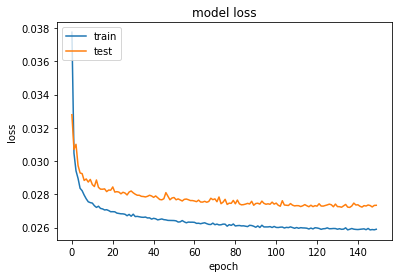

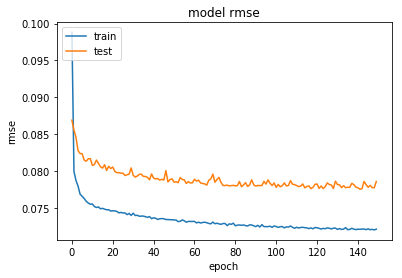

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [16]:
model.load_weights(experiment_name+'.hdf5')

In [17]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = decode_sequence(encoder_input)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  131.46322679519653 s =  2.1910537918408712 min =  0.036517563263575234 h


## Evaluate performance on validation data to improve model

## Evaluate metrics

In [18]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.06372865408497645
Delay 100 ms: 0.00411416729162451
Delay 200 ms: 0.013350111448734468
Delay 300 ms: 0.025538435325925198
Delay 400 ms: 0.0392889540811005
Delay 500 ms: 0.05391822060322223
Delay 600 ms: 0.0691039778579371
Delay 700 ms: 0.08458975297624831
Delay 800 ms: 0.10020880742190307
Delay 900 ms: 0.11582956796242536
Delay 1000 ms: 0.13134454588064418

RMSE
Average rmse: 0.12969200495512137
Delay 100 ms: 0.011627999137533084
Delay 200 ms: 0.028472418247791096
Delay 300 ms: 0.04996780967368857
Delay 400 ms: 0.07337438877559987
Delay 500 ms: 0.09748984220914028
Delay 600 ms: 0.12184296787164486
Delay 700 ms: 0.1460565062719085
Delay 800 ms: 0.16997251146810988
Delay 900 ms: 0.19346684656537683
Delay 1000 ms: 0.21640946653699905

SMAPE
Average smape: 14.962121013830185
Delay 100 ms: 2.17091938977516
Delay 200 ms: 5.465235312013174
Delay 300 ms: 8.687796413192824
Delay 400 ms: 11.709734957289772
Delay 500 ms: 14.47490275426104
Delay 600 ms: 17.022686088994977
Delay 

(6060, 25, 3) (6060, 10, 3)


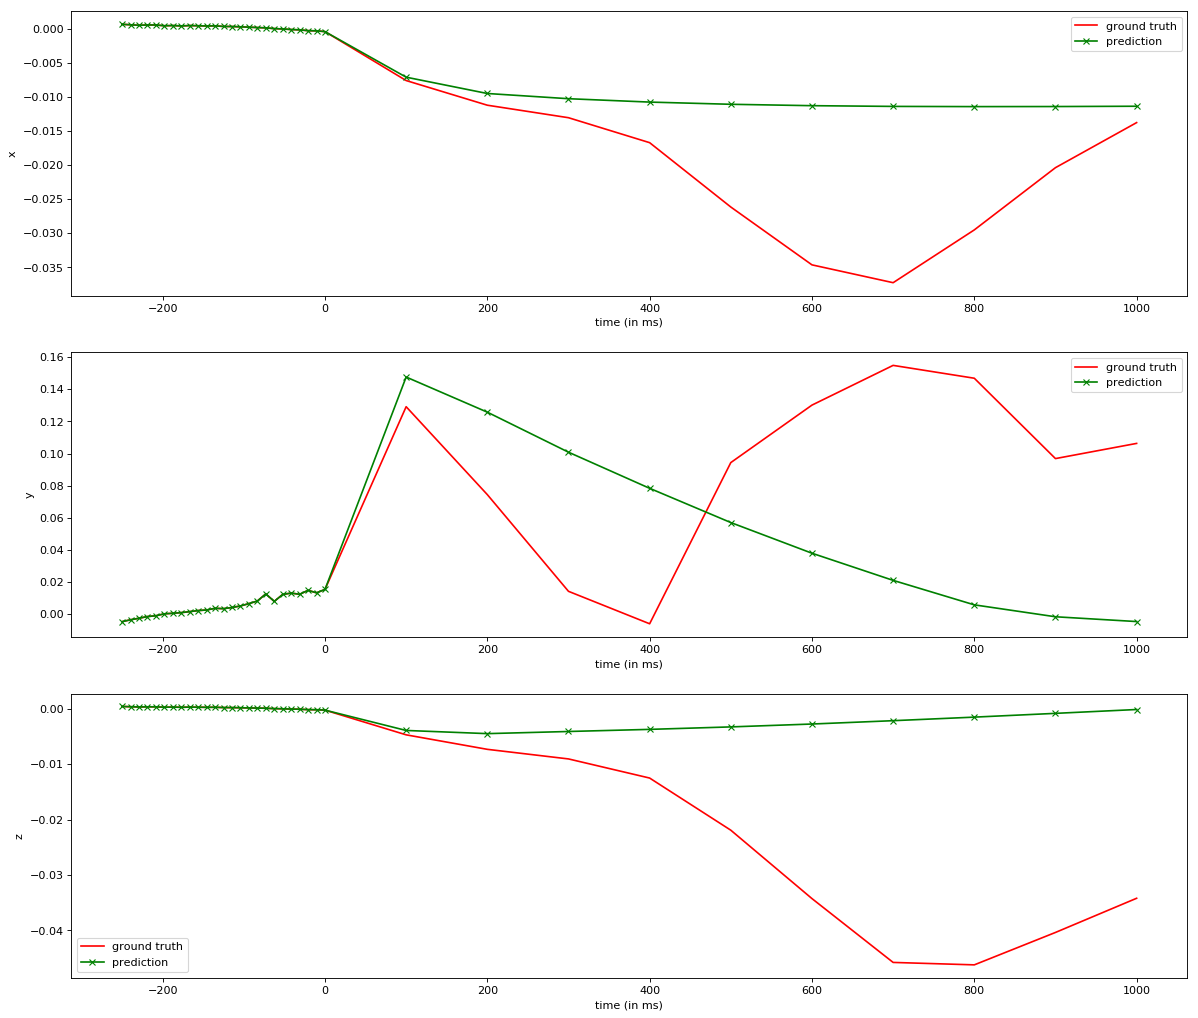

In [19]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)

Y_pred = decode_sequence(encoder_input)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')